In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [2]:
data = pd.read_csv('bank-full.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(45211, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [4]:
data['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [6]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns.

In [7]:
data['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

### Data exploration

In [9]:
data['deposit'].value_counts()

deposit
no     39922
yes     5289
Name: count, dtype: int64

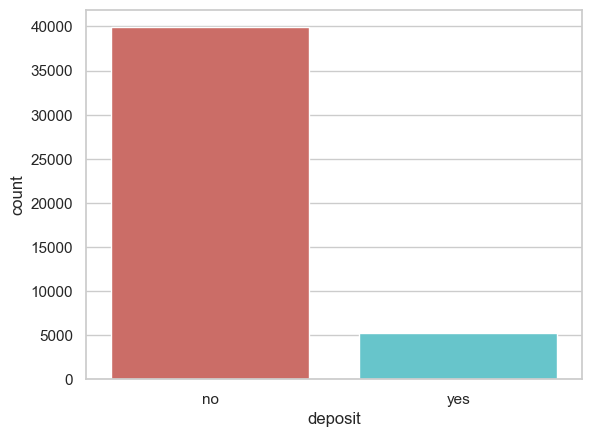

In [10]:
sns.countplot(x='deposit',data=data, palette='hls')
plt.show()

In [13]:
count_no_sub = len(data[data['deposit']=='no'])
count_sub = len(data[data['deposit']=='yes'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.30151954170445
percentage of subscription 11.698480458295547


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [17]:
data.groupby('deposit').mean()

TypeError: Could not convert managementtechnicianentrepreneurblue-collarunknownmanagementmanagemententrepreneurretiredtechnicianadmin.admin.techniciantechnicianservicesretiredadmin.blue-collarretiredservicesblue-collarmanagementblue-collarservicesretiredadmin.managemententrepreneurmanagementtechniciantechnicianmanagementadmin.blue-collarmanagementtechnicianblue-collartechnicianadmin.admin.servicesmanagementblue-collarretiredretiredadmin.self-employedtechniciantechnicianmanagementblue-collarmanagementmanagementadmin.technicianentrepreneurmanagementblue-collarblue-collarservicesadmin.technicianblue-collarservicesblue-collarmanagementretiredmanagementtechnicianblue-collarblue-collarservicesmanagementblue-collartechniciantechnicianblue-collarservicesservicesservicesadmin.servicestechnicianself-employedblue-collarmanagementretiredmanagementtechnicianadmin.blue-collarentrepreneurmanagementblue-collarretiredtechnicianmanagementblue-collarblue-collarblue-collarblue-collartechnicianblue-collartechnicianadmin.retiredmanagementservicestechnicianself-employedblue-collarretiredblue-collaradmin.managementmanagementtechniciantechnicianblue-collaradmin.servicestechniciantechnicianadmin.servicesblue-collarmanagementadmin.technicianadmin.unemployedblue-collartechnicianservicesblue-collarblue-collarhousemaidself-employedunemployedblue-collarblue-collarservicesblue-collarunemployedservicesblue-collarblue-collarstudentmanagementmanagementtechnicianservicesblue-collarretiredblue-collarblue-collarservicestechnicianservicesblue-collartechnicianadmin.managementtechnicianblue-collarblue-collarservicesentrepreneurretiredadmin.admin.unemployedtechnicianservicesmanagementservicestechnicianservicestechnicianadmin.retiredservicesmanagementblue-collarmanagementretiredmanagementmanagementadmin.blue-collarblue-collarservicestechnicianmanagementblue-collaradmin.self-employedblue-collarstudentservicesservicesmanagementmanagementservicesretiredblue-collarretiredhousemaidservicesblue-collartechnicianunknownunemployedhousemaidmanagementunemployedblue-collarentrepreneurretiredtechnicianblue-collarmanagementmanagementblue-collarservicesblue-collarservicesentrepreneurblue-collarblue-collarblue-collaradmin.blue-collaradmin.blue-collartechnicianentrepreneuradmin.technicianmanagementmanagementblue-collarmanagementblue-collarservicesadmin.blue-collarservicestechnicianmanagementblue-collarentrepreneurtechnicianservicesblue-collarblue-collarmanagementtechnicianmanagemententrepreneurstudentmanagementadmin.blue-collarblue-collarblue-collartechnicianentrepreneuradmin.retiredservicesservicesservicesself-employedblue-collaradmin.technicianblue-collarblue-collaradmin.admin.technicianblue-collarself-employedmanagementtechnicianstudentmanagementtechniciantechnicianblue-collarstudentblue-collartechnicianblue-collaradmin.retiredservicesservicestechnicianmanagementblue-collarblue-collarmanagementadmin.technicianservicesservicesadmin.admin.blue-collartechnicianretiredblue-collarblue-collarblue-collarmanagementtechnicianadmin.managementblue-collartechniciantechnicianblue-collarblue-collarblue-collarblue-collarmanagementmanagementblue-collaradmin.technicianadmin.servicesblue-collarmanagementblue-collarblue-collarmanagementservicestechnicianblue-collarservicesmanagementmanagementblue-collaradmin.blue-collarunknownadmin.blue-collarentrepreneurblue-collaradmin.managementservicesservicesadmin.admin.technicianadmin.managementadmin.studentservicesadmin.blue-collaradmin.blue-collarblue-collaradmin.blue-collarmanagementblue-collarblue-collarservicesmanagementadmin.blue-collarservicestechnicianunemployedblue-collartechniciantechnicianadmin.blue-collartechnicianadmin.admin.blue-collarblue-collarhousemaidtechnicianself-employedservicestechnicianmanagementretiredblue-collartechnicianblue-collarservicesblue-collaradmin.admin.entrepreneuradmin.technicianunemployedblue-collartechnicianmanagementmanagementadmin.blue-collartechnicianmanagementservicesblue-collartechnicianblue-collaradmin.managementblue-collarblue-collarblue-collaradmin.blue-collarmanagementtechnicianadmin.servicestechnicianblue-collarself-employedtechnicianadmin.self-employedservicesblue-collartechnicianservicesmanagementmanagementblue-collarblue-collaradmin.blue-collarblue-collarblue-collarblue-collarblue-collarunemployedservicesretiredadmin.blue-collarblue-collarself-employedserviceshousemaidblue-collarblue-collarblue-collarmanagementmanagementadmin.managementblue-collartechniciantechnicianblue-collarservicesmanagementblue-collarmanagementtechnicianblue-collartechnicianblue-collarblue-collarunemployedblue-collaradmin.blue-collarblue-collarblue-collartechnicianadmin.technicianmanagementblue-collarblue-collarblue-collarretiredblue-collarretiredadmin.retiredadmin.blue-collarmanagemententrepreneuradmin.blue-collartechnicianblue-collarmanagementmanagementadmin.managementretiredblue-collarmanagementmanagementmanagementadmin.blue-collarhousemaidservicesmanagementadmin.blue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicestechnicianadmin.unemployedadmin.blue-collarblue-collarself-employedservicesservicesadmin.studentself-employedblue-collaradmin.servicesadmin.blue-collartechnicianblue-collaradmin.entrepreneurtechnicianservicesblue-collarmanagementunemployedblue-collartechnicianblue-collarblue-collartechnicianservicesretiredentrepreneurtechnicianblue-collarservicesblue-collartechnicianservicesmanagementtechnicianblue-collarblue-collarservicestechnicianblue-collartechniciantechnicianadmin.retiredservicesservicesservicesblue-collartechnicianself-employedblue-collarblue-collarservicesblue-collarblue-collarblue-collartechnicianblue-collarself-employedservicestechnicianmanagementservicesblue-collartechnicianmanagementblue-collarblue-collarblue-collartechniciantechniciantechniciantechnicianretiredmanagementunemployedtechnicianadmin.technicianadmin.admin.blue-collarservicesentrepreneurservicesblue-collarunemployedservicesadmin.managementblue-collarblue-collartechnicianunemployedentrepreneurtechnicianstudentmanagementtechnicianstudentadmin.self-employedadmin.technicianblue-collarservicesblue-collaradmin.managementadmin.servicesadmin.blue-collarentrepreneurblue-collaradmin.technicianself-employedservicesblue-collarblue-collarself-employedblue-collarmanagementmanagementblue-collartechnicianmanagementadmin.servicesservicesadmin.admin.managementservicesmanagementadmin.managementblue-collarstudentblue-collartechnicianservicesentrepreneuradmin.blue-collartechnicianmanagementservicesblue-collaradmin.servicesadmin.blue-collartechniciantechniciantechnicianblue-collaradmin.blue-collarentrepreneurretiredadmin.admin.retiredblue-collarblue-collaradmin.technicianmanagementblue-collaradmin.blue-collarretiredservicesadmin.managementblue-collarblue-collarentrepreneurblue-collarmanagementservicesblue-collarblue-collartechnicianretiredmanagementblue-collarmanagementblue-collarblue-collarblue-collarblue-collarself-employedentrepreneurblue-collarmanagementadmin.blue-collarmanagementunemployedadmin.housemaidadmin.housemaidservicestechnicianblue-collarblue-collartechnicianself-employedtechnicianblue-collaradmin.technicianstudentblue-collarservicesblue-collartechnicianadmin.technicianservicesblue-collarmanagementblue-collaradmin.admin.blue-collarservicestechniciantechnicianmanagementtechnicianmanagementstudentretiredblue-collarblue-collarretiredblue-collarself-employedmanagementservicesmanagementblue-collarretiredtechnicianblue-collarservicesblue-collaradmin.blue-collarservicesservicesretiredtechnicianblue-collarself-employedblue-collartechnicianservicesblue-collarblue-collarmanagementtechniciantechnicianservicesservicesblue-collarblue-collarservicesservicesservicesblue-collarretiredmanagementmanagementblue-collarblue-collarmanagementtechniciantechnicianservicesentrepreneurblue-collaradmin.blue-collarblue-collartechnicianblue-collarservicesblue-collarmanagementservicesblue-collarservicestechnicianmanagementblue-collarblue-collaradmin.blue-collarservicesblue-collarservicesretiredadmin.servicesmanagementblue-collartechnicianblue-collarblue-collarmanagementself-employedservicesadmin.blue-collarblue-collarmanagementblue-collarunknowntechnicianadmin.servicesblue-collarhousemaidblue-collarmanagementunemployedmanagementblue-collarmanagementmanagementstudentservicesblue-collarentrepreneurblue-collarblue-collaradmin.blue-collaradmin.admin.servicesadmin.managementmanagementservicesblue-collarretiredself-employedblue-collaradmin.managementadmin.self-employedadmin.servicesblue-collarblue-collarunemployedadmin.technicianself-employedservicesblue-collarmanagementservicesblue-collarblue-collaradmin.retiredblue-collarblue-collarblue-collarblue-collarblue-collarblue-collaradmin.managementservicesblue-collarblue-collarservicesblue-collarservicesadmin.servicesentrepreneurmanagementtechnicianmanagementtechnicianblue-collarmanagementadmin.technicianblue-collarretiredservicesblue-collartechnicianretiredmanagementservicesblue-collaradmin.servicesservicesblue-collarservicesmanagementtechnicianblue-collarretiredunemployedadmin.retiredmanagementunemployedadmin.blue-collartechnicianentrepreneuradmin.blue-collarunemployedadmin.entrepreneurtechnicianadmin.unemployedmanagementblue-collarblue-collarblue-collarblue-collaradmin.blue-collarservicestechnicianadmin.technicianblue-collarservicesblue-collarservicesblue-collarblue-collarblue-collarservicesblue-collartechnicianadmin.managementservicesblue-collarblue-collaradmin.entrepreneurblue-collarentrepreneurtechnicianadmin.technicianblue-collarblue-collartechnicianmanagementblue-collarblue-collarmanagementservicestechnicianblue-collarblue-collarblue-collarblue-collarblue-collartechnicianservicesblue-collaradmin.blue-collarblue-collaradmin.blue-collarmanagementtechnicianmanagementtechniciantechnicianblue-collarstudentblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicesblue-collartechniciantechnicianblue-collarservicesmanagemententrepreneurservicesblue-collarmanagementmanagementadmin.unknownblue-collarblue-collarserviceshousemaidblue-collarmanagementtechnicianself-employedtechnicianblue-collarblue-collarblue-collaradmin.blue-collartechnicianblue-collarblue-collarmanagementmanagementblue-collaradmin.entrepreneurhousemaidadmin.blue-collarservicesblue-collarblue-collarblue-collartechnicianservicesadmin.technicianblue-collarblue-collarservicesadmin.technicianservicesblue-collarblue-collarretiredblue-collarblue-collarblue-collartechnicianretiredblue-collarblue-collartechnicianservicestechnicianblue-collarblue-collarservicesadmin.admin.blue-collarblue-collarblue-collarmanagementblue-collartechnicianblue-collarmanagementservicesentrepreneurtechnicianservicesservicesadmin.technicianadmin.blue-collartechnicianadmin.managementtechnicianadmin.unemployedtechnicianblue-collarretiredadmin.blue-collarblue-collarself-employedadmin.servicesmanagementtechnicianadmin.managementblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarmanagementtechnicianservicesblue-collaradmin.blue-collarentrepreneurself-employedmanagementretiredblue-collarmanagementblue-collarentrepreneurblue-collarmanagementadmin.technicianmanagementhousemaidblue-collarentrepreneurunemployedadmin.blue-collartechniciantechnicianhousemaidmanagementblue-collarblue-collarblue-collarblue-collarmanagementmanagementblue-collaradmin.blue-collarblue-collaradmin.servicesadmin.admin.blue-collarmanagementstudentretiredadmin.unemployedtechniciantechnicianadmin.technicianblue-collarself-employedblue-collarentrepreneurtechnicianservicestechnicianblue-collarblue-collarblue-collarservicesmanagementblue-collartechnicianblue-collarmanagementblue-collarretiredblue-collarmanagementadmin.servicesservicesself-employedadmin.blue-collarretiredtechnicianservicesmanagementtechnicianblue-collartechnicianadmin.blue-collarmanagementblue-collarblue-collarmanagementself-employedmanagemententrepreneurtechnicianblue-collarmanagementblue-collarblue-collarmanagementblue-collartechnicianmanagementblue-collarservicesstudenttechnicianblue-collaradmin.unknownentrepreneurtechnicianservicesblue-collarservicestechniciantechnicianmanagementtechnicianunemployedmanagementmanagementtechnicianserviceshousemaidblue-collarmanagementblue-collartechnicianmanagementtechnicianmanagementadmin.blue-collarblue-collarblue-collarblue-collarservicesblue-collarentrepreneurmanagementservicesblue-collartechnicianservicesadmin.blue-collartechniciantechnicianblue-collaradmin.technicianmanagementtechnicianblue-collarstudentblue-collarservicesadmin.servicestechnicianadmin.servicestechnicianservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarentrepreneurservicesblue-collarblue-collarblue-collarservicesservicesadmin.technicianunemployedservicesblue-collarself-employedblue-collarservicesservicesblue-collarstudenttechnicianblue-collaradmin.admin.retiredmanagementadmin.managementmanagementadmin.housemaidadmin.managementretiredblue-collarmanagementservicesblue-collarblue-collarblue-collarservicesservicesblue-collarblue-collarmanagementmanagementstudentblue-collarmanagementblue-collarservicesadmin.blue-collartechnicianblue-collarservicesservicesblue-collartechniciantechnicianblue-collarblue-collarmanagementblue-collartechnicianmanagementblue-collarblue-collarmanagementblue-collarmanagementtechnicianmanagementblue-collarentrepreneurblue-collarblue-collaradmin.blue-collarservicesblue-collarblue-collarunemployedblue-collarself-employedtechnicianblue-collaradmin.blue-collarself-employedentrepreneurmanagementmanagementservicesservicesentrepreneurblue-collarblue-collarservicesblue-collarblue-collarservicesblue-collarblue-collarmanagementadmin.retiredblue-collarblue-collarblue-collarblue-collarblue-collarservicesblue-collarmanagementblue-collartechnicianblue-collarblue-collarmanagementtechnicianadmin.servicestechnicianblue-collarblue-collarmanagementunemployedtechniciantechnicianblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collarblue-collaradmin.managementblue-collarblue-collarservicestechnicianentrepreneurself-employedtechnicianmanagementblue-collarmanagementtechnicianblue-collarblue-collarmanagementstudentunemployedservicesmanagementblue-collaradmin.blue-collarmanagementblue-collarunemployedblue-collarblue-collarblue-collarblue-collaradmin.blue-collarunemployedtechnicianservicesmanagementblue-collartechniciantechnicianblue-collartechnicianhousemaidmanagementblue-collarmanagementretiredblue-collaradmin.unemployedblue-collarblue-collarblue-collarblue-collarservicesblue-collarblue-collartechniciantechnicianself-employedmanagementservicesservicesmanagementblue-collarmanagementtechnicianself-employedservicesmanagementunemployedblue-collarblue-collarblue-collarmanagementmanagementmanagementblue-collarblue-collarblue-collarblue-collaradmin.admin.blue-collartechnicianblue-collarblue-collarblue-collarmanagementadmin.managementmanagementunemployedtechnicianmanagementtechnicianblue-collarblue-collartechnicianmanagementblue-collarblue-collarblue-collarmanagementservicesblue-collaradmin.blue-collarmanagementblue-collarservicesservicesadmin.managementmanagementservicesblue-collarblue-collaradmin.blue-collarmanagementadmin.techniciantechniciantechnicianself-employedtechnicianblue-collarmanagementblue-collarblue-collarservicesadmin.technicianblue-collarentrepreneurtechnicianblue-collarservicesblue-collaradmin.blue-collarblue-collaradmin.admin.admin.blue-collarmanagementblue-collarblue-collarblue-collartechniciantechnicianblue-collarblue-collarblue-collartechniciantechnicianblue-collarmanagementblue-collarhousemaidblue-collarblue-collarunemployedserviceshousemaidblue-collaradmin.technicianunemployedblue-collarblue-collarservicesmanagementblue-collarblue-collartechnicianservicesblue-collartechniciantechnicianblue-collarmanagementhousemaidtechnicianblue-collaradmin.managementblue-collarblue-collarservicesblue-collarblue-collarblue-collaradmin.managementtechnicianservicesmanagementblue-collarretiredservicesservicesblue-collarblue-collarself-employedblue-collarblue-collarmanagemententrepreneurservicesunemployedretiredblue-collarmanagementadmin.studentblue-collarservicesadmin.admin.managementblue-collartechnicianadmin.blue-collarblue-collarself-employedmanagementblue-collaradmin.servicesblue-collarservicesblue-collartechniciantechnicianblue-collarblue-collaradmin.blue-collarblue-collarmanagementadmin.managementblue-collaradmin.self-employedtechnicianunemployedtechnicianblue-collarservicesunemployedtechnicianstudenttechnicianadmin.blue-collartechnicianblue-collaradmin.technicianmanagementblue-collarservicesblue-collarservicesserviceshousemaidunemployedservicesadmin.managementtechnicianadmin.blue-collarblue-collarmanagementmanagementblue-collarblue-collarblue-collarblue-collarmanagemententrepreneuradmin.blue-collarmanagementblue-collarblue-collarblue-collarservicesadmin.unemployedservicesblue-collarservicesblue-collarservicesretiredadmin.managementmanagementtechnicianblue-collarservicesstudententrepreneurmanagementblue-collarmanagementservicesblue-collarblue-collarblue-collarmanagementblue-collarblue-collarstudentself-employedblue-collarmanagementblue-collarblue-collarmanagementmanagementblue-collarservicestechnicianstudentblue-collarblue-collartechnicianmanagementadmin.blue-collarunemployedretiredservicesservicestechniciantechnicianmanagementblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collaradmin.blue-collartechnicianblue-collartechniciantechnicianblue-collarblue-collarblue-collartechnicianservicesmanagementblue-collarblue-collarblue-collarblue-collarblue-collarmanagementblue-collarblue-collartechnicianservicesservicesadmin.blue-collarblue-collaradmin.unemployedblue-collartechnicianblue-collarentrepreneurmanagementblue-collartechnicianservicestechnicianself-employedblue-collarserviceshousemaidmanagementtechnicianentrepreneurself-employedblue-collarmanagemententrepreneurtechnicianentrepreneuradmin.blue-collarblue-collaradmin.technicianadmin.blue-collarblue-collarmanagementservicesservicesblue-collarblue-collartechnicianadmin.admin.blue-collarservicesblue-collarmanagemententrepreneurmanagementblue-collartechnicianstudentblue-collarservicesmanagementblue-collarmanagementmanagementblue-collartechnicianstudentadmin.servicesadmin.admin.blue-collarmanagementadmin.blue-collaradmin.blue-collarblue-collaradmin.blue-collarmanagementblue-collaradmin.unemployedblue-collarblue-collaradmin.servicesblue-collartechnicianblue-collarblue-collaradmin.blue-collaradmin.blue-collarblue-collarmanagementblue-collarblue-collarblue-collarself-employedblue-collarmanagementmanagementmanagementblue-collarblue-collaradmin.servicesmanagementblue-collarservicesself-employedmanagementunemployedentrepreneuradmin.technicianblue-collarblue-collaradmin.self-employedadmin.managementblue-collarmanagementadmin.managemententrepreneurservicesself-employedservicesadmin.blue-collarblue-collarblue-collarservicesadmin.blue-collarmanagementmanagementunemployedmanagementtechnicianblue-collarmanagementmanagementservicesblue-collarblue-collartechnicianblue-collarblue-collarblue-collaradmin.technicianservicesmanagementservicesmanagementblue-collarblue-collartechniciantechnicianmanagementblue-collartechnicianself-employedblue-collarunknownadmin.managementblue-collarmanagementmanagementadmin.unemployedblue-collarblue-collarmanagementblue-collarunemployedstudentadmin.blue-collarblue-collarservicesretiredadmin.unemployedblue-collarservicesblue-collartechnicianblue-collartechniciantechnicianretiredmanagementblue-collartechnicianadmin.servicestechnicianblue-collaradmin.managementblue-collarself-employedmanagementservicesunemployedblue-collarservicesmanagementblue-collarservicestechnicianmanagementservicesblue-collarblue-collarblue-collarservicestechnicianblue-collarblue-collarmanagementblue-collarmanagementmanagementtechnicianblue-collaradmin.blue-collaradmin.blue-collarblue-collarblue-collarstudentretiredblue-collarentrepreneurblue-collarself-employedtechnicianservicesservicesentrepreneurblue-collaradmin.self-employedtechniciantechnicianblue-collarblue-collaradmin.technicianadmin.admin.blue-collarservicesentrepreneuradmin.retiredtechnicianadmin.technicianadmin.technicianblue-collaradmin.retiredservicestechnicianblue-collarentrepreneurservicesblue-collarmanagementblue-collarblue-collaradmin.blue-collarservicesblue-collarblue-collarblue-collarblue-collaradmin.admin.entrepreneurblue-collarblue-collarblue-collarmanagementservicesblue-collarblue-collarblue-collaradmin.blue-collarmanagementtechniciantechnicianadmin.servicesservicesservicesblue-collarservicestechnicianretiredtechnicianblue-collartechnicianblue-collarservicesblue-collarunemployedadmin.entrepreneurblue-collartechniciantechnicianmanagementadmin.admin.blue-collaradmin.admin.blue-collarservicesadmin.servicesblue-collarblue-collarblue-collarunemployedblue-collarmanagementblue-collarblue-collartechniciantechnicianblue-collarmanagementadmin.studentservicesblue-collaradmin.admin.blue-collarblue-collarmanagementstudentmanagementtechnicianblue-collarblue-collarmanagementadmin.housemaidentrepreneurblue-collartechnicianadmin.blue-collarmanagementself-employedmanagementtechnicianmanagementservicesblue-collarblue-collarmanagementadmin.blue-collarstudentadmin.entrepreneurblue-collarentrepreneurself-employedmanagementmanagementmanagementtechnicianadmin.blue-collarblue-collarservicesblue-collarmanagementblue-collarmanagementblue-collarblue-collarunemployedadmin.entrepreneurblue-collarblue-collaradmin.managementservicestechnicianservicesblue-collarblue-collarblue-collarentrepreneurblue-collarblue-collarblue-collaradmin.admin.managementadmin.technicianblue-collartechnicianblue-collarblue-collaradmin.blue-collarblue-collarentrepreneurblue-collartechnicianself-employedblue-collarunemployedblue-collarservicesblue-collarhousemaidadmin.blue-collaradmin.managementblue-collartechnicianadmin.servicesadmin.blue-collartechnicianblue-collarblue-collartechniciantechnicianadmin.admin.servicesblue-collarblue-collarservicesblue-collarentrepreneurblue-collartechnicianblue-collarservicestechnicianadmin.blue-collartechnicianblue-collarblue-collarmanagemententrepreneuradmin.technicianservicesservicestechnicianblue-collarblue-collartechnicianstudentblue-collarunemployedservicesmanagementtechnicianadmin.blue-collaradmin.blue-collartechnicianservicesmanagementadmin.servicesmanagementservicesblue-collartechnicianblue-collarblue-collarunemployedblue-collarblue-collarblue-collaradmin.blue-collaradmin.technicianservicesblue-collarretiredblue-collarblue-collaradmin.blue-collaradmin.blue-collarblue-collarmanagementretiredservicesservicesadmin.servicesadmin.managementblue-collarblue-collartechnicianblue-collartechnicianmanagementtechnicianself-employedmanagementblue-collarblue-collarblue-collaradmin.blue-collarblue-collarservicesblue-collaradmin.blue-collartechniciantechnicianretiredblue-collarunemployedself-employedblue-collartechniciantechnicianunemployedtechnicianmanagementself-employedblue-collarblue-collarservicesretiredretiredmanagementblue-collarmanagementservicesblue-collarretiredblue-collarblue-collarblue-collarblue-collartechnicianadmin.servicesretiredmanagementservicesblue-collarself-employedtechniciantechnicianretiredblue-collaradmin.blue-collartechniciantechniciantechnicianmanagementservicesservicesmanagementmanagementmanagementretiredtechnicianblue-collaradmin.managementservicesentrepreneuradmin.entrepreneurmanagementservicesblue-collarblue-collarblue-collarunemployedadmin.retiredtechnicianadmin.servicesblue-collarblue-collarservicesblue-collarentrepreneurtechnicianmanagementblue-collaradmin.retiredmanagementservicesentrepreneurblue-collarself-employedmanagementmanagementblue-collarretiredadmin.servicesmanagementself-employedblue-collarblue-collarretiredtechnicianadmin.blue-collarretiredtechnicianadmin.servicestechnicianblue-collarretiredblue-collaradmin.admin.blue-collarmanagementadmin.admin.technicianblue-collartechnicianadmin.unemployedentrepreneurblue-collarmanagementhousemaidblue-collarself-employedblue-collarmanagementadmin.blue-collaradmin.admin.retiredtechnicianblue-collartechnicianadmin.technicianadmin.technicianmanagementservicesblue-collarblue-collarblue-collarblue-collarmanagementblue-collartechnicianmanagementblue-collarservicesmanagementblue-collaradmin.servicesblue-collaradmin.technicianblue-collartechnicianservicestechnicianblue-collarblue-collarblue-collarretiredadmin.servicesblue-collarmanagementservicestechnicianadmin.managementmanagementblue-collarblue-collarentrepreneurmanagementservicesservicesblue-collarblue-collarservicesadmin.blue-collartechnicianmanagementtechnicianblue-collarmanagementblue-collaradmin.blue-collarblue-collarblue-collarservicesretiredretiredblue-collarblue-collarblue-collaradmin.techniciantechnicianblue-collarmanagementmanagementretiredblue-collarblue-collarentrepreneurmanagementblue-collaradmin.blue-collarblue-collartechnicianblue-collartechnicianblue-collarblue-collartechnicianblue-collarblue-collartechnicianentrepreneurblue-collarhousemaidblue-collarblue-collarself-employedtechnicianretiredmanagementretiredservicesmanagementmanagementretiredadmin.self-employedtechnicianretiredretiredservicesmanagementblue-collarblue-collarblue-collarhousemaidblue-collarblue-collaradmin.blue-collarservicesblue-collarservicesblue-collaradmin.admin.blue-collarblue-collarblue-collarentrepreneuradmin.blue-collarblue-collarretiredtechnicianblue-collarmanagementblue-collartechnicianmanagementmanagementblue-collarservicesblue-collarblue-collarunknownblue-collarunemployedtechnicianblue-collartechnicianservicesblue-collaradmin.blue-collartechnicianblue-collaradmin.entrepreneurblue-collarmanagementadmin.admin.blue-collarservicesadmin.blue-collarretiredblue-collarentrepreneuradmin.managementretiredtechnicianblue-collartechnicianblue-collarblue-collaradmin.blue-collaradmin.blue-collarblue-collartechnicianentrepreneurblue-collartechnicianblue-collarblue-collarblue-collarblue-collartechniciantechnicianblue-collarblue-collaradmin.servicesblue-collarself-employedmanagementadmin.managementtechnicianmanagementmanagementmanagementtechnicianadmin.blue-collarblue-collartechnicianblue-collarblue-collarentrepreneurtechnicianblue-collartechnicianstudentblue-collartechniciantechnicianblue-collartechniciantechnicianblue-collarretiredservicesmanagementmanagementmanagementblue-collarmanagementadmin.blue-collaradmin.managementtechnicianblue-collarmanagementadmin.admin.admin.servicesmanagementadmin.managementunemployedtechnicianentrepreneurservicesretiredtechnicianretiredservicesadmin.blue-collartechnicianadmin.unknowntechnicianmanagementtechnicianretiredhousemaidunknownblue-collarunemployedmanagementblue-collarblue-collarmanagementblue-collartechnicianadmin.blue-collarblue-collarblue-collarself-employedunemployedmanagementmanagementblue-collarblue-collaradmin.entrepreneurservicesblue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarblue-collartechnicianblue-collaradmin.blue-collarblue-collarblue-collarretiredtechnicianmanagementblue-collarmanagementblue-collaradmin.managementmanagementblue-collarmanagementadmin.blue-collarretiredblue-collarretiredentrepreneuradmin.blue-collarself-employedmanagementtechnicianblue-collarunemployedblue-collaradmin.technicianadmin.blue-collarunemployedblue-collarblue-collartechnicianblue-collarblue-collaradmin.technicianservicesblue-collarblue-collarblue-collarblue-collaradmin.servicestechnicianblue-collarblue-collarblue-collarmanagementtechnicianservicestechnicianentrepreneurblue-collarretiredmanagementself-employedtechnicianblue-collarmanagementservicesretiredblue-collarmanagementblue-collartechnicianself-employedblue-collarmanagementretiredblue-collarblue-collaradmin.blue-collarservicesmanagementtechnicianentrepreneurblue-collarentrepreneurentrepreneurblue-collarblue-collarentrepreneurmanagementblue-collarmanagementblue-collartechnicianself-employedadmin.entrepreneurblue-collarentrepreneurservicesadmin.technicianblue-collarretiredunemployedretiredmanagementblue-collaradmin.blue-collarblue-collarmanagementblue-collarservicesblue-collarservicesblue-collarservicesmanagementblue-collarmanagementblue-collarblue-collarservicesservicestechnicianservicesservicesadmin.unemployedblue-collarblue-collarblue-collarblue-collarservicesblue-collartechnicianadmin.studentadmin.entrepreneurmanagementblue-collarblue-collaradmin.admin.blue-collartechnicianservicesadmin.admin.technicianself-employedservicestechnicianblue-collarunemployedmanagementservicestechnicianblue-collarhousemaidservicesblue-collaradmin.blue-collarblue-collarmanagementservicesmanagementblue-collartechniciantechnicianhousemaidretiredadmin.admin.blue-collarmanagementservicesadmin.technicianblue-collaradmin.blue-collarretiredmanagementself-employedmanagementtechnicianadmin.blue-collarservicesblue-collarstudentservicesservicestechniciantechnicianblue-collaradmin.technicianblue-collarblue-collarblue-collarentrepreneurunemployedunemployedadmin.housemaidblue-collarblue-collarblue-collarblue-collarblue-collarblue-collaradmin.technicianblue-collaradmin.blue-collarentrepreneurunemployedblue-collaradmin.blue-collarblue-collartechnicianadmin.technicianblue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collartechnicianadmin.managementadmin.retiredblue-collarblue-collarblue-collaradmin.techniciantechnicianblue-collaradmin.servicestechnicianblue-collarblue-collarblue-collarmanagementtechnicianretiredself-employedadmin.blue-collartechniciantechnicianblue-collarblue-collarblue-collarblue-collarblue-collarmanagementmanagementtechnicianstudentservicesadmin.self-employedtechniciantechnicianmanagemententrepreneurblue-collarmanagementadmin.managementservicesblue-collarblue-collarretiredtechnicianblue-collarservicesadmin.managementservicesmanagemententrepreneurservicesmanagementunemployedblue-collarmanagementhousemaidblue-collaradmin.admin.managementtechnicianadmin.managementadmin.managementtechnicianhousemaidservicesadmin.servicesservicesentrepreneurretiredtechnicianretiredmanagementservicesblue-collarretiredtechnicianadmin.admin.retiredunemployedretiredservicesblue-collaradmin.technicianmanagementservicesmanagementtechnicianservicesservicesservicesmanagementtechnicianentrepreneurblue-collarblue-collarself-employedretiredentrepreneurblue-collarblue-collarblue-collarblue-collarretiredblue-collarentrepreneurmanagementblue-collarblue-collaradmin.blue-collaradmin.managemententrepreneurblue-collarblue-collarblue-collarblue-collarblue-collartechniciantechnicianblue-collarblue-collarblue-collarblue-collaradmin.servicesblue-collarservicesadmin.blue-collarblue-collarhousemaidblue-collarunemployedblue-collarentrepreneurretiredblue-collarmanagementservicesservicesblue-collarblue-collarblue-collarblue-collarretiredadmin.blue-collarblue-collarentrepreneurentrepreneurentrepreneurentrepreneurblue-collarblue-collarservicesmanagementblue-collarentrepreneuradmin.managementtechniciantechnicianmanagementretiredtechniciantechnicianblue-collarretiredblue-collarentrepreneurself-employedblue-collaradmin.retiredblue-collartechnicianadmin.servicesentrepreneurblue-collarmanagementservicesblue-collarmanagementservicesretiredblue-collarentrepreneurblue-collarblue-collaradmin.blue-collarretiredretiredblue-collarblue-collartechnicianblue-collarservicesblue-collarblue-collarservicesmanagementadmin.blue-collarblue-collarblue-collarblue-collarblue-collarservicesmanagementadmin.technicianretiredmanagementblue-collarentrepreneurhousemaidstudentadmin.admin.managementmanagementmanagementtechnicianservicesblue-collarretiredblue-collarretiredblue-collaradmin.admin.servicesblue-collartechniciantechnicianmanagementblue-collartechnicianblue-collarblue-collarmanagementservicesblue-collarblue-collarservicesblue-collartechnicianservicestechnicianmanagementblue-collaradmin.managementself-employedblue-collarretiredmanagementblue-collarblue-collaradmin.servicesadmin.unemployedmanagementservicesmanagementblue-collarentrepreneurblue-collarmanagementservicesservicesblue-collartechnicianmanagementblue-collarblue-collarblue-collarmanagementtechniciantechniciantechnicianservicesmanagementunemployedservicesself-employedblue-collarservicestechnicianadmin.blue-collarhousemaidblue-collarself-employedmanagementstudentadmin.servicesadmin.servicesadmin.blue-collartechniciantechnicianblue-collarunemployedmanagementmanagementstudentunemployedentrepreneuradmin.technicianretiredmanagemententrepreneurblue-collarmanagementtechnicianmanagementtechnicianservicesadmin.blue-collaradmin.blue-collarmanagementmanagemententrepreneurblue-collarmanagementtechnicianblue-collarmanagementservicesadmin.blue-collartechnicianmanagementblue-collarblue-collarmanagementblue-collarmanagementadmin.managementtechnicianserviceshousemaidmanagementblue-collarmanagementmanagementblue-collarunknownservicesblue-collartechnicianblue-collarretiredhousemaidservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collaradmin.servicesself-employedmanagementtechniciantechnicianblue-collarhousemaidservicesblue-collarmanagementmanagementblue-collarblue-collartechnicianadmin.blue-collarblue-collarretiredblue-collaradmin.blue-collarblue-collarmanagementmanagementblue-collaradmin.blue-collarblue-collarservicesservicestechnicianblue-collartechnicianblue-collartechnicianblue-collarservicesblue-collarmanagementmanagementblue-collarblue-collarblue-collarmanagementblue-collarblue-collarmanagementmanagementblue-collarretiredtechnicianadmin.technicianadmin.entrepreneurtechniciantechnicianblue-collarservicesmanagementblue-collaradmin.unemployedtechnicianblue-collarblue-collartechnicianservicesblue-collaradmin.self-employedadmin.technicianretiredmanagementadmin.managementmanagementservicesadmin.blue-collarretiredblue-collarblue-collarmanagementservicestechnicianblue-collartechniciantechniciantechniciantechnicianblue-collarmanagementblue-collartechnicianretiredservicesadmin.blue-collarentrepreneurblue-collarblue-collarself-employedmanagementself-employedblue-collarmanagementblue-collarblue-collarblue-collaradmin.managementretiredadmin.technicianblue-collaradmin.blue-collaradmin.technicianblue-collarmanagementtechnicianmanagementblue-collarblue-collarblue-collaradmin.blue-collartechnicianhousemaidretiredtechnicianservicesadmin.managementblue-collarself-employedmanagementservicestechniciantechnicianstudentadmin.managementmanagementmanagementadmin.technicianself-employedmanagementservicesservicesserviceshousemaidblue-collaradmin.blue-collaradmin.servicesmanagementtechnicianblue-collaradmin.blue-collarunemployedtechnicianadmin.admin.admin.servicesadmin.managementtechnicianblue-collarhousemaidservicesmanagementmanagementadmin.unemployedtechnicianblue-collarblue-collarmanagementservicesmanagementblue-collaradmin.entrepreneurtechnicianadmin.blue-collarservicesentrepreneurmanagementmanagementservicesblue-collarself-employedadmin.servicesservicesadmin.servicesservicesretiredentrepreneurservicesblue-collarblue-collarblue-collartechnicianadmin.retiredadmin.blue-collarblue-collarblue-collarmanagementservicesblue-collarservicesblue-collartechnicianmanagementadmin.blue-collarmanagementmanagementtechnicianblue-collarblue-collarblue-collartechnicianblue-collaradmin.technicianadmin.blue-collarretiredblue-collarblue-collarblue-collaradmin.blue-collarblue-collartechnicianblue-collarblue-collaradmin.blue-collarself-employedself-employedblue-collaradmin.blue-collaradmin.admin.self-employedblue-collaradmin.blue-collaradmin.blue-collarblue-collarunemployedentrepreneurretiredblue-collarservicesservicesmanagementblue-collartechnicianblue-collartechniciantechnicianmanagementblue-collartechniciantechnicianhousemaidblue-collartechniciantechnicianblue-collarservicesservicesblue-collarblue-collarblue-collarmanagementblue-collarhousemaidtechnicianmanagementmanagementblue-collarservicesmanagementtechniciantechnicianunemployedblue-collarblue-collarservicesadmin.admin.managementmanagementadmin.blue-collarblue-collartechnicianentrepreneurtechnicianblue-collarentrepreneurblue-collaradmin.unemployedtechnicianself-employedmanagementmanagementblue-collarblue-collarentrepreneurretiredblue-collarservicesmanagementmanagementblue-collarblue-collarservicesmanagementtechnicianadmin.techniciantechnicianretiredtechnicianservicesmanagementretiredadmin.self-employedtechnicianblue-collarservicesmanagementmanagementservicesadmin.servicesblue-collartechnicianmanagementservicestechnicianmanagementtechnicianhousemaidmanagementservicesentrepreneuradmin.technicianadmin.technicianblue-collarunemployedblue-collarblue-collarblue-collarservicestechniciantechnicianblue-collartechnicianservicestechnicianblue-collaradmin.blue-collarblue-collaradmin.managementblue-collarblue-collarretiredblue-collarmanagementadmin.admin.techniciantechnicianblue-collaradmin.managementblue-collarservicesblue-collarblue-collarblue-collaradmin.blue-collarmanagementblue-collarblue-collartechnicianself-employedtechnicianblue-collarblue-collarservicesadmin.blue-collarmanagementmanagementservicesunknownblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarentrepreneuradmin.servicesblue-collartechnicianservicesmanagementblue-collarblue-collarunknownservicesblue-collarmanagementservicesadmin.technicianblue-collarblue-collarmanagementservicesservicesself-employedself-employedblue-collarblue-collarunemployedmanagementblue-collartechnicianadmin.admin.retiredtechnicianblue-collarblue-collarservicesblue-collarservicesself-employedmanagementmanagementmanagementblue-collarself-employedblue-collarretiredmanagementblue-collaradmin.blue-collarblue-collaradmin.servicesmanagemententrepreneurblue-collarblue-collarmanagementblue-collartechnicianmanagementmanagementservicesblue-collarblue-collarblue-collarblue-collarretiredunemployedservicesservicesblue-collarmanagementservicestechnicianblue-collarmanagementtechnicianadmin.blue-collaradmin.servicesblue-collarentrepreneuradmin.technicianservicesservicesservicesservicesservicesadmin.blue-collaradmin.technicianblue-collarblue-collartechniciantechnicianadmin.admin.admin.servicesmanagementservicesmanagementtechnicianservicesblue-collarmanagementblue-collarmanagementblue-collarmanagementtechnicianservicesservicesblue-collarblue-collarunemployedadmin.managementservicesblue-collarblue-collarblue-collartechnicianadmin.blue-collartechniciantechnicianstudentunemployedblue-collarmanagementtechnicianservicesblue-collartechnicianservicestechnicianblue-collarblue-collarentrepreneurblue-collarblue-collaradmin.housemaidadmin.studentblue-collartechnicianblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collaradmin.technicianentrepreneurblue-collarblue-collarblue-collarservicestechnicianblue-collarentrepreneurservicesblue-collaradmin.blue-collarservicestechnicianblue-collarmanagementmanagementblue-collarmanagementtechniciantechnicianentrepreneurblue-collarservicesmanagementblue-collarentrepreneurblue-collarservicestechnicianmanagementretiredblue-collarblue-collartechniciantechnicianblue-collarstudentadmin.blue-collarblue-collarblue-collarblue-collarblue-collarmanagementretiredmanagemententrepreneurblue-collarmanagemententrepreneurtechnicianmanagementunemployedtechniciantechnicianmanagementblue-collarblue-collarblue-collartechnicianblue-collarself-employedtechnicianadmin.blue-collarservicesadmin.self-employedtechnicianservicesservicesblue-collarblue-collarblue-collarself-employedblue-collarblue-collarservicesblue-collarmanagementmanagementblue-collaradmin.managementadmin.blue-collarblue-collarblue-collaradmin.blue-collarmanagementblue-collarblue-collartechniciantechnicianblue-collarblue-collarblue-collarmanagementmanagementmanagementstudentservicesadmin.blue-collarblue-collarmanagementblue-collarservicesblue-collarblue-collarblue-collaradmin.blue-collaradmin.blue-collarmanagementtechnicianblue-collarmanagementblue-collaradmin.blue-collarblue-collartechniciantechnicianblue-collarblue-collarmanagementtechnicianstudentmanagementblue-collarservicesblue-collarentrepreneuradmin.retiredmanagementmanagemententrepreneurservicesservicesmanagementblue-collarblue-collarblue-collarmanagementblue-collartechnicianmanagementblue-collaradmin.blue-collartechnicianmanagementblue-collarblue-collarblue-collarmanagementtechnicianmanagementblue-collarblue-collarblue-collarblue-collarretiredadmin.blue-collartechnicianblue-collartechnicianmanagementtechnicianservicesadmin.self-employedmanagementblue-collarmanagementblue-collarblue-collaradmin.blue-collarblue-collarservicesadmin.managementtechnicianblue-collarblue-collarmanagementblue-collarservicestechnicianblue-collarblue-collarservicesblue-collaradmin.technicianblue-collarmanagementmanagementretiredservicesmanagementself-employedself-employedservicesblue-collarstudentmanagementtechnicianmanagementmanagementmanagementadmin.servicesadmin.managementtechnicianservicesmanagementmanagementadmin.technicianblue-collarmanagementmanagementadmin.blue-collarmanagementmanagementblue-collarentrepreneurblue-collarmanagementunemployedblue-collarmanagementmanagementblue-collarblue-collarblue-collarmanagementservicesmanagementservicesservicestechnicianblue-collartechnicianadmin.studenthousemaidself-employedunemployedmanagementtechnicianservicesblue-collarself-employedadmin.admin.managementstudentblue-collarblue-collarblue-collarmanagementblue-collarservicesservicesunemployedblue-collarblue-collarservicesadmin.servicesservicesblue-collarblue-collarself-employedtechnicianmanagementservicesservicestechnicianhousemaidmanagementretiredtechniciantechnicianadmin.admin.techniciantechnicianblue-collarblue-collartechnicianservicesretiredhousemaidservicesentrepreneurblue-collartechnicianadmin.technicianadmin.housemaidtechnicianadmin.blue-collaradmin.technicianadmin.technicianadmin.blue-collarblue-collarblue-collarservicesservicesmanagementmanagementblue-collarblue-collarblue-collartechnicianentrepreneurmanagementtechnicianself-employedmanagementadmin.entrepreneurblue-collarblue-collarblue-collarservicesservicesblue-collartechniciantechniciantechnicianblue-collarmanagementblue-collaradmin.servicesadmin.blue-collarservicesblue-collarblue-collarblue-collarmanagementservicesadmin.blue-collarblue-collarmanagementself-employedhousemaidblue-collarstudenttechnicianservicesadmin.technicianblue-collarblue-collaradmin.managementadmin.blue-collarmanagementblue-collarmanagementadmin.managemententrepreneurservicesblue-collarblue-collarmanagementretiredadmin.housemaidmanagementblue-collarservicesblue-collarservicesadmin.technicianmanagementservicesblue-collarserviceshousemaidservicesblue-collartechnicianservicesblue-collarmanagemententrepreneurunemployedhousemaidblue-collaradmin.blue-collarservicesself-employedadmin.blue-collarblue-collarblue-collarmanagemententrepreneurhousemaidblue-collarblue-collarservicesblue-collarentrepreneurblue-collarservicesentrepreneurmanagementunemployedblue-collarblue-collarblue-collarblue-collartechnicianmanagementblue-collaradmin.managementservicesstudententrepreneurmanagementservicesadmin.managementmanagementblue-collarblue-collarblue-collaradmin.blue-collarblue-collarblue-collarmanagementadmin.servicesservicesblue-collarservicesblue-collartechnicianmanagementblue-collarblue-collarblue-collarblue-collarservicesservicesblue-collartechnicianhousemaidmanagementblue-collartechnicianadmin.techniciantechnicianmanagementservicesblue-collarself-employedtechnicianunemployedmanagementadmin.technicianmanagementblue-collarservicesentrepreneurmanagementtechnicianblue-collartechnicianself-employedservicesservicesservicesblue-collarmanagementblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarmanagementadmin.retiredmanagementblue-collarmanagementadmin.servicesblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarservicesblue-collarunemployedblue-collarmanagementmanagementservicesservicestechnicianblue-collarservicestechnicianblue-collarblue-collarblue-collarblue-collaradmin.techniciantechnicianservicesblue-collartechnicianblue-collarblue-collarstudentunemployedservicesblue-collaradmin.blue-collarmanagemententrepreneurtechnicianunemployedblue-collarblue-collarblue-collartechnicianunknownblue-collarservicesadmin.managementblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collarservicesmanagementtechnicianblue-collarblue-collarmanagementadmin.technicianblue-collarblue-collarblue-collarretiredtechnicianservicesmanagementadmin.managementadmin.servicesblue-collarblue-collarmanagementmanagementblue-collarunemployedmanagementblue-collarservicesmanagementservicestechniciantechnicianservicesblue-collarservicesadmin.admin.managementblue-collarblue-collarentrepreneuradmin.managementtechnicianadmin.technicianmanagementtechnicianstudentblue-collarmanagementblue-collarmanagementtechnicianmanagementtechnicianblue-collartechnicianblue-collarblue-collarblue-collarservicesentrepreneurservicestechniciantechnicianmanagementblue-collartechnicianblue-collartechnicianadmin.blue-collaradmin.technicianself-employedservicesservicesservicesmanagementmanagementself-employedservicesblue-collarentrepreneurtechnicianmanagementblue-collarmanagementtechniciantechnicianadmin.managementtechnicianblue-collarself-employedservicesadmin.blue-collarservicesentrepreneurblue-collarblue-collarunemployedservicesblue-collarblue-collarmanagementmanagementblue-collarblue-collarentrepreneurtechnicianblue-collartechnicianblue-collarblue-collartechnicianblue-collartechnicianretiredblue-collarmanagementtechnicianblue-collarblue-collaradmin.servicestechnicianadmin.blue-collartechniciantechnicianblue-collartechnicianservicestechniciantechnicianmanagementblue-collartechnicianservicesentrepreneurretiredblue-collarblue-collarmanagementservicesblue-collarblue-collarblue-collarmanagementmanagementblue-collartechnicianservicesadmin.blue-collaradmin.blue-collarblue-collarunemployedtechnicianblue-collartechnicianservicestechniciantechnicianadmin.retiredmanagementblue-collarblue-collaradmin.servicesadmin.managementtechniciantechnicianblue-collarblue-collarmanagementblue-collarentrepreneurtechnicianmanagementservicesblue-collartechnicianblue-collarblue-collartechnicianentrepreneuradmin.technicianmanagementself-employedtechnicianmanagementservicesmanagementmanagementblue-collarblue-collarblue-collarblue-collarblue-collarself-employedtechnicianblue-collaradmin.technicianmanagementblue-collarmanagementtechnicianself-employedmanagementadmin.managementstudentmanagementblue-collarmanagementtechnicianmanagementservicesmanagementmanagementtechnicianself-employedblue-collarblue-collarself-employedmanagementunemployedservicesservicestechniciantechnicianself-employedtechnicianhousemaidmanagementservicesadmin.managementblue-collartechnicianblue-collarmanagementmanagementmanagementtechnicianblue-collarblue-collarblue-collarservicestechnicianblue-collarservicesblue-collarblue-collarmanagementservicestechnicianblue-collarservicesservicesmanagementservicesmanagementblue-collarentrepreneurunemployedblue-collarblue-collarblue-collarblue-collarmanagementservicesadmin.blue-collarmanagementtechnicianentrepreneurblue-collarblue-collarblue-collarblue-collarmanagementblue-collartechnicianadmin.blue-collarmanagementself-employedadmin.retiredblue-collarservicesblue-collarentrepreneurblue-collarservicesmanagementself-employedadmin.managementmanagementmanagementblue-collarservicesadmin.blue-collarblue-collarblue-collarblue-collarunemployedblue-collarblue-collarblue-collarblue-collaradmin.blue-collartechnicianblue-collarmanagementservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collarself-employedservicesadmin.techniciantechnicianmanagementmanagementtechnicianblue-collarservicestechnicianmanagementtechnicianblue-collarmanagementblue-collaradmin.technicianblue-collarservicesentrepreneurblue-collaradmin.servicesblue-collaradmin.blue-collarservicesmanagementadmin.admin.admin.blue-collarblue-collartechnicianblue-collarmanagementretiredblue-collarblue-collarblue-collarblue-collarmanagementservicestechnicianblue-collarmanagementtechnicianblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collartechnicianblue-collarhousemaidblue-collarblue-collarblue-collarblue-collarmanagementadmin.entrepreneurblue-collarservicesservicesmanagementblue-collarmanagementunemployedblue-collarblue-collarmanagementmanagementblue-collarmanagementmanagemententrepreneurblue-collarblue-collarservicesblue-collartechnicianmanagementmanagementadmin.self-employedblue-collarservicesmanagementblue-collarservicesblue-collarmanagementservicesadmin.techniciantechniciantechniciantechnicianblue-collarblue-collarblue-collaradmin.self-employedmanagementtechniciantechnicianself-employedentrepreneurtechniciantechnicianblue-collarblue-collarmanagementmanagementblue-collartechnicianblue-collartechnicianblue-collarblue-collarblue-collartechnicianblue-collarself-employedblue-collarblue-collartechnicianentrepreneurservicestechnicianblue-collarblue-collartechnicianblue-collartechnicianblue-collarblue-collarblue-collarself-employedblue-collartechnicianmanagementblue-collarservicesblue-collartechnicianservicesblue-collarservicesmanagementservicesservicesservicesservicestechnicianblue-collarblue-collarmanagementadmin.self-employedadmin.admin.managementblue-collaradmin.managementtechnicianmanagementservicesstudentblue-collarself-employedblue-collarmanagementself-employedmanagementadmin.managementmanagementtechnicianblue-collartechnicianadmin.managementtechnicianmanagementtechnicianentrepreneurservicestechnicianstudentblue-collaradmin.technicianblue-collarblue-collartechnicianentrepreneurblue-collaradmin.technicianmanagementblue-collarretiredblue-collaradmin.managementblue-collarmanagementblue-collarhousemaidmanagementtechnicianblue-collarservicesblue-collarself-employedmanagementblue-collarblue-collaradmin.managementtechnicianblue-collartechniciantechnicianmanagementhousemaidadmin.blue-collarblue-collarmanagementtechnicianretiredself-employedblue-collarblue-collarblue-collarstudentmanagementtechnicianadmin.managementblue-collarblue-collaradmin.technicianblue-collarblue-collarservicesservicestechniciantechnicianblue-collartechnicianmanagementblue-collaradmin.blue-collarservicestechnicianadmin.admin.admin.unemployedservicesservicesmanagementtechniciantechnicianmanagementtechnicianservicesblue-collarmanagementblue-collarservicesblue-collaradmin.technicianblue-collarblue-collartechniciantechnicianblue-collarservicestechnicianblue-collarmanagementmanagementmanagementblue-collarmanagementservicesservicesadmin.blue-collartechniciantechnicianunemployedtechnicianblue-collarmanagementadmin.unemployedmanagementadmin.unemployedself-employedadmin.servicesadmin.servicesservicesadmin.blue-collaradmin.servicesblue-collarblue-collarblue-collarmanagementservicesservicesmanagementblue-collarmanagementblue-collarblue-collarblue-collarblue-collaradmin.technicianadmin.blue-collarmanagementmanagementservicesadmin.entrepreneurmanagementtechnicianadmin.technicianentrepreneuradmin.admin.admin.servicesservicesblue-collarentrepreneurblue-collaradmin.servicestechnicianmanagementadmin.blue-collartechnicianblue-collarblue-collarself-employedmanagementblue-collarmanagementblue-collarblue-collartechniciantechnicianblue-collarself-employedblue-collarservicesblue-collarblue-collartechnicianadmin.admin.blue-collarself-employedblue-collarentrepreneurtechnicianblue-collartechnicianblue-collarblue-collarservicesmanagementblue-collarblue-collartechnicianretiredblue-collarblue-collarblue-collarmanagementblue-collarservicesblue-collaradmin.managementblue-collarmanagementmanagementtechnicianservicesself-employedblue-collarblue-collarmanagementblue-collartechnicianmanagementtechnicianadmin.admin.blue-collarmanagementtechnicianblue-collartechnicianstudentadmin.blue-collarblue-collarblue-collarservicesadmin.admin.managementadmin.admin.managementadmin.admin.technicianself-employedblue-collarblue-collarblue-collaradmin.blue-collarservicesself-employedservicesentrepreneurblue-collarblue-collarblue-collarmanagementmanagementblue-collarblue-collarblue-collaradmin.admin.blue-collarmanagementblue-collarblue-collarservicesblue-collarblue-collarentrepreneurblue-collarretiredblue-collarblue-collarunemployedtechnicianblue-collarblue-collarblue-collarentrepreneurtechnicianblue-collarblue-collarblue-collartechnicianself-employedadmin.managementblue-collarmanagementadmin.technicianmanagementservicesadmin.blue-collarblue-collaradmin.blue-collaradmin.managementblue-collaradmin.blue-collaradmin.studentservicesblue-collaradmin.retiredtechnicianmanagementmanagementtechnicianservicesblue-collaradmin.technicianservicesadmin.retiredtechnicianblue-collarservicesadmin.blue-collartechniciantechnicianunemployedservicesblue-collarblue-collarblue-collarretiredtechniciantechnicianservicestechnicianblue-collarblue-collarentrepreneurservicesretiredservicesadmin.blue-collartechnicianadmin.admin.blue-collarblue-collaradmin.blue-collaradmin.technicianblue-collarunknownadmin.blue-collaradmin.servicestechnicianblue-collarservicesadmin.blue-collarblue-collarself-employedblue-collartechnicianstudentservicestechniciantechnicianblue-collartechnicianmanagementadmin.blue-collarblue-collartechnicianadmin.admin.managementmanagementtechnicianunemployedadmin.servicesblue-collarservicestechnicianadmin.servicesunemployedblue-collarmanagementservicesadmin.admin.technicianblue-collarblue-collarservicestechnicianservicesservicestechniciantechnicianmanagementtechnicianblue-collaradmin.blue-collartechnicianmanagementretiredadmin.unemployedblue-collartechnicianblue-collarunemployedblue-collarretiredadmin.retiredtechnicianservicesmanagementblue-collartechnicianretiredblue-collaradmin.servicesmanagementmanagementtechnicianmanagementmanagementservicesblue-collarblue-collaradmin.unemployedblue-collarunemployedmanagementtechnicianmanagementtechnicianblue-collarservicestechnicianblue-collarblue-collarself-employedblue-collartechniciantechnicianblue-collartechnicianmanagementtechnicianservicestechniciantechnicianblue-collarservicestechnicianblue-collarblue-collarunemployedmanagementretiredblue-collarservicesadmin.managementretiredservicesblue-collarblue-collarblue-collartechnicianadmin.servicesserviceshousemaidblue-collarservicesadmin.technicianblue-collarblue-collarblue-collarmanagementretiredtechniciantechnicianblue-collarblue-collarblue-collartechnicianblue-collarunemployedmanagementunemployedmanagementblue-collarblue-collarblue-collartechnicianservicestechniciantechnicianblue-collarblue-collarmanagementtechnicianservicesmanagementtechnicianmanagementblue-collartechnicianblue-collarunemployedmanagementadmin.managementblue-collartechnicianunemployedblue-collarretiredblue-collartechnicianentrepreneurblue-collarblue-collarmanagementtechnicianblue-collarmanagementblue-collarservicesentrepreneuradmin.blue-collaradmin.technicianservicesmanagementblue-collaradmin.blue-collartechnicianblue-collaradmin.servicestechnicianmanagementmanagementblue-collarunemployedtechnicianblue-collarservicestechnicianblue-collartechniciantechnicianservicestechnicianmanagemententrepreneurretiredtechnicianmanagementstudentblue-collarmanagementblue-collarservicestechniciantechnicianservicesblue-collartechnicianmanagementunknownblue-collartechnicianadmin.technicianunemployedservicestechnicianadmin.technicianblue-collarblue-collarunemployedblue-collarmanagementservicestechnicianblue-collaradmin.techniciantechnicianblue-collartechnicianblue-collarblue-collarblue-collarblue-collaradmin.blue-collarblue-collarmanagementadmin.managementblue-collarmanagementadmin.managementmanagementtechnicianblue-collarblue-collarmanagementblue-collarmanagementtechniciantechnicianblue-collarmanagementblue-collaradmin.blue-collartechniciantechnicianunemployedtechnicianblue-collartechnicianmanagementself-employedtechnicianmanagementservicesretiredblue-collartechnicianservicesmanagementblue-collartechnicianblue-collarblue-collarblue-collarservicesself-employedmanagemententrepreneurtechnicianunemployedblue-collartechnicianblue-collartechnicianblue-collarblue-collarblue-collarblue-collaradmin.servicesmanagementblue-collarblue-collarblue-collarblue-collarretiredunemployedtechniciantechnicianblue-collarblue-collarmanagementblue-collaradmin.servicesblue-collarblue-collarretiredblue-collarblue-collarmanagementblue-collarstudentblue-collarblue-collaradmin.servicesmanagementmanagementblue-collarservicesmanagementmanagementservicesservicesblue-collartechniciantechnicianblue-collarblue-collartechnicianblue-collarblue-collarmanagementmanagemententrepreneurblue-collartechnicianblue-collarentrepreneurblue-collarblue-collartechnicianservicesmanagementtechnicianunemployedmanagementblue-collartechnicianmanagementadmin.admin.blue-collaradmin.admin.blue-collarblue-collarmanagementadmin.managemententrepreneurmanagementblue-collarservicesadmin.blue-collartechniciantechnicianblue-collarservicesadmin.managementmanagementself-employedblue-collartechnicianblue-collarblue-collarblue-collarservicesservicesblue-collartechnicianadmin.blue-collartechnicianblue-collartechnicianadmin.blue-collarblue-collaradmin.servicesentrepreneurmanagementblue-collartechnicianmanagementtechniciantechnicianservicesblue-collarblue-collarblue-collarblue-collarhousemaidblue-collartechniciantechnicianadmin.technicianadmin.admin.managementblue-collarservicesunknownmanagementtechnicianblue-collarblue-collaradmin.blue-collartechnicianadmin.admin.servicesblue-collaradmin.managementblue-collarmanagementblue-collartechnicianadmin.blue-collaradmin.blue-collarblue-collaradmin.admin.admin.technicianretiredblue-collarservicesblue-collaradmin.retiredadmin.admin.blue-collarservicesentrepreneuradmin.studentblue-collartechnicianmanagementtechnicianblue-collarblue-collarblue-collarmanagementunemployedmanagementtechnicianmanagementservicesadmin.entrepreneuradmin.managementmanagementtechnicianblue-collarblue-collarblue-collarblue-collarservicesself-employedservicesservicesservicesentrepreneurmanagementretiredblue-collarmanagementmanagementblue-collarblue-collarmanagementstudentmanagementblue-collartechnicianmanagementblue-collarservicesblue-collartechnicianadmin.blue-collaradmin.blue-collarservicestechnicianself-employedblue-collartechnicianhousemaidservicestechnicianblue-collaradmin.blue-collaradmin.admin.technicianadmin.blue-collarservicestechnicianservicesblue-collartechnicianblue-collarservicesblue-collaradmin.managementtechniciantechnicianblue-collaradmin.managementblue-collaradmin.blue-collaradmin.servicesblue-collaradmin.admin.studentadmin.blue-collarself-employedblue-collarmanagementmanagementservicesunemployedblue-collaradmin.technicianblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarunemployedmanagementservicesmanagementblue-collartechniciantechniciantechnicianentrepreneurentrepreneurblue-collarmanagementadmin.admin.managementmanagementblue-collaradmin.managementtechnicianmanagementmanagementservicesadmin.managementtechnicianadmin.technicianmanagementadmin.technicianblue-collarretiredentrepreneurservicesentrepreneurmanagementservicesadmin.admin.servicesblue-collarblue-collarmanagementservicesself-employedtechniciantechnicianadmin.admin.managementblue-collarblue-collarunemployedtechnicianblue-collarblue-collarunemployedmanagementadmin.managementretiredadmin.entrepreneurblue-collarblue-collarblue-collarblue-collarblue-collarblue-collartechniciantechnicianservicesmanagementserviceshousemaidblue-collarblue-collarblue-collaradmin.blue-collarservicesmanagementblue-collartechniciantechnicianmanagementmanagementmanagementtechnicianmanagementservicesentrepreneurtechnicianblue-collarservicesservicestechnicianadmin.servicesservicesblue-collarblue-collarservicesblue-collarmanagementtechnicianblue-collartechnicianmanagementtechnicianadmin.blue-collartechnicianmanagementadmin.managementmanagementblue-collarmanagementtechnicianadmin.technicianmanagementtechnicianblue-collarblue-collarblue-collarblue-collaradmin.managementmanagementblue-collarservicesservicesadmin.admin.techniciantechniciantechnicianunemployedtechnicianblue-collarblue-collarblue-collarblue-collarblue-collarmanagementservicesmanagementtechniciantechnicianblue-collarunemployedblue-collarblue-collarblue-collarservicesblue-collarentrepreneurservicesmanagementadmin.entrepreneurblue-collartechnicianmanagementtechnicianblue-collarservicesblue-collaradmin.managementblue-collartechnicianblue-collaradmin.servicesblue-collartechnicianservicestechnicianmanagementmanagementmanagemententrepreneurentrepreneurtechnicianstudentmanagementmanagementservicesstudentadmin.housemaidblue-collarmanagementtechnicianblue-collartechnicianmanagementmanagementblue-collartechnicianself-employedtechniciantechnicianblue-collarunemployedtechnicianadmin.blue-collarblue-collartechnicianservicesblue-collarmanagementmanagementblue-collaradmin.blue-collartechnicianadmin.technicianmanagementtechnicianmanagementblue-collarservicesblue-collarmanagementblue-collarblue-collarblue-collarmanagementtechnicianblue-collarblue-collarblue-collarmanagementblue-collarservicesunknownadmin.managementtechnicianblue-collarblue-collarblue-collarmanagementadmin.entrepreneurblue-collartechnicianblue-collaradmin.admin.admin.technicianmanagementmanagementmanagementblue-collarunemployedblue-collartechnicianadmin.blue-collarmanagementadmin.admin.blue-collartechnicianblue-collarservicesblue-collarblue-collaradmin.managementblue-collaradmin.managementservicesblue-collaradmin.admin.self-employedtechnicianblue-collarmanagementtechnicianblue-collartechnicianservicestechnicianadmin.blue-collaradmin.servicesmanagementtechnicianservicesmanagementtechnicianentrepreneurmanagementadmin.servicesservicesstudentretiredmanagementblue-collarblue-collarmanagementtechnicianservicesmanagementmanagementtechnicianblue-collartechniciantechniciantechniciantechniciantechniciantechnicianblue-collarblue-collarhousemaidservicesentrepreneurblue-collaradmin.managementmanagementmanagementservicesblue-collarservicesservicesservicesblue-collaradmin.servicestechnicianservicesadmin.admin.technicianblue-collartechnicianblue-collarblue-collarself-employedservicesblue-collartechnicianadmin.blue-collarservicesadmin.technicianservicesblue-collarblue-collaradmin.admin.blue-collartechnicianblue-collartechnicianmanagementblue-collarblue-collaradmin.blue-collaradmin.blue-collartechnicianblue-collarmanagementadmin.admin.blue-collarblue-collarmanagementadmin.blue-collartechnicianself-employedblue-collarblue-collartechnicianblue-collarblue-collartechnicianservicesservicesblue-collarblue-collarblue-collarretiredadmin.managementtechnicianblue-collarservicesblue-collarblue-collarblue-collartechnicianblue-collarservicestechnicianblue-collarservicesblue-collarblue-collarblue-collarblue-collarself-employedunemployedblue-collarblue-collarstudentservicesblue-collaradmin.blue-collaradmin.entrepreneurblue-collartechniciantechnicianblue-collarmanagementadmin.managementservicesservicesblue-collarblue-collarmanagementtechniciantechniciantechniciantechnicianmanagementtechnicianblue-collarmanagementblue-collartechnicianadmin.blue-collarstudentadmin.technicianblue-collarservicesmanagementservicesadmin.admin.servicestechnicianmanagemententrepreneurtechnicianblue-collartechniciantechnicianblue-collarmanagementblue-collaradmin.servicesblue-collartechnicianblue-collarmanagementblue-collarmanagementtechnicianadmin.blue-collarservicesentrepreneurservicesblue-collarblue-collarmanagementblue-collarservicestechniciantechnicianblue-collarmanagementservicesadmin.admin.retiredunemployedadmin.technicianadmin.managementblue-collarservicesadmin.blue-collaradmin.servicesblue-collarself-employedblue-collarmanagementretiredunemployedadmin.blue-collarblue-collarmanagementadmin.blue-collartechnicianblue-collarblue-collarunemployedblue-collarservicesblue-collarmanagementmanagementblue-collartechniciantechniciantechniciantechnicianmanagementadmin.managementtechnicianmanagementservicestechniciantechnicianblue-collarentrepreneurblue-collarmanagementblue-collarmanagementblue-collarself-employedadmin.servicesservicesblue-collaradmin.managementtechnicianretiredservicesblue-collartechnicianadmin.blue-collaradmin.servicesmanagementmanagementadmin.admin.managementadmin.managementmanagementmanagementblue-collaradmin.servicesself-employedservicestechnicianretiredtechnicianmanagementadmin.admin.entrepreneurblue-collarblue-collarmanagementadmin.blue-collarblue-collarblue-collarentrepreneurmanagementadmin.servicesmanagementblue-collaradmin.retiredstudentstudenttechniciantechnicianadmin.admin.technicianself-employedservicesadmin.blue-collarmanagementblue-collarmanagementadmin.blue-collarservicesmanagementmanagementretiredtechnicianblue-collarmanagementblue-collarblue-collarblue-collartechnicianblue-collarblue-collarunknowntechnicianblue-collarblue-collarblue-collarservicesblue-collarservicesmanagementmanagementtechnicianservicestechnicianservicestechnicianservicesblue-collarmanagementservicesblue-collarservicesblue-collarblue-collarblue-collaradmin.managementtechniciantechniciantechnicianmanagementadmin.blue-collarmanagementblue-collarblue-collartechnicianblue-collartechnicianadmin.servicestechniciantechniciantechnicianadmin.admin.managementblue-collartechnicianadmin.self-employedadmin.admin.technicianblue-collarblue-collaradmin.blue-collarblue-collaradmin.managementadmin.self-employedblue-collarblue-collarblue-collarservicesblue-collaradmin.blue-collarblue-collarstudentblue-collarblue-collarblue-collarunemployedtechnicianblue-collarservicesservicesservicesblue-collarblue-collarblue-collartechnicianblue-collartechnicianself-employedtechniciantechnicianmanagementadmin.admin.blue-collarself-employedtechnicianblue-collarblue-collartechniciantechnicianadmin.blue-collarblue-collarmanagementblue-collartechnicianservicesservicestechnicianmanagementtechnicianblue-collarblue-collartechnicianblue-collaradmin.servicesblue-collaradmin.blue-collarblue-collarmanagementtechnicianblue-collarretiredtechnicianmanagementstudentservicestechnicianservicesmanagementmanagementblue-collartechniciantechnicianblue-collarblue-collarservicesblue-collaradmin.techniciantechnicianservicesblue-collartechniciantechnicianretiredentrepreneurmanagementblue-collarmanagementblue-collarblue-collarservicesblue-collarblue-collartechniciantechnicianmanagementblue-collartechnicianmanagementblue-collarunemployedadmin.servicesmanagementadmin.entrepreneuradmin.admin.technicianblue-collarretiredservicesmanagemententrepreneurstudentservicestechnicianmanagementblue-collartechnicianmanagementadmin.blue-collarretiredblue-collartechnicianself-employedself-employedblue-collarmanagementtechnicianblue-collartechnicianblue-collaradmin.blue-collaradmin.blue-collarself-employedtechnicianadmin.blue-collartechnicianadmin.blue-collarblue-collarservicesunknowntechnicianservicesmanagementself-employedservicestechnicianblue-collarservicesself-employedservicesmanagementtechniciantechniciantechniciantechnicianblue-collarblue-collartechnicianblue-collarunemployedservicesmanagementmanagementmanagementservicesblue-collartechniciantechnicianblue-collartechnicianadmin.techniciantechniciantechnicianblue-collarblue-collarservicestechnicianmanagementservicestechnicianretiredmanagementmanagementunemployedblue-collartechnicianmanagementtechnicianservicesadmin.blue-collarmanagementblue-collarself-employedblue-collarblue-collarself-employedblue-collartechniciantechniciantechnicianblue-collartechnicianadmin.blue-collarblue-collarblue-collartechnicianunemployedblue-collartechnicianservicesservicesadmin.technicianservicesservicesservicestechnicianentrepreneurtechnicianmanagementself-employedtechnicianblue-collarservicestechnicianservicesservicesadmin.blue-collarblue-collarblue-collarblue-collarservicesblue-collarservicesmanagementtechniciantechnicianadmin.managementself-employedtechnicianadmin.blue-collarservicesblue-collarblue-collarblue-collarservicesadmin.blue-collarmanagementblue-collarblue-collarservicestechniciantechnicianblue-collarmanagementadmin.blue-collartechnicianadmin.blue-collaradmin.blue-collaradmin.blue-collaradmin.admin.managementmanagementservicesmanagementblue-collarmanagementmanagementblue-collarservicesadmin.managementunemployedmanagementmanagementblue-collarmanagementadmin.blue-collarentrepreneurtechnicianadmin.studentblue-collartechnicianblue-collarmanagementtechniciantechnicianblue-collaradmin.servicesservicesmanagementblue-collarblue-collarmanagementblue-collarmanagementmanagementtechnicianmanagementtechnicianadmin.technicianblue-collarstudentunknownadmin.technicianblue-collarmanagementtechnicianmanagemententrepreneuradmin.blue-collarmanagementblue-collartechnicianmanagementtechnicianblue-collarmanagementadmin.studentblue-collarentrepreneurblue-collarmanagementblue-collarmanagementmanagementhousemaidtechnicianserviceshousemaidblue-collartechnicianservicesmanagementtechnicianblue-collarmanagementblue-collartechnicianblue-collarblue-collarblue-collaradmin.managementretiredmanagementblue-collartechnicianretiredblue-collaradmin.blue-collarservicesblue-collarmanagementblue-collaradmin.studentadmin.blue-collarblue-collarblue-collartechnicianmanagementmanagementtechnicianmanagementblue-collarmanagementmanagementmanagementadmin.admin.blue-collarblue-collarblue-collarunemployedtechnicianadmin.technicianadmin.technicianhousemaidblue-collarservicesblue-collarmanagementblue-collarretiredunemployedblue-collarblue-collarblue-collarservicestechnicianadmin.blue-collarblue-collarblue-collarmanagementblue-collartechnicianblue-collarblue-collarmanagementblue-collarservicestechnicianblue-collarblue-collarservicesblue-collarmanagementblue-collaradmin.technicianblue-collarservicestechnicianblue-collarself-employedblue-collarblue-collarblue-collarblue-collarservicesservicesmanagementservicesblue-collarblue-collarblue-collarmanagementblue-collarblue-collarmanagementblue-collarblue-collarentrepreneurblue-collarmanagementservicesstudentservicestechniciantechnicianblue-collarblue-collarblue-collarblue-collaradmin.studentblue-collarservicesentrepreneurblue-collarmanagementmanagementservicesblue-collarself-employedtechnicianblue-collarblue-collarblue-collartechnicianmanagementself-employedhousemaidmanagementtechnicianservicesentrepreneurentrepreneurblue-collarunemployedblue-collartechnicianstudentblue-collarservicesadmin.servicesmanagementmanagementadmin.blue-collarmanagementmanagementtechnicianblue-collarretiredservicesblue-collarmanagementblue-collarentrepreneurblue-collarself-employedblue-collarentrepreneuradmin.blue-collarblue-collarblue-collarservicesself-employedblue-collartechnicianblue-collarblue-collartechnicianmanagementtechnicianmanagementmanagementmanagementmanagementblue-collarblue-collarunemployedservicesmanagementservicesservicesblue-collaradmin.blue-collarblue-collartechnicianblue-collartechnicianretiredadmin.managementtechnicianhousemaidadmin.managementblue-collaradmin.technicianmanagementmanagementmanagementmanagementblue-collarmanagementservicesblue-collarmanagementservicesadmin.admin.retiredmanagementblue-collaradmin.admin.managementservicesblue-collaradmin.managementtechniciantechnicianmanagementmanagementblue-collarblue-collarservicesblue-collarretiredmanagementservicesmanagementblue-collartechnicianmanagementadmin.technicianblue-collaradmin.blue-collarretiredmanagementmanagementservicestechniciantechnicianhousemaidmanagementadmin.blue-collartechnicianunemployedblue-collarmanagementblue-collarmanagementtechnicianmanagementmanagementblue-collaradmin.servicesretiredtechnicianmanagementunemployedadmin.self-employedblue-collarself-employedtechnicianblue-collarblue-collartechnicianentrepreneurblue-collartechniciantechnicianadmin.servicesmanagementblue-collarmanagementblue-collarblue-collaradmin.techniciantechnicianadmin.entrepreneurblue-collarblue-collarblue-collaradmin.blue-collartechnicianadmin.servicestechnicianadmin.admin.blue-collarservicestechnicianadmin.managementmanagementtechnicianmanagementblue-collartechnicianblue-collaradmin.housemaidtechnicianblue-collartechniciantechniciantechnicianblue-collarmanagementblue-collarmanagementblue-collarmanagementblue-collarservicesblue-collaradmin.managementservicesself-employedunemployedblue-collaradmin.managementmanagementmanagementmanagementadmin.managementadmin.studentblue-collaradmin.blue-collartechnicianhousemaidself-employedtechnicianservicestechnicianmanagementtechnicianmanagementadmin.managementblue-collarservicestechnicianmanagementmanagementself-employedmanagementmanagementblue-collartechniciantechnicianservicesmanagementtechniciantechnicianblue-collarretiredmanagementservicestechnicianmanagementtechnicianadmin.technicianunemployedmanagementservicesadmin.technicianentrepreneurmanagementblue-collarmanagementblue-collarblue-collartechnicianblue-collartechniciantechnicianblue-collartechnicianentrepreneurmanagementblue-collartechniciantechnicianblue-collaradmin.managementservicesblue-collarblue-collarblue-collarmanagementblue-collarservicesservicesblue-collarblue-collartechniciantechnicianentrepreneurmanagementblue-collarblue-collaradmin.blue-collartechniciantechnicianmanagementtechniciantechnicianblue-collarself-employedadmin.managementtechniciantechnicianservicesadmin.housemaidadmin.retiredblue-collaradmin.managemententrepreneurblue-collarblue-collaradmin.technicianmanagementblue-collartechnicianblue-collarblue-collarblue-collartechnicianblue-collarblue-collartechnicianservicesblue-collarservicesblue-collarblue-collarservicesblue-collartechnicianself-employedmanagementblue-collarunemployedadmin.admin.blue-collarmanagementmanagementtechnicianblue-collarblue-collarblue-collarself-employedblue-collarblue-collarblue-collarblue-collaradmin.technicianmanagementservicestechnicianblue-collarmanagementblue-collaradmin.blue-collarblue-collarmanagementblue-collarblue-collarmanagementhousemaidblue-collarmanagementblue-collarmanagementblue-collarmanagementadmin.technicianblue-collarblue-collarblue-collaradmin.blue-collarself-employedtechnicianmanagementservicesmanagementblue-collarretiredblue-collartechniciantechnicianadmin.entrepreneurmanagementadmin.servicesservicesmanagementblue-collarmanagementadmin.servicestechnicianblue-collartechnicianblue-collarmanagementblue-collartechnicianmanagementadmin.technicianmanagementblue-collartechnicianadmin.managementblue-collarentrepreneurtechnicianentrepreneurblue-collarmanagementblue-collaradmin.blue-collarmanagementmanagementself-employedblue-collartechnicianmanagemententrepreneurblue-collartechnicianmanagementblue-collarblue-collarblue-collaradmin.blue-collarretiredmanagementblue-collarblue-collarmanagementblue-collarself-employedtechnicianadmin.servicesservicesadmin.blue-collartechnicianentrepreneurservicesmanagementservicesserviceshousemaidadmin.blue-collarretiredtechnicianadmin.entrepreneurtechnicianblue-collarservicesunemployedretiredblue-collarblue-collarblue-collarblue-collartechnicianadmin.managementmanagementblue-collarblue-collarmanagementtechnicianblue-collarservicesmanagementtechnicianblue-collarself-employedblue-collarmanagemententrepreneurblue-collartechnicianblue-collarblue-collarunemployedmanagementmanagementblue-collarmanagementblue-collarentrepreneuradmin.blue-collarblue-collarmanagementmanagementblue-collarblue-collaradmin.technicianblue-collarservicesblue-collarblue-collarblue-collarself-employedtechnicianmanagementtechnicianblue-collarservicesmanagementblue-collarservicesblue-collarself-employedmanagementblue-collartechniciantechnicianself-employedblue-collaradmin.techniciantechnicianretiredmanagementservicesblue-collarretiredadmin.blue-collartechnicianretiredblue-collarservicestechnicianblue-collaradmin.self-employedblue-collarservicesself-employedadmin.blue-collarmanagementblue-collaradmin.blue-collarstudententrepreneurhousemaidadmin.blue-collartechnicianadmin.managementadmin.technicianmanagementadmin.technicianservicestechnicianblue-collarblue-collarblue-collarmanagementblue-collarservicesblue-collarblue-collarblue-collarmanagementtechnicianblue-collarunemployedtechniciantechnicianservicesservicesblue-collarblue-collartechniciantechnicianblue-collaradmin.managementmanagementblue-collartechnicianblue-collarblue-collarmanagementtechnicianblue-collaradmin.blue-collarretiredmanagementblue-collarservicesentrepreneurmanagementtechnicianretiredadmin.technicianblue-collarblue-collaradmin.admin.technicianmanagementblue-collartechniciantechnicianentrepreneuradmin.blue-collaradmin.technicianmanagementservicesservicestechnicianblue-collarself-employedservicestechnicianblue-collarservicesself-employedblue-collarmanagementblue-collarblue-collarblue-collaradmin.admin.managementservicesblue-collarservicesmanagementservicesblue-collarblue-collartechnicianmanagementblue-collarblue-collartechnicianunemployedretiredadmin.technicianmanagementblue-collarmanagementself-employedtechnicianblue-collarblue-collarmanagementblue-collaradmin.blue-collarservicesblue-collartechnicianhousemaidblue-collartechnicianblue-collarblue-collartechnicianblue-collarservicesblue-collarservicestechnicianblue-collartechnicianblue-collarentrepreneurhousemaidblue-collarblue-collartechnicianmanagementblue-collaradmin.blue-collarunemployedtechnicianservicesblue-collaradmin.managementblue-collaradmin.entrepreneuradmin.blue-collarretiredadmin.managementadmin.admin.managementblue-collarmanagementblue-collarblue-collaradmin.blue-collarunemployedblue-collartechnicianblue-collarblue-collaradmin.technicianblue-collarstudentblue-collarblue-collarblue-collarentrepreneurblue-collarmanagementservicesblue-collarmanagementmanagementblue-collarmanagementadmin.blue-collartechnicianblue-collarservicesmanagementservicestechnicianadmin.managementtechnicianblue-collarservicesentrepreneuradmin.servicesadmin.technicianadmin.managementblue-collarblue-collarblue-collaradmin.managementservicesblue-collarservicestechnicianblue-collartechnicianadmin.admin.managementtechnicianblue-collarservicestechnicianadmin.managementservicesmanagementadmin.technicianblue-collarblue-collarunemployedtechniciantechnicianservicesblue-collarmanagementtechnicianadmin.admin.managementadmin.blue-collarblue-collartechnicianblue-collarblue-collarunemployedadmin.servicesadmin.blue-collartechniciantechnicianservicestechnicianmanagementblue-collarhousemaidblue-collarservicestechnicianmanagementblue-collarunemployedblue-collarself-employedtechnicianmanagementadmin.technicianmanagementadmin.blue-collartechnicianservicesblue-collarretiredblue-collarmanagementmanagementblue-collarself-employedservicesblue-collarentrepreneuradmin.blue-collarentrepreneurmanagementblue-collarretiredentrepreneurmanagementretiredblue-collartechnicianservicesblue-collarblue-collarblue-collarservicesself-employedblue-collarmanagementblue-collarblue-collarblue-collarblue-collarservicestechnicianblue-collarservicesretiredunemployedblue-collarservicesmanagementmanagementblue-collartechnicianservicesadmin.managementblue-collarblue-collarblue-collaradmin.managementmanagementadmin.servicesblue-collarmanagementblue-collartechnicianmanagementblue-collarmanagementmanagementservicesmanagementservicesadmin.blue-collaradmin.techniciantechnicianadmin.admin.servicesadmin.blue-collarmanagementadmin.self-employedblue-collartechnicianservicesadmin.blue-collaradmin.managementblue-collarblue-collarentrepreneurmanagementmanagementblue-collarblue-collartechnicianmanagementservicesblue-collarmanagementblue-collarself-employedservicesentrepreneurblue-collarentrepreneurmanagemententrepreneurblue-collaradmin.servicestechnicianblue-collarhousemaidservicesblue-collarblue-collartechnicianservicesservicesservicesblue-collarmanagementblue-collartechnicianentrepreneurtechnicianblue-collarentrepreneurblue-collarservicesblue-collartechnicianmanagementblue-collarservicesmanagementadmin.managementservicesblue-collarblue-collarblue-collarservicestechnicianadmin.blue-collarblue-collarmanagementunemployedblue-collarblue-collarmanagementadmin.managementservicesmanagementmanagementself-employedblue-collarblue-collaradmin.managementservicesblue-collarblue-collaradmin.technicianmanagementblue-collarblue-collarmanagementadmin.admin.blue-collarmanagementblue-collartechnicianblue-collarmanagementmanagementblue-collaradmin.retiredblue-collaradmin.blue-collaradmin.blue-collarservicestechnicianmanagementadmin.technicianblue-collartechnicianadmin.servicesblue-collarservicesretiredunemployedmanagementadmin.admin.blue-collarblue-collartechnicianmanagementservicesblue-collartechnicianblue-collaradmin.retiredmanagementadmin.blue-collarblue-collarmanagementadmin.technicianblue-collarblue-collartechnicianmanagementadmin.entrepreneurmanagementunknownblue-collarblue-collarservicesblue-collarservicesself-employedservicestechnicianmanagementmanagementadmin.blue-collarservicesmanagementblue-collarblue-collaradmin.blue-collarstudenttechnicianblue-collarmanagementtechnicianblue-collarblue-collartechniciantechnicianadmin.unemployedblue-collaradmin.blue-collaradmin.managementmanagementtechnicianadmin.servicestechnicianadmin.technicianblue-collarservicesmanagementblue-collaradmin.managementtechniciantechnicianservicesservicesservicesadmin.technicianblue-collarblue-collartechnicianmanagementblue-collaradmin.blue-collartechnicianmanagementblue-collaradmin.technicianservicesservicesblue-collarservicesadmin.blue-collarretiredtechnicianstudentservicesretiredservicesadmin.managementservicesadmin.managementadmin.managementadmin.managementadmin.blue-collaradmin.servicesmanagementtechnicianblue-collarservicesblue-collarblue-collartechnicianblue-collarservicesblue-collarblue-collarblue-collarentrepreneurmanagementblue-collarstudentblue-collarblue-collarservicesadmin.blue-collarblue-collarmanagementadmin.admin.blue-collarblue-collarblue-collarblue-collartechniciantechnicianservicesblue-collarblue-collarblue-collarself-employedadmin.studenttechnicianunemployedservicesmanagementblue-collaradmin.managementtechnicianblue-collarblue-collarhousemaidservicesadmin.admin.unknownentrepreneurservicestechniciantechnicianblue-collarentrepreneurblue-collarservicesunknowntechnicianadmin.managementtechnicianblue-collarservicestechnicianservicesmanagementblue-collarblue-collarservicesself-employedblue-collarmanagementunemployedtechnicianmanagementhousemaidadmin.managementblue-collarblue-collarblue-collarblue-collarservicesblue-collarservicesblue-collartechnicianstudentblue-collarmanagementblue-collarblue-collarblue-collarservicesmanagementservicesblue-collaradmin.blue-collaradmin.blue-collarunemployedentrepreneurservicesadmin.blue-collarblue-collarunemployedblue-collarblue-collarmanagementunemployedblue-collarblue-collarblue-collarblue-collarmanagementblue-collartechnicianmanagementservicesblue-collarblue-collarblue-collaradmin.blue-collarservicesservicesadmin.technicianadmin.admin.blue-collarblue-collarservicesblue-collaradmin.blue-collarblue-collarservicesblue-collarstudentservicesmanagementblue-collarblue-collarblue-collarblue-collarblue-collaradmin.blue-collarblue-collarmanagementblue-collaradmin.blue-collarservicesblue-collarblue-collarblue-collarservicesmanagementservicesentrepreneurunemployedblue-collarblue-collartechnicianblue-collarmanagementblue-collarservicesmanagementadmin.blue-collarmanagementself-employedadmin.managementtechnicianunknownself-employedhousemaidmanagementadmin.retiredmanagementtechnicianadmin.retiredblue-collarblue-collarservicestechnicianblue-collarblue-collaradmin.unemployedentrepreneurblue-collarhousemaidmanagemententrepreneuradmin.blue-collarmanagementblue-collarmanagementself-employedadmin.retiredtechnicianmanagementtechnicianadmin.technicianunknownentrepreneurblue-collarmanagementmanagementtechnicianunknownblue-collarunknownblue-collarservicesadmin.managementtechnicianmanagementadmin.housemaidentrepreneurblue-collarblue-collarblue-collarmanagementretiredblue-collarservicestechnicianblue-collarblue-collarservicesself-employedhousemaidtechnicianservicesservicesblue-collartechnicianmanagementadmin.retiredretiredunemployedhousemaidhousemaidmanagementblue-collarservicesretiredservicesmanagementblue-collaradmin.unknownretiredservicesblue-collarself-employedblue-collarblue-collartechnicianservicesblue-collarmanagementblue-collarentrepreneurmanagementtechnicianblue-collarblue-collarretiredservicesunemployedmanagementadmin.housemaidentrepreneurretiredmanagementblue-collarhousemaidblue-collaradmin.blue-collarservicesretiredunknowntechnicianunemployedtechnicianhousemaidmanagementhousemaidretiredblue-collarblue-collarblue-collarunemployedmanagementblue-collarunknownhousemaidentrepreneurservicesretiredmanagementunemployedtechnicianentrepreneurservicesservicesadmin.managementblue-collarblue-collarblue-collarblue-collarmanagementblue-collaradmin.housemaidblue-collarblue-collarservicesunemployedmanagementhousemaidadmin.blue-collarmanagementadmin.admin.blue-collarblue-collarmanagemententrepreneurtechnicianadmin.blue-collarentrepreneurservicesmanagementblue-collarunemployedhousemaidblue-collartechnicianself-employedblue-collarblue-collarservicesunknowntechnicianservicesservicesblue-collarblue-collarservicesblue-collarblue-collartechnicianservicesadmin.admin.managementservicesunknownadmin.admin.technicianadmin.retiredservicestechnicianblue-collarentrepreneurhousemaidentrepreneurself-employedservicesadmin.managementmanagementhousemaidmanagementmanagementunemployedretiredretiredself-employedadmin.managementservicestechnicianblue-collarretiredblue-collarmanagementunknownmanagementadmin.blue-collartechnicianservicesmanagementmanagementblue-collarretiredself-employedtechnicianadmin.self-employedservicesunemployedmanagementblue-collarblue-collarunemployedunknownblue-collarblue-collarblue-collartechniciantechnicianblue-collarblue-collaradmin.servicesentrepreneurmanagementmanagementunemployedadmin.technicianmanagementblue-collaradmin.technicianadmin.technicianmanagementadmin.self-employedentrepreneurservicesmanagementblue-collarblue-collarhousemaidblue-collartechnicianunemployedself-employedservicesretiredmanagementtechnicianblue-collarmanagementblue-collarmanagementadmin.studentadmin.technicianservicesmanagementtechnicianadmin.blue-collarentrepreneurblue-collarblue-collaradmin.studentblue-collarmanagementtechnicianmanagementtechnicianblue-collarself-employedadmin.blue-collarblue-collaradmin.managementblue-collarblue-collarblue-collarblue-collarblue-collarself-employedmanagementunemployedself-employedblue-collaradmin.servicestechnicianmanagementmanagementtechnicianunknownentrepreneurblue-collarblue-collarservicesmanagementservicesservicesmanagementblue-collarservicesmanagementblue-collarhousemaidunknownserviceshousemaidblue-collarmanagementretiredblue-collarentrepreneurservicesblue-collarentrepreneurmanagementblue-collarblue-collarservicesmanagementmanagementtechnicianadmin.managementtechnicianblue-collarself-employedblue-collarmanagementblue-collarmanagementself-employedblue-collarmanagementmanagementunknownadmin.blue-collarunknownblue-collarunknowntechnicianmanagementhousemaidblue-collaradmin.blue-collarmanagementmanagementadmin.blue-collarunknownblue-collarblue-collartechnicianblue-collarhousemaidadmin.admin.technicianentrepreneurblue-collarunknowntechnicianservicestechnicianmanagementadmin.unknownservicesmanagemententrepreneurretiredself-employedtechnicianentrepreneurself-employedtechnicianself-employedhousemaidhousemaidunemployedblue-collarretiredblue-collarblue-collartechnicianhousemaidmanagementservicestechnicianblue-collarblue-collarself-employedmanagementhousemaidblue-collarself-employedself-employedself-employedblue-collarself-employedblue-collarmanagementadmin.admin.admin.unemployedblue-collarentrepreneurtechnicianmanagementadmin.blue-collarunknownadmin.blue-collarservicesmanagementmanagementmanagementself-employedentrepreneurtechnicianself-employedservicesblue-collarunemployedblue-collarself-employedentrepreneurtechnicianself-employedtechnicianretiredservicesblue-collarhousemaidservicesself-employedmanagementhousemaidself-employedservicesadmin.housemaidblue-collarservicesmanagementservicesretiredblue-collaradmin.managementservicestechnicianhousemaidentrepreneurhousemaidblue-collaradmin.technicianservicesserviceshousemaidhousemaidhousemaidhousemaidmanagementself-employedblue-collarmanagementblue-collaradmin.blue-collartechnicianhousemaidblue-collarblue-collarretiredmanagementblue-collarunemployedretiredtechnicianself-employedservicesentrepreneurblue-collarhousemaidentrepreneurblue-collarhousemaidentrepreneurmanagementself-employedblue-collartechnicianadmin.managementself-employedtechnicianhousemaidblue-collarblue-collarstudentmanagementmanagementretiredretiredservicesservicesself-employedblue-collarmanagementblue-collarretiredhousemaidmanagementhousemaidblue-collartechnicianentrepreneurhousemaidentrepreneurtechnicianretiredtechnicianblue-collarself-employedblue-collarmanagementblue-collarstudentadmin.retiredblue-collarhousemaidblue-collarblue-collartechnicianentrepreneuradmin.technicianblue-collarretiredmanagementadmin.managementunknownself-employedentrepreneurhousemaidtechnicianserviceshousemaidservicesunknownblue-collaradmin.managementservicesblue-collarblue-collarretiredmanagementtechnicianblue-collaradmin.self-employedmanagementself-employedblue-collarmanagementservicestechnicianretiredblue-collarmanagementblue-collarretiredhousemaidblue-collartechnicianadmin.blue-collarretiredhousemaidadmin.technicianservicesretiredunknowntechnicianblue-collaradmin.managementunknownmanagementtechnicianunemployedservicesblue-collaradmin.blue-collartechnicianblue-collarentrepreneurblue-collarblue-collarservicesblue-collarblue-collarblue-collarself-employedmanagementtechnicianhousemaidunknownblue-collarblue-collartechnicianself-employedunknownentrepreneurhousemaidmanagementservicesself-employedadmin.retiredblue-collartechnicianadmin.managementretiredadmin.blue-collarblue-collarself-employedservicesadmin.admin.entrepreneurblue-collarentrepreneurhousemaidblue-collarservicesservicestechnicianblue-collarblue-collartechnicianmanagementself-employedunknownblue-collartechnicianstudentmanagementblue-collartechnicianmanagementservicesadmin.admin.technicianretiredadmin.unemployedtechnicianblue-collartechnicianunemployedretiredservicestechnicianmanagementhousemaidservicesservicesunknownblue-collarblue-collarretiredentrepreneurtechnicianblue-collarblue-collarhousemaidhousemaidmanagementmanagementhousemaidunemployedtechnicianadmin.managementhousemaidadmin.managementself-employedhousemaidmanagementhousemaidretiredmanagementblue-collarself-employedretiredserviceshousemaidservicesservicesblue-collaradmin.blue-collarblue-collarmanagementserviceshousemaidadmin.managementtechnicianmanagementblue-collarblue-collarhousemaidtechnicianadmin.entrepreneurtechnicianmanagementmanagementretiredmanagementblue-collarmanagementblue-collarhousemaidhousemaidhousemaidretiredunemployedmanagementhousemaidmanagementblue-collarhousemaidtechnicianunemployedblue-collarmanagementblue-collartechnicianself-employedblue-collarretiredretiredblue-collarservicesmanagementmanagementtechnicianmanagementblue-collarmanagementself-employedmanagementblue-collarhousemaidtechnicianretiredmanagementretiredblue-collarservicestechniciantechniciantechnicianblue-collarretiredtechnicianentrepreneurhousemaidtechnicianblue-collaradmin.technicianmanagementtechnicianblue-collarblue-collarhousemaidblue-collaradmin.housemaidtechnicianservicesmanagementblue-collarservicesentrepreneurtechnicianhousemaidblue-collarmanagementtechnicianmanagementmanagementmanagementblue-collarblue-collartechnicianblue-collaradmin.housemaidmanagementblue-collarhousemaidmanagementservicesmanagemententrepreneurmanagemententrepreneurblue-collarhousemaidadmin.admin.housemaidadmin.blue-collarmanagementadmin.retiredblue-collarunknownadmin.housemaidhousemaidadmin.technicianhousemaidretiredhousemaidadmin.blue-collarmanagementunemployedservicesunemployedadmin.blue-collarservicesmanagementblue-collartechniciantechnicianretiredhousemaidmanagementmanagementhousemaidservicesmanagementmanagementservicesadmin.unemployedservicesadmin.entrepreneurunemployedservicesretiredblue-collarblue-collarserviceshousemaidentrepreneurmanagementservicestechnicianhousemaidmanagementmanagementtechnicianservicesadmin.managementblue-collaradmin.blue-collaradmin.technicianblue-collarmanagementadmin.admin.managementmanagementtechnicianblue-collarblue-collarblue-collarmanagementblue-collarself-employedservicesentrepreneurblue-collarhousemaidhousemaidservicesblue-collarunemployedblue-collarhousemaidadmin.blue-collarservicestechnicianadmin.entrepreneurmanagementblue-collarmanagementblue-collartechnicianblue-collartechnicianhousemaidentrepreneurblue-collarservicestechnicianadmin.blue-collarservicesadmin.managementretiredadmin.servicesunemployedblue-collarmanagementhousemaidblue-collarstudentretiredtechnicianservicesretiredmanagementadmin.managementblue-collarblue-collarhousemaidentrepreneurblue-collarhousemaidhousemaidblue-collarself-employedblue-collarservicesmanagementmanagementblue-collarblue-collarservicesmanagementblue-collarretiredadmin.blue-collaradmin.blue-collarretiredself-employedtechniciantechnicianself-employedservicesblue-collarmanagementadmin.managementadmin.blue-collarblue-collarservicesentrepreneurblue-collarmanagementretiredmanagementmanagementretiredtechnicianretiredtechnicianblue-collarblue-collarretiredserviceshousemaidself-employedtechnicianentrepreneurtechnicianblue-collarmanagementadmin.blue-collartechnicianblue-collarmanagementblue-collarblue-collarentrepreneurblue-collarself-employedmanagementretiredhousemaidretiredmanagementblue-collartechnicianblue-collarhousemaidadmin.blue-collarmanagementmanagementblue-collaradmin.self-employedadmin.self-employedself-employedblue-collarservicesself-employedhousemaidblue-collarhousemaidmanagementservicesadmin.managementhousemaidself-employedmanagementblue-collartechnicianblue-collarblue-collarretiredhousemaidhousemaidretiredservicestechnicianblue-collarentrepreneurself-employedadmin.managementblue-collarservicesservicesunknownadmin.housemaidservicesblue-collarunknownhousemaidtechnicianunknownhousemaidblue-collarblue-collaradmin.unemployedblue-collarmanagementservicesmanagementunknownblue-collarblue-collarblue-collartechniciantechnicianblue-collarstudentblue-collarhousemaidblue-collarretiredblue-collartechnicianself-employedadmin.blue-collarhousemaidadmin.technicianblue-collarhousemaidadmin.servicesunemployedservicesmanagementretiredmanagemententrepreneurmanagementmanagementself-employedadmin.technicianservicesmanagementmanagementblue-collarunknownhousemaidhousemaidtechnicianmanagementretiredretiredentrepreneurservicesretiredentrepreneurretiredunknownmanagementadmin.blue-collarunknownmanagementservicesblue-collartechnicianserviceshousemaidmanagementretiredentrepreneurself-employedservicesadmin.blue-collartechnicianadmin.self-employedblue-collarservicesadmin.blue-collarunemployedadmin.housemaidtechnicianblue-collarmanagementadmin.blue-collarservicesblue-collarblue-collarblue-collaradmin.blue-collarmanagementtechnicianadmin.retiredmanagementblue-collartechnicianblue-collarblue-collartechnicianmanagementblue-collarblue-collarunemployedblue-collarmanagementblue-collartechnicianself-employedmanagementservicesunknownblue-collarmanagementservicestechnicianadmin.servicesblue-collarretiredentrepreneurservicesmanagementblue-collarblue-collarblue-collaradmin.managementservicesmanagementadmin.blue-collarretiredretiredblue-collarunemployedadmin.housemaidservicesblue-collarunemployedservicestechnicianentrepreneurmanagementmanagementblue-collarservicesmanagementservicestechnicianhousemaidtechnicianunemployedadmin.servicesblue-collarhousemaidblue-collarservicesself-employedmanagementhousemaidblue-collarhousemaidentrepreneurretiredblue-collaradmin.unknownentrepreneurentrepreneurtechnicianblue-collaradmin.studentblue-collarblue-collarhousemaidblue-collarhousemaidretiredblue-collarblue-collarmanagementunemployedretiredunknownblue-collartechnicianservicesblue-collarretiredblue-collartechnicianservicesentrepreneurblue-collarentrepreneurmanagementblue-collarself-employedblue-collarhousemaidtechnicianmanagementservicesservicesservicesblue-collartechnicianblue-collaradmin.blue-collarblue-collarmanagementblue-collarblue-collarmanagementunknownstudentmanagementmanagementhousemaidhousemaidblue-collaradmin.servicestechnicianadmin.blue-collarblue-collarretiredmanagementhousemaidunemployedretiredblue-collaradmin.managementserviceshousemaidmanagementunemployedhousemaidmanagementtechnicianentrepreneurretiredmanagementservicestechnicianhousemaidblue-collarunemployedmanagementmanagemententrepreneurhousemaidblue-collarmanagementservicesmanagementmanagemententrepreneurunemployedhousemaidretiredtechnicianservicestechnicianmanagementservicesblue-collarretiredblue-collarblue-collarmanagementservicesunemployedblue-collartechnicianblue-collarblue-collarmanagementtechnicianblue-collarblue-collarretiredtechniciantechnicianhousemaidblue-collarblue-collarservicesentrepreneurblue-collartechnicianblue-collarmanagementhousemaidtechnicianadmin.technicianretiredhousemaidhousemaidservicesblue-collarmanagementservicesblue-collarserviceshousemaidunemployedservicesblue-collarblue-collarservicesself-employedtechnicianmanagementservicesblue-collarblue-collarblue-collarblue-collartechniciantechnicianblue-collarunemployedmanagementblue-collarservicesmanagementtechniciantechnicianadmin.technicianblue-collarmanagementretiredmanagementmanagementservicesentrepreneurself-employedservicesblue-collarmanagementmanagementtechnicianservicesmanagementmanagementmanagementblue-collarmanagementtechnicianadmin.managementservicesblue-collarblue-collarblue-collarservicesblue-collaradmin.unemployedblue-collaradmin.managementblue-collarretiredblue-collartechnicianretiredblue-collarservicesretiredhousemaidmanagementservicestechnicianblue-collarblue-collarservicesblue-collarblue-collarblue-collarblue-collarhousemaidretiredblue-collartechnicianretiredblue-collarmanagementblue-collarblue-collarself-employedtechnicianblue-collarblue-collarunemployedblue-collartechniciantechnicianmanagementmanagementblue-collarretiredhousemaidblue-collarservicesentrepreneurmanagementservicesservicesblue-collarentrepreneurmanagementadmin.self-employedadmin.managementtechniciantechnicianmanagementretiredservicesmanagementmanagementtechnicianhousemaidtechnicianhousemaidtechnicianblue-collartechnicianblue-collarservicestechnicianentrepreneuradmin.unknownadmin.admin.self-employedblue-collaradmin.admin.servicesentrepreneurblue-collarblue-collarservicesadmin.blue-collarblue-collarhousemaidblue-collarservicesretiredblue-collarservicesretiredmanagementserviceshousemaidadmin.admin.blue-collartechniciantechnicianblue-collarblue-collarservicesmanagementadmin.entrepreneuradmin.blue-collarblue-collarblue-collarentrepreneurentrepreneurmanagementadmin.admin.blue-collarblue-collaradmin.blue-collartechnicianmanagemententrepreneurservicesblue-collarhousemaidself-employedmanagementblue-collartechnicianservicesblue-collarblue-collarmanagementmanagementadmin.blue-collarhousemaidadmin.managementtechnicianservicesadmin.blue-collarhousemaidadmin.managementblue-collarblue-collartechniciantechnicianretiredmanagementblue-collarentrepreneurentrepreneurretiredhousemaidhousemaidmanagementself-employedtechnicianunemployedblue-collarentrepreneurhousemaidblue-collarblue-collartechnicianmanagementunknownadmin.managementtechnicianmanagementadmin.managementmanagemententrepreneurtechnicianadmin.managementmanagementtechnicianself-employedmanagementmanagementself-employedservicesblue-collarblue-collarself-employedmanagementblue-collarblue-collarmanagementhousemaidblue-collarblue-collarself-employedtechnicianmanagementservicesentrepreneurmanagementblue-collarhousemaidblue-collarretiredservicestechnicianadmin.retiredretiredblue-collarretiredtechniciantechnicianhousemaidservicestechnicianmanagementblue-collartechnicianmanagementadmin.technicianretiredblue-collarmanagementblue-collarblue-collarentrepreneurtechnicianunemployedadmin.servicesmanagementadmin.blue-collarmanagementmanagementretiredadmin.retiredblue-collarentrepreneurblue-collarretiredadmin.entrepreneurserviceshousemaidself-employedblue-collarretiredmanagementself-employedmanagementretiredhousemaidmanagementhousemaidblue-collarblue-collarblue-collarblue-collarunknowntechniciantechnicianretiredservicesretiredhousemaidhousemaidmanagementhousemaidblue-collarblue-collarblue-collarservicesentrepreneurblue-collarself-employedmanagementblue-collarhousemaidadmin.retiredtechnicianhousemaidretiredself-employedservicestechnicianblue-collarblue-collarhousemaidunknownblue-collartechniciantechnicianblue-collarmanagementblue-collarblue-collarmanagementblue-collaradmin.admin.blue-collarmanagementmanagemententrepreneurblue-collarblue-collarretiredblue-collarblue-collarunknownblue-collarservicesentrepreneurblue-collarblue-collarblue-collarblue-collarmanagementblue-collarhousemaidblue-collarmanagementtechniciantechnicianhousemaidadmin.housemaidmanagementblue-collarself-employedblue-collartechnicianblue-collarmanagementblue-collarblue-collaradmin.housemaidblue-collarmanagementhousemaidservicesblue-collarhousemaidmanagementself-employedblue-collarself-employedmanagementself-employedunemployedblue-collarblue-collarretiredblue-collarservicesself-employedself-employedadmin.retiredservicesmanagementblue-collarentrepreneurmanagementblue-collarhousemaidmanagementhousemaidretiredhousemaidentrepreneurunemployedblue-collartechnicianblue-collarretiredblue-collarblue-collarentrepreneurservicesentrepreneurservicesentrepreneurservicesstudentservicestechnicianblue-collarmanagementmanagementservicesblue-collarentrepreneurself-employedself-employedadmin.admin.managementhousemaidservicesmanagementblue-collartechnicianblue-collarself-employedentrepreneurservicesunemployedblue-collaradmin.technicianblue-collarhousemaidhousemaidadmin.technicianservicesretiredunknownservicestechnicianself-employedretiredservicesunemployedtechnicianblue-collarself-employedblue-collarservicestechnicianadmin.servicesmanagementhousemaidmanagemententrepreneuradmin.admin.blue-collarservicesservicesretiredmanagementtechnicianblue-collarmanagementmanagemententrepreneurhousemaidblue-collarentrepreneurhousemaidblue-collartechnicianblue-collarblue-collartechniciantechnicianhousemaidservicestechnicianservicesblue-collarblue-collarblue-collarservicesmanagementblue-collarservicesmanagementself-employedmanagementmanagementhousemaidunknownblue-collarblue-collarblue-collaradmin.managementtechnicianmanagementadmin.blue-collartechnicianservicesmanagementservicesretiredentrepreneurblue-collartechnicianretiredservicesblue-collarblue-collarretiredmanagementblue-collartechnicianhousemaidblue-collartechnicianadmin.servicesmanagementadmin.unknownadmin.blue-collarblue-collarself-employedretiredentrepreneurblue-collarblue-collarhousemaidblue-collarservicesblue-collarmanagementmanagementservicesunknownhousemaidhousemaidadmin.retiredblue-collarservicesblue-collarblue-collarunemployedmanagementadmin.blue-collarmanagementblue-collarentrepreneurunknownmanagementunemployedtechnicianblue-collaradmin.servicesadmin.servicesblue-collarblue-collarblue-collarblue-collarmanagementadmin.managementblue-collaradmin.managementtechnicianblue-collarblue-collarentrepreneurunknownserviceshousemaidadmin.retiredhousemaidmanagementmanagemententrepreneurretiredhousemaidblue-collarhousemaidblue-collaradmin.blue-collartechnicianmanagementmanagementmanagementstudentunknownblue-collartechnicianretiredblue-collartechnicianentrepreneurtechnicianmanagementhousemaidmanagementmanagementretiredtechnicianblue-collarblue-collartechnicianself-employedhousemaidretiredretiredretiredmanagementtechnicianservicesservicesself-employedretiredstudentmanagementretiredunknownservicesblue-collarservicesblue-collarmanagementhousemaidservicesmanagementadmin.managementretiredmanagementhousemaidblue-collarservicesretiredmanagementretiredhousemaidblue-collaradmin.self-employedservicesentrepreneurmanagementblue-collaradmin.managementblue-collarentrepreneuradmin.blue-collarblue-collarself-employedunemployedmanagementblue-collarretiredblue-collaradmin.servicestechnicianmanagementservicesservicesunknownhousemaidblue-collartechnicianretiredhousemaidtechnicianmanagementtechnicianadmin.managementunknownadmin.managementstudentblue-collarservicestechnicianretiredretiredblue-collarentrepreneurblue-collartechniciantechniciantechnicianservicesservicesblue-collarentrepreneurtechnicianblue-collarservicesadmin.blue-collarblue-collaradmin.blue-collartechnicianblue-collarmanagementblue-collarretiredretiredmanagementservicesentrepreneurself-employedmanagementblue-collarunemployedretiredblue-collarhousemaidservicestechnicianhousemaidblue-collarmanagementblue-collarservicesunknownblue-collarblue-collarhousemaidblue-collartechniciantechnicianretiredblue-collarhousemaidentrepreneurservicesunknownmanagementblue-collarhousemaidservicesservicesadmin.blue-collarblue-collarservicesblue-collaradmin.housemaidadmin.blue-collarblue-collaradmin.blue-collarentrepreneurunknownblue-collarblue-collarblue-collaradmin.technicianblue-collarservicesadmin.servicestechnicianmanagementmanagementhousemaidblue-collarblue-collarunemployedadmin.self-employedservicesunemployedtechnicianblue-collarretiredmanagemententrepreneurretiredtechnicianretiredentrepreneuradmin.technicianentrepreneurretiredmanagementblue-collarblue-collarblue-collarretiredtechnicianself-employedservicestechnicianmanagementblue-collarunemployedretiredadmin.technicianentrepreneurentrepreneurself-employedentrepreneurservicesblue-collarself-employedmanagementtechnicianblue-collarmanagementmanagementself-employedunemployedservicesadmin.blue-collarretiredblue-collarretiredmanagementblue-collarservicesservicestechniciantechnicianservicesadmin.blue-collarmanagementadmin.blue-collaradmin.retiredblue-collarmanagementunemployedentrepreneuradmin.unemployedblue-collarblue-collarblue-collarunemployedblue-collarblue-collarunemployedself-employedmanagementadmin.blue-collarunemployedservicesblue-collaradmin.retiredadmin.blue-collarmanagementmanagementadmin.self-employedretiredblue-collarblue-collarretiredblue-collaradmin.blue-collarunemployedtechnicianblue-collarblue-collarservicesblue-collarunemployedhousemaidadmin.retiredblue-collarentrepreneurtechnicianunemployedentrepreneurblue-collarentrepreneurblue-collarunemployedhousemaidservicestechnicianmanagementservicesblue-collarself-employedtechnicianblue-collarblue-collaradmin.managementtechniciantechnicianentrepreneurentrepreneurmanagementadmin.admin.admin.technicianunemployedblue-collarservicesunknownblue-collarblue-collarretiredblue-collarretiredtechniciantechnicianblue-collarunknownmanagementretiredadmin.housemaidentrepreneuradmin.unknownblue-collaradmin.retiredhousemaidblue-collaradmin.managementtechnicianadmin.technicianblue-collarunknowntechnicianblue-collarmanagementblue-collarhousemaidhousemaidservicesadmin.self-employedservicesadmin.admin.blue-collarunemployedhousemaidblue-collarretiredblue-collarservicesmanagementblue-collartechnicianservicesunknownself-employedservicestechnicianblue-collarstudentself-employedmanagementblue-collarblue-collarblue-collarretiredtechnicianservicesentrepreneurmanagementservicestechnicianadmin.entrepreneurblue-collarmanagementblue-collartechnicianadmin.managemententrepreneurtechnicianblue-collarblue-collarunemployedadmin.admin.admin.housemaidunknownentrepreneurself-employedblue-collarhousemaidadmin.admin.technicianmanagementunemployedunknownblue-collartechnicianblue-collarblue-collartechnicianhousemaidretiredmanagemententrepreneurblue-collarentrepreneurhousemaidtechnicianadmin.blue-collarblue-collarentrepreneurblue-collarentrepreneurtechnicianunemployedretiredunemployedstudentunemployedtechnicianmanagementtechnicianmanagementblue-collarretiredblue-collarhousemaidadmin.managementblue-collarblue-collarunknownadmin.blue-collarunemployedblue-collarhousemaidretiredblue-collarblue-collarblue-collartechniciantechnicianmanagementmanagementadmin.retiredmanagementservicesentrepreneurmanagemententrepreneurself-employedmanagementblue-collartechnicianself-employedself-employedentrepreneurblue-collarhousemaidblue-collarhousemaidmanagementblue-collartechnicianblue-collarblue-collarentrepreneurentrepreneurblue-collarretiredtechniciantechniciantechnicianunemployedtechnicianblue-collartechnicianself-employedblue-collartechniciantechnicianhousemaidmanagementtechnicianunemployedblue-collarunemployedhousemaidretiredblue-collarblue-collarblue-collartechnicianhousemaidentrepreneurserviceshousemaidunemployedblue-collarentrepreneurtechnicianmanagementmanagementunknownmanagementmanagementadmin.blue-collarunknownservicesmanagementself-employedmanagementself-employedtechnicianself-employedservicesadmin.unemployedadmin.self-employedblue-collarretiredblue-collarunemployedtechnicianservicesservicesblue-collartechnicianself-employedself-employedunemployedadmin.admin.blue-collarservicesblue-collaradmin.entrepreneurblue-collarmanagementretiredblue-collarblue-collarblue-collarservicesservicesmanagementblue-collarblue-collarretiredservicesretiredmanagementmanagementmanagementtechnicianself-employedself-employedblue-collartechnicianmanagementblue-collarhousemaidunknownadmin.managementtechnicianblue-collarblue-collarmanagementself-employedtechnicianservicesmanagementretiredmanagementblue-collarhousemaidblue-collarblue-collarretiredadmin.studentblue-collarservicesadmin.retiredtechnicianunknownadmin.housemaidadmin.technicianunemployedentrepreneurentrepreneurself-employedadmin.self-employedblue-collarservicesblue-collarhousemaidmanagementblue-collarblue-collarmanagementtechnicianmanagementservicesself-employedblue-collarblue-collarblue-collarmanagementstudenthousemaidhousemaidmanagementblue-collaradmin.technicianadmin.unknownunemployedblue-collarself-employedblue-collarblue-collarblue-collarmanagementadmin.managementblue-collarblue-collarblue-collarservicesblue-collartechnicianblue-collarretiredself-employedhousemaidself-employedblue-collarblue-collaradmin.retiredblue-collarmanagementunemployedblue-collarblue-collarunemployedmanagementtechnicianmanagementself-employedservicestechnicianservicestechnicianblue-collaradmin.technicianhousemaidtechnicianblue-collarmanagementmanagementblue-collarservicestechnicianblue-collarmanagementtechnicianservicesmanagementblue-collarservicesmanagementblue-collarservicesunemployedtechnicianentrepreneurtechniciantechniciantechnicianblue-collartechnicianmanagementunemployedblue-collarblue-collarmanagementblue-collarblue-collarservicesretiredtechnicianadmin.managementadmin.admin.retiredblue-collarhousemaidblue-collarmanagementblue-collarentrepreneurself-employedmanagementself-employedblue-collarblue-collaradmin.unknowntechnicianmanagementhousemaidadmin.housemaidadmin.blue-collarservicesentrepreneurentrepreneurmanagementblue-collarservicesadmin.managementmanagementmanagementblue-collarblue-collartechnicianblue-collarblue-collarservicesentrepreneurretiredtechnicianmanagementmanagementtechnicianadmin.serviceshousemaidservicesblue-collaradmin.servicesentrepreneuradmin.entrepreneurblue-collarmanagementblue-collartechnicianadmin.unknownadmin.servicesentrepreneurblue-collartechnicianadmin.managementadmin.technicianadmin.managementservicesmanagementblue-collaradmin.retiredhousemaidblue-collartechnicianblue-collarmanagementmanagementblue-collarblue-collarretiredservicestechnicianself-employedblue-collarblue-collaradmin.technicianmanagementtechniciantechniciantechnicianretiredentrepreneurhousemaidadmin.retiredmanagementblue-collarblue-collaradmin.self-employedretiredadmin.managementblue-collarretiredblue-collarblue-collarmanagementadmin.servicesblue-collarstudentadmin.blue-collarentrepreneurunknownblue-collarretiredmanagementtechniciantechniciantechnicianmanagementtechnicianmanagementadmin.servicesmanagementunknownstudenttechniciantechnicianhousemaidblue-collarmanagementservicesmanagementmanagementself-employedmanagementretiredunknownblue-collarentrepreneurself-employedservicesblue-collarblue-collarblue-collarblue-collaradmin.admin.servicesmanagementblue-collaradmin.blue-collarblue-collarmanagementblue-collarmanagementservicestechnicianblue-collarmanagementmanagementservicesservicestechnicianmanagementadmin.blue-collarblue-collarmanagementtechnicianunknownservicesself-employedmanagementadmin.managementmanagementblue-collaradmin.managementmanagementtechnicianunemployedmanagementblue-collarblue-collarblue-collartechnicianserviceshousemaidblue-collartechnicianblue-collarblue-collaradmin.blue-collarmanagementtechniciantechnicianblue-collartechnicianmanagementblue-collarstudentmanagementblue-collarmanagementblue-collartechnicianunknownstudentblue-collaradmin.technicianmanagementservicesadmin.servicesblue-collarunemployedblue-collaradmin.techniciantechnicianentrepreneurunknownblue-collartechnicianretiredblue-collarstudentblue-collarmanagementmanagementadmin.blue-collarmanagementblue-collartechniciantechnicianunknownblue-collarblue-collarretiredself-employedadmin.blue-collartechniciantechnicianhousemaidblue-collarservicesunemployedblue-collarblue-collarunemployedservicesretiredservicesmanagementretiredadmin.managementblue-collarblue-collarservicesself-employedunknownself-employedblue-collarblue-collartechnicianblue-collarblue-collarunemployedblue-collartechnicianretiredmanagementservicesmanagementmanagementtechnicianself-employedblue-collarmanagementmanagementhousemaidblue-collarmanagementmanagementblue-collaradmin.housemaidtechnicianhousemaidblue-collaradmin.blue-collarentrepreneurblue-collartechnicianhousemaidtechnicianblue-collarservicesmanagementblue-collartechnicianretiredretiredservicesadmin.technicianself-employedservicesservicestechnicianblue-collartechnicianhousemaidblue-collarunemployedblue-collarmanagementblue-collarservicesadmin.blue-collarmanagementblue-collarself-employedtechnicianunemployedadmin.blue-collaradmin.admin.retiredservicesself-employedblue-collarblue-collartechnicianservicesmanagementtechnicianblue-collarblue-collaradmin.servicesservicestechnicianblue-collaradmin.blue-collarblue-collaradmin.servicesblue-collartechnicianhousemaidblue-collarmanagementblue-collaradmin.entrepreneurself-employedself-employedblue-collarblue-collaradmin.servicesservicestechnicianservicesservicesblue-collartechnicianretiredblue-collarhousemaidretiredblue-collarblue-collarmanagementhousemaidmanagementretiredservicesblue-collarblue-collarblue-collartechnicianretiredmanagementblue-collartechniciantechnicianservicesentrepreneurblue-collaradmin.retiredblue-collartechnicianadmin.servicesretiredblue-collarblue-collarblue-collaradmin.servicesblue-collaradmin.techniciantechnicianmanagementmanagementtechnicianservicesentrepreneurmanagemententrepreneurservicesblue-collarmanagementadmin.servicesblue-collarblue-collartechnicianadmin.blue-collarself-employedtechnicianblue-collarservicesentrepreneurblue-collarblue-collarblue-collarself-employedadmin.admin.blue-collarmanagementtechnicianadmin.blue-collarretiredtechnicianadmin.servicesretiredservicesblue-collaradmin.blue-collartechniciantechnicianblue-collaradmin.servicesservicesadmin.technicianhousemaidblue-collarserviceshousemaidadmin.blue-collartechnicianretiredservicestechniciantechnicianserviceshousemaidmanagementadmin.blue-collartechnicianmanagementadmin.unemployedtechnicianentrepreneurmanagementadmin.self-employedtechnicianadmin.servicestechniciantechnicianmanagementtechniciantechnicianservicestechnicianretiredtechnicianmanagementstudentadmin.blue-collaradmin.technicianadmin.self-employedtechnicianservicestechnicianself-employedservicesretiredservicesservicesadmin.managementtechniciantechnicianservicesblue-collarentrepreneurtechniciantechnicianadmin.technicianblue-collarservicesservicesblue-collarunemployedretiredmanagementblue-collaradmin.managementblue-collarblue-collarservicesretiredblue-collarblue-collarblue-collarblue-collarretiredservicesunemployedtechnicianhousemaidadmin.technicianservicesmanagementmanagementadmin.technicianservicesservicestechnicianservicesservicesservicesblue-collartechnicianretiredblue-collarretiredblue-collarservicestechnicianblue-collarblue-collartechnicianblue-collarself-employedmanagementtechnicianservicesadmin.blue-collarretiredentrepreneurtechnicianadmin.blue-collaradmin.blue-collarentrepreneurblue-collartechniciantechnicianmanagemententrepreneurtechniciantechnicianblue-collaradmin.blue-collarservicestechniciantechnicianretiredblue-collartechnicianadmin.admin.managementmanagementservicesadmin.technicianmanagementblue-collartechnicianadmin.managementblue-collaradmin.blue-collarmanagementadmin.blue-collarserviceshousemaidadmin.housemaidmanagementmanagementretiredtechnicianblue-collarservicesservicesunemployedadmin.blue-collarblue-collarmanagementservicesadmin.blue-collarretiredadmin.admin.servicestechnicianblue-collarmanagementblue-collarself-employedtechnicianblue-collarblue-collarblue-collarretiredmanagementblue-collarblue-collartechniciantechnicianblue-collarblue-collarblue-collarblue-collartechnicianblue-collartechnicianblue-collarservicesadmin.technicianunemployedtechnicianservicesservicesmanagementservicesadmin.admin.entrepreneurservicesmanagementblue-collarentrepreneurmanagementmanagemententrepreneurservicesadmin.technicianblue-collarblue-collarmanagementmanagementhousemaidserviceshousemaidretiredmanagementblue-collarunemployedmanagementmanagementblue-collarmanagementservicesblue-collarunknownmanagementblue-collartechnicianself-employedmanagementservicestechnicianunemployedservicesadmin.managementblue-collarself-employedblue-collarentrepreneuradmin.technicianadmin.admin.blue-collarblue-collarself-employedblue-collarblue-collarunemployedmanagementmanagementtechnicianadmin.unknownmanagementblue-collarunknownadmin.technicianblue-collarservicesservicesmanagementmanagementservicesself-employedunknowntechnicianretiredservicestechnicianmanagementmanagementmanagementservicesadmin.blue-collarblue-collartechnicianadmin.technicianretiredretiredservicesservicesmanagementadmin.blue-collarservicesblue-collarblue-collarblue-collarmanagementblue-collarhousemaidtechnicianmanagementblue-collarmanagementblue-collarservicesservicesblue-collarblue-collartechnicianblue-collarhousemaidservicesblue-collartechnicianmanagementmanagementhousemaidadmin.techniciantechniciantechnicianadmin.retiredadmin.blue-collarblue-collarmanagementadmin.servicesservicesadmin.servicestechnicianblue-collarhousemaidblue-collarmanagementadmin.admin.blue-collarblue-collarblue-collarmanagementunknownblue-collarblue-collartechnicianmanagementtechniciantechnicianblue-collarblue-collarblue-collarservicesblue-collarblue-collarhousemaidhousemaidtechnicianblue-collaradmin.blue-collarblue-collarhousemaidblue-collarentrepreneurmanagementmanagementblue-collarhousemaidmanagementtechniciantechnicianblue-collartechniciantechnicianservicesblue-collaradmin.admin.managementmanagementhousemaidservicesretiredtechnicianmanagementblue-collaradmin.managementblue-collaradmin.servicesservicesunemployedservicesblue-collarblue-collarblue-collarmanagementretiredblue-collarmanagementadmin.technicianservicestechnicianblue-collartechnicianadmin.admin.servicestechnicianunemployedadmin.blue-collarserviceshousemaidblue-collarentrepreneurblue-collarblue-collartechnicianblue-collarblue-collartechnicianmanagementblue-collarservicesblue-collarblue-collarmanagementadmin.managementmanagementblue-collaradmin.blue-collaradmin.managementunemployedblue-collartechnicianservicesblue-collarblue-collartechnicianself-employedmanagemententrepreneurtechnicianserviceshousemaidtechnicianblue-collarblue-collaradmin.managementservicesadmin.blue-collarself-employedtechnicianentrepreneurentrepreneurblue-collarblue-collarmanagementadmin.blue-collarmanagementblue-collarblue-collarmanagementblue-collarself-employedself-employedmanagementblue-collartechnicianblue-collarblue-collarmanagementblue-collarblue-collarentrepreneurblue-collarhousemaidself-employedblue-collarblue-collarservicesentrepreneurtechnicianretiredblue-collartechnicianunknownservicesentrepreneurmanagementtechnicianblue-collarserviceshousemaidadmin.servicesblue-collarstudententrepreneurblue-collarunknowntechnicianblue-collarmanagementblue-collarblue-collarblue-collarmanagementtechnicianblue-collaradmin.managementadmin.technicianadmin.entrepreneurmanagemententrepreneuradmin.admin.technicianservicesretiredunemployedmanagementmanagementblue-collarmanagementblue-collarentrepreneurblue-collarmanagementtechnicianblue-collartechnicianmanagementmanagementtechnicianmanagementretiredblue-collarself-employedadmin.admin.managementservicesblue-collarmanagementtechniciantechnicianself-employedblue-collarmanagementself-employedblue-collaradmin.admin.admin.technicianmanagementretiredretiredretiredblue-collarblue-collarhousemaidservicesmanagementmanagementblue-collarblue-collarunemployedadmin.servicesmanagemententrepreneurhousemaidtechnicianservicesentrepreneurblue-collaradmin.admin.blue-collarmanagementblue-collaradmin.retiredadmin.servicesretiredblue-collarservicestechnicianservicestechnicianretiredmanagementservicesadmin.technicianunemployedtechnicianmanagementadmin.servicesblue-collarmanagementtechnicianmanagemententrepreneurservicesstudentself-employedmanagementtechnicianmanagementhousemaidadmin.retiredservicesunemployedmanagementblue-collaradmin.blue-collaradmin.managementmanagementtechnicianblue-collarentrepreneurentrepreneurblue-collarself-employedadmin.technicianblue-collarblue-collarblue-collaradmin.blue-collarblue-collaradmin.self-employedmanagementtechniciantechnicianblue-collarservicesmanagementadmin.blue-collarself-employedretiredmanagementretiredentrepreneurretiredadmin.servicesservicesblue-collarretiredhousemaidadmin.techniciantechnicianhousemaidblue-collarunemployedtechnicianservicesservicesblue-collartechnicianblue-collaradmin.admin.servicesself-employedunemployedretiredservicesmanagementservicesblue-collarhousemaidtechnicianservicestechnicianservicesadmin.managementblue-collarmanagementadmin.housemaidblue-collarservicesblue-collarmanagementservicestechnicianblue-collarunemployedadmin.technicianmanagementadmin.blue-collartechnicianmanagementservicesunemployedblue-collaradmin.self-employedblue-collarblue-collartechnicianretiredblue-collarmanagementadmin.managementblue-collaradmin.entrepreneurmanagementtechnicianblue-collarblue-collarservicesadmin.managementblue-collarmanagementtechnicianadmin.admin.blue-collarblue-collarhousemaidservicesblue-collarblue-collarmanagementself-employedadmin.technicianblue-collarblue-collarblue-collartechnicianservicesblue-collaradmin.technicianretiredtechnicianmanagementmanagementadmin.managementblue-collarblue-collartechnicianadmin.technicianmanagementblue-collartechnicianmanagementblue-collarblue-collarblue-collaradmin.housemaidmanagementretiredmanagementtechnicianblue-collarservicesadmin.blue-collaradmin.managementblue-collarmanagementblue-collaradmin.blue-collarserviceshousemaidself-employedservicesblue-collarentrepreneurservicesblue-collarblue-collartechnicianself-employedadmin.technicianblue-collaradmin.blue-collarhousemaidretiredadmin.servicesblue-collarmanagementblue-collartechnicianmanagementtechnicianadmin.technicianmanagementmanagementadmin.blue-collarblue-collarblue-collarblue-collarservicesservicesadmin.retiredself-employedmanagementmanagementservicesblue-collarmanagementretiredblue-collaradmin.blue-collarservicestechnicianmanagementservicesservicestechniciantechniciantechniciantechniciantechnicianblue-collarmanagementunknownadmin.admin.blue-collarmanagementadmin.servicesself-employedmanagementblue-collarblue-collaradmin.managementhousemaidmanagementblue-collarentrepreneurretiredentrepreneurtechnicianmanagementadmin.managementself-employedtechnicianblue-collarblue-collarhousemaidmanagementmanagementblue-collartechnicianself-employedservicesself-employedtechnicianadmin.servicesblue-collarhousemaidblue-collarself-employedadmin.managementservicesmanagementtechnicianmanagementtechnicianunemployedtechnicianmanagementservicestechnicianblue-collarservicesmanagementtechnicianservicesretiredadmin.managementblue-collarself-employedmanagemententrepreneurblue-collarretiredadmin.blue-collarmanagementtechnicianhousemaidmanagementblue-collarblue-collarhousemaidadmin.managementadmin.servicestechnicianserviceshousemaidadmin.managementmanagementadmin.self-employedblue-collarblue-collartechnicianself-employedmanagementmanagementretiredtechniciantechnicianstudentadmin.managementself-employedmanagementservicestechniciantechnicianmanagementmanagementserviceshousemaidhousemaidadmin.retiredtechnicianmanagemententrepreneurmanagementretiredretiredblue-collarentrepreneurtechniciantechnicianentrepreneurmanagementtechnicianblue-collarretiredself-employedhousemaidentrepreneurblue-collarmanagementself-employedtechnicianhousemaidadmin.blue-collartechnicianadmin.managementservicesblue-collarblue-collartechniciantechnicianblue-collarservicesmanagementadmin.admin.blue-collarblue-collarblue-collarservicesmanagementretiredself-employedblue-collarservicesadmin.blue-collarblue-collarentrepreneurblue-collarunemployedblue-collaradmin.technicianmanagementself-employedblue-collarmanagementserviceshousemaidtechnicianmanagementadmin.servicesadmin.admin.servicesmanagementblue-collaradmin.self-employedself-employedservicesservicesblue-collarself-employedtechnicianblue-collaradmin.blue-collartechnicianretiredblue-collarmanagementblue-collarblue-collarmanagementblue-collarblue-collarservicesblue-collarmanagementblue-collarserviceshousemaidtechnicianentrepreneurblue-collarmanagementservicesblue-collaradmin.servicesblue-collarblue-collartechnicianunemployedtechniciantechnicianblue-collarblue-collartechnicianblue-collaradmin.housemaidmanagemententrepreneurself-employedblue-collartechnicianadmin.unemployedmanagementtechnicianblue-collarhousemaidblue-collarblue-collarblue-collarblue-collaradmin.managementmanagementblue-collarmanagementhousemaidretiredmanagementblue-collaradmin.blue-collaradmin.servicesretiredhousemaidtechnicianunknownservicesblue-collaradmin.blue-collarblue-collarentrepreneurblue-collarblue-collartechnicianentrepreneurhousemaidadmin.managementmanagementservicesblue-collaradmin.blue-collarmanagementblue-collarblue-collarmanagementself-employedmanagementadmin.housemaidself-employedtechnicianadmin.blue-collarservicesblue-collarblue-collarblue-collartechnicianadmin.entrepreneuradmin.servicesmanagementservicesblue-collarmanagementmanagementadmin.admin.blue-collarentrepreneurmanagementmanagementmanagementtechnicianretiredservicesmanagemententrepreneurself-employedtechnicianblue-collarblue-collarservicesservicesservicesblue-collaradmin.blue-collarretiredentrepreneurtechnicianadmin.blue-collarblue-collartechnicianadmin.managementmanagemententrepreneurtechnicianadmin.blue-collaradmin.managementhousemaidblue-collarhousemaidservicesblue-collarblue-collarhousemaidmanagementservicesadmin.admin.managementblue-collarretiredadmin.technicianmanagementtechnicianretiredservicesmanagementself-employedmanagementtechnicianadmin.blue-collarmanagementtechnicianblue-collarservicesmanagementblue-collarservicesadmin.admin.managementblue-collarblue-collarentrepreneurblue-collarmanagementservicestechnicianblue-collarself-employedservicesadmin.blue-collarblue-collartechnicianblue-collaradmin.blue-collarservicesservicesmanagementself-employedblue-collarretiredmanagementblue-collarretiredtechnicianblue-collarservicesretiredretiredadmin.managementtechnicianblue-collarblue-collaradmin.unknownblue-collarblue-collarblue-collarmanagementmanagementmanagementadmin.blue-collaradmin.servicesservicesadmin.technicianmanagementretiredblue-collarservicesadmin.admin.blue-collarmanagemententrepreneurblue-collarentrepreneuradmin.blue-collarblue-collaradmin.entrepreneurmanagementadmin.blue-collarmanagementadmin.blue-collarblue-collarself-employedadmin.technicianhousemaidadmin.servicesservicesmanagementmanagementblue-collartechnicianretiredblue-collarhousemaidblue-collarretiredself-employedtechnicianservicesself-employedadmin.managementunemployedunemployedhousemaidtechnicianadmin.retiredmanagementretiredretiredtechnicianretiredblue-collartechnicianservicesblue-collaradmin.entrepreneurmanagementadmin.blue-collaradmin.housemaidmanagementblue-collaradmin.servicesblue-collarblue-collarblue-collaradmin.technicianmanagementmanagementblue-collartechnicianblue-collarmanagementmanagementadmin.blue-collarretiredhousemaidtechnicianunemployedtechnicianservicesservicesentrepreneurblue-collaradmin.blue-collarservicesblue-collartechnicianblue-collartechniciantechniciantechniciantechnicianadmin.blue-collarblue-collarservicesservicesblue-collarblue-collarself-employedretiredblue-collarblue-collarstudentblue-collartechnicianservicesmanagementadmin.blue-collartechnicianhousemaidunemployedservicesservicesblue-collarblue-collartechnicianservicesblue-collarblue-collartechnicianmanagementmanagementmanagementblue-collarblue-collarmanagementblue-collarunknownstudententrepreneurtechnicianentrepreneurentrepreneurmanagementblue-collartechnicianadmin.servicesblue-collarhousemaidadmin.technicianadmin.self-employedmanagementblue-collarmanagementmanagementadmin.technicianmanagementmanagementblue-collarblue-collarmanagementself-employedtechnicianhousemaidmanagementservicesmanagementadmin.technicianblue-collaradmin.techniciantechniciantechnicianblue-collarmanagementblue-collarservicesmanagementtechnicianadmin.technicianmanagementtechnicianblue-collaradmin.techniciantechnicianservicesmanagementadmin.entrepreneurhousemaidentrepreneurblue-collarservicesmanagementtechniciantechnicianmanagementmanagementservicesservicesadmin.admin.technicianmanagementblue-collartechnicianhousemaidmanagementtechniciantechnicianself-employedblue-collarhousemaidmanagementhousemaidmanagementservicesentrepreneurtechniciantechnicianretiredadmin.entrepreneuradmin.technicianretiredadmin.servicesself-employedtechnicianunemployedblue-collarblue-collaradmin.admin.self-employedadmin.admin.blue-collaradmin.entrepreneuradmin.entrepreneurhousemaidtechniciantechnicianadmin.admin.servicesblue-collaradmin.managementtechniciantechnicianretiredmanagementhousemaidtechnicianserviceshousemaidentrepreneurservicesmanagementadmin.admin.self-employedblue-collarmanagementtechnicianserviceshousemaidmanagementblue-collarentrepreneurblue-collarblue-collarmanagementservicesadmin.blue-collarmanagemententrepreneurretiredmanagementtechnicianadmin.retiredentrepreneuradmin.servicesmanagementhousemaidhousemaidadmin.retiredmanagementtechnicianblue-collarblue-collartechnicianadmin.technicianretiredserviceshousemaidself-employedblue-collarservicesblue-collartechnicianservicestechnicianservicesmanagementblue-collarentrepreneurtechnicianblue-collarservicesmanagementadmin.technicianservicesadmin.blue-collarentrepreneurblue-collarhousemaidservicesmanagementmanagementservicesservicesmanagementblue-collaradmin.managementblue-collarblue-collarblue-collartechnicianmanagementmanagementtechnicianadmin.servicesblue-collartechnicianmanagementadmin.admin.blue-collartechnicianblue-collarservicesmanagementservicesblue-collarmanagementblue-collarservicesblue-collartechnicianadmin.technicianmanagementtechnicianservicesblue-collarblue-collarservicesretiredentrepreneuradmin.admin.managemententrepreneurtechnicianservicestechnicianadmin.self-employedblue-collartechnicianblue-collarretiredadmin.servicesblue-collartechnicianblue-collartechnicianblue-collarmanagementblue-collarmanagementtechnicianmanagementblue-collarmanagementblue-collarblue-collartechnicianself-employedservicesblue-collarretiredhousemaidmanagementmanagementtechnicianmanagementblue-collarservicesblue-collarhousemaidentrepreneurblue-collarself-employedservicesmanagementtechnicianretiredservicesblue-collarservicesadmin.managementblue-collartechnicianmanagementmanagementmanagementblue-collarentrepreneurhousemaidentrepreneurmanagementtechnicianblue-collarretiredmanagementblue-collarmanagementretiredblue-collarmanagementservicestechnicianmanagementtechnicianblue-collarentrepreneurmanagementmanagementadmin.blue-collarhousemaidtechnicianblue-collartechnicianblue-collaradmin.blue-collarretiredservicestechnicianentrepreneurblue-collaradmin.admin.servicesservicestechnicianblue-collarmanagementservicesserviceshousemaidblue-collarmanagementmanagementblue-collarservicesblue-collarmanagementself-employedmanagementtechnicianblue-collarself-employedblue-collartechnicianblue-collarmanagementtechnicianadmin.technicianmanagementmanagementmanagementadmin.retiredhousemaidservicesunemployedblue-collartechnicianself-employedtechnicianmanagemententrepreneurblue-collartechnicianservicesadmin.technicianmanagementservicesblue-collartechniciantechniciantechnicianretiredtechnicianservicesretiredretiredservicestechnicianadmin.techniciantechnicianblue-collaradmin.technicianhousemaidservicesmanagementservicesmanagementmanagementtechnicianadmin.housemaidblue-collarblue-collartechnicianadmin.technicianblue-collaradmin.admin.technicianmanagementblue-collartechnicianmanagementblue-collarentrepreneuradmin.managementretiredtechniciantechnicianblue-collartechniciantechniciantechnicianadmin.housemaidmanagementadmin.technicianblue-collarblue-collarblue-collarentrepreneurmanagementadmin.servicesblue-collarblue-collaradmin.housemaidblue-collarservicesblue-collartechnicianblue-collarself-employedadmin.technicianblue-collarservicesadmin.admin.housemaidtechnicianadmin.blue-collarentrepreneurtechnicianblue-collarblue-collarmanagementservicesmanagementtechnicianblue-collaradmin.blue-collarblue-collarblue-collaradmin.managementtechnicianmanagementblue-collarserviceshousemaidentrepreneurentrepreneurmanagementhousemaidblue-collartechnicianadmin.technicianentrepreneurretiredunemployedblue-collartechnicianretiredservicesmanagementservicesblue-collarservicesretiredmanagementadmin.servicesblue-collarentrepreneurentrepreneurentrepreneurblue-collarmanagementhousemaidtechnicianblue-collarhousemaidretiredtechnicianblue-collaradmin.retiredmanagemententrepreneurself-employedmanagementblue-collarservicesadmin.housemaidblue-collarblue-collarservicesentrepreneurmanagementmanagementtechnicianmanagementservicesretiredretiredhousemaidentrepreneurservicesadmin.managementadmin.unemployedtechnicianmanagementself-employedmanagementblue-collarblue-collarmanagementblue-collaradmin.managementretiredtechnicianmanagementunemployedblue-collartechnicianblue-collarretiredmanagementblue-collarserviceshousemaidmanagementadmin.techniciantechnicianblue-collarmanagementblue-collartechnicianservicesself-employedblue-collarhousemaidservicesmanagementblue-collarblue-collaradmin.managementself-employedretiredmanagementblue-collarmanagementstudenttechniciantechnicianblue-collaradmin.managementself-employedservicestechnicianunemployedservicesblue-collarblue-collarunemployedhousemaidmanagementstudentservicesadmin.blue-collarmanagemententrepreneurmanagementadmin.technicianmanagementtechnicianmanagementunemployedhousemaidentrepreneurretiredmanagementservicesentrepreneurblue-collarblue-collarmanagementtechnicianentrepreneuradmin.blue-collarretiredtechniciantechnicianmanagementblue-collarservicesmanagementadmin.blue-collarretiredblue-collartechnicianblue-collarblue-collarmanagementblue-collaradmin.admin.admin.retiredblue-collarservicesadmin.techniciantechnicianentrepreneurblue-collaradmin.admin.admin.self-employedblue-collarmanagementtechnicianmanagementblue-collartechnicianretiredentrepreneurblue-collarmanagementtechnicianmanagementmanagementservicesretiredentrepreneurhousemaidadmin.technicianservicesblue-collartechniciantechnicianmanagementstudentmanagementblue-collarmanagementadmin.technicianblue-collarentrepreneurservicesblue-collarservicesmanagementservicesadmin.managementtechnicianmanagementblue-collartechnicianserviceshousemaidtechnicianblue-collarmanagementtechnicianservicesservicesmanagementmanagementservicesservicesunemployedservicesentrepreneurblue-collarhousemaidblue-collarmanagementblue-collarretiredretiredservicesblue-collarblue-collarentrepreneurentrepreneurentrepreneurservicestechnicianmanagementtechniciantechnicianadmin.blue-collarmanagementblue-collartechnicianmanagementself-employedmanagementmanagementblue-collartechnicianadmin.blue-collarmanagementblue-collarblue-collarmanagementmanagementtechnicianservicesself-employedservicesmanagementblue-collarself-employedblue-collarblue-collaradmin.technicianadmin.entrepreneurself-employedmanagementservicesentrepreneurblue-collarentrepreneurmanagementservicesmanagementblue-collartechnicianservicestechnicianservicesmanagementhousemaidretiredadmin.managementtechnicianblue-collarblue-collartechnicianservicesservicesmanagementservicestechnicianself-employedtechniciantechniciantechnicianmanagementmanagementservicesmanagementblue-collarretiredadmin.admin.blue-collarblue-collarmanagementblue-collarmanagementmanagementblue-collarretiredblue-collaradmin.admin.managementmanagementhousemaidblue-collarmanagementmanagementblue-collartechnicianentrepreneuradmin.technicianhousemaidservicesservicesblue-collarservicesadmin.managementtechnicianretiredretiredadmin.unemployedtechnicianhousemaidadmin.managementmanagementhousemaidblue-collaradmin.blue-collarmanagementmanagementblue-collarmanagementmanagementblue-collaradmin.managemententrepreneuradmin.housemaidhousemaidtechnicianentrepreneurmanagementadmin.admin.technicianmanagementself-employedtechnicianadmin.technicianadmin.blue-collartechnicianblue-collarservicesstudentadmin.entrepreneurblue-collaradmin.self-employedservicesmanagementblue-collarself-employedentrepreneurblue-collarmanagementadmin.technicianadmin.admin.retiredservicesmanagementadmin.admin.blue-collarblue-collartechnicianmanagementservicesretiredtechnicianunemployedmanagementretiredblue-collarservicesblue-collarself-employedblue-collarmanagementmanagementtechnicianmanagementservicestechnicianblue-collarblue-collarmanagementblue-collaradmin.managementservicesadmin.blue-collartechnicianmanagemententrepreneurentrepreneurtechnicianentrepreneurservicestechnicianadmin.blue-collarblue-collarservicesmanagementmanagementservicesretiredmanagementadmin.self-employedservicesretiredentrepreneurblue-collartechnicianunemployedadmin.entrepreneurhousemaidadmin.blue-collarhousemaidadmin.servicesservicesmanagementtechnicianmanagementadmin.servicesadmin.managementtechnicianblue-collarblue-collarmanagementmanagementadmin.blue-collarblue-collaradmin.managementmanagementhousemaidmanagementtechnicianmanagementadmin.managementadmin.entrepreneurmanagementblue-collarmanagementserviceshousemaidself-employedservicesservicesblue-collaradmin.self-employedunemployedblue-collarstudentmanagementmanagementmanagementblue-collarmanagementtechnicianmanagementservicesmanagementservicesblue-collaradmin.admin.technicianretiredadmin.managementtechnicianblue-collarmanagementmanagementservicesservicestechnicianmanagementblue-collaradmin.techniciantechnicianmanagementmanagementblue-collarservicestechnicianmanagementtechniciantechnicianmanagementmanagementmanagementtechnicianblue-collarmanagementservicesblue-collarservicestechnicianadmin.managementblue-collarmanagementadmin.managementmanagementblue-collarblue-collarblue-collarmanagementmanagementmanagementtechnicianretiredblue-collarservicestechnicianservicesservicesservicesmanagementunemployedadmin.technicianblue-collarservicesservicesmanagementadmin.managementmanagementmanagementmanagementtechnicianblue-collarblue-collarblue-collarblue-collartechnicianmanagementtechnicianunemployedservicesself-employedself-employedhousemaidblue-collarmanagemententrepreneurentrepreneurretiredblue-collaradmin.managementblue-collarself-employedtechnicianblue-collarmanagementmanagementservicesblue-collartechnicianmanagementself-employedblue-collaradmin.servicestechnicianhousemaidstudentmanagementself-employedunemployedblue-collaradmin.managementtechnicianblue-collarmanagementmanagementadmin.self-employedmanagementservicesretiredtechnicianmanagementtechnicianmanagementmanagementtechnicianblue-collarmanagementblue-collaradmin.servicesservicesstudentblue-collartechnicianhousemaidadmin.unemployedhousemaidretiredblue-collarmanagementservicestechnicianservicesmanagementadmin.housemaidtechnicianmanagementblue-collarblue-collarblue-collaradmin.admin.servicestechnicianmanagementmanagementblue-collarservicesblue-collarmanagemententrepreneurmanagementadmin.technicianself-employedretiredmanagementblue-collaradmin.technicianmanagementadmin.managementtechnicianadmin.managementblue-collartechnicianentrepreneurhousemaidtechniciantechnicianself-employedunemployedmanagementblue-collarmanagementservicesservicesservicesservicesservicesmanagementmanagementblue-collarblue-collarmanagementtechnicianmanagementstudentblue-collarblue-collaradmin.servicesmanagementblue-collarblue-collartechnicianmanagementadmin.blue-collartechnicianmanagementservicesadmin.blue-collaradmin.technicianservicesservicesretiredblue-collarmanagemententrepreneurentrepreneurtechnicianmanagementservicesself-employedmanagemententrepreneurentrepreneurmanagementtechnicianmanagementtechnicianblue-collarblue-collaradmin.technicianmanagementadmin.managementmanagementadmin.managementservicesadmin.managementadmin.managementtechnicianadmin.retiredself-employedadmin.admin.managementtechnicianblue-collarmanagementmanagementservicesunemployedservicestechniciantechnicianhousemaidadmin.managementmanagementhousemaidblue-collarmanagementmanagementadmin.housemaidmanagementtechnicianself-employedtechnicianmanagementservicesself-employedmanagementtechnicianadmin.blue-collartechnicianadmin.managementmanagementblue-collarblue-collarmanagementadmin.technicianmanagementblue-collarmanagementmanagementmanagementmanagementblue-collarretiredservicesadmin.managementmanagementtechniciantechnicianmanagementblue-collaradmin.blue-collarretiredservicesentrepreneurmanagementself-employedservicesservicesblue-collarservicesservicesentrepreneurunemployedadmin.managementmanagementretiredmanagementservicesblue-collaradmin.entrepreneurretiredtechnicianmanagementmanagementblue-collarmanagementservicesservicesblue-collartechnicianblue-collarservicesmanagementmanagementblue-collarserviceshousemaidtechnicianmanagementblue-collaradmin.managementunemployedadmin.admin.managementtechnicianmanagementmanagementtechnicianmanagementmanagementadmin.managementadmin.technicianadmin.blue-collaradmin.blue-collarblue-collarblue-collarblue-collartechnicianadmin.blue-collarblue-collartechnicianunemployedretiredtechnicianblue-collarmanagemententrepreneurblue-collarservicesmanagementmanagementtechnicianentrepreneurmanagementblue-collarhousemaidadmin.retiredtechnicianmanagementtechnicianmanagementmanagementadmin.self-employedtechniciantechnicianretiredentrepreneurblue-collaradmin.blue-collarservicesblue-collaradmin.entrepreneurmanagementservicesblue-collarunknownentrepreneurblue-collarblue-collarhousemaidtechniciantechnicianadmin.entrepreneurmanagementadmin.unemployedservicestechnicianservicesretiredentrepreneurmanagementadmin.blue-collarservicesblue-collaradmin.entrepreneurblue-collarblue-collaradmin.technicianadmin.servicesmanagementservicesadmin.techniciantechniciantechnicianblue-collarblue-collarblue-collarhousemaidtechnicianadmin.technicianblue-collartechnicianmanagementadmin.managementmanagementadmin.blue-collarmanagementblue-collarunemployedtechnicianmanagementblue-collartechnicianunemployedblue-collarhousemaidmanagementtechnicianblue-collarservicesmanagementblue-collarmanagementunemployedmanagementtechnicianadmin.entrepreneurtechniciantechnicianservicesmanagementunemployedunemployedmanagementadmin.admin.technicianhousemaidadmin.blue-collarself-employedretiredhousemaidmanagementblue-collarself-employedmanagementadmin.blue-collarmanagementhousemaidself-employedservicestechnicianblue-collartechnicianadmin.managementstudentmanagementadmin.technicianadmin.managementmanagementmanagementself-employedblue-collarretiredtechnicianmanagementblue-collarmanagementmanagementtechnicianself-employedunemployedtechnicianadmin.technicianmanagementadmin.servicestechnicianhousemaidmanagementadmin.self-employedblue-collarself-employedblue-collartechnicianservicesadmin.managementservicesmanagementblue-collartechnicianunemployedmanagementmanagementtechnicianservicesblue-collaradmin.managementmanagementblue-collarentrepreneurmanagementservicesretiredblue-collaradmin.admin.technicianself-employedblue-collarmanagementtechnicianblue-collartechnicianblue-collarservicesmanagementmanagementmanagementblue-collarblue-collarblue-collarhousemaidblue-collartechnicianunemployedadmin.managementservicesblue-collarhousemaidmanagementretiredblue-collarhousemaidretiredblue-collarentrepreneurblue-collarstudentretiredmanagemententrepreneurself-employedservicestechnicianmanagementadmin.admin.blue-collarmanagementblue-collartechnicianservicesadmin.technicianmanagementunemployedentrepreneurmanagementmanagementblue-collarhousemaidmanagementadmin.technicianadmin.managementtechnicianmanagementtechnicianhousemaidmanagementmanagementservicesmanagementmanagementservicesretiredtechnicianentrepreneurmanagementblue-collarblue-collarservicesservicesretiredtechniciantechnicianmanagementmanagementmanagementblue-collarblue-collarblue-collarhousemaidblue-collartechnicianadmin.admin.housemaidmanagementblue-collarservicesretiredservicesadmin.blue-collarblue-collarservicesmanagementservicestechnicianmanagementservicesretiredblue-collartechnicianadmin.managementblue-collaradmin.blue-collaradmin.technicianmanagementadmin.managementblue-collartechniciantechniciantechniciantechnicianmanagementhousemaidservicesadmin.housemaidtechniciantechnicianservicesblue-collarentrepreneurblue-collarblue-collarservicesadmin.servicesblue-collarservicestechnicianblue-collaradmin.admin.technicianblue-collarmanagementunemployedmanagementadmin.servicesservicesmanagementblue-collarhousemaidadmin.admin.technicianentrepreneurblue-collartechnicianhousemaidmanagementretiredmanagementtechnicianblue-collarblue-collaradmin.blue-collarhousemaidretiredblue-collarretiredadmin.managementadmin.blue-collaradmin.admin.technicianentrepreneurtechnicianmanagementmanagementtechnicianhousemaidblue-collarservicesentrepreneurtechnicianadmin.servicestechniciantechnicianadmin.servicesblue-collartechnicianmanagementhousemaidservicesservicesmanagementmanagementtechniciantechnicianadmin.entrepreneurmanagementmanagementself-employedtechnicianretiredadmin.entrepreneurmanagementmanagementhousemaidblue-collartechniciantechnicianmanagementhousemaidadmin.blue-collarservicesmanagementblue-collarblue-collaradmin.admin.servicesself-employedentrepreneurself-employedstudentadmin.entrepreneurunemployedmanagementhousemaidmanagementadmin.entrepreneurtechnicianmanagementtechniciantechnicianservicesadmin.blue-collarself-employedunemployedmanagementhousemaidblue-collarblue-collarmanagementhousemaidblue-collarentrepreneuradmin.managementmanagementadmin.technicianadmin.blue-collarblue-collarmanagementtechniciantechnicianmanagementmanagementmanagementmanagementmanagementadmin.blue-collarmanagementmanagemententrepreneurtechniciantechnicianblue-collarservicesadmin.housemaidblue-collarmanagementtechnicianservicesblue-collarmanagementtechnicianmanagementadmin.blue-collartechnicianblue-collarself-employedmanagementservicesmanagementadmin.technicianblue-collarblue-collarmanagemententrepreneurservicesservicesmanagementadmin.studenthousemaidtechnicianservicesservicesservicesservicesmanagementmanagementblue-collartechnicianservicesself-employedmanagementblue-collarretiredblue-collarservicesentrepreneuradmin.blue-collaradmin.managementmanagementtechnicianadmin.self-employedadmin.serviceshousemaidmanagementblue-collarmanagemententrepreneurmanagementtechniciantechnicianblue-collarretiredblue-collarmanagementblue-collaradmin.unknownserviceshousemaidservicestechnicianhousemaidblue-collarblue-collartechniciantechnicianunemployedadmin.managementmanagementblue-collarblue-collarmanagementtechnicianmanagementadmin.managementmanagementtechnicianadmin.housemaidmanagementtechnicianadmin.servicesblue-collarentrepreneurtechnicianmanagementblue-collarblue-collarblue-collaradmin.technicianadmin.managementblue-collarblue-collarblue-collarservicesmanagementadmin.admin.servicesmanagementadmin.blue-collarblue-collarblue-collarretiredblue-collartechnicianblue-collaradmin.admin.managementblue-collartechnicianservicesservicesblue-collartechnicianblue-collarblue-collarservicesmanagementhousemaidself-employedmanagementadmin.managementblue-collarservicestechniciantechnicianhousemaidtechniciantechnicianmanagementmanagementtechniciantechnicianservicesadmin.admin.housemaidblue-collarblue-collartechnicianmanagementretiredblue-collarmanagementtechnicianservicesservicestechnicianadmin.unemployedblue-collarservicesmanagementservicesservicesblue-collarmanagementservicesadmin.technicianmanagemententrepreneurtechnicianretiredtechnicianadmin.blue-collarmanagementtechnicianmanagementself-employedmanagemententrepreneurmanagementmanagementtechnicianadmin.managementblue-collarserviceshousemaidmanagementretiredtechnicianadmin.self-employedtechnicianservicesblue-collaradmin.admin.blue-collarblue-collarblue-collarmanagementself-employedblue-collarmanagemententrepreneurmanagementblue-collarmanagementblue-collarmanagementtechnicianblue-collarblue-collarretiredhousemaidblue-collarretiredretiredadmin.managementtechniciantechnicianself-employedblue-collarblue-collarblue-collartechniciantechnicianmanagementblue-collartechniciantechniciantechnicianadmin.housemaidself-employedtechnicianblue-collarentrepreneurtechnicianblue-collarmanagementblue-collarmanagementhousemaidmanagementblue-collaradmin.techniciantechnicianretiredadmin.blue-collarblue-collarmanagementservicesblue-collartechnicianhousemaidadmin.admin.housemaidmanagementstudentadmin.servicesself-employedservicestechnicianservicesblue-collartechnicianblue-collarmanagementself-employedblue-collarentrepreneuradmin.blue-collarretiredmanagementmanagementhousemaidblue-collarblue-collarmanagementhousemaidblue-collaradmin.technicianservicesunemployedadmin.blue-collarmanagementmanagementblue-collaradmin.managementmanagementadmin.servicesmanagemententrepreneurservicesservicesentrepreneurmanagementhousemaidservicesself-employedservicesunemployedservicesmanagementself-employedretiredadmin.managementadmin.managementblue-collarblue-collarmanagementtechnicianmanagementmanagementretiredentrepreneurblue-collarmanagementblue-collarself-employedmanagementadmin.technicianmanagementblue-collarhousemaidservicesself-employedtechnicianmanagementadmin.technicianadmin.technicianservicesblue-collarservicesadmin.self-employedtechnicianblue-collartechnicianservicesmanagementservicesretiredserviceshousemaidmanagementhousemaidtechnicianself-employedmanagementadmin.technicianmanagementadmin.managementmanagementadmin.retiredmanagementadmin.managementhousemaidstudentmanagementservicestechnicianservicesadmin.managementblue-collarmanagementretiredblue-collarmanagementtechnicianentrepreneuradmin.admin.servicesblue-collartechnicianblue-collarblue-collarentrepreneurretiredmanagementtechniciantechnicianblue-collarentrepreneurretiredmanagementblue-collarblue-collarblue-collarretiredservicesblue-collarservicesservicestechnicianblue-collaradmin.self-employedadmin.admin.servicesblue-collarself-employedadmin.blue-collarblue-collarself-employedhousemaidtechnicianmanagementtechnicianmanagementblue-collaradmin.managementblue-collaradmin.managementtechnicianservicestechnicianblue-collartechniciantechnicianself-employedmanagementtechnicianmanagementmanagementmanagementadmin.blue-collarhousemaidtechnicianadmin.managementblue-collaradmin.servicestechnicianretiredentrepreneurmanagementservicestechniciantechnicianmanagementtechniciantechniciantechnicianblue-collarself-employedadmin.retiredservicesmanagementmanagementtechnicianmanagementtechnicianentrepreneurunemployedself-employedadmin.managementtechnicianservicesretiredtechnicianentrepreneurmanagemententrepreneuradmin.managementadmin.servicestechniciantechnicianentrepreneurretiredservicesblue-collarblue-collarservicesmanagementservicesservicestechnicianmanagementblue-collarentrepreneurentrepreneuradmin.managementservicesentrepreneurblue-collarmanagementhousemaidtechnicianhousemaidmanagemententrepreneurtechniciantechnicianblue-collaradmin.managementblue-collartechnicianunemployedhousemaidself-employedservicesblue-collarmanagementservicesmanagementmanagementadmin.managementmanagementself-employedtechnicianblue-collartechniciantechnicianblue-collarblue-collarblue-collarblue-collaradmin.blue-collartechnicianblue-collartechnicianentrepreneurtechnicianadmin.managementunemployedmanagementmanagementblue-collaradmin.blue-collarblue-collarentrepreneurservicestechnicianservicesblue-collartechniciantechnicianblue-collarblue-collarmanagementblue-collarblue-collarmanagementtechniciantechnicianunemployedmanagementtechnicianmanagementself-employedadmin.technicianservicestechniciantechnicianblue-collarblue-collarblue-collarhousemaidblue-collarmanagementblue-collarmanagementmanagementtechnicianadmin.blue-collarmanagementtechnicianunemployedself-employedmanagementblue-collaradmin.technicianmanagemententrepreneurretiredmanagementservicesretiredservicesmanagementmanagementservicesadmin.technicianblue-collarentrepreneurhousemaidmanagementmanagementservicesblue-collarblue-collarmanagemententrepreneurblue-collarblue-collartechnicianblue-collaradmin.admin.technicianmanagementtechnicianblue-collarblue-collarblue-collarservicesblue-collarentrepreneurservicesblue-collarmanagementblue-collartechnicianhousemaidentrepreneurtechnicianmanagementblue-collartechnicianmanagementadmin.admin.servicesmanagementmanagementtechnicianretiredtechnicianadmin.technicianadmin.housemaidmanagemententrepreneurentrepreneurmanagementhousemaidmanagementhousemaidmanagementadmin.self-employedtechnicianblue-collarblue-collarservicesblue-collartechnicianblue-collartechnicianadmin.self-employedmanagementservicesmanagementblue-collarhousemaidmanagementadmin.technicianblue-collarentrepreneurentrepreneurmanagemententrepreneurmanagementblue-collarservicesblue-collarentrepreneurservicesadmin.blue-collarservicesservicesadmin.technicianmanagementtechnicianmanagemententrepreneuradmin.housemaidblue-collarmanagementtechnicianblue-collarmanagementmanagementretiredunknownmanagementblue-collartechnicianmanagementmanagementblue-collarhousemaidblue-collarmanagementself-employedentrepreneurservicesmanagementmanagementservicesentrepreneurservicesservicesservicesmanagementmanagementtechnicianservicestechnicianservicesentrepreneurtechnicianentrepreneurtechnicianblue-collarmanagementmanagementtechnicianservicesservicestechnicianblue-collarservicesadmin.managementblue-collarservicesadmin.self-employedblue-collartechnicianentrepreneurentrepreneurhousemaidtechniciantechnicianservicesmanagementtechnicianunemployedblue-collartechnicianblue-collarblue-collarblue-collarmanagementself-employedmanagementadmin.managementmanagementblue-collaradmin.blue-collarmanagementtechnicianadmin.blue-collaradmin.managementstudentmanagementtechnicianretiredmanagementmanagementtechnicianmanagemententrepreneurblue-collarmanagementservicesblue-collarservicesmanagementblue-collaradmin.blue-collarblue-collarblue-collaradmin.admin.blue-collartechnicianentrepreneurservicesblue-collarretiredblue-collarself-employedserviceshousemaidblue-collarhousemaidretiredretiredtechnicianself-employedblue-collarmanagementblue-collarmanagementmanagementserviceshousemaidtechnicianblue-collarmanagementself-employedtechnicianblue-collarservicesentrepreneurmanagementservicesmanagementservicesadmin.admin.admin.admin.technicianmanagementmanagementtechniciantechnicianhousemaidhousemaidretiredmanagementmanagementblue-collarblue-collartechnicianhousemaidmanagementhousemaidmanagementservicesservicesunemployedblue-collarblue-collarservicesblue-collaradmin.managementmanagementmanagementserviceshousemaidservicesmanagementtechniciantechnicianservicestechniciantechnicianentrepreneurblue-collarentrepreneurblue-collarhousemaidservicesmanagementmanagementblue-collarretiredtechnicianretiredself-employedmanagementtechnicianmanagementmanagemententrepreneuradmin.servicesadmin.housemaidblue-collartechnicianservicesadmin.technicianmanagementblue-collarservicesadmin.admin.techniciantechnicianself-employedblue-collartechnicianentrepreneurtechnicianblue-collarblue-collarhousemaidservicesadmin.managementhousemaidmanagementblue-collarblue-collarblue-collarblue-collarservicesmanagementservicestechnicianadmin.admin.managementadmin.blue-collarblue-collarblue-collarservicesadmin.servicesblue-collarblue-collarself-employedservicesadmin.housemaidtechnicianretiredentrepreneurentrepreneurblue-collartechnicianmanagementadmin.managemententrepreneurblue-collarmanagementadmin.blue-collarblue-collartechnicianmanagementblue-collarretiredadmin.managementservicesservicesentrepreneurmanagementblue-collartechnicianservicesblue-collarentrepreneurservicesblue-collarentrepreneurretiredtechniciantechniciantechnicianmanagementblue-collartechnicianentrepreneurmanagementmanagementtechnicianmanagementmanagementmanagementservicesadmin.managementblue-collartechnicianretiredblue-collaradmin.servicesblue-collarservicesmanagementservicesmanagementblue-collarservicestechnicianservicesentrepreneurmanagementservicesservicestechnicianmanagementmanagementservicesstudentretiredtechnicianentrepreneurservicesadmin.managementmanagementtechnicianblue-collaradmin.techniciantechnicianmanagementadmin.servicesmanagementmanagementmanagementservicesentrepreneurblue-collarservicesmanagementself-employedblue-collarmanagementtechnicianadmin.admin.technicianmanagementblue-collarservicesserviceshousemaidtechnicianretiredservicesservicestechniciantechnicianblue-collarblue-collarblue-collarhousemaidserviceshousemaidmanagementadmin.managementblue-collarself-employedadmin.self-employedblue-collarblue-collartechniciantechnicianadmin.blue-collartechniciantechnicianservicesadmin.admin.blue-collartechnicianmanagementmanagemententrepreneurretiredadmin.retiredadmin.self-employedservicesblue-collarhousemaidservicesadmin.housemaidservicesserviceshousemaidservicesblue-collarhousemaidblue-collarmanagementblue-collarmanagementadmin.technicianservicesblue-collarblue-collarservicesblue-collarservicesservicesblue-collartechniciantechnicianmanagementblue-collartechnicianblue-collaradmin.housemaidblue-collarblue-collarself-employedadmin.serviceshousemaidmanagementblue-collarservicestechniciantechnicianmanagementhousemaidmanagementtechnicianentrepreneurtechnicianmanagementblue-collarblue-collartechnicianservicesmanagementtechniciantechnicianmanagementadmin.technicianblue-collarhousemaidmanagementservicesmanagementblue-collartechnicianadmin.entrepreneuradmin.self-employedunemployedhousemaidadmin.self-employedstudentblue-collarmanagementblue-collartechnicianretiredentrepreneurmanagementadmin.technicianmanagementtechnicianblue-collarmanagementblue-collarservicestechnicianentrepreneurblue-collarhousemaidhousemaidhousemaidmanagementmanagementservicesmanagementmanagementself-employedservicesunemployedadmin.technicianentrepreneurmanagementtechnicianblue-collartechnicianservicesadmin.servicesadmin.blue-collarservicesblue-collaradmin.technicianblue-collaradmin.managementmanagementblue-collarblue-collarblue-collarmanagementadmin.admin.managementhousemaidtechnicianmanagementtechnicianunemployedadmin.technicianservicesservicesretiredunemployedservicesblue-collarservicesblue-collarmanagementblue-collarservicestechnicianmanagementservicesmanagementblue-collarentrepreneurblue-collarmanagementtechnicianadmin.blue-collaradmin.unemployedentrepreneuradmin.admin.technicianmanagementhousemaidmanagementblue-collarhousemaidmanagementservicesself-employedservicesblue-collarretiredmanagementblue-collarblue-collarmanagementadmin.blue-collarmanagementadmin.blue-collaradmin.technicianadmin.blue-collarservicesblue-collarmanagementtechnicianservicesblue-collarmanagementadmin.blue-collaradmin.entrepreneurentrepreneurtechniciantechnicianblue-collarblue-collarblue-collaradmin.unemployedblue-collarmanagementtechnicianadmin.managementself-employedblue-collartechnicianentrepreneurretiredservicesblue-collartechnicianmanagementservicesblue-collarmanagementtechnicianadmin.retiredservicesadmin.servicestechnicianblue-collarretiredunemployedretiredservicesservicesadmin.technicianservicestechnicianblue-collarmanagementtechnicianretiredmanagementservicesmanagementadmin.managementunemployedtechnicianmanagementblue-collarservicesunemployedmanagementblue-collarentrepreneurentrepreneurtechnicianblue-collarmanagementtechnicianblue-collartechnicianmanagementhousemaidmanagementmanagementtechnicianservicesself-employedadmin.technicianservicesentrepreneuradmin.blue-collaradmin.blue-collarblue-collarblue-collarretiredmanagementservicesadmin.blue-collarmanagementmanagementtechnicianadmin.managementunemployedblue-collarmanagementmanagementtechnicianentrepreneurtechnicianservicestechnicianservicesadmin.blue-collarmanagementadmin.managementmanagementunemployedself-employedadmin.technicianself-employedmanagementblue-collarmanagementunemployedtechnicianentrepreneurretiredservicesentrepreneurunemployedblue-collarblue-collaradmin.unknownunemployedadmin.entrepreneurservicesretiredadmin.unemployedtechniciantechnicianmanagementadmin.servicesmanagementtechnicianmanagementblue-collarservicestechnicianhousemaidblue-collarunemployedblue-collartechnicianblue-collaradmin.blue-collarentrepreneurtechnicianblue-collarservicesself-employedadmin.servicestechniciantechnicianblue-collarself-employedtechniciantechnicianunemployedadmin.blue-collaradmin.managementtechnicianservicesblue-collarentrepreneurmanagementmanagementretiredhousemaidhousemaidadmin.admin.technicianretiredservicesservicesmanagementadmin.unemployedunemployedentrepreneurblue-collarblue-collarmanagementadmin.managementserviceshousemaidunemployedmanagementself-employedblue-collarservicesmanagementadmin.servicesunknownadmin.managementadmin.blue-collarservicestechnicianretiredunemployedmanagementadmin.servicesretiredmanagementblue-collarentrepreneurmanagementadmin.blue-collaradmin.blue-collarservicesadmin.self-employedblue-collartechnicianmanagementblue-collarblue-collarmanagementtechnicianadmin.managementunknownmanagementhousemaidmanagementtechnicianblue-collarmanagementmanagementblue-collartechnicianadmin.unemployedtechnicianunemployedunemployedtechnicianservicesservicesmanagementretiredblue-collarblue-collartechniciantechnicianhousemaidunknowntechnicianadmin.technicianadmin.retiredblue-collartechniciantechnicianself-employedhousemaidadmin.housemaidmanagementtechnicianmanagementmanagementtechnicianentrepreneurhousemaidblue-collarretiredblue-collartechnicianservicesmanagementblue-collarmanagementblue-collarself-employedhousemaidservicestechnicianhousemaidadmin.blue-collaradmin.blue-collarmanagementmanagementmanagementtechnicianmanagemententrepreneurhousemaidtechniciantechnicianretiredserviceshousemaidservicesadmin.servicesadmin.entrepreneurself-employedservicestechnicianhousemaidadmin.blue-collartechnicianmanagementservicesmanagementblue-collarentrepreneurself-employedself-employedservicesretiredservicestechnicianmanagementmanagementservicesunemployedunknownservicestechnicianservicesunemployedmanagementservicesblue-collarblue-collarmanagementservicestechnicianblue-collartechnicianadmin.blue-collartechnicianservicesservicesretiredblue-collarretiredretiredadmin.techniciantechnicianmanagemententrepreneurtechnicianunemployedmanagementblue-collarblue-collaradmin.admin.managementservicesmanagementadmin.blue-collarretiredmanagementretiredretiredblue-collaradmin.managementretiredmanagementblue-collarblue-collarblue-collarentrepreneuradmin.technicianadmin.managementadmin.housemaidtechnicianunemployedservicesblue-collarself-employedtechnicianblue-collartechnicianblue-collarunemployedblue-collarunknownadmin.servicesentrepreneurself-employedmanagementtechniciantechniciantechnicianhousemaidblue-collarretiredblue-collaradmin.housemaidtechniciantechnicianblue-collarunemployedmanagementblue-collaradmin.managementhousemaidentrepreneurunemployedtechnicianmanagementservicesblue-collarblue-collarself-employedadmin.techniciantechnicianblue-collarunemployedservicesretiredadmin.housemaidblue-collartechnicianentrepreneurretiredblue-collarmanagementblue-collartechnicianself-employedtechnicianservicesblue-collarblue-collarmanagementblue-collarmanagementblue-collarblue-collartechnicianservicesservicesmanagementmanagementmanagementtechnicianservicesentrepreneurservicesblue-collarretiredunemployedmanagementadmin.servicesunemployedmanagementretiredunemployedtechnicianblue-collaradmin.managementunemployedadmin.blue-collarhousemaidadmin.admin.managementblue-collartechnicianmanagementblue-collarmanagementself-employedservicesmanagementtechnicianself-employedhousemaidblue-collartechnicianretiredblue-collarretiredblue-collarunemployedentrepreneurblue-collarmanagementmanagementtechniciantechnicianadmin.retiredhousemaidunemployedadmin.self-employedservicestechnicianunemployedmanagementmanagemententrepreneurtechnicianself-employedblue-collartechnicianblue-collaradmin.blue-collaradmin.unemployedblue-collarretiredentrepreneurself-employedentrepreneurretiredblue-collaradmin.managementhousemaidunknownservicesservicesblue-collaradmin.blue-collarblue-collarblue-collartechnicianmanagementtechnicianmanagementmanagementtechnicianblue-collarservicestechnicianadmin.studentunemployedadmin.servicesadmin.blue-collarmanagementservicesmanagementhousemaidadmin.entrepreneurmanagementadmin.unknowntechnicianhousemaidblue-collarmanagementunemployedmanagementretiredmanagementretiredmanagementblue-collarentrepreneurself-employedadmin.servicesmanagementtechnicianmanagementblue-collarblue-collarunemployedmanagementretiredtechnicianservicesretiredmanagementmanagementservicestechnicianblue-collarself-employedadmin.housemaidhousemaidservicesmanagementself-employedservicesblue-collarblue-collarmanagementunemployedunemployedservicesservicesself-employedtechnicianunemployedblue-collarmanagementadmin.retiredblue-collarservicesentrepreneurhousemaidtechnicianadmin.blue-collaradmin.self-employedblue-collarmanagementmanagementadmin.blue-collarservicesmanagementmanagementtechnicianunemployedadmin.blue-collaradmin.housemaidmanagementmanagementtechniciantechnicianadmin.managementself-employedservicesblue-collartechnicianservicesmanagementadmin.servicesservicestechnicianmanagementmanagementadmin.housemaidblue-collarmanagementhousemaidmanagementtechnicianmanagementblue-collaradmin.blue-collarmanagementblue-collarunemployedblue-collarself-employedservicesservicesself-employedmanagementretiredmanagementadmin.technicianunemployedblue-collarservicesservicesblue-collarservicesadmin.admin.blue-collartechnicianadmin.managementservicesadmin.admin.managementmanagementmanagemententrepreneurblue-collarservicestechnicianmanagementmanagementmanagementmanagementunemployedmanagementadmin.managementmanagementservicesblue-collarretiredmanagementtechniciantechnicianadmin.blue-collarblue-collarservicesadmin.technicianself-employedblue-collarretiredretiredadmin.technicianadmin.entrepreneurmanagementblue-collarentrepreneurmanagementtechnicianmanagementadmin.admin.managementtechnicianblue-collarmanagementblue-collaradmin.housemaidmanagementretiredunemployedmanagementadmin.servicesblue-collarblue-collarentrepreneurservicestechnicianmanagementblue-collartechnicianadmin.technicianmanagementtechnicianblue-collaradmin.entrepreneurblue-collarblue-collarentrepreneurtechniciantechnicianblue-collarservicestechnicianmanagementself-employedhousemaidentrepreneurblue-collarservicesblue-collarself-employedentrepreneurretiredblue-collartechniciantechniciantechnicianretiredblue-collarblue-collarmanagementself-employedmanagemententrepreneurunemployedmanagementmanagementhousemaidblue-collarblue-collarmanagementself-employedadmin.servicesblue-collarmanagementself-employedretiredmanagementmanagementservicesblue-collaradmin.techniciantechnicianentrepreneurtechnicianadmin.housemaidservicestechnicianblue-collaradmin.blue-collartechnicianadmin.technicianblue-collaradmin.blue-collarservicesblue-collarblue-collarblue-collarretiredretiredblue-collarblue-collarunemployedadmin.servicesblue-collarservicesblue-collarmanagementmanagementblue-collartechnicianadmin.blue-collarblue-collartechnicianserviceshousemaidadmin.managementblue-collarservicesmanagementtechnicianblue-collarservicesservicestechnicianmanagementservicesblue-collarmanagementblue-collarmanagementhousemaidtechnicianservicesadmin.unemployedself-employedretiredunemployedretiredmanagementblue-collaradmin.retiredself-employedmanagementmanagementretiredhousemaidadmin.technicianmanagementblue-collarblue-collarmanagementtechnicianblue-collarmanagementservicesblue-collarmanagementunemployedmanagementservicesmanagementblue-collarmanagementtechnicianblue-collaradmin.managementmanagementretiredmanagementservicesblue-collarself-employedservicesblue-collarservicesblue-collartechnicianmanagementmanagementunemployedblue-collarmanagementtechnicianmanagementadmin.admin.managementmanagementmanagementmanagementmanagementhousemaidadmin.servicesblue-collartechnicianretiredmanagementblue-collarmanagementunknownmanagementmanagementmanagementblue-collarservicesmanagemententrepreneurentrepreneurmanagementblue-collarmanagementblue-collartechnicianblue-collartechniciantechnicianentrepreneurmanagemententrepreneuradmin.servicesblue-collarhousemaidmanagementtechnicianretiredservicesblue-collarblue-collarblue-collarmanagementservicesunemployedservicesservicesservicesblue-collarservicesblue-collarself-employedmanagemententrepreneurservicestechnicianblue-collarretiredtechnicianadmin.blue-collarunemployedtechnicianmanagementunemployedmanagementmanagementretiredmanagementservicesservicesblue-collaradmin.managementblue-collartechnicianblue-collarblue-collaradmin.admin.housemaidtechnicianunknownmanagementmanagementblue-collartechnicianentrepreneurtechnicianmanagementtechnicianmanagementadmin.admin.blue-collartechnicianadmin.managementmanagementblue-collarself-employedmanagementblue-collaradmin.servicesmanagementblue-collarself-employedblue-collarentrepreneurmanagementblue-collartechnicianentrepreneurretiredblue-collarservicesmanagementblue-collaradmin.blue-collarself-employedblue-collarmanagementmanagementservicesunemployedblue-collarblue-collarservicesmanagementmanagementunemployedservicesadmin.technicianblue-collartechnicianself-employedmanagementmanagementblue-collarservicestechniciantechnicianadmin.servicesservicesblue-collarblue-collarmanagementmanagemententrepreneurtechnicianservicesmanagementblue-collarmanagementservicesmanagementtechnicianmanagementself-employedadmin.servicesmanagementmanagementmanagementblue-collarblue-collarblue-collartechnicianmanagementtechnicianadmin.admin.blue-collarmanagementtechnicianself-employedblue-collartechnicianself-employedself-employedservicestechnicianmanagementadmin.blue-collartechnicianself-employedhousemaidservicestechnicianunemployedtechnicianself-employedblue-collarblue-collarself-employedblue-collartechnicianretiredblue-collarblue-collarblue-collarmanagementblue-collarmanagementadmin.servicestechnicianretiredblue-collaradmin.admin.technicianadmin.servicesblue-collarunemployedblue-collarmanagementservicesblue-collarmanagementtechnicianblue-collarmanagementservicesblue-collarservicesservicesretiredretiredmanagementservicesadmin.technicianblue-collarblue-collaradmin.blue-collarserviceshousemaidmanagemententrepreneuradmin.blue-collarblue-collartechnicianmanagementtechnicianservicesmanagementmanagementblue-collarmanagemententrepreneurretiredunemployedunemployedtechniciantechnicianadmin.blue-collarblue-collaradmin.retiredblue-collarself-employedadmin.technicianblue-collarunemployedmanagementblue-collarblue-collarblue-collarservicesblue-collarmanagementmanagementmanagementblue-collarblue-collaradmin.studentadmin.technicianstudentblue-collarunemployedhousemaidunemployedadmin.admin.unemployedadmin.retiredblue-collarservicesadmin.admin.unemployedunemployedadmin.technicianservicesmanagementmanagementmanagementtechnicianmanagementmanagementmanagementself-employedhousemaidmanagementmanagementmanagementtechnicianmanagementtechniciantechnicianadmin.technicianunknownmanagementtechnicianmanagementunknownadmin.technicianretiredtechnicianmanagementtechnicianblue-collarmanagementtechnicianadmin.managementself-employedmanagementtechniciantechnicianblue-collarmanagementblue-collarblue-collartechniciantechnicianblue-collarmanagementtechnicianblue-collarmanagementblue-collarblue-collarserviceshousemaidmanagementmanagementtechnicianunknownmanagementblue-collarself-employedmanagementmanagementunknownself-employedretiredblue-collarmanagementmanagementunemployedmanagementtechniciantechniciantechnicianmanagementblue-collaradmin.servicesunemployedservicesblue-collarhousemaidretiredunemployedmanagementblue-collarretiredhousemaidtechniciantechnicianmanagementunemployedblue-collartechnicianmanagementmanagementretiredtechniciantechniciantechniciantechniciantechnicianblue-collaradmin.unknownmanagementblue-collarunemployedblue-collarblue-collarmanagementtechnicianadmin.admin.unknownunknownmanagementself-employedmanagementadmin.managementtechnicianblue-collarmanagementblue-collarmanagementmanagementservicestechnicianmanagementtechnicianblue-collarservicesblue-collarmanagementmanagementtechniciantechnicianblue-collarservicesmanagementadmin.technicianservicesentrepreneurretiredtechnicianadmin.entrepreneurmanagementtechnicianretiredtechnicianself-employedtechnicianadmin.managementblue-collartechniciantechnicianunknownservicestechnicianadmin.self-employedmanagementself-employedtechnicianmanagementadmin.technicianmanagementblue-collarmanagementtechniciantechnicianmanagementblue-collarmanagementretiredmanagementmanagementmanagementblue-collarretiredretiredblue-collarmanagementtechnicianhousemaidservicestechniciantechniciantechnicianblue-collartechnicianblue-collarservicestechniciantechnicianretiredtechnicianadmin.technicianmanagementtechnicianmanagementtechnicianmanagementmanagementretiredtechnicianretiredtechnicianadmin.admin.blue-collarmanagementblue-collarmanagementmanagementtechnicianmanagementunknowntechnicianadmin.unknownmanagementtechniciantechnicianmanagementmanagementmanagementtechniciantechnicianblue-collarretiredmanagementmanagementretiredhousemaidmanagementblue-collarmanagementmanagementmanagementmanagementblue-collartechnicianmanagementmanagementblue-collaradmin.managementmanagementadmin.managementretiredretiredadmin.technicianmanagementtechniciantechnicianservicestechnicianadmin.servicestechnicianmanagementadmin.housemaidmanagementblue-collarservicesretiredadmin.managementhousemaidmanagementself-employedmanagementblue-collartechnicianretiredtechnicianmanagementadmin.entrepreneuradmin.admin.managementmanagementtechniciantechniciantechnicianretiredblue-collarself-employedtechnicianblue-collarretiredservicesblue-collarservicesmanagementadmin.managementtechniciantechnicianmanagementmanagementmanagementtechnicianservicestechnicianmanagementtechnicianmanagementtechnicianmanagementmanagementtechniciantechnicianservicesservicestechnicianmanagementmanagementretiredservicestechnicianadmin.managementself-employedmanagementmanagementretiredtechnicianretiredadmin.managementmanagementmanagementtechnicianself-employedtechnicianservicestechnicianmanagementmanagementunknownblue-collarservicestechniciantechniciantechnicianadmin.retiredself-employedtechnicianmanagementservicesself-employedmanagementmanagementtechnicianmanagementtechnicianblue-collarself-employedretiredmanagementtechnicianblue-collarhousemaidmanagementmanagementblue-collarmanagementhousemaidmanagementmanagementmanagementblue-collarservicesmanagementblue-collarretiredmanagementtechnicianservicestechnicianhousemaidblue-collarmanagementmanagementmanagementtechniciantechnicianhousemaidmanagementmanagementself-employedself-employedblue-collartechnicianhousemaidblue-collarunknownmanagementmanagementtechnicianretiredmanagementtechnicianmanagementhousemaidtechnicianmanagementblue-collarblue-collartechniciantechnicianblue-collartechnicianmanagementmanagementblue-collarmanagementhousemaidservicesmanagementretiredmanagementmanagementmanagementretiredretiredtechnicianretiredtechnicianserviceshousemaidmanagementmanagementblue-collarservicestechnicianmanagementadmin.self-employedmanagementunknownmanagementtechniciantechniciantechnicianhousemaidmanagementadmin.techniciantechniciantechnicianmanagementmanagementretiredmanagementtechnicianservicesmanagementtechnicianmanagementtechniciantechnicianmanagementretiredtechnicianblue-collarunemployedmanagementmanagementservicestechnicianblue-collarmanagementblue-collarretiredretiredmanagementtechnicianmanagementtechnicianself-employedblue-collarself-employedmanagementblue-collarretiredmanagementtechnicianentrepreneurtechnicianmanagementmanagementtechnicianadmin.managementmanagementtechnicianblue-collarblue-collarself-employedmanagementtechnicianmanagementretiredself-employedblue-collaradmin.technicianmanagementtechniciantechniciantechnicianmanagementtechniciantechniciantechnicianhousemaidunknownstudenttechnicianblue-collarretiredentrepreneurtechnicianmanagementmanagementtechnicianmanagementtechnicianmanagementadmin.technicianadmin.housemaidblue-collartechnicianhousemaidmanagementtechnicianmanagementmanagementservicesmanagementtechnicianmanagementservicesblue-collartechnicianblue-collartechniciantechniciantechnicianmanagementmanagementservicestechnicianblue-collarretiredtechniciantechnicianservicestechnicianmanagementmanagementadmin.blue-collartechnicianblue-collarhousemaidadmin.admin.managementmanagementtechnicianmanagemententrepreneurtechnicianmanagementmanagementblue-collarentrepreneurstudenttechnicianmanagementtechnicianmanagementtechnicianhousemaidtechniciantechniciantechniciantechnicianmanagementtechnicianself-employedtechnicianhousemaidtechnicianunemployedadmin.blue-collartechniciantechnicianmanagementtechnicianblue-collarmanagementtechnicianmanagementtechnicianentrepreneurtechniciantechnicianself-employedmanagementmanagementtechniciantechniciantechnicianadmin.admin.retiredtechnicianmanagementtechnicianmanagementtechnicianretiredtechnicianblue-collarmanagementhousemaidtechnicianblue-collartechnicianservicesblue-collarmanagementmanagementadmin.technicianblue-collartechnicianadmin.managementadmin.managementmanagementretiredtechniciantechnicianmanagementadmin.technicianmanagementmanagementtechnicianmanagementmanagementretiredmanagementmanagementself-employedtechnicianmanagementtechniciantechnicianmanagementmanagementmanagementself-employedhousemaidmanagementretiredunknowntechniciantechnicianservicestechnicianmanagementmanagementblue-collarmanagementhousemaidtechniciantechnicianself-employedtechniciantechnicianhousemaidhousemaidtechnicianblue-collartechniciantechnicianself-employedblue-collartechniciantechnicianhousemaidmanagementtechniciantechnicianmanagementblue-collarentrepreneurmanagementmanagementhousemaidblue-collarblue-collarmanagementblue-collaradmin.managemententrepreneurblue-collartechniciantechnicianblue-collarblue-collarself-employedretiredmanagementmanagementblue-collarmanagementtechnicianblue-collarself-employedentrepreneurmanagementservicesservicesmanagementmanagementtechniciantechnicianblue-collartechnicianblue-collartechnicianadmin.managementtechnicianmanagementadmin.managementservicesmanagementtechnicianmanagementadmin.retiredmanagementhousemaidtechnicianretiredretiredtechniciantechnicianmanagementmanagementtechnicianmanagementmanagementretiredblue-collarmanagementblue-collarself-employedretiredserviceshousemaidmanagementmanagementmanagementmanagementmanagementtechnicianmanagementtechnicianblue-collarmanagementmanagementmanagementretiredtechniciantechnicianservicesmanagementblue-collarmanagementtechniciantechnicianmanagementservicestechnicianservicesmanagementmanagementtechnicianretiredmanagementmanagementadmin.managementretiredservicestechniciantechnicianblue-collartechnicianservicesblue-collartechniciantechniciantechnicianmanagementmanagementtechniciantechnicianservicesmanagementblue-collarhousemaidblue-collartechnicianblue-collarretiredmanagementmanagementmanagementtechniciantechniciantechnicianmanagementservicesadmin.unemployedadmin.blue-collartechniciantechnicianself-employedmanagementmanagementtechnicianentrepreneurmanagementservicesmanagementtechnicianunknownblue-collarmanagementhousemaidmanagementmanagementunemployedmanagementblue-collartechnicianblue-collartechnicianretiredtechnicianmanagementblue-collarblue-collarmanagementtechniciantechnicianservicesservicesmanagementmanagementblue-collarmanagementblue-collartechniciantechnicianhousemaidmanagementunemployedblue-collarentrepreneurunemployedmanagementtechniciantechnicianblue-collarretiredtechniciantechnicianmanagementblue-collartechniciantechnicianentrepreneurmanagementtechnicianmanagementmanagementmanagementmanagementtechnicianentrepreneurtechniciantechnicianmanagementadmin.managementtechnicianservicestechnicianmanagementmanagementtechnicianmanagementunknownmanagementmanagementself-employedmanagementblue-collarmanagementself-employedself-employedmanagementhousemaidmanagementtechnicianmanagementmanagementtechnicianmanagementmanagementmanagemententrepreneurtechnicianmanagementtechnicianmanagementmanagementunemployedtechnicianblue-collartechniciantechnicianmanagementblue-collarblue-collaradmin.self-employedmanagementmanagementunknowntechniciantechnicianmanagemententrepreneurretiredunemployedentrepreneurtechniciantechniciantechniciantechniciantechniciantechniciantechnicianservicesmanagementself-employedself-employedmanagementtechniciantechnicianmanagementmanagementretiredtechnicianservicestechniciantechnicianmanagementtechnicianmanagementmanagementtechnicianblue-collarmanagementtechnicianadmin.blue-collarmanagementmanagementblue-collaradmin.blue-collarmanagementmanagementmanagementtechniciantechnicianmanagementblue-collarmanagementmanagementmanagementretiredmanagementtechniciantechnicianadmin.managementadmin.technicianmanagemententrepreneuradmin.unemployedmanagementtechnicianmanagementblue-collartechnicianmanagementtechnicianhousemaidtechnicianmanagementself-employedtechnicianblue-collartechniciantechnicianretiredtechnicianadmin.technicianmanagementmanagementmanagementtechniciantechnicianmanagementmanagementblue-collarmanagementtechnicianblue-collartechnicianservicestechniciantechnicianmanagementservicesmanagementself-employedtechnicianmanagementtechniciantechniciantechnicianmanagementmanagementblue-collarmanagementhousemaidtechnicianadmin.housemaidadmin.managementmanagemententrepreneurmanagementhousemaidmanagementtechniciantechnicianmanagementtechniciantechnicianmanagementblue-collarblue-collarhousemaidunemployedservicesmanagementmanagementtechniciantechnicianmanagementservicesentrepreneurretiredmanagementmanagementtechniciantechniciantechniciantechniciantechnicianhousemaidself-employedmanagementmanagementmanagementmanagementmanagementmanagementmanagementtechnicianserviceshousemaidblue-collartechnicianblue-collarhousemaidblue-collaradmin.managementmanagementtechnicianretiredtechniciantechnicianmanagementmanagementblue-collartechnicianmanagementhousemaidmanagementhousemaidunknownhousemaidtechnicianhousemaidblue-collarmanagementblue-collartechnicianadmin.blue-collarhousemaidtechnicianblue-collarhousemaidtechnicianmanagementmanagementblue-collarmanagementblue-collartechnicianservicesmanagementtechniciantechnicianmanagementhousemaidtechnicianmanagementtechniciantechnicianentrepreneurtechnicianmanagementmanagementmanagementblue-collarself-employedtechnicianhousemaidmanagementmanagementtechniciantechnicianmanagementmanagementadmin.technicianmanagementtechnicianmanagementmanagementblue-collarunknownmanagementmanagementmanagementmanagementtechnicianhousemaidtechniciantechnicianmanagementretiredtechniciantechnicianentrepreneurstudentretiredmanagementtechnicianservicestechnicianmanagementhousemaidtechniciantechniciantechnicianblue-collarblue-collarmanagementmanagementretiredtechnicianmanagementtechniciantechniciantechniciantechnicianadmin.managementblue-collarmanagementtechniciantechnicianblue-collarmanagementmanagementmanagementmanagementunknownmanagementmanagementretiredtechniciantechnicianretiredmanagementtechnicianblue-collartechnicianhousemaidtechniciantechnicianself-employedmanagementmanagementservicesblue-collarmanagementtechnicianmanagementtechniciantechnicianmanagementtechniciantechnicianblue-collarmanagementtechniciantechnicianself-employedretiredtechnicianservicesmanagementblue-collarunknowntechniciantechnicianmanagementtechnicianmanagementhousemaidretiredunknownblue-collartechnicianmanagementtechnicianmanagementtechnicianmanagementmanagementadmin.technicianhousemaidtechniciantechniciantechnicianself-employedmanagementretiredadmin.technicianblue-collartechnicianblue-collarhousemaidtechnicianblue-collarunemployedmanagementretiredblue-collarmanagementtechnicianhousemaidadmin.managementtechnicianhousemaidmanagementblue-collartechnicianmanagementmanagementtechnicianentrepreneurtechnicianblue-collartechnicianhousemaidretiredtechnicianmanagementmanagementtechnicianmanagementservicesservicesretiredmanagementservicesmanagementmanagementservicestechniciantechniciantechnicianmanagementmanagementblue-collartechnicianself-employedtechnicianblue-collarhousemaidtechniciantechnicianmanagementtechnicianmanagementmanagementmanagementself-employedmanagementmanagementretiredtechniciantechnicianmanagementmanagementtechnicianservicestechnicianmanagementtechnicianmanagementtechnicianadmin.technicianblue-collarmanagementself-employedtechnicianmanagementtechnicianblue-collartechnicianretiredmanagementtechniciantechnicianadmin.housemaidmanagementtechnicianmanagementtechniciantechnicianmanagementunemployedtechnicianmanagementmanagementself-employedservicesmanagementmanagementtechnicianservicestechnicianretiredtechnicianblue-collarmanagementself-employedmanagementtechniciantechnicianunknownmanagementtechnicianmanagementretiredservicestechnicianretiredtechnicianself-employedservicesblue-collarmanagementretiredmanagementtechniciantechnicianblue-collarretiredtechnicianmanagementmanagementmanagementunknowntechnicianmanagementblue-collartechnicianunknowntechnicianmanagementmanagementtechnicianadmin.managementhousemaidtechniciantechnicianmanagementmanagementretiredretiredtechniciantechnicianmanagementblue-collaradmin.managementtechnicianretiredself-employedblue-collartechnicianmanagementmanagementmanagementmanagementmanagementmanagementself-employedmanagementtechnicianmanagementmanagemententrepreneurtechnicianadmin.housemaidhousemaidmanagementmanagementmanagementmanagementmanagementhousemaidmanagementmanagementtechnicianunemployedretiredretiredmanagementmanagementtechnicianmanagementhousemaidblue-collarmanagementmanagementtechnicianunknownmanagementmanagementtechnicianmanagementtechnicianblue-collarmanagementmanagementtechnicianmanagementretiredservicesretiredmanagementtechnicianblue-collartechnicianmanagementmanagementmanagementtechnicianmanagementmanagementtechniciantechniciantechnicianunemployedmanagementmanagementmanagementmanagementmanagementblue-collaradmin.managementmanagementadmin.managementtechnicianadmin.techniciantechnicianself-employedmanagementmanagementmanagementtechniciantechniciantechnicianunemployedmanagementmanagementmanagementretiredtechniciantechnicianmanagementmanagementmanagementblue-collarhousemaidmanagementmanagementblue-collarmanagementhousemaidmanagementself-employedmanagementmanagementmanagementmanagementtechnicianmanagementblue-collarmanagementself-employedmanagementtechnicianblue-collartechnicianmanagementmanagementunemployedmanagementtechnicianmanagementhousemaidhousemaidtechnicianretiredtechnicianmanagementtechniciantechniciantechniciantechnicianhousemaidmanagementadmin.techniciantechnicianmanagementadmin.self-employedtechnicianblue-collartechnicianself-employedmanagementmanagementself-employedmanagementmanagementmanagementadmin.managementtechnicianmanagementretiredblue-collarmanagementblue-collarblue-collarblue-collarmanagementmanagementretiredmanagementmanagementadmin.managementmanagementretiredretiredtechnicianblue-collarmanagementtechnicianservicesmanagementmanagementself-employedmanagementblue-collarmanagementmanagementmanagementservicesmanagementmanagementtechniciantechnicianmanagementtechnicianadmin.blue-collarmanagementtechnicianmanagementretiredadmin.managementblue-collarblue-collarmanagementmanagementretiredmanagementtechniciantechnicianmanagementtechnicianmanagementmanagementservicesadmin.technicianmanagementadmin.managementblue-collarunemployedadmin.managementmanagementtechnicianservicestechnicianblue-collarretiredmanagementadmin.managementtechnicianmanagementmanagementunemployedservicesmanagementmanagementblue-collarblue-collarmanagementtechniciantechnicianself-employedretiredmanagemententrepreneurhousemaidtechnicianhousemaidhousemaidhousemaidtechniciantechnicianmanagementblue-collarmanagementself-employedmanagementtechnicianhousemaidtechnicianhousemaidblue-collartechnicianservicesmanagementtechnicianmanagementblue-collaradmin.blue-collarhousemaidhousemaidmanagementmanagementadmin.admin.housemaidmanagementadmin.techniciantechnicianmanagementmanagementhousemaidtechniciantechnicianblue-collarmanagementmanagementmanagementmanagementblue-collartechniciantechnicianadmin.unemployedtechnicianretiredblue-collarservicestechnicianmanagementmanagementadmin.blue-collarretiredtechniciantechnicianblue-collarhousemaidmanagementmanagementmanagementmanagementself-employedmanagementblue-collartechniciantechniciantechniciantechniciantechniciantechniciantechniciantechnicianmanagementadmin.blue-collartechniciantechniciantechnicianblue-collarmanagementmanagementmanagementunknowntechnicianretiredtechnicianmanagementmanagementtechniciantechnicianblue-collartechnicianmanagementservicesblue-collaradmin.techniciantechniciantechniciantechnicianretiredtechnicianmanagementtechnicianblue-collartechniciantechniciantechnicianmanagementtechniciantechnicianblue-collartechnicianmanagementtechniciantechniciantechnicianadmin.blue-collarservicesmanagementmanagementtechnicianunemployedblue-collarblue-collarretiredmanagementtechniciantechnicianmanagementtechnicianmanagementtechniciantechnicianmanagementmanagementmanagementtechnicianmanagementmanagementmanagementmanagementhousemaidmanagementservicesmanagementblue-collarretiredmanagementblue-collarhousemaidtechnicianmanagementmanagementtechnicianentrepreneurtechnicianblue-collartechnicianmanagementmanagementtechnicianmanagementtechnicianmanagementtechnicianretiredtechniciantechnicianmanagementmanagementtechniciantechnicianhousemaidtechnicianservicesmanagementmanagementmanagementtechnicianservicesmanagementmanagementtechnicianmanagementtechniciantechniciantechnicianmanagementmanagementblue-collarblue-collarservicesmanagementmanagementmanagementadmin.admin.techniciantechnicianblue-collartechnicianmanagementmanagementmanagementblue-collarhousemaidtechnicianmanagementretiredblue-collaradmin.techniciantechnicianmanagementmanagementmanagementmanagementhousemaidhousemaidmanagementtechnicianservicestechniciantechnicianmanagementtechnicianadmin.managementhousemaidtechnicianmanagementadmin.techniciantechnicianblue-collartechniciantechnicianblue-collarunemployedtechnicianretiredtechniciantechnicianmanagementmanagementtechnicianunknowntechnicianmanagementmanagementadmin.housemaidtechniciantechniciantechnicianmanagementmanagementtechnicianservicesself-employedmanagementmanagementmanagementservicesentrepreneurmanagementtechnicianmanagementtechnicianmanagementtechnicianretiredtechniciantechniciantechnicianretiredtechnicianmanagementmanagementmanagementtechniciantechniciantechnicianmanagementtechnicianretiredservicesmanagementtechnicianmanagementmanagementblue-collarservicesservicesmanagementmanagementmanagementmanagementblue-collarblue-collarblue-collartechnicianhousemaidmanagementmanagementtechniciantechnicianmanagementmanagementmanagementretiredmanagementmanagementmanagementtechniciantechnicianentrepreneurtechnicianmanagementtechnicianmanagementhousemaidmanagementserviceshousemaidadmin.technicianblue-collarmanagementmanagementblue-collarretiredblue-collarmanagementservicesmanagementmanagementtechnicianmanagementblue-collartechnicianblue-collarself-employedservicestechniciantechnicianblue-collarhousemaidtechnicianservicesblue-collarretiredadmin.managementmanagementtechnicianblue-collarretiredtechnicianmanagementmanagementmanagementtechnicianhousemaidmanagementmanagementtechnicianblue-collarmanagementblue-collartechnicianself-employedmanagementmanagementmanagementhousemaidmanagementmanagemententrepreneurhousemaidblue-collarblue-collarblue-collartechnicianmanagementhousemaidmanagementtechnicianself-employedservicesretiredtechniciantechniciantechnicianretiredblue-collarmanagementhousemaidmanagementservicestechnicianunknownmanagementtechnicianmanagementadmin.technicianmanagementblue-collarmanagementself-employedself-employedtechniciantechnicianmanagementtechniciantechnicianmanagementservicestechnicianself-employedretiredmanagementmanagementmanagementtechnicianblue-collarservicesmanagementmanagementself-employedmanagementtechniciantechniciantechnicianserviceshousemaidhousemaidmanagementretiredhousemaidblue-collarhousemaidtechnicianblue-collartechnicianretiredmanagementservicesmanagementtechniciantechnicianmanagementblue-collarmanagementblue-collarmanagementmanagemententrepreneuradmin.blue-collartechniciantechnicianmanagementmanagementmanagementretiredtechnicianmanagementself-employedtechnicianmanagementself-employedhousemaidblue-collarretiredretiredself-employedblue-collarhousemaidhousemaidblue-collarmanagementhousemaidblue-collarmanagementmanagementservicesmanagementblue-collarself-employedmanagementblue-collarretiredblue-collarmanagementblue-collarmanagementblue-collarblue-collarblue-collartechnicianblue-collarmanagementservicesmanagementblue-collartechnicianservicesretiredtechnicianmanagementservicesblue-collarmanagementblue-collarservicesadmin.servicesblue-collarmanagementhousemaidadmin.servicesmanagementself-employedunemployedunemployedmanagementself-employedmanagementmanagementblue-collarself-employedservicesmanagementblue-collarmanagementadmin.managementblue-collarmanagementmanagementmanagementmanagementtechnicianmanagementadmin.housemaidtechnicianhousemaidmanagementblue-collarmanagementmanagemententrepreneurretiredblue-collartechnicianhousemaidtechnicianmanagementtechnicianadmin.techniciantechniciantechnicianmanagementtechnicianself-employedtechnicianblue-collarblue-collarmanagementmanagementblue-collartechnicianmanagementmanagementblue-collarhousemaidmanagementmanagementretiredtechnicianmanagementmanagementservicestechnicianself-employedtechnicianmanagementhousemaidtechnicianmanagementmanagementservicesmanagementadmin.managementblue-collartechniciantechniciantechnicianmanagementtechnicianmanagementtechnicianretiredmanagementtechnicianmanagementhousemaidmanagementtechnicianmanagementmanagementmanagementmanagementmanagementmanagementmanagementmanagementtechniciantechniciantechnicianblue-collartechnicianmanagementblue-collarhousemaidblue-collarself-employedservicestechnicianmanagementtechnicianmanagementblue-collarblue-collarblue-collarmanagementtechniciantechnicianentrepreneurtechnicianmanagementtechnicianhousemaidservicesblue-collarblue-collarmanagementtechnicianblue-collarmanagementtechnicianself-employedmanagementmanagementmanagementtechniciantechnicianblue-collartechniciantechniciantechnicianblue-collarself-employedhousemaidtechniciantechniciantechnicianservicestechniciantechnicianmanagementmanagementtechnicianself-employedtechnicianmanagementtechniciantechniciantechnicianmanagementmanagementblue-collartechnicianmanagementadmin.servicesservicestechnicianblue-collarservicesmanagementtechniciantechniciantechniciantechnicianhousemaidunemployedadmin.technicianmanagementtechnicianunknownmanagementmanagementself-employedmanagementunknownblue-collartechnicianmanagementadmin.servicesblue-collartechniciantechnicianretiredmanagementretiredtechnicianmanagementtechnicianmanagementretiredmanagementmanagementmanagementretiredmanagementmanagementtechnicianblue-collarmanagementblue-collarmanagementblue-collarmanagementmanagementtechnicianself-employedtechniciantechnicianunknownself-employedblue-collaradmin.managementtechnicianretiredtechniciantechnicianentrepreneurretiredtechniciantechniciantechnicianmanagementtechniciantechnicianretiredunknownmanagementadmin.managementtechniciantechnicianmanagementtechnicianmanagementhousemaidmanagementtechnicianretiredretiredadmin.managementmanagemententrepreneurblue-collarretiredmanagementblue-collartechnicianretiredmanagementtechniciantechnicianadmin.admin.techniciantechnicianmanagementtechnicianhousemaidtechniciantechnicianmanagementtechnicianretiredself-employedadmin.managementmanagementmanagementtechnicianmanagementmanagementtechnicianmanagementmanagementmanagementtechnicianunemployedtechnicianmanagementmanagementmanagementself-employedentrepreneurmanagementtechnicianadmin.managementmanagementmanagementtechniciantechniciantechnicianadmin.managementtechnicianhousemaidtechnicianhousemaidmanagementself-employedmanagementtechnicianmanagementmanagementtechniciantechniciantechnicianservicesretiredtechnicianmanagementtechnicianentrepreneurtechnicianadmin.managementblue-collartechnicianmanagementtechnicianmanagementtechniciantechnicianadmin.technicianmanagementself-employedmanagementadmin.managementmanagementtechniciantechnicianmanagementmanagementtechniciantechniciantechniciantechnicianunknownblue-collarhousemaidtechnicianmanagementtechnicianblue-collartechniciantechniciantechniciantechnicianblue-collarmanagementmanagementmanagementtechniciantechniciantechnicianadmin.blue-collartechnicianmanagementretiredretiredblue-collartechnicianadmin.managementmanagementmanagementadmin.technicianretiredretiredself-employedtechnicianretiredtechniciantechnicianmanagementadmin.managementtechnicianmanagementtechnicianmanagementtechnicianmanagementtechnicianmanagementtechnicianmanagementtechniciantechniciantechniciantechnicianblue-collartechnicianself-employedmanagementtechnicianmanagementretiredtechnicianmanagementtechnicianmanagementtechniciantechniciantechniciantechnicianmanagementmanagementblue-collarblue-collarservicesmanagementtechnicianmanagementblue-collarretiredhousemaidself-employedtechnicianblue-collarretiredtechniciantechnicianmanagementhousemaidtechnicianunknowntechnicianmanagementmanagementtechnicianblue-collarmanagementself-employedadmin.technicianservicesservicesmanagementtechniciantechniciantechniciantechnicianunemployedtechnicianmanagementtechniciantechnicianmanagementmanagementblue-collarmanagementtechnicianunemployedadmin.admin.technicianhousemaidtechnicianmanagementtechnicianblue-collarblue-collarblue-collarself-employedmanagementtechniciantechnicianblue-collartechnicianretiredmanagementtechnicianblue-collaradmin.technicianmanagementmanagementself-employedmanagementtechniciantechnicianretiredmanagementtechnicianblue-collartechniciantechnicianmanagementtechnicianservicesunemployedtechnicianblue-collarblue-collarservicestechniciantechnicianmanagementtechniciantechnicianmanagementtechniciantechniciantechnicianmanagementmanagementtechnicianadmin.managementtechnicianmanagementmanagementtechniciantechniciantechnicianmanagementhousemaidblue-collarhousemaidself-employedtechniciantechnicianmanagementtechnicianmanagementretiredtechnicianmanagementtechnicianmanagementmanagementtechnicianmanagementadmin.unknownservicestechnicianblue-collartechnicianmanagementtechniciantechniciantechnicianmanagementtechniciantechnicianadmin.technicianmanagementmanagementunemployedentrepreneurservicestechnicianblue-collarmanagementmanagementadmin.managementtechnicianmanagementservicesmanagementtechniciantechniciantechnicianmanagementtechniciantechnicianmanagementtechnicianentrepreneurservicesretiredmanagementblue-collaradmin.techniciantechniciantechniciantechnicianhousemaidblue-collartechnicianmanagementtechniciantechnicianservicesmanagementtechniciantechnicianmanagementblue-collartechnicianblue-collarmanagementmanagementtechnicianmanagementhousemaidmanagementmanagementtechniciantechniciantechniciantechnicianblue-collartechnicianself-employedservicesadmin.technicianservicesadmin.techniciantechniciantechnicianblue-collarmanagementtechnicianadmin.managementmanagementmanagementmanagementhousemaidmanagementhousemaidservicesmanagementtechniciantechniciantechnicianmanagementmanagementtechniciantechniciantechnicianblue-collartechnicianentrepreneurretiredblue-collartechnicianhousemaidblue-collarmanagementtechnicianadmin.servicesadmin.managementmanagementtechniciantechnicianservicesmanagementmanagementmanagementmanagementtechnicianmanagementtechnicianservicesmanagementblue-collartechniciantechniciantechnicianmanagementmanagementtechnicianhousemaidmanagementservicestechnicianadmin.technicianmanagementhousemaidblue-collarunknownhousemaidmanagementmanagementmanagemententrepreneurmanagementmanagementretiredblue-collartechnicianmanagementhousemaidtechnicianself-employedmanagementmanagementtechnicianmanagementmanagementmanagementtechniciantechniciantechnicianblue-collarmanagementmanagementtechniciantechnicianmanagementmanagementstudenttechnicianblue-collartechnicianblue-collarentrepreneurmanagementmanagementtechnicianmanagementtechnicianmanagementmanagementmanagementmanagementmanagementmanagementhousemaidtechniciantechnicianhousemaidtechnicianmanagementtechnicianmanagementretiredmanagementtechnicianmanagementblue-collarhousemaidtechnicianmanagementmanagementtechniciantechnicianmanagementmanagementmanagementtechniciantechnicianmanagementtechnicianmanagementtechnicianmanagementtechnicianmanagementtechnicianself-employedunknownblue-collarblue-collarretiredtechnicianmanagementtechniciantechniciantechniciantechnicianmanagementblue-collarmanagementmanagementmanagementtechnicianmanagementmanagementmanagementtechniciantechniciantechniciantechnicianblue-collartechniciantechniciantechniciantechnicianservicesblue-collarhousemaidmanagementblue-collarblue-collarservicestechnicianblue-collarhousemaidmanagementmanagementmanagementblue-collartechniciantechnicianblue-collartechniciantechniciantechniciantechnicianmanagementmanagementtechniciantechniciantechniciantechnicianhousemaidmanagementmanagementunemployedmanagementhousemaidtechniciantechnicianmanagementretiredadmin.technicianmanagementmanagementtechniciantechnicianmanagementtechniciantechniciantechnicianmanagementself-employedtechnicianmanagementtechniciantechniciantechnicianmanagementtechnicianblue-collarmanagementmanagementself-employedtechnicianblue-collarblue-collarmanagementadmin.technicianmanagementtechnicianmanagementblue-collartechnicianmanagementtechniciantechnicianself-employedtechniciantechnicianmanagementmanagementtechnicianblue-collartechnicianhousemaidservicesservicesadmin.unknownretiredtechnicianmanagementtechnicianmanagementtechnicianmanagementmanagementadmin.technicianmanagementmanagementblue-collarmanagementmanagementmanagementmanagementtechniciantechnicianmanagementmanagementmanagementtechnicianmanagementtechnicianmanagementmanagementmanagementmanagementmanagementself-employedmanagementtechniciantechniciantechniciantechniciantechnicianmanagementservicesmanagementtechnicianretiredhousemaidtechniciantechniciantechnicianmanagementmanagementmanagementmanagementblue-collarmanagementself-employedtechnicianmanagementhousemaidunknownblue-collarmanagementtechniciantechnicianhousemaidtechnicianmanagementself-employedtechnicianmanagementmanagementtechnicianmanagementtechniciantechnicianmanagementtechnicianmanagementhousemaidtechnicianblue-collarblue-collarmanagementtechnicianmanagementblue-collarblue-collarmanagementblue-collarmanagementtechnicianretiredtechnicianmanagementretiredtechniciantechnicianmanagementmanagementtechnicianblue-collarservicesmanagementmanagementtechniciantechnicianadmin.techniciantechnicianmanagementunemployedtechniciantechniciantechniciantechnicianservicesmanagementtechniciantechniciantechnicianself-employedtechnicianmanagementblue-collarmanagementmanagementtechnicianself-employedmanagementtechniciantechnicianhousemaidtechniciantechnicianmanagementtechnicianmanagementblue-collarblue-collartechnicianmanagementretiredblue-collarretiredtechniciantechnicianmanagementmanagementtechnicianmanagementmanagementblue-collaradmin.admin.managementblue-collartechnicianblue-collarself-employedretiredself-employedmanagementblue-collarmanagementmanagementtechniciantechniciantechnicianmanagementmanagementtechnicianmanagementmanagementtechnicianmanagementadmin.managementmanagementtechnicianmanagementmanagementtechnicianmanagementtechniciantechnicianblue-collartechnicianservicesmanagementtechnicianmanagementself-employedtechnicianself-employedtechniciantechnicianmanagementmanagementblue-collarmanagementblue-collarmanagementhousemaidself-employedblue-collartechniciantechniciantechnicianhousemaidmanagementblue-collartechniciantechnicianhousemaidtechnicianmanagementtechnicianblue-collarself-employedblue-collarhousemaidtechnicianmanagementtechnicianhousemaidtechnicianmanagementadmin.managementservicesmanagementserviceshousemaidtechnicianentrepreneurretiredmanagementmanagementtechnicianmanagementtechnicianmanagementhousemaidblue-collarmanagementmanagementblue-collarmanagementmanagementtechnicianretiredmanagementmanagementtechnicianmanagementhousemaidmanagementmanagementtechnicianmanagementmanagementmanagementblue-collaradmin.admin.self-employedunknownunemployedtechnicianmanagementmanagementblue-collarmanagementtechnicianhousemaidmanagementmanagementtechnicianunemployedtechnicianself-employedmanagementmanagementmanagementmanagementmanagementtechniciantechniciantechniciantechnicianmanagementhousemaidunknownretiredmanagementtechnicianretiredtechnicianmanagementmanagementmanagemententrepreneurmanagementmanagementmanagementtechnicianmanagementtechniciantechniciantechnicianserviceshousemaidtechnicianmanagementtechniciantechnicianmanagementblue-collartechnicianmanagementtechnicianmanagementretiredtechnicianservicestechnicianretiredadmin.technicianmanagementtechniciantechnicianmanagementmanagementmanagementhousemaidtechniciantechniciantechnicianservicestechnicianmanagementmanagementtechniciantechnicianself-employedtechnicianblue-collarservicestechnicianunemployedtechniciantechnicianmanagementblue-collarmanagementadmin.servicestechnicianhousemaidmanagementhousemaidblue-collarblue-collartechnicianmanagementservicesblue-collarservicesmanagementmanagementblue-collarblue-collarblue-collarblue-collarself-employedhousemaidtechnicianmanagementhousemaidself-employedtechnicianself-employedmanagementtechnicianmanagementtechniciantechnicianmanagementmanagementmanagementhousemaidhousemaidhousemaidmanagementblue-collartechniciantechniciantechnicianunknowntechniciantechnicianself-employedservicesretiredtechnicianmanagementtechnicianmanagementservicestechniciantechnicianretiredtechnicianblue-collartechnicianmanagementmanagementmanagementtechnicianmanagementmanagementservicesunknowntechniciantechnicianmanagementretiredmanagementblue-collartechnicianself-employedblue-collarmanagementtechnicianmanagementtechniciantechnicianmanagementtechnicianmanagementblue-collarblue-collartechnicianblue-collarmanagementtechniciantechnicianmanagementtechniciantechnicianmanagementadmin.technicianmanagementadmin.managementblue-collartechniciantechnicianblue-collartechnicianmanagementtechnicianblue-collarblue-collarblue-collarmanagementhousemaidtechnicianblue-collartechnicianmanagementmanagementhousemaidretiredmanagementtechniciantechniciantechnicianmanagementmanagementmanagementtechnicianmanagementmanagementhousemaidself-employedtechnicianblue-collartechnicianhousemaidtechnicianmanagementmanagementmanagementself-employedtechnicianmanagementhousemaidtechniciantechnicianhousemaidmanagementmanagementtechnicianunemployedmanagementtechnicianadmin.techniciantechniciantechniciantechnicianblue-collarunemployedblue-collartechniciantechnicianmanagementmanagementmanagementtechnicianmanagementmanagementtechnicianservicestechnicianmanagementblue-collartechniciantechniciantechnicianadmin.managementmanagementservicesunknownmanagementmanagementself-employedmanagementtechnicianservicestechnicianmanagementmanagementmanagementretiredtechnicianentrepreneurtechniciantechnicianself-employedblue-collarmanagementtechniciantechnicianmanagementtechniciantechnicianretiredtechnicianmanagementblue-collarhousemaidblue-collarmanagementblue-collartechnicianmanagementmanagementunknownmanagementblue-collartechnicianmanagementmanagementblue-collarmanagemententrepreneurmanagementtechniciantechniciantechnicianmanagementself-employedmanagementtechnicianunemployedretiredtechniciantechnicianservicesmanagementservicestechnicianmanagementretiredtechnicianmanagementmanagementmanagementmanagementtechnicianblue-collarmanagementservicestechnicianmanagementtechniciantechnicianmanagementtechniciantechnicianmanagementblue-collarservicestechniciantechnicianmanagementblue-collartechnicianblue-collarentrepreneurmanagementhousemaidtechnicianblue-collartechnicianservicesmanagementmanagementtechniciantechnicianmanagementtechnicianblue-collarmanagementmanagementmanagementtechniciantechniciantechnicianself-employedservicesmanagementadmin.technicianmanagementmanagementmanagementmanagementadmin.technicianhousemaidblue-collartechnicianmanagementservicestechnicianmanagementmanagementmanagementblue-collarentrepreneurmanagementmanagementtechnicianmanagementmanagementmanagementtechniciantechnicianstudentblue-collarblue-collarmanagementblue-collartechnicianmanagementadmin.techniciantechnicianself-employedtechniciantechnicianmanagementtechniciantechnicianmanagementblue-collarmanagementretiredblue-collarmanagementmanagementtechnicianmanagementmanagementtechnicianadmin.technicianblue-collartechniciantechnicianmanagementhousemaidtechniciantechniciantechnicianmanagementmanagementhousemaidtechnicianadmin.blue-collarunemployedtechniciantechnicianmanagementservicesblue-collarentrepreneurhousemaidtechniciantechnicianunknownblue-collartechnicianblue-collartechnicianmanagementtechnicianmanagementmanagementmanagementmanagementmanagementtechniciantechnicianretiredtechniciantechniciantechnicianmanagementblue-collartechniciantechnicianmanagementmanagementtechniciantechniciantechnicianretiredtechnicianblue-collarblue-collarblue-collartechnicianmanagementmanagementmanagementblue-collartechniciantechnicianmanagementmanagementmanagementretiredadmin.techniciantechnicianmanagementmanagementservicesblue-collartechnicianmanagementmanagementservicesservicestechnicianmanagementservicesblue-collarmanagementmanagementtechnicianblue-collarmanagementadmin.blue-collartechnicianblue-collartechniciantechnicianmanagementadmin.technicianmanagementretiredmanagementmanagementblue-collarmanagementmanagementmanagementblue-collarmanagementmanagementmanagementmanagementtechnicianself-employedmanagementmanagementtechniciantechnicianmanagementservicesmanagementmanagementservicestechnicianblue-collarself-employedtechnicianmanagementmanagementmanagementself-employedmanagementtechnicianmanagementtechnicianmanagementmanagementtechnicianadmin.managementblue-collarmanagementtechniciantechnicianadmin.managemententrepreneurmanagementtechnicianself-employedhousemaidservicesservicesmanagementself-employedtechnicianmanagementmanagementmanagementmanagementtechniciantechniciantechnicianadmin.self-employedmanagementunemployedblue-collarmanagementtechniciantechnicianmanagementservicesmanagementtechnicianmanagementtechniciantechniciantechnicianservicesadmin.self-employedblue-collartechnicianadmin.blue-collarmanagementtechnicianmanagementmanagementmanagementtechnicianmanagementmanagementmanagementmanagementtechnicianblue-collarmanagementtechnicianmanagementunknownblue-collarmanagementmanagementmanagementmanagementblue-collartechniciantechniciantechniciantechnicianmanagementmanagementhousemaidtechniciantechniciantechnicianmanagementtechniciantechnicianself-employedblue-collarmanagementmanagementtechnicianservicestechniciantechnicianservicesmanagemententrepreneuradmin.managementmanagementmanagementmanagementblue-collarretiredtechnicianself-employedretiredmanagementblue-collartechnicianmanagementtechniciantechnicianmanagementtechnicianblue-collarmanagementmanagementtechnicianadmin.managementtechnicianhousemaidmanagementmanagementtechnicianmanagementmanagementmanagementtechnicianmanagementtechniciantechnicianmanagementself-employedmanagementtechnicianadmin.admin.managementmanagementtechniciantechnicianmanagementmanagementmanagementtechniciantechnicianmanagementunemployedretiredtechniciantechnicianblue-collarmanagementretiredmanagementmanagementblue-collartechniciantechnicianblue-collartechniciantechniciantechnicianservicestechniciantechnicianmanagementblue-collarentrepreneurtechnicianblue-collartechniciantechnicianhousemaidtechniciantechnicianmanagementblue-collartechniciantechnicianservicestechniciantechnicianblue-collaradmin.technicianunemployedblue-collarmanagementadmin.blue-collarmanagementtechnicianmanagementretiredtechnicianadmin.managementmanagementmanagementtechnicianservicestechnicianstudentself-employedself-employedadmin.technicianself-employedretiredself-employedretiredtechniciantechnicianmanagementmanagementself-employedtechniciantechniciantechnicianblue-collarmanagementblue-collarblue-collarself-employedtechniciantechnicianself-employedmanagementretiredblue-collartechniciantechnicianhousemaidmanagementmanagementtechniciantechnicianhousemaidmanagementservicesmanagementretiredtechniciantechniciantechnicianblue-collarself-employedmanagementmanagementself-employedtechnicianserviceshousemaidmanagementtechnicianservicesmanagementtechnicianblue-collarmanagementtechnicianmanagementmanagementblue-collarmanagementmanagementmanagementself-employedmanagementhousemaidself-employedmanagementretiredservicesmanagementtechnicianblue-collartechnicianmanagementtechnicianblue-collarhousemaidadmin.managementmanagementservicesmanagementtechniciantechniciantechnicianmanagementmanagementtechnicianadmin.technicianmanagementmanagementmanagementtechnicianmanagementmanagementadmin.managementtechniciantechniciantechnicianentrepreneurmanagementhousemaidmanagementhousemaidadmin.admin.managementself-employedtechniciantechnicianmanagementblue-collarblue-collarmanagementmanagementself-employedunemployedblue-collarentrepreneurtechnicianself-employedmanagementtechnicianmanagementmanagementtechnicianadmin.technicianmanagementadmin.managementmanagementservicestechniciantechnicianretiredmanagementmanagementtechnicianmanagementmanagementtechniciantechnicianmanagementretiredtechniciantechnicianblue-collarmanagementmanagementmanagementretiredmanagementblue-collartechniciantechnicianmanagementtechnicianmanagementhousemaidtechnicianmanagementtechnicianmanagementmanagementmanagemententrepreneurtechnicianunemployedmanagementtechnicianentrepreneurmanagementblue-collarmanagementmanagementmanagementtechnicianservicesmanagementmanagementblue-collarmanagementtechnicianretiredmanagementtechnicianmanagementmanagementmanagementtechnicianmanagementtechnicianmanagementmanagementtechnicianmanagementmanagementhousemaidhousemaidservicesmanagementtechniciantechnicianmanagementmanagementmanagementmanagementmanagementmanagementretiredtechnicianretiredmanagementmanagementmanagementhousemaidmanagementunknownhousemaidtechniciantechniciantechniciantechniciantechnicianmanagementtechnicianblue-collarblue-collarmanagementmanagementmanagementblue-collarservicesadmin.technicianmanagementretiredunemployedtechniciantechnicianunemployedretiredtechniciantechniciantechnicianmanagementretiredtechniciantechnicianretiredmanagementmanagementstudentmanagementtechnicianretiredmanagementtechniciantechnicianmanagementmanagementtechnicianservicesblue-collartechniciantechnicianretiredmanagementservicestechnicianadmin.technicianretiredtechnicianself-employedmanagementtechnicianhousemaidtechnicianmanagementservicesentrepreneurtechniciantechnicianmanagementserviceshousemaidtechnicianmanagementself-employedmanagementhousemaidtechnicianmanagementmanagementmanagementservicestechniciantechnicianhousemaidtechnicianmanagementretiredservicestechnicianmanagementhousemaidtechniciantechnicianmanagementadmin.technicianmanagementhousemaidmanagementself-employedmanagementblue-collarblue-collarmanagementtechnicianmanagementmanagementblue-collartechnicianblue-collarself-employedmanagementhousemaidservicesservicestechniciantechniciantechniciantechnicianblue-collarmanagementtechniciantechniciantechnicianblue-collartechniciantechnicianretiredadmin.technicianhousemaidself-employedmanagementtechnicianmanagementtechnicianmanagementtechnicianmanagementmanagementself-employedtechniciantechnicianmanagementself-employedtechnicianmanagementmanagementtechnicianadmin.technicianmanagementtechniciantechnicianservicesmanagementtechniciantechniciantechniciantechnicianmanagementmanagementtechniciantechnicianmanagementtechnicianself-employedblue-collarhousemaidretiredtechnicianmanagementmanagementmanagementhousemaidblue-collartechnicianblue-collartechnicianmanagementblue-collartechnicianmanagementretiredtechnicianmanagementtechniciantechnicianblue-collarmanagementmanagementtechnicianmanagementtechniciantechniciantechnicianmanagementtechnicianmanagementretiredadmin.managementmanagementretiredtechnicianblue-collartechniciantechnicianretiredretiredblue-collarmanagementtechniciantechniciantechniciantechnicianmanagementmanagementblue-collartechniciantechnicianmanagementmanagementtechniciantechnicianmanagementtechnicianblue-collartechnicianmanagementtechniciantechnicianblue-collartechniciantechnicianmanagementretiredtechniciantechniciantechnicianmanagementtechniciantechnicianmanagementmanagementtechniciantechnicianself-employedtechnicianblue-collartechnicianservicestechnicianmanagementtechnicianblue-collartechnicianblue-collartechniciantechnicianmanagementtechniciantechniciantechniciantechnicianmanagementself-employedmanagementmanagementservicesadmin.techniciantechnicianmanagementretiredtechniciantechniciantechniciantechnicianmanagementblue-collaradmin.blue-collarmanagementtechnicianmanagementmanagementmanagementtechnicianmanagementtechnicianunknowntechnicianblue-collartechnicianself-employedmanagementmanagementmanagementmanagementmanagementtechniciantechnicianadmin.retiredmanagementadmin.technicianhousemaidmanagementtechnicianmanagementmanagementblue-collartechnicianmanagementself-employedservicesmanagementtechnicianmanagementtechnicianmanagementblue-collaradmin.techniciantechnicianservicestechniciantechnicianmanagementtechnicianself-employedtechnicianmanagementtechnicianadmin.technicianmanagementtechniciantechnicianservicestechnicianmanagementtechnicianmanagementmanagementtechnicianmanagementtechnicianmanagementtechnicianservicestechnicianadmin.techniciantechnicianblue-collarretiredmanagementmanagementmanagementblue-collarentrepreneurmanagementtechnicianblue-collarmanagementmanagementmanagementservicestechnicianmanagementmanagementtechnicianmanagementtechniciantechnicianmanagementhousemaidmanagementtechnicianblue-collartechniciantechnicianmanagementblue-collarblue-collarmanagementself-employedunemployedmanagementadmin.techniciantechniciantechnicianblue-collarmanagementtechnicianblue-collarblue-collarblue-collartechnicianmanagementunknownentrepreneurblue-collartechniciantechnicianmanagementhousemaidmanagementblue-collaradmin.servicesblue-collartechniciantechnicianblue-collarmanagementtechnicianmanagementadmin.self-employedmanagementtechnicianmanagementmanagementhousemaidtechniciantechniciantechniciantechniciantechniciantechniciantechnicianblue-collarblue-collarmanagementadmin.blue-collartechniciantechnicianself-employedretiredmanagementtechnicianmanagementtechniciantechniciantechniciantechnicianretiredservicesself-employedtechniciantechniciantechniciantechnicianmanagementmanagementtechniciantechniciantechniciantechnicianmanagementtechniciantechniciantechniciantechniciantechnicianunemployedtechniciantechnicianmanagementadmin.admin.admin.technicianunemployedmanagementmanagementtechnicianblue-collarhousemaidadmin.retiredtechnicianmanagementmanagementself-employedblue-collarhousemaidmanagementmanagemententrepreneurblue-collarmanagementmanagementblue-collarblue-collarmanagementblue-collarmanagemententrepreneurmanagementadmin.admin.studenttechnicianblue-collaradmin.technicianretiredmanagementblue-collarmanagementmanagementadmin.blue-collarretiredmanagementadmin.admin.blue-collarblue-collarentrepreneurself-employedmanagementtechnicianservicesmanagementtechnicianentrepreneurmanagementadmin.managementservicesmanagementmanagementadmin.unemployedmanagementadmin.managementtechnicianadmin.technicianmanagementmanagementunemployedmanagementtechniciantechnicianunemployedtechniciantechnicianmanagementadmin.blue-collaradmin.blue-collarmanagementmanagementunknownadmin.managemententrepreneurblue-collarmanagementtechniciantechnicianmanagementadmin.admin.techniciantechnicianmanagemententrepreneurtechnicianadmin.technicianself-employedmanagementblue-collarmanagementmanagementservicesself-employedretiredhousemaidmanagementtechniciantechniciantechnicianmanagementmanagementblue-collarservicesmanagementmanagementself-employedtechnicianmanagementmanagementretiredentrepreneurmanagementmanagementretiredmanagementmanagementadmin.blue-collarself-employedmanagementmanagementmanagementadmin.technicianmanagementmanagementadmin.admin.admin.servicestechnicianmanagementmanagementmanagementmanagementtechnicianservicestechniciantechnicianservicesadmin.blue-collarblue-collartechnicianmanagementhousemaidentrepreneurhousemaidtechnicianmanagementblue-collarmanagementadmin.techniciantechnicianmanagementtechniciantechnicianmanagemententrepreneurmanagementmanagemententrepreneurretiredadmin.managementadmin.managementmanagementadmin.technicianadmin.technicianentrepreneuradmin.technicianentrepreneurblue-collartechnicianservicesmanagementmanagementmanagementtechnicianentrepreneurtechnicianmanagementblue-collarblue-collarmanagementtechniciantechnicianblue-collaradmin.retiredentrepreneurmanagementservicestechniciantechnicianblue-collarentrepreneurtechnicianblue-collarmanagemententrepreneurtechniciantechnicianadmin.servicesmanagementmanagementmanagementmanagementmanagementstudentmanagementadmin.servicesmanagementadmin.admin.blue-collarmanagementadmin.retiredhousemaidadmin.admin.managementtechnicianservicesmanagementmanagementadmin.admin.servicesself-employedmanagementmanagementmanagementmanagementretiredunemployedtechnicianblue-collarretiredadmin.technicianmanagementmanagementmanagementmanagementadmin.managementhousemaidtechnicianretiredmanagementblue-collarunemployedtechnicianhousemaidservicesservicesself-employedmanagementmanagementadmin.admin.managementmanagementblue-collarmanagementtechnicianmanagementadmin.technicianblue-collarmanagementmanagementmanagementmanagementadmin.technicianmanagementtechniciantechnicianretiredmanagementtechnicianadmin.managementtechnicianmanagementmanagementmanagementtechnicianmanagementtechnicianadmin.retiredtechnicianentrepreneurtechnicianunemployedentrepreneurmanagemententrepreneurblue-collartechnicianmanagemententrepreneurentrepreneurmanagementtechnicianadmin.admin.admin.admin.retiredmanagementmanagementmanagementtechnicianmanagementself-employedunemployedadmin.servicesservicestechnicianadmin.blue-collarmanagementblue-collarentrepreneurservicesservicesservicestechnicianadmin.managementadmin.technicianservicestechniciantechniciantechnicianadmin.managementservicesblue-collarmanagementtechnicianunemployedmanagementmanagementmanagementadmin.managementservicesmanagementblue-collarmanagemententrepreneurmanagementmanagementtechnicianentrepreneuradmin.managementblue-collartechnicianmanagementadmin.self-employedmanagementmanagementtechnicianself-employedblue-collarmanagementblue-collarunemployedmanagementtechnicianmanagementtechnicianself-employedmanagementmanagementunknownmanagementservicesservicesadmin.unemployedself-employedblue-collarentrepreneurentrepreneurmanagementservicesblue-collarblue-collarmanagementmanagementmanagementadmin.managementtechniciantechnicianmanagementretiredmanagementblue-collarmanagementadmin.servicesservicesservicesmanagementhousemaidmanagementmanagementadmin.blue-collartechnicianmanagementunknownadmin.managementmanagementmanagementblue-collarunemployedretiredblue-collarblue-collaradmin.managementadmin.self-employedtechnicianself-employedadmin.entrepreneurtechnicianmanagementadmin.managemententrepreneuradmin.managementmanagementmanagementtechnicianadmin.admin.retiredself-employedself-employedmanagementserviceshousemaidblue-collarmanagementblue-collartechnicianservicesmanagementmanagementblue-collarretiredmanagementmanagementmanagementtechnicianmanagementself-employedtechniciantechnicianmanagementtechnicianmanagementblue-collaradmin.managementblue-collartechnicianblue-collaradmin.managementmanagementmanagementhousemaidblue-collartechnicianmanagementmanagementmanagementmanagemententrepreneurmanagementtechniciantechniciantechnicianblue-collarmanagementblue-collarunemployedhousemaidservicesadmin.managementunemployedadmin.self-employedmanagementmanagementmanagementself-employedmanagementmanagementadmin.techniciantechnicianmanagementadmin.managementtechnicianadmin.managementblue-collarmanagementadmin.blue-collartechnicianadmin.entrepreneuradmin.managementtechnicianmanagementservicesself-employedadmin.servicesmanagementunemployedadmin.technicianblue-collartechnicianadmin.blue-collarblue-collarmanagementunemployedmanagementadmin.managementmanagementtechniciantechniciantechnicianunemployedtechnicianmanagementtechnicianservicesservicesmanagementmanagementblue-collarserviceshousemaidmanagementmanagementservicesmanagementblue-collarretiredmanagementtechnicianself-employedtechnicianadmin.admin.self-employedblue-collartechnicianblue-collarservicesservicestechnicianmanagementtechnicianblue-collarmanagementself-employedself-employedhousemaidmanagementtechnicianself-employedtechnicianself-employedtechnicianmanagementblue-collarservicestechniciantechniciantechnicianblue-collarentrepreneurself-employedself-employedtechnicianhousemaidmanagementblue-collarentrepreneurblue-collarself-employedtechnicianblue-collartechnicianentrepreneurtechnicianblue-collarservicestechnicianmanagementservicesself-employedtechnicianblue-collarmanagementmanagementhousemaidmanagementtechnicianmanagementmanagementadmin.managementmanagementself-employedblue-collarmanagementblue-collartechnicianentrepreneurtechnicianservicestechnicianentrepreneurmanagementmanagementmanagementblue-collarmanagementtechnicianunemployedtechnicianmanagementtechnicianadmin.blue-collaradmin.managemententrepreneuradmin.technicianadmin.technicianentrepreneurtechnicianself-employedtechnicianmanagementtechnicianadmin.managementmanagementtechnicianentrepreneurentrepreneurtechnicianadmin.technicianmanagementmanagemententrepreneurentrepreneurself-employedentrepreneurmanagemententrepreneurtechnicianblue-collaradmin.admin.techniciantechnicianblue-collartechnicianmanagementtechnicianmanagementmanagemententrepreneurtechnicianmanagementretiredmanagementadmin.managementblue-collarmanagementtechnicianadmin.servicesadmin.blue-collarblue-collarmanagementmanagementhousemaidentrepreneurmanagementservicestechnicianblue-collarmanagementblue-collarentrepreneurmanagementblue-collarmanagementblue-collarmanagementmanagemententrepreneurentrepreneurentrepreneurmanagementblue-collarmanagementmanagementmanagementunemployedtechnicianservicesunemployedunemployedadmin.blue-collartechnicianmanagementself-employedmanagementservicesmanagementadmin.self-employedmanagementtechnicianretiredtechnicianmanagementtechnicianretiredadmin.managementmanagementmanagementblue-collarblue-collartechnicianadmin.servicestechnicianadmin.technicianblue-collarblue-collarblue-collarmanagementmanagementself-employedadmin.managementunemployedmanagementtechnicianadmin.managementmanagementadmin.entrepreneurtechnicianmanagementtechnicianentrepreneurblue-collarmanagementunemployedadmin.managementblue-collarmanagementretiredtechnicianadmin.blue-collartechniciantechnicianself-employedmanagementtechnicianmanagemententrepreneurentrepreneuradmin.self-employedadmin.managementself-employedtechnicianservicesretiredretiredmanagementblue-collarservicesentrepreneurtechnicianunemployedtechnicianmanagementadmin.unemployedmanagementself-employedadmin.technicianblue-collarentrepreneurtechniciantechnicianadmin.managementmanagemententrepreneurmanagementblue-collarservicestechnicianblue-collarmanagementmanagemententrepreneurmanagementservicesblue-collartechnicianhousemaidservicesblue-collarservicesadmin.admin.blue-collarblue-collarservicesservicestechnicianhousemaidservicestechnicianservicestechnicianretiredmanagementtechniciantechnicianadmin.blue-collarservicesmanagementmanagementtechnicianretiredblue-collarservicestechnicianblue-collarself-employedtechnicianmanagementtechnicianblue-collarmanagementmanagementmanagementmanagemententrepreneurblue-collarblue-collarmanagementtechnicianblue-collarunemployedmanagementblue-collarunemployedblue-collarunemployedentrepreneurmanagementmanagementmanagementadmin.entrepreneurmanagementmanagementmanagementservicesmanagementmanagementservicesblue-collarself-employedblue-collartechnicianblue-collaradmin.technicianblue-collarself-employedservicesentrepreneurblue-collarmanagementself-employedmanagementmanagementtechnicianadmin.entrepreneurhousemaidtechniciantechniciantechnicianmanagemententrepreneuradmin.housemaidblue-collartechnicianmanagementmanagementmanagementtechnicianentrepreneurmanagementmanagementmanagementblue-collarblue-collarself-employedmanagementmanagementmanagementblue-collaradmin.servicesself-employedadmin.managementblue-collarblue-collarservicesadmin.servicesblue-collartechnicianmanagementtechnicianmanagementmanagementmanagemententrepreneurblue-collartechnicianadmin.blue-collarself-employedmanagemententrepreneurself-employedmanagementblue-collarblue-collarmanagementmanagementmanagementmanagementblue-collarunemployedmanagementblue-collarunemployedadmin.self-employedservicesmanagementservicesself-employedentrepreneurself-employedmanagementself-employedmanagemententrepreneuradmin.servicesblue-collarmanagementmanagementmanagementtechnicianblue-collarmanagementservicesmanagementmanagemententrepreneurself-employedadmin.entrepreneurmanagementservicesmanagemententrepreneurentrepreneurtechnicianmanagementblue-collarservicesservicesadmin.managementhousemaidmanagementmanagementblue-collarblue-collarmanagementblue-collartechnicianservicesblue-collarmanagementmanagementtechnicianadmin.entrepreneurtechnicianadmin.managementserviceshousemaidblue-collarunemployedmanagementretiredmanagementservicesblue-collarstudentmanagementmanagementmanagementblue-collarmanagementmanagementself-employedservicesentrepreneuradmin.technicianmanagemententrepreneuradmin.managementadmin.admin.technicianhousemaidtechniciantechnicianmanagementtechnicianadmin.managementmanagemententrepreneurmanagementtechnicianmanagementservicesmanagementmanagementservicesadmin.retiredunemployedblue-collarmanagementadmin.servicesmanagementblue-collarself-employedmanagementmanagementblue-collarmanagementservicesmanagementself-employedblue-collarmanagementservicestechnicianmanagementmanagemententrepreneurself-employedmanagementblue-collartechnicianunemployedself-employedmanagementmanagementmanagementservicestechnicianadmin.techniciantechniciantechnicianservicesservicestechnicianself-employedtechnicianadmin.managementservicesunemployedmanagementadmin.managementunemployedtechnicianadmin.managementtechnicianblue-collarmanagementblue-collarmanagementblue-collarblue-collarhousemaidmanagementblue-collarblue-collartechnicianblue-collarmanagementself-employedblue-collartechnicianservicesservicestechnicianentrepreneurentrepreneurservicesentrepreneurmanagementmanagementmanagementadmin.retiredadmin.techniciantechnicianmanagementmanagementadmin.managemententrepreneurself-employedblue-collartechnicianblue-collartechnicianblue-collarblue-collartechnicianmanagementadmin.self-employedblue-collartechnicianmanagementblue-collarmanagementadmin.self-employedservicesblue-collarmanagementtechnicianmanagementmanagementmanagementblue-collarmanagementmanagementtechnicianmanagementadmin.servicesblue-collaradmin.technicianblue-collarself-employedmanagementmanagementmanagementmanagementmanagementretiredblue-collarmanagementblue-collarblue-collartechnicianmanagementtechnicianmanagementmanagementmanagementadmin.technicianhousemaidblue-collaradmin.admin.servicesself-employedtechniciantechnicianadmin.technicianblue-collarmanagementself-employedblue-collarretiredentrepreneurentrepreneurmanagementmanagementblue-collartechnicianmanagementtechnicianentrepreneurmanagementmanagemententrepreneurtechnicianservicesmanagementblue-collarmanagementtechnicianmanagemententrepreneuradmin.managementmanagementtechnicianadmin.self-employedblue-collarmanagementtechnicianmanagementadmin.technicianhousemaidentrepreneurblue-collartechnicianmanagementmanagementtechnicianservicesmanagementtechnicianmanagemententrepreneurservicesblue-collarentrepreneurmanagementmanagementtechnicianservicesblue-collarmanagementmanagementblue-collarmanagementmanagementadmin.blue-collarmanagementservicesentrepreneurblue-collarentrepreneurmanagementmanagementmanagementself-employedmanagementservicesmanagemententrepreneurunemployedmanagementservicesmanagementtechnicianblue-collarmanagementtechnicianretiredblue-collartechniciantechnicianmanagementservicesmanagementblue-collarmanagementunemployedunemployedtechnicianmanagementtechnicianadmin.servicesretiredtechnicianmanagementmanagementtechnicianmanagementadmin.blue-collarentrepreneurmanagementself-employedself-employedblue-collarservicestechnicianservicesunemployedblue-collarself-employedmanagementservicesservicesretiredblue-collarhousemaidmanagementmanagementmanagementblue-collaradmin.managementmanagementmanagementservicesblue-collartechnicianadmin.technicianretiredmanagementself-employedmanagementblue-collarblue-collaradmin.admin.entrepreneuradmin.managementtechniciantechnicianmanagementblue-collaradmin.housemaidtechnicianmanagementadmin.self-employedmanagementblue-collartechnicianentrepreneurunemployedentrepreneurunemployedself-employedmanagementblue-collarmanagemententrepreneurblue-collaradmin.blue-collarunemployedmanagementself-employedblue-collarentrepreneurblue-collarentrepreneurmanagementblue-collarmanagementhousemaidservicesservicesblue-collarmanagementtechnicianadmin.technicianmanagementblue-collarblue-collarretiredtechnicianmanagementblue-collarhousemaidmanagementmanagemententrepreneurmanagementmanagementtechnicianadmin.servicesretiredmanagementmanagementtechniciantechnicianservicesunemployedtechnicianself-employedblue-collarblue-collarmanagementservicesmanagementhousemaidmanagementtechnicianmanagementtechnicianadmin.entrepreneurtechniciantechnicianstudentunemployedself-employedblue-collaradmin.entrepreneurunemployedblue-collarself-employedretiredself-employedadmin.managementtechnicianblue-collarblue-collarmanagementadmin.managementmanagementadmin.self-employedmanagementhousemaidblue-collarservicesmanagementmanagementservicesadmin.technicianunemployedservicesservicesstudentblue-collarservicesmanagementhousemaidmanagementservicesmanagementself-employedblue-collartechnicianmanagementmanagementmanagementmanagementblue-collarblue-collarblue-collarmanagementservicesmanagementblue-collartechnicianmanagementretiredself-employedself-employedblue-collartechniciantechnicianhousemaidretiredmanagementunknownunemployedtechnicianblue-collartechnicianmanagementblue-collarmanagementblue-collarblue-collarblue-collarmanagementmanagementtechnicianunknownblue-collarentrepreneurblue-collarself-employedblue-collartechnicianadmin.managementmanagemententrepreneurunemployedunemployedmanagementmanagementtechnicianadmin.admin.blue-collarblue-collarretiredtechnicianentrepreneurentrepreneurmanagementservicestechnicianblue-collaradmin.blue-collarmanagementmanagementtechniciantechnicianmanagementtechniciantechnicianblue-collarmanagementhousemaidadmin.managementmanagementmanagementadmin.managementtechniciantechniciantechniciantechnicianblue-collarmanagementmanagementservicesblue-collarretiredtechnicianself-employedmanagementblue-collarentrepreneurservicesmanagementmanagementblue-collaradmin.technicianentrepreneuradmin.managementmanagementself-employedtechnicianunemployedadmin.entrepreneurunemployedblue-collarblue-collarmanagementretiredadmin.self-employedself-employedblue-collarblue-collarentrepreneurunemployedservicesmanagemententrepreneurself-employedmanagementself-employedmanagementunemployedservicesblue-collarself-employedservicesservicesadmin.managementmanagementblue-collarblue-collarentrepreneurtechnicianmanagementmanagementservicesmanagementtechnicianservicesentrepreneurmanagementretiredmanagementmanagementhousemaidtechniciantechnicianmanagementblue-collarblue-collarhousemaidentrepreneurtechnicianadmin.managementblue-collartechniciantechnicianself-employedentrepreneurmanagementmanagementmanagementtechnicianmanagementself-employedself-employedadmin.housemaidmanagementadmin.self-employedentrepreneurmanagementadmin.entrepreneurblue-collarmanagementblue-collarunemployedtechnicianunemployedblue-collaradmin.admin.servicestechniciantechniciantechnicianmanagementblue-collarmanagementblue-collarservicesunemployedunemployedmanagementmanagementservicesself-employedself-employedadmin.blue-collaradmin.managementblue-collarblue-collartechniciantechnicianadmin.unemployedadmin.admin.technicianadmin.self-employedblue-collaradmin.managementadmin.unknownmanagementadmin.admin.managementtechnicianblue-collarmanagementblue-collarservicesblue-collarmanagementadmin.managemententrepreneurself-employedmanagementblue-collarmanagementmanagementmanagementblue-collartechnicianhousemaidservicesmanagementmanagementmanagementmanagementstudentunemployedunemployedmanagementtechnicianentrepreneurtechnicianblue-collarblue-collaradmin.entrepreneurtechniciantechnicianadmin.managementmanagementmanagementmanagementadmin.unemployedtechnicianretiredmanagementmanagementservicestechnicianstudentmanagementblue-collarmanagementmanagementself-employedblue-collarmanagementadmin.managementservicesmanagementblue-collarentrepreneuradmin.unemployedtechnicianblue-collarretiredtechnicianmanagementmanagementadmin.managementmanagemententrepreneurmanagemententrepreneurentrepreneurmanagementmanagementmanagementservicesself-employedblue-collarblue-collarretiredtechnicianblue-collarself-employedadmin.unemployedmanagementmanagementservicestechnicianhousemaidadmin.technicianservicesservicesself-employedblue-collarunemployedretiredmanagementtechnicianservicesself-employedblue-collaradmin.admin.managementmanagementmanagementservicesunemployedhousemaidmanagementblue-collarself-employedself-employedunemployedhousemaidmanagementtechnicianunemployedtechnicianmanagementmanagementservicesadmin.self-employedblue-collarmanagementmanagementself-employedunemployedentrepreneurmanagementtechnicianservicesmanagementmanagementadmin.managementmanagementtechnicianblue-collartechnicianmanagementadmin.blue-collartechnicianentrepreneuradmin.entrepreneurtechnicianself-employedblue-collarself-employedentrepreneurself-employedblue-collaradmin.entrepreneurmanagementservicesmanagementblue-collarentrepreneurtechnicianservicesmanagementmanagementtechnicianmanagementmanagementblue-collartechnicianself-employedtechnicianblue-collartechnicianadmin.unemployedmanagementservicesblue-collarservicestechniciantechnicianunemployedblue-collarhousemaidmanagementservicestechnicianservicesstudentadmin.blue-collarmanagementmanagementservicesmanagemententrepreneurblue-collaradmin.blue-collarentrepreneurmanagementself-employedadmin.managementself-employedmanagementmanagementtechnicianunemployedmanagementtechnicianservicesentrepreneurmanagementblue-collarmanagementtechnicianentrepreneurmanagementblue-collarblue-collarmanagementmanagemententrepreneuradmin.managementmanagementtechnicianretiredmanagementblue-collartechniciantechnicianmanagementadmin.technicianentrepreneuradmin.blue-collarmanagementself-employedmanagementservicesblue-collaradmin.servicesblue-collarmanagementservicesmanagementblue-collarblue-collarblue-collarblue-collaradmin.managementunemployedself-employedadmin.technicianmanagementunemployedadmin.managementblue-collarhousemaidblue-collartechniciantechniciantechnicianblue-collarblue-collarblue-collaradmin.techniciantechniciantechnicianself-employedmanagementblue-collarserviceshousemaidmanagementblue-collaradmin.managemententrepreneurblue-collarblue-collarblue-collarblue-collarblue-collarself-employedmanagementtechnicianadmin.servicesself-employedretiredself-employedblue-collarmanagementadmin.blue-collartechnicianmanagementmanagementstudentmanagementmanagementmanagemententrepreneurtechnicianblue-collaradmin.blue-collarblue-collarblue-collarmanagementunemployedmanagementtechnicianblue-collarmanagementmanagementblue-collarblue-collaradmin.technicianentrepreneurmanagementblue-collarmanagementblue-collarself-employedservicesentrepreneurblue-collarblue-collarblue-collarself-employedblue-collarblue-collarblue-collarself-employedentrepreneurblue-collarmanagementservicesself-employedblue-collarentrepreneurtechnicianmanagementadmin.admin.blue-collarmanagementblue-collarentrepreneurmanagementmanagementblue-collarmanagementself-employedservicestechnicianentrepreneurtechnicianadmin.entrepreneurblue-collartechniciantechnicianblue-collarblue-collarmanagementservicesentrepreneuradmin.blue-collarblue-collarmanagementmanagementblue-collarservicesentrepreneuradmin.technicianentrepreneurmanagementblue-collarmanagemententrepreneurentrepreneurentrepreneurservicesentrepreneurblue-collarblue-collarself-employedself-employedblue-collarservicestechnicianmanagementadmin.technicianmanagementblue-collarself-employedtechnicianself-employedself-employedself-employedservicesentrepreneurblue-collarblue-collarmanagementblue-collartechnicianblue-collarmanagementblue-collarblue-collarblue-collaradmin.technicianretiredtechniciantechniciantechniciantechnicianunemployedservicesservicesunemployedblue-collarblue-collarblue-collarself-employedtechnicianmanagementblue-collartechniciantechniciantechnicianstudentblue-collarservicesmanagementmanagementmanagementmanagementself-employedtechnicianblue-collarservicesmanagementblue-collarblue-collarservicesblue-collarblue-collarmanagementblue-collarmanagementmanagementadmin.self-employedtechnicianadmin.admin.managementmanagementtechnicianadmin.managementservicesservicesmanagementblue-collarblue-collarmanagemententrepreneurblue-collartechnicianservicesadmin.blue-collaradmin.managementmanagementmanagementtechnicianservicesblue-collartechnicianentrepreneurblue-collarblue-collaradmin.managementblue-collarentrepreneurhousemaidtechnicianmanagementadmin.blue-collartechnicianmanagementself-employedunemployedservicesmanagementblue-collarmanagementadmin.admin.blue-collarentrepreneurblue-collarservicesmanagementblue-collarservicesmanagementblue-collartechnicianservicesmanagementadmin.studentblue-collarself-employedadmin.blue-collarmanagementblue-collarblue-collartechnicianblue-collarself-employedtechnicianmanagementblue-collarentrepreneuradmin.technicianmanagementservicesentrepreneuradmin.technicianmanagementmanagemententrepreneurmanagementadmin.blue-collarservicestechnicianmanagementadmin.blue-collarself-employedself-employedunemployedblue-collarself-employedunemployedself-employedtechnicianself-employedblue-collarblue-collarblue-collarstudentunemployedadmin.admin.managementblue-collarunemployedadmin.entrepreneurmanagementmanagementretiredadmin.admin.admin.managementmanagementtechnicianretiredmanagementself-employedadmin.blue-collarmanagementretiredtechnicianservicesblue-collaradmin.self-employedunemployedblue-collartechnicianblue-collarself-employedadmin.techniciantechnicianmanagementtechnicianadmin.managementmanagementtechnicianself-employedself-employedtechnicianunknownadmin.managementhousemaidmanagemententrepreneurblue-collarservicesmanagementmanagementmanagementblue-collarmanagementmanagementtechnicianentrepreneurtechnicianmanagementblue-collaradmin.blue-collartechnicianself-employedblue-collarself-employedservicesservicesmanagementunemployedblue-collarservicestechnicianservicesself-employedblue-collarself-employedadmin.housemaidretiredblue-collarunemployedservicesself-employedself-employedtechnicianadmin.blue-collaradmin.self-employedblue-collarmanagemententrepreneurmanagementblue-collarservicesblue-collarself-employedmanagementtechnicianentrepreneuradmin.managementblue-collarblue-collarservicesmanagementmanagementtechniciantechnicianblue-collarmanagementmanagementmanagementservicesblue-collarmanagementadmin.entrepreneurmanagementblue-collarmanagementblue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarblue-collarmanagementself-employedtechnicianblue-collartechnicianmanagementmanagementmanagementblue-collarblue-collartechnicianblue-collaradmin.managementblue-collarmanagementretiredadmin.unemployedunemployedtechnicianmanagementblue-collaradmin.housemaidservicesblue-collarunemployedblue-collartechnicianentrepreneurblue-collarblue-collarblue-collarmanagementtechnicianblue-collartechnicianblue-collarself-employedblue-collarunemployedservicesentrepreneurmanagementself-employedmanagementmanagementblue-collarself-employedmanagementmanagementadmin.managemententrepreneurmanagementtechnicianadmin.servicesunemployedmanagementblue-collaradmin.managementtechnicianmanagementadmin.blue-collarservicesentrepreneurblue-collarblue-collarunemployedentrepreneurmanagementservicesmanagementmanagementblue-collarself-employedunemployedservicesadmin.entrepreneurblue-collartechnicianadmin.admin.managementretiredservicesadmin.technicianadmin.managementblue-collaradmin.blue-collarmanagementblue-collarblue-collarunemployedself-employedmanagementadmin.managementtechnicianhousemaidtechnicianblue-collarmanagementtechnicianblue-collarself-employedmanagementblue-collarmanagemententrepreneurtechnicianself-employedentrepreneurmanagemententrepreneurservicesblue-collarblue-collartechnicianunemployedadmin.admin.managementunemployedmanagementmanagementadmin.managementservicesmanagementadmin.servicesself-employedblue-collartechnicianblue-collarmanagementmanagementmanagementmanagementadmin.technicianservicesmanagementmanagementhousemaidmanagementservicesmanagementblue-collarservicesmanagementmanagementmanagemententrepreneurmanagementservicesmanagementadmin.admin.admin.managementmanagementtechnicianservicesadmin.self-employedadmin.technicianmanagementretiredblue-collarblue-collartechnicianentrepreneurtechnicianblue-collarmanagementtechnicianretiredunemployedadmin.unemployedmanagementtechnicianunemployedservicesmanagemententrepreneuradmin.entrepreneurmanagementservicesmanagementmanagementunemployedhousemaidblue-collarself-employedservicesmanagementmanagementservicesblue-collarmanagementmanagementblue-collarblue-collarentrepreneurself-employedentrepreneurblue-collarself-employedtechnicianblue-collarservicesmanagementadmin.technicianservicesservicestechnicianservicestechnicianunemployedtechnicianunemployedblue-collarentrepreneurhousemaidunemployedmanagementadmin.servicesmanagementmanagementhousemaidhousemaidadmin.managementself-employedmanagemententrepreneuradmin.self-employedunemployedmanagementservicestechnicianblue-collaradmin.managementmanagementtechnicianmanagementretiredtechnicianunemployedentrepreneurmanagementtechnicianblue-collarunemployedblue-collarblue-collarmanagementmanagementadmin.entrepreneurself-employedtechnicianstudententrepreneurblue-collartechnicianself-employedself-employedentrepreneurblue-collarblue-collarmanagementunemployedentrepreneurblue-collarblue-collarmanagementtechnicianblue-collarservicesunemployedmanagementtechniciantechniciantechnicianblue-collartechnicianblue-collarmanagementunemployedentrepreneurentrepreneurunemployedmanagementservicesretiredunemployedunemployedmanagementtechniciantechnicianservicestechnicianmanagementblue-collartechnicianmanagementadmin.blue-collarblue-collarentrepreneurtechnicianmanagementtechnicianentrepreneurhousemaidmanagementmanagementmanagementself-employedmanagementmanagementservicesservicesblue-collarblue-collarmanagementtechnicianservicesmanagementtechnicianself-employedadmin.technicianblue-collaradmin.managementservicesblue-collaradmin.blue-collartechnicianservicesmanagementtechniciantechnicianentrepreneurmanagementadmin.technicianentrepreneurmanagementmanagementmanagementunknownmanagementmanagemententrepreneurtechnicianentrepreneurmanagementblue-collaradmin.technicianhousemaidself-employedblue-collarblue-collarblue-collaradmin.managementservicesmanagementmanagementmanagementmanagementblue-collartechnicianblue-collarblue-collarentrepreneurmanagementblue-collarentrepreneuradmin.blue-collarblue-collarmanagementservicesmanagementself-employedservicesblue-collarmanagementblue-collarretiredtechnicianmanagemententrepreneurtechniciantechniciantechnicianentrepreneurmanagementtechnicianmanagementtechnicianunemployedmanagementmanagementmanagementadmin.technicianblue-collarself-employedentrepreneurmanagementblue-collartechnicianblue-collarmanagementtechnicianhousemaidself-employedtechnicianadmin.technicianmanagementadmin.blue-collarblue-collarmanagementtechnicianmanagementblue-collaradmin.blue-collarblue-collaradmin.blue-collartechnicianmanagementblue-collarmanagementserviceshousemaidservicesself-employedmanagementtechniciantechniciantechnicianadmin.admin.managementmanagementunemployedservicesmanagementadmin.blue-collarmanagementmanagementmanagementtechnicianadmin.managementtechnicianmanagementservicesunemployedmanagementtechnicianentrepreneurmanagementservicesmanagementtechnicianstudentmanagementservicesservicesservicesmanagementadmin.retiredmanagementstudentmanagementadmin.admin.admin.managementservicesservicesmanagementadmin.managementadmin.techniciantechnicianunemployedmanagementhousemaidmanagementself-employedmanagementmanagemententrepreneurmanagementunemployedtechnicianmanagementself-employedservicesmanagementmanagementservicesentrepreneurmanagementmanagementblue-collarmanagementservicesserviceshousemaidtechnicianservicesadmin.technicianservicesmanagementtechnicianadmin.blue-collarblue-collarmanagementblue-collarmanagementtechnicianblue-collarself-employedself-employedtechnicianentrepreneurmanagementblue-collarmanagementtechnicianhousemaidblue-collarretiredadmin.admin.managementblue-collarentrepreneurmanagementmanagementmanagementservicesblue-collarblue-collarentrepreneurmanagemententrepreneuradmin.blue-collarblue-collarunemployedmanagementtechnicianservicesself-employedservicesself-employedtechnicianblue-collarmanagementservicesadmin.admin.entrepreneuradmin.managementmanagementtechnicianadmin.admin.managementmanagementblue-collarmanagementblue-collarservicestechnicianmanagementadmin.admin.unemployedmanagementmanagementmanagementservicesmanagementblue-collarunemployedmanagementtechnicianadmin.managementunknownhousemaidtechnicianmanagementretiredmanagementmanagementmanagementblue-collarmanagementblue-collarmanagementhousemaidtechnicianblue-collaradmin.blue-collarblue-collaradmin.unknowntechnicianretiredservicesmanagementunemployedservicesmanagementmanagementmanagemententrepreneurself-employedblue-collarentrepreneurtechnicianself-employedmanagementself-employedservicestechnicianservicesmanagementadmin.admin.admin.technicianmanagementmanagementmanagementmanagementself-employedhousemaidservicesservicesentrepreneurblue-collaradmin.self-employedblue-collarblue-collartechnicianadmin.self-employedtechnicianmanagementtechnicianmanagementmanagementstudentadmin.blue-collarblue-collarself-employedtechnicianself-employedtechnicianentrepreneurentrepreneurtechnicianretiredblue-collarentrepreneurentrepreneurunemployedentrepreneurblue-collartechnicianself-employedtechnicianblue-collarmanagementblue-collarmanagementmanagementservicesblue-collaradmin.self-employedadmin.admin.blue-collarentrepreneurblue-collarmanagementadmin.managementmanagementmanagementservicestechnicianmanagementtechnicianunemployedhousemaidmanagementtechnicianblue-collarmanagementtechnicianself-employedtechnicianself-employedblue-collarmanagementtechnicianblue-collarmanagementblue-collarmanagementtechnicianblue-collarmanagementblue-collartechnicianmanagementtechnicianself-employedmanagementblue-collarmanagementadmin.entrepreneurmanagementtechnicianentrepreneurtechnicianadmin.servicestechnicianadmin.serviceshousemaidretiredblue-collarservicesmanagemententrepreneurhousemaidblue-collartechnicianblue-collarmanagementtechnicianentrepreneurmanagementblue-collarmanagementmanagementmanagementblue-collarblue-collarmanagementhousemaidadmin.self-employedmanagemententrepreneurtechnicianblue-collarblue-collarservicesadmin.servicesself-employedtechnicianunemployedtechnicianmanagementservicesservicesself-employedmanagementtechnicianentrepreneurblue-collarmanagementblue-collartechnicianmanagementself-employedmanagementself-employedmanagementtechnicianentrepreneurhousemaidmanagementself-employedentrepreneurmanagementtechnicianentrepreneuradmin.unemployedblue-collaradmin.admin.managementtechnicianmanagementservicesservicestechnicianmanagementservicestechnicianadmin.technicianmanagementservicesentrepreneurblue-collarservicesmanagementblue-collarblue-collartechnicianself-employedservicesunemployedmanagementself-employedtechnicianmanagementservicesmanagementblue-collarblue-collarself-employedmanagementtechniciantechnicianmanagemententrepreneurmanagementtechnicianmanagementtechniciantechnicianadmin.blue-collarblue-collarservicesblue-collarblue-collaradmin.self-employedmanagementstudenttechnicianmanagementtechnicianblue-collarmanagementtechnicianmanagementservicesretiredmanagementblue-collaradmin.managementmanagementadmin.techniciantechnicianunknownmanagementadmin.unemployedmanagementunemployedtechnicianmanagementserviceshousemaidtechnicianretiredhousemaidtechnicianmanagementblue-collarblue-collarentrepreneurretiredentrepreneurmanagementtechnicianblue-collartechnicianretiredstudenttechniciantechnicianmanagementadmin.studentblue-collarblue-collaradmin.retiredservicesmanagementmanagementunemployedtechnicianretiredblue-collaradmin.unemployedservicesmanagementservicesmanagementblue-collarself-employedtechnicianblue-collarservicesservicesmanagementmanagementtechniciantechnicianmanagementstudentmanagementadmin.technicianmanagementtechniciantechniciantechnicianadmin.studentunemployedblue-collarservicesunemployedservicestechnicianblue-collartechnicianmanagementadmin.unemployedmanagementmanagementtechnicianblue-collarmanagementblue-collarblue-collarservicesmanagementself-employedunemployedmanagementunemployedmanagementadmin.managementtechniciantechnicianretiredmanagementtechnicianblue-collarretiredunknownadmin.technicianmanagementunemployedtechniciantechnicianunemployedtechnicianblue-collartechnicianentrepreneurmanagementunemployedretiredhousemaidblue-collarservicesadmin.retiredunemployedunemployedself-employedservicesunemployedtechniciantechniciantechnicianhousemaidblue-collarblue-collarmanagementblue-collarmanagementblue-collaradmin.unemployedserviceshousemaidadmin.unemployedmanagementadmin.admin.housemaidunemployedhousemaidmanagementmanagementself-employedretiredtechnicianmanagementhousemaidadmin.retiredadmin.technicianmanagementblue-collaradmin.housemaidretiredblue-collarserviceshousemaidtechnicianservicestechnicianretiredmanagementunemployedmanagementadmin.retiredmanagementadmin.housemaidmanagementstudenttechnicianmanagementunknownmanagementblue-collarunemployedtechnicianservicesunknownhousemaidadmin.managementadmin.admin.techniciantechnicianmanagementadmin.technicianretiredtechnicianself-employedblue-collarunemployedunemployedself-employedadmin.technicianblue-collaradmin.servicesmanagemententrepreneurtechnicianadmin.blue-collarservicesadmin.managementunemployedretiredblue-collarstudentmanagementtechnicianmanagementtechniciantechnicianself-employedblue-collarmanagementtechniciantechnicianmanagementservicestechnicianblue-collarblue-collarblue-collartechniciantechnicianmanagementmanagementmanagementtechnicianself-employedtechnicianadmin.technicianblue-collartechnicianmanagementtechnicianunemployedmanagementblue-collartechnicianservicestechnicianblue-collartechnicianunemployedadmin.managementmanagementblue-collarhousemaidservicestechnicianservicesservicesblue-collarservicestechnicianretiredmanagementservicestechnicianself-employedblue-collartechnicianblue-collarmanagementunemployedtechnicianmanagementself-employedmanagementblue-collartechniciantechnicianmanagementblue-collartechnicianmanagementstudentstudenttechnicianself-employedstudentservicestechnicianmanagementservicesstudentblue-collarunemployedretiredtechnicianadmin.managementadmin.managementservicesblue-collarblue-collartechniciantechnicianblue-collarstudenthousemaidretiredmanagementmanagementmanagementmanagementmanagementunknowntechnicianhousemaidtechnicianadmin.technicianmanagementtechnicianadmin.managementadmin.admin.blue-collarservicesadmin.managementmanagementmanagementtechniciantechnicianadmin.servicesservicesself-employedadmin.techniciantechnicianadmin.blue-collartechnicianunemployedmanagementadmin.unemployedmanagementtechnicianunemployedservicesservicesmanagementunknownstudentmanagementtechnicianmanagementmanagementstudentmanagementmanagementmanagementmanagementstudentstudentblue-collartechnicianadmin.technicianhousemaidservicesservicesservicesadmin.techniciantechnicianblue-collarblue-collartechniciantechnicianadmin.retiredblue-collarservicestechnicianblue-collaradmin.servicestechniciantechnicianunemployedhousemaidunemployedadmin.unemployedadmin.unemployedservicesadmin.studentmanagementmanagemententrepreneurmanagementretiredadmin.self-employedtechnicianblue-collarretiredmanagementmanagementmanagementblue-collartechnicianself-employedservicestechnicianblue-collartechnicianmanagementmanagemententrepreneurmanagementstudentmanagementmanagementself-employedretiredmanagementmanagementblue-collarunemployedtechniciantechnicianservicesunemployedadmin.managementself-employedadmin.blue-collarentrepreneuradmin.retiredblue-collarmanagementmanagementtechnicianservicesadmin.admin.admin.technicianmanagementtechnicianmanagementadmin.admin.admin.blue-collarmanagementtechnicianmanagementtechnicianretiredmanagementmanagementmanagemententrepreneurservicesretiredblue-collarunemployedmanagementunemployedunemployedblue-collarmanagementmanagementmanagementmanagementmanagementservicesadmin.blue-collarmanagementservicesmanagementtechniciantechnicianblue-collarunemployedmanagementunemployedblue-collarblue-collartechnicianmanagementmanagementmanagementblue-collarunemployedadmin.admin.managementadmin.retiredservicesmanagementtechnicianmanagementadmin.self-employedadmin.blue-collaradmin.retiredretiredadmin.servicesmanagementblue-collarentrepreneurmanagementservicesadmin.blue-collaradmin.studentadmin.blue-collaradmin.housemaidservicestechnicianentrepreneurblue-collarself-employedtechnicianservicesblue-collarblue-collarservicesmanagementmanagementmanagementadmin.blue-collaradmin.technicianmanagementmanagementservicestechnicianself-employedtechnicianself-employedblue-collartechnicianself-employedblue-collarblue-collaradmin.technicianblue-collartechnicianblue-collarservicesstudentadmin.unemployedmanagementmanagementblue-collarservicesadmin.entrepreneurmanagementblue-collarservicesmanagementservicesunknownself-employedblue-collarblue-collaradmin.technicianadmin.blue-collarblue-collarservicesunemployedmanagementunemployedentrepreneuradmin.technicianentrepreneurmanagementmanagementmanagementadmin.managementmanagementretiredunemployedadmin.managementservicestechnicianstudentmanagementservicestechnicianadmin.managementblue-collarservicesblue-collarmanagementadmin.unemployedretiredself-employedmanagementblue-collaradmin.managementadmin.technicianblue-collarblue-collarblue-collarmanagementmanagementservicesmanagementservicestechniciantechnicianmanagemententrepreneurunknowntechnicianretiredadmin.admin.blue-collartechnicianblue-collarentrepreneurretiredunemployedmanagementtechnicianentrepreneurservicesblue-collarblue-collaradmin.admin.housemaidmanagementadmin.admin.blue-collarunemployedunemployedmanagementadmin.admin.technicianentrepreneurself-employedservicesblue-collarself-employedblue-collartechnicianself-employedblue-collaradmin.admin.servicesunemployedunemployedmanagementself-employedservicestechnicianhousemaidblue-collartechnicianstudenttechniciantechnicianself-employedtechnicianunemployedmanagementblue-collarmanagementtechnicianstudententrepreneurentrepreneurblue-collarblue-collarservicesblue-collartechnicianblue-collarhousemaidentrepreneurtechnicianmanagementblue-collarservicesmanagementmanagementmanagementtechnicianservicestechniciantechnicianmanagementmanagementmanagementtechniciantechnicianservicesself-employedtechnicianentrepreneurtechnicianunemployedtechnicianmanagementtechnicianblue-collarmanagementmanagementtechnicianentrepreneurservicesmanagementstudentmanagementmanagementmanagementblue-collarblue-collartechnicianmanagementtechniciantechniciantechnicianstudentmanagementservicesservicesadmin.technicianmanagementtechniciantechnicianservicesblue-collarmanagementtechnicianmanagementmanagementblue-collarstudentmanagementservicesself-employedservicesmanagementblue-collarmanagementblue-collaradmin.technicianservicestechniciantechnicianentrepreneurentrepreneurself-employedtechnicianblue-collarservicesadmin.technicianblue-collartechnicianblue-collarblue-collarentrepreneurunemployedblue-collarmanagementadmin.technicianservicesblue-collarblue-collarmanagementadmin.technicianblue-collartechnicianentrepreneurblue-collarmanagementblue-collarunemployedservicesservicesservicesretiredservicesadmin.blue-collarmanagementblue-collarmanagementadmin.blue-collarmanagementtechnicianmanagementtechnicianretiredservicesmanagementmanagementtechniciantechniciantechniciantechnicianentrepreneurmanagementblue-collarservicesmanagementadmin.blue-collaradmin.admin.self-employedblue-collartechnicianblue-collarblue-collartechnicianblue-collarblue-collarmanagementservicesmanagementmanagementhousemaidadmin.technicianself-employedtechnicianself-employedunemployedmanagementblue-collaradmin.unemployedmanagementmanagementself-employedmanagementadmin.self-employedmanagementservicesmanagementmanagementtechnicianservicesservicesblue-collarblue-collarblue-collarservicestechnicianservicestechnicianservicesadmin.managementself-employedmanagementretiredblue-collarunemployedblue-collarunemployedtechnicianservicesadmin.admin.admin.unemployedserviceshousemaidservicesself-employedmanagementservicesmanagementtechnicianadmin.managementservicesservicesentrepreneurtechniciantechniciantechniciantechnicianunemployedtechniciantechnicianblue-collarmanagementadmin.admin.technicianadmin.blue-collartechnicianblue-collarmanagementtechnicianunemployedadmin.admin.servicesstudentretiredentrepreneurservicesadmin.blue-collarunemployedentrepreneurunemployedmanagementunemployedadmin.managementadmin.managementmanagementblue-collarservicesservicesmanagementunemployedservicesentrepreneurblue-collarmanagementadmin.technicianself-employedservicesmanagementblue-collarentrepreneurunemployedretiredunemployedservicesmanagementretiredblue-collarmanagementadmin.technicianmanagementhousemaidadmin.managementblue-collartechnicianblue-collarunemployedmanagementblue-collarunemployedadmin.housemaidservicesself-employedtechnicianentrepreneurservicesservicesmanagementblue-collarblue-collarhousemaidtechnicianunemployedself-employedtechnicianservicesmanagementunemployedunemployedretiredentrepreneurtechniciantechnicianadmin.servicestechnicianmanagementunemployedblue-collarservicesmanagementservicesmanagementadmin.servicesmanagementblue-collartechnicianmanagementunemployedadmin.servicestechnicianretiredtechniciantechniciantechnicianblue-collartechnicianunemployedtechniciantechnicianadmin.unemployedadmin.blue-collarretiredmanagementadmin.technicianservicesblue-collarunemployedentrepreneurmanagementmanagementblue-collarself-employedmanagementmanagementadmin.unemployedblue-collarblue-collarblue-collarblue-collartechnicianblue-collarmanagementtechnicianmanagementtechnicianblue-collarunemployedservicesunemployedblue-collarself-employedblue-collaradmin.unemployedunemployedunemployedmanagementmanagementmanagementtechnicianblue-collarmanagementunemployedadmin.technicianadmin.housemaidblue-collartechnicianmanagementadmin.admin.managementservicestechnicianmanagementmanagementserviceshousemaidmanagementretiredmanagementservicesadmin.admin.technicianblue-collarmanagementadmin.unemployedadmin.self-employedmanagementmanagementtechnicianblue-collartechnicianservicestechnicianentrepreneurblue-collarmanagementunemployedhousemaidmanagementmanagementtechniciantechniciantechnicianblue-collaradmin.technicianmanagementadmin.admin.retiredblue-collarretiredmanagementblue-collarmanagementstudentunemployedmanagementadmin.technicianstudentmanagementservicesadmin.blue-collarservicesmanagementmanagementtechnicianservicesservicesadmin.managementblue-collarmanagementservicesblue-collartechnicianhousemaidadmin.admin.blue-collaradmin.managementadmin.technicianblue-collarmanagementadmin.servicesretiredservicestechnicianservicesself-employedmanagementtechniciantechniciantechnicianservicesself-employedadmin.admin.servicesretiredservicestechnicianmanagementblue-collartechnicianunemployedtechnicianadmin.technicianadmin.technicianblue-collaradmin.managementtechnicianmanagementblue-collaradmin.servicesentrepreneurblue-collarblue-collarself-employedblue-collarentrepreneurtechnicianhousemaidblue-collartechniciantechnicianmanagementtechnicianunemployedblue-collartechnicianunemployedservicesblue-collaradmin.unemployedmanagementtechniciantechnicianblue-collarservicesstudentretiredservicesadmin.entrepreneuradmin.managementself-employedblue-collarservicestechnicianblue-collarretiredmanagementtechnicianunemployedmanagementmanagementblue-collarservicestechnicianadmin.servicesmanagementtechnicianservicestechnicianentrepreneurservicesblue-collarblue-collaradmin.blue-collarmanagementservicesservicesadmin.technicianadmin.managementservicestechnicianself-employedblue-collarservicestechnicianadmin.managementblue-collarmanagementstudentservicesmanagementblue-collartechniciantechnicianservicesmanagemententrepreneurmanagementunemployedstudentblue-collartechnicianmanagementtechnicianadmin.self-employedadmin.managementtechniciantechnicianmanagementservicesmanagementservicesadmin.managementtechnicianmanagementadmin.managementunemployedblue-collarmanagementunemployedblue-collarservicesblue-collarmanagementunemployedself-employedhousemaidmanagementmanagementmanagementadmin.technicianblue-collarretiredadmin.technicianunemployedblue-collarmanagementtechnicianmanagementservicesself-employedadmin.servicesmanagementadmin.blue-collaradmin.housemaidblue-collarservicesmanagementunemployedmanagementretiredmanagementmanagementadmin.technicianmanagementadmin.managemententrepreneuradmin.servicesmanagementblue-collarmanagementadmin.managementmanagementtechnicianmanagementmanagementadmin.managementstudentblue-collarmanagementadmin.housemaidmanagementblue-collartechnicianadmin.managementmanagementservicesstudentself-employedmanagementtechnicianhousemaidunemployedmanagementmanagementmanagementstudentservicesunemployedadmin.entrepreneurretiredstudentmanagementmanagementblue-collarblue-collarmanagementretiredunemployedadmin.managementblue-collarblue-collarblue-collarblue-collarmanagementadmin.servicesservicesunemployedservicesblue-collartechnicianservicesmanagementtechnicianmanagementretiredtechnicianretiredservicestechnicianadmin.blue-collarmanagementblue-collarunemployedmanagementmanagementadmin.servicestechnicianservicesadmin.managementmanagementunemployedadmin.entrepreneuradmin.blue-collarmanagementtechniciantechnicianadmin.managementretiredretiredmanagementadmin.admin.technicianself-employedtechnicianadmin.managementmanagementunemployedmanagemententrepreneurtechnicianmanagementunemployedtechniciantechnicianentrepreneurunemployedblue-collartechnicianretiredretiredblue-collarmanagementblue-collarmanagementmanagementmanagementstudenttechnicianblue-collaradmin.managementmanagementadmin.admin.servicesadmin.managementblue-collaradmin.technicianservicesunemployedtechnicianentrepreneurself-employedblue-collarblue-collarblue-collartechnicianmanagementblue-collarstudentmanagementservicesstudenttechnicianmanagementtechniciantechniciantechnicianmanagementretiredmanagementstudentadmin.admin.retiredtechnicianadmin.technicianmanagementadmin.entrepreneurtechnicianretiredblue-collartechnicianretiredservicesblue-collaradmin.managementtechnicianmanagementmanagementmanagementtechnicianmanagementmanagementblue-collarblue-collartechnicianmanagementtechnicianservicesblue-collarservicestechnicianservicesmanagementmanagementadmin.technicianmanagementservicesservicesservicesmanagementblue-collarservicesservicesmanagementservicesretiredhousemaidservicesmanagementblue-collarblue-collarmanagementmanagementblue-collarself-employedservicesadmin.technicianservicestechnicianmanagementadmin.techniciantechniciantechnicianservicesserviceshousemaidhousemaidretiredblue-collarretiredservicesadmin.servicesservicestechnicianblue-collarretiredmanagementmanagementtechnicianadmin.entrepreneurblue-collarentrepreneuradmin.technicianblue-collarblue-collartechnicianblue-collartechnicianservicesadmin.blue-collarblue-collartechniciantechnicianservicesunemployedstudentblue-collarunemployedunemployedunemployedtechniciantechnicianblue-collarunemployedtechnicianself-employedadmin.admin.unemployedunemployedmanagementstudentadmin.unemployedretiredentrepreneurunemployedunemployedretiredentrepreneuradmin.studentmanagementadmin.technicianunemployedunemployedadmin.servicesmanagementblue-collarblue-collarhousemaidservicesunknownblue-collarentrepreneurmanagementmanagementblue-collartechnicianblue-collartechnicianunemployedunemployedblue-collarblue-collarblue-collaradmin.managementtechnicianadmin.techniciantechnicianentrepreneurblue-collartechnicianblue-collarmanagementmanagementblue-collarmanagementmanagementhousemaidmanagementtechnicianmanagementservicesservicesadmin.admin.servicestechnicianself-employedstudentblue-collartechnicianunemployedblue-collarblue-collarblue-collarblue-collarservicesself-employedadmin.studenttechnicianmanagementhousemaidunknowntechnicianmanagementmanagementunknownblue-collartechnicianunemployedmanagementmanagementtechnicianblue-collarunknownretiredmanagementservicesunemployedblue-collartechnicianretiredmanagementunemployedadmin.admin.admin.studentunemployedblue-collarmanagementmanagementblue-collarentrepreneurblue-collarretiredunemployedself-employedtechniciantechnicianblue-collarmanagementmanagementadmin.entrepreneurtechnicianself-employedretiredentrepreneurunemployedmanagementblue-collarunemployedblue-collaradmin.unemployedblue-collarunknownservicesstudenttechnicianmanagementtechnicianservicesservicestechnicianmanagementtechnicianmanagementtechnicianadmin.admin.technicianself-employedadmin.unemployedmanagementmanagementtechniciantechnicianadmin.unemployedmanagementmanagementservicestechnicianblue-collarunemployedretiredtechnicianblue-collarservicesblue-collarblue-collarblue-collarmanagementhousemaidadmin.techniciantechnicianunemployedtechniciantechnicianmanagementmanagementmanagementretiredunemployedmanagementtechniciantechnicianblue-collarblue-collartechnicianblue-collarmanagementblue-collarblue-collaradmin.managementmanagementtechnicianmanagementblue-collarmanagementtechniciantechnicianentrepreneurmanagementadmin.managementtechnicianmanagementadmin.entrepreneurmanagementretiredadmin.technicianblue-collarblue-collarmanagementunemployedtechniciantechnicianstudentmanagementtechnicianunemployedself-employedentrepreneurtechnicianself-employedservicesblue-collarunemployedunemployedadmin.admin.admin.unemployedunemployedunemployedtechniciantechnicianadmin.blue-collaradmin.managementself-employedstudentself-employedblue-collarservicesblue-collarmanagementblue-collarblue-collarblue-collaradmin.blue-collarunemployedadmin.blue-collaradmin.managementtechniciantechnicianblue-collarblue-collarservicesunemployedunemployedblue-collarself-employedmanagementblue-collarentrepreneurtechnicianblue-collarservicesmanagementmanagementself-employedblue-collarself-employedadmin.self-employedretiredunemployedservicesservicesservicesservicestechnicianunemployedmanagementmanagementservicesblue-collartechnicianmanagementunemployedtechnicianblue-collartechnicianmanagementtechnicianmanagementunemployedmanagemententrepreneurretiredservicestechnicianadmin.managementunemployedservicesmanagementtechnicianmanagementmanagementretiredtechnicianblue-collarblue-collarstudentservicesentrepreneurtechnicianblue-collarself-employedmanagemententrepreneurmanagementservicestechniciantechnicianself-employedmanagementservicesservicesblue-collarservicesmanagementtechnicianmanagementmanagementtechnicianblue-collarservicesblue-collaradmin.unemployedmanagementblue-collarblue-collarmanagementhousemaidadmin.blue-collarblue-collarstudenttechniciantechnicianself-employedself-employedtechnicianservicesblue-collarunemployedtechnicianmanagementblue-collarblue-collarblue-collarentrepreneurself-employedretiredblue-collarunemployedmanagementtechnicianmanagementunemployedservicesmanagementblue-collarunemployedtechnicianself-employedunemployedmanagementblue-collarmanagementblue-collarretiredblue-collartechnicianmanagementmanagementtechnicianadmin.managementtechniciantechnicianadmin.unemployedunemployedadmin.entrepreneurservicesadmin.unemployedadmin.servicesadmin.admin.managementblue-collarunemployedblue-collarblue-collarmanagementunemployedmanagementblue-collartechnicianservicesretiredmanagementadmin.self-employedmanagementblue-collaradmin.managementblue-collarhousemaidadmin.self-employedentrepreneuradmin.technicianunemployedunemployedblue-collarunemployedentrepreneurmanagementunemployedtechnicianblue-collarentrepreneurservicestechnicianentrepreneurservicesadmin.servicesmanagementadmin.unemployedservicesunemployedmanagementunemployedblue-collarservicesblue-collartechnicianunemployedtechnicianservicestechnicianservicesentrepreneuradmin.blue-collarblue-collartechnicianadmin.self-employedtechnicianservicesself-employedservicesblue-collaradmin.techniciantechnicianadmin.serviceshousemaidblue-collartechniciantechnicianretiredmanagementblue-collartechnicianentrepreneurmanagementtechnicianblue-collarblue-collarblue-collarblue-collarstudentunemployedblue-collarmanagementself-employedblue-collarblue-collarunemployedmanagementadmin.unemployedblue-collartechnicianunemployedtechniciantechnicianservicesadmin.blue-collarself-employedblue-collarentrepreneuradmin.managemententrepreneurtechnicianadmin.managementunemployedadmin.managementtechnicianservicesservicesadmin.technicianservicesmanagementblue-collarself-employedmanagemententrepreneurblue-collartechnicianmanagemententrepreneurretiredmanagementblue-collarunemployedentrepreneuradmin.studentblue-collaradmin.admin.blue-collarhousemaidblue-collarmanagementblue-collartechnicianmanagementtechnicianservicesmanagementstudenttechnicianblue-collartechnicianmanagementblue-collarservicesadmin.blue-collaradmin.self-employedadmin.entrepreneurblue-collartechnicianmanagementtechnicianadmin.managementadmin.self-employedblue-collarself-employedunemployedmanagementadmin.blue-collarmanagementtechnicianblue-collartechnicianmanagementadmin.studentmanagementblue-collartechnicianstudentmanagementunemployedblue-collaradmin.blue-collarmanagementadmin.retiredservicestechnicianblue-collarhousemaidblue-collarmanagementmanagementself-employedblue-collarunemployedblue-collarmanagementblue-collarservicesblue-collaradmin.entrepreneurservicesmanagementblue-collarblue-collarblue-collarunemployedblue-collarself-employedretiredadmin.blue-collarstudentservicesmanagementmanagementretiredtechnicianunemployedretiredblue-collarservicesblue-collaradmin.blue-collartechnicianmanagementtechnicianblue-collaradmin.studentadmin.managementblue-collarmanagemententrepreneurmanagementretiredunemployedmanagementblue-collaradmin.housemaidadmin.blue-collarentrepreneurblue-collarblue-collarentrepreneurtechnicianmanagementunemployedunemployedmanagementservicesmanagementmanagementtechnicianunemployedmanagemententrepreneurunemployedblue-collarunemployedmanagementblue-collarself-employedblue-collarblue-collarmanagementblue-collaradmin.self-employedadmin.blue-collarretiredblue-collarmanagementmanagementretiredservicestechnicianblue-collarentrepreneurblue-collaradmin.unemployedmanagementmanagementunemployedservicesretiredservicesblue-collarblue-collarentrepreneuradmin.retiredmanagementtechniciantechnicianentrepreneurhousemaidentrepreneurunemployedmanagementunemployedmanagementtechnicianmanagementtechnicianunemployedunemployedtechnicianstudentservicesself-employedunemployedtechnicianunemployedblue-collarmanagementservicesblue-collartechnicianmanagementmanagementadmin.managementunemployedservicesservicesmanagementadmin.unemployedentrepreneurblue-collarentrepreneurunemployedmanagementblue-collarself-employedblue-collarself-employedadmin.unemployedself-employedunemployedblue-collarservicesself-employedservicesunemployedunemployedunemployedtechniciantechnicianadmin.self-employedtechnicianblue-collarservicesmanagementretiredmanagementself-employedservicesblue-collarmanagementblue-collarblue-collarretiredunemployedadmin.studentblue-collarservicesstudentunemployedtechnicianself-employedmanagementblue-collarmanagementmanagementmanagementservicesmanagementmanagementtechnicianblue-collarself-employedtechnicianmanagementmanagementmanagementtechnicianretiredentrepreneurblue-collarunemployedmanagementblue-collartechnicianself-employedmanagementmanagementunemployedservicesservicestechnicianadmin.servicesmanagementmanagementservicesservicesblue-collarhousemaidadmin.admin.unemployedservicesservicesblue-collartechnicianservicestechnicianservicesmanagementadmin.entrepreneurblue-collaradmin.technicianblue-collaradmin.managementunemployedtechnicianadmin.managementblue-collartechniciantechnicianservicesmanagementself-employedtechniciantechnicianmanagementunemployedadmin.technicianentrepreneurtechnicianadmin.self-employedblue-collarmanagementmanagementadmin.servicesmanagementblue-collarmanagementadmin.techniciantechnicianstudentblue-collarstudenttechnicianself-employedretiredblue-collarunknownmanagementblue-collarmanagementstudentblue-collarhousemaidunemployedadmin.technicianmanagementunemployedmanagementmanagementblue-collartechniciantechniciantechniciantechnicianblue-collarentrepreneurmanagementtechnicianhousemaidunemployedadmin.unemployedmanagementtechnicianadmin.blue-collarblue-collarstudentmanagementunemployedservicesblue-collartechniciantechnicianmanagementunemployedtechnicianentrepreneurtechnicianadmin.unemployedself-employedmanagementblue-collarblue-collarblue-collartechnicianunemployedadmin.unemployedmanagementblue-collaradmin.admin.blue-collarentrepreneurentrepreneurunemployedtechniciantechniciantechnicianmanagementhousemaidadmin.blue-collarself-employedblue-collarblue-collarunemployedtechnicianmanagementblue-collarhousemaidservicestechnicianmanagementtechnicianself-employedblue-collarblue-collarmanagementmanagementadmin.servicestechnicianunemployedtechnicianservicesblue-collarentrepreneurblue-collarmanagementmanagementunemployedtechnicianunemployedadmin.blue-collarmanagementtechnicianmanagementtechnicianadmin.entrepreneurunemployedretiredstudentservicesunemployedmanagementself-employedmanagementadmin.self-employedtechnicianblue-collarunemployedservicesmanagementmanagementmanagementadmin.blue-collartechniciantechnicianunemployedservicesblue-collarblue-collarmanagementadmin.unknownblue-collartechnicianservicesstudentmanagementhousemaidblue-collarblue-collarmanagementmanagementhousemaidblue-collarmanagementretiredblue-collaradmin.managementmanagementblue-collarretiredblue-collarblue-collarblue-collarunemployedservicesentrepreneurstudentblue-collartechnicianentrepreneurblue-collarmanagementunemployedself-employedblue-collarblue-collarmanagementadmin.managementmanagementmanagementtechniciantechnicianunemployedservicesadmin.servicestechnicianunemployedstudentunemployedservicesretiredunemployedblue-collartechnicianblue-collarblue-collartechnicianself-employedadmin.entrepreneurretiredstudenthousemaidblue-collarblue-collarstudentservicesunemployedservicestechnicianhousemaidblue-collarblue-collarmanagementadmin.housemaidhousemaidblue-collarentrepreneurunknowntechnicianmanagementadmin.managementtechnicianmanagementblue-collarmanagementunemployedservicesself-employedblue-collaradmin.unemployedretiredadmin.servicesservicesadmin.self-employedmanagementmanagementmanagementmanagementadmin.servicesretiredtechnicianmanagementself-employedadmin.techniciantechnicianservicesblue-collartechnicianblue-collarunemployedtechniciantechnicianblue-collartechnicianblue-collarblue-collarunemployedunemployedblue-collartechnicianself-employedservicesmanagementblue-collartechnicianunemployedservicestechnicianblue-collarunemployedmanagementtechnicianblue-collarmanagementmanagementhousemaidentrepreneurtechnicianmanagemententrepreneurmanagementstudentstudenttechnicianblue-collarmanagementtechnicianblue-collarretiredunemployedblue-collaradmin.blue-collarblue-collarmanagementadmin.self-employedservicesblue-collarentrepreneurunemployedunemployedblue-collarunemployedunemployedadmin.managementblue-collarblue-collarblue-collarmanagementmanagementtechnicianmanagementself-employedadmin.techniciantechnicianadmin.blue-collaradmin.self-employedadmin.servicesadmin.managementadmin.admin.managementunemployedtechnicianblue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collaradmin.blue-collarblue-collartechniciantechnicianmanagementblue-collaradmin.entrepreneurunemployedmanagementmanagementmanagementservicestechnicianmanagementtechnicianadmin.blue-collarmanagementblue-collarservicesadmin.unemployedblue-collarunemployedmanagementunemployedmanagementtechnicianservicesunemployedtechnicianentrepreneurblue-collaradmin.managementmanagementmanagementhousemaidtechnicianmanagementself-employedmanagementretiredself-employedadmin.servicesmanagementmanagementunemployedblue-collaradmin.retiredadmin.managementblue-collarmanagementself-employedtechnicianadmin.studenthousemaidmanagementblue-collartechnicianservicesadmin.unemployedtechnicianmanagementmanagementunemployedtechnicianadmin.unemployedmanagementblue-collarblue-collarunemployedblue-collartechnicianblue-collarservicesblue-collaradmin.blue-collartechnicianentrepreneurtechnicianmanagementunemployedentrepreneuradmin.blue-collarmanagementunemployedblue-collarblue-collarblue-collarservicesservicesmanagementmanagementunemployedentrepreneurblue-collarunemployedunemployedhousemaidself-employedunemployedself-employedmanagementtechnicianmanagementmanagementunemployedmanagementhousemaidunemployedblue-collarblue-collarunemployedself-employedblue-collarmanagementunemployedblue-collarservicestechnicianmanagemententrepreneurblue-collarmanagementmanagementservicesunemployedadmin.blue-collarmanagementtechniciantechnicianadmin.managementself-employedmanagementtechnicianservicesmanagementunemployedunemployedmanagementblue-collartechnicianself-employedself-employedtechnicianmanagementadmin.admin.managementmanagementmanagementtechnicianstudentmanagementmanagementstudentretiredretiredmanagementadmin.retiredtechnicianretiredadmin.managementself-employedtechnicianself-employedretiredunemployedmanagementself-employedretiredadmin.technicianhousemaidmanagementblue-collaradmin.self-employedservicesmanagementtechnicianretiredretiredadmin.technicianmanagementstudentstudentretiredretiredblue-collarmanagementstudentstudentservicestechnicianservicesblue-collaradmin.admin.managementstudentself-employedadmin.managementtechniciantechniciantechniciantechnicianmanagementadmin.blue-collarmanagementmanagementretiredtechnicianadmin.unknowntechnicianmanagementmanagementtechniciantechnicianunknownblue-collaradmin.managementadmin.studentadmin.admin.self-employedblue-collaradmin.admin.technicianunemployedstudentretiredadmin.studenttechnicianmanagementtechnicianretiredmanagementretiredmanagementadmin.unemployedmanagementadmin.studentmanagementadmin.unemployedretiredmanagementstudentstudentmanagementmanagementtechniciantechniciantechniciantechnicianadmin.managementadmin.studentstudentstudentadmin.technicianservicesunemployedmanagementtechnicianretiredretiredretiredmanagementblue-collarmanagementmanagementhousemaidtechniciantechnicianstudentself-employedblue-collarstudentretiredmanagementstudentmanagementself-employedadmin.studenttechnicianretiredadmin.studentadmin.managementmanagementadmin.retiredmanagementunemployedadmin.managementmanagementmanagementadmin.admin.admin.admin.blue-collarblue-collarself-employedmanagementhousemaidblue-collarmanagementmanagementmanagementtechnicianservicesmanagementtechnicianretiredtechnicianmanagementunemployedadmin.admin.servicesblue-collarmanagementstudentmanagementadmin.managementadmin.managementadmin.technicianmanagementhousemaidservicestechnicianentrepreneurservicesmanagementmanagementtechnicianretiredtechnicianservicesadmin.blue-collarblue-collarmanagementmanagementservicesservicesretiredtechnicianadmin.self-employedadmin.blue-collaradmin.servicesblue-collarmanagementmanagementblue-collarservicesmanagementblue-collarmanagementmanagementmanagementmanagementblue-collarmanagementadmin.blue-collarblue-collarmanagementmanagementstudentadmin.managementtechnicianservicesstudenttechniciantechnicianservicesblue-collarself-employedself-employedself-employedhousemaidadmin.technicianhousemaidmanagementtechnicianretiredadmin.managementtechnicianblue-collarstudentadmin.servicesmanagementmanagementstudentblue-collarmanagementblue-collarstudentblue-collarmanagementtechnicianentrepreneurretiredentrepreneurservicestechnicianadmin.servicestechnicianblue-collaradmin.servicesblue-collartechnicianmanagementtechnicianretiredretiredmanagementretiredadmin.servicesmanagementtechnicianmanagementunemployedblue-collartechniciantechniciantechnicianblue-collarentrepreneuradmin.servicesservicestechnicianentrepreneurservicesblue-collartechnicianblue-collarservicesadmin.servicestechnicianservicesentrepreneurblue-collartechnicianmanagemententrepreneurmanagementadmin.admin.managementmanagementtechnicianadmin.managementadmin.technicianmanagementtechnicianservicesblue-collarblue-collarretiredstudentblue-collaradmin.blue-collartechnicianstudentblue-collarblue-collarblue-collartechnicianmanagementadmin.servicesunemployedadmin.blue-collarblue-collarmanagementblue-collarmanagementtechnicianmanagementretiredblue-collaradmin.technicianblue-collartechnicianservicestechnicianadmin.technicianblue-collarservicesblue-collarblue-collarblue-collaradmin.admin.admin.technicianretiredmanagementretiredadmin.unemployedblue-collarmanagementtechnicianadmin.technicianservicesblue-collarblue-collarmanagementblue-collaradmin.admin.managementadmin.entrepreneuradmin.blue-collarblue-collarmanagementadmin.entrepreneurtechniciantechnicianservicesblue-collarmanagementblue-collarunemployedmanagementunemployedself-employedentrepreneurblue-collarservicesblue-collartechnicianservicesservicesadmin.technicianblue-collarservicestechnicianretiredmanagementblue-collarblue-collarmanagementtechnicianservicestechnicianadmin.entrepreneurservicesmanagementadmin.blue-collarstudentstudenttechnicianblue-collarunemployedmanagementtechniciantechnicianservicesblue-collarblue-collarunemployedblue-collarmanagementmanagementblue-collarmanagementhousemaidblue-collarmanagementblue-collarblue-collarblue-collartechniciantechniciantechnicianblue-collartechnicianadmin.admin.blue-collartechnicianmanagementstudentadmin.technicianblue-collaradmin.self-employedadmin.self-employedstudentself-employedblue-collartechnicianblue-collarentrepreneurstudentretiredservicesadmin.blue-collartechnicianblue-collarservicesmanagementblue-collarmanagemententrepreneurtechniciantechnicianunemployedtechnicianunemployedtechnicianhousemaidblue-collarhousemaidadmin.managemententrepreneurself-employedadmin.admin.admin.managementtechnicianmanagementblue-collarmanagementmanagementblue-collarservicestechnicianentrepreneurmanagementblue-collarstudentblue-collartechnicianblue-collarmanagementservicesunemployedtechnicianadmin.retiredblue-collartechnicianblue-collarblue-collaradmin.technicianmanagementblue-collarblue-collarstudentmanagementblue-collarmanagementmanagementblue-collarservicestechniciantechniciantechnicianadmin.blue-collarmanagementblue-collarmanagementadmin.blue-collaradmin.unemployedadmin.managementblue-collaradmin.technicianblue-collarservicesmanagementadmin.servicesretiredmanagementtechnicianadmin.self-employedblue-collarmanagementblue-collarself-employedblue-collarservicesadmin.managementblue-collaradmin.entrepreneurblue-collartechniciantechnicianadmin.managementblue-collarblue-collarentrepreneuradmin.servicesmanagementadmin.blue-collarblue-collarmanagemententrepreneurtechniciantechnicianmanagementtechnicianmanagementmanagementblue-collarblue-collartechnicianblue-collarblue-collarentrepreneuradmin.admin.blue-collarmanagementblue-collaradmin.blue-collaradmin.managementblue-collarmanagementblue-collaradmin.blue-collarblue-collarblue-collarblue-collarblue-collartechnicianadmin.entrepreneurblue-collaradmin.managementadmin.blue-collarentrepreneuradmin.admin.technicianservicesblue-collaradmin.blue-collarblue-collarblue-collarmanagementmanagementblue-collaradmin.servicesself-employedblue-collarblue-collarretiredmanagementblue-collaradmin.blue-collartechniciantechnicianblue-collarservicesservicestechnicianblue-collarservicesservicesmanagementself-employedtechniciantechnicianstudentunemployedhousemaidblue-collarblue-collartechniciantechnicianretiredadmin.blue-collarmanagementmanagementservicesmanagementhousemaidadmin.admin.blue-collarmanagementself-employedtechnicianretiredtechnicianretiredblue-collarblue-collarblue-collarservicesservicesretiredadmin.blue-collarmanagementadmin.blue-collartechnicianblue-collarblue-collaradmin.admin.blue-collarservicesblue-collaradmin.blue-collarservicesmanagementblue-collarservicesservicesmanagementtechnicianservicesblue-collaradmin.retiredservicesservicesentrepreneurservicesservicesblue-collartechnicianretiredservicesadmin.managementmanagementservicestechnicianblue-collarblue-collartechnicianblue-collarself-employedmanagementtechnicianself-employedtechnicianblue-collarunemployedblue-collarmanagementadmin.servicesself-employedmanagementself-employedblue-collarmanagementmanagementmanagementretiredmanagementblue-collarmanagementtechnicianservicesblue-collarretiredhousemaidblue-collarhousemaidblue-collarstudentblue-collarmanagementadmin.blue-collaradmin.servicesblue-collarmanagementblue-collarblue-collarhousemaidblue-collarretiredtechnicianunemployedservicestechnicianadmin.technicianmanagementblue-collarmanagementblue-collarmanagementservicestechnicianretiredblue-collarblue-collarself-employedblue-collartechnicianhousemaidretiredtechnicianmanagementblue-collartechnicianadmin.blue-collaradmin.blue-collarblue-collartechnicianblue-collarblue-collarmanagementblue-collarself-employedblue-collarblue-collarmanagementmanagementtechnicianblue-collaradmin.technicianmanagementblue-collarblue-collarservicesmanagementblue-collarblue-collarblue-collarblue-collaradmin.blue-collarblue-collarmanagementservicesblue-collarblue-collarmanagementtechnicianblue-collarblue-collarblue-collarmanagementadmin.servicesblue-collarblue-collartechnicianservicesmanagementservicesmanagementservicesmanagementblue-collaradmin.blue-collarblue-collartechnicianmanagementblue-collartechnicianmanagementservicesmanagementblue-collarblue-collarmanagementblue-collaradmin.managementunemployedhousemaidself-employedblue-collarunemployedmanagementstudentunemployedblue-collarblue-collarmanagemententrepreneurblue-collartechnicianmanagementadmin.admin.entrepreneurtechnicianadmin.servicesblue-collarservicesmanagementmanagementblue-collarretiredmanagementmanagementblue-collaradmin.self-employedblue-collarblue-collarmanagementadmin.blue-collarblue-collartechnicianblue-collaradmin.admin.blue-collarmanagementadmin.blue-collarmanagemententrepreneurtechnicianblue-collaradmin.technicianblue-collartechniciantechnicianmanagementadmin.studenthousemaidtechnicianblue-collaradmin.servicesadmin.blue-collarself-employedblue-collaradmin.admin.managementservicestechnicianblue-collartechnicianmanagementtechnicianadmin.blue-collaradmin.blue-collarblue-collarblue-collarmanagementtechnicianmanagementadmin.managementblue-collaradmin.admin.managementservicesservicesmanagementself-employedservicesadmin.blue-collaradmin.blue-collartechnicianblue-collarmanagementtechnicianservicesadmin.technicianblue-collarblue-collarblue-collarstudenttechnicianmanagementtechnicianadmin.blue-collarblue-collarmanagementmanagemententrepreneuradmin.technicianservicestechnicianentrepreneurtechnicianmanagementblue-collarservicesadmin.admin.blue-collartechniciantechnicianblue-collarblue-collarblue-collarmanagementtechnicianself-employedblue-collaradmin.servicesretiredadmin.admin.admin.retiredself-employedadmin.blue-collarblue-collaradmin.managementblue-collarmanagementblue-collarmanagementblue-collarmanagementmanagementmanagementblue-collarblue-collarentrepreneurtechnicianadmin.blue-collarself-employedblue-collarmanagementadmin.managementmanagementservicesblue-collarentrepreneuradmin.servicesblue-collarblue-collarblue-collarmanagementmanagementadmin.managementblue-collarblue-collarblue-collarservicesadmin.servicestechnicianmanagementblue-collarblue-collarservicesmanagementblue-collarblue-collarblue-collaradmin.blue-collarmanagementmanagementserviceshousemaidservicesblue-collartechnicianadmin.admin.blue-collarmanagementblue-collaradmin.blue-collarstudentservicesservicesservicesstudentblue-collarservicesretiredentrepreneurblue-collaradmin.admin.blue-collarblue-collarblue-collaradmin.blue-collarblue-collarblue-collartechnicianblue-collarservicesmanagementservicesadmin.admin.blue-collaradmin.blue-collarblue-collarservicesblue-collarmanagementblue-collaradmin.blue-collarservicesblue-collarblue-collarblue-collarservicestechnicianservicesblue-collarblue-collarblue-collarblue-collarmanagementblue-collarservicesservicesblue-collartechniciantechniciantechnicianblue-collarblue-collartechnicianservicesblue-collarunemployedblue-collaradmin.blue-collaradmin.studententrepreneurblue-collarblue-collarblue-collaradmin.blue-collarmanagementadmin.managementself-employedtechnicianadmin.blue-collaradmin.blue-collartechnicianmanagementservicesservicesservicesblue-collartechnicianservicesblue-collarblue-collarstudentblue-collarblue-collarmanagementblue-collaradmin.servicesmanagementmanagemententrepreneurmanagementblue-collaradmin.admin.entrepreneurservicesmanagementadmin.technicianservicesblue-collarblue-collartechnicianblue-collarservicestechnicianblue-collartechnicianadmin.servicesself-employedblue-collartechnicianblue-collarretiredentrepreneurmanagementblue-collarservicesservicesblue-collarblue-collaradmin.technicianadmin.blue-collartechniciantechnicianmanagementtechnicianblue-collartechnicianblue-collarblue-collarservicesblue-collarmanagementadmin.technicianblue-collartechnicianadmin.servicesmanagementadmin.admin.blue-collarblue-collarblue-collarmanagementadmin.blue-collarretiredmanagementretiredblue-collarmanagementblue-collarservicesblue-collarblue-collarblue-collarhousemaidblue-collarhousemaidblue-collarblue-collarblue-collarblue-collartechnicianblue-collarservicesadmin.admin.managementtechnicianblue-collarretiredblue-collarblue-collarmanagementblue-collarmanagementblue-collarmanagementblue-collaradmin.admin.servicesservicesunemployedblue-collarblue-collarblue-collarblue-collaradmin.managementtechnicianblue-collartechnicianblue-collarblue-collartechnicianadmin.blue-collarblue-collarblue-collarblue-collarblue-collartechniciantechnicianblue-collarmanagementblue-collarmanagementblue-collarblue-collarmanagementmanagementadmin.managementservicesadmin.blue-collaradmin.servicesservicesmanagementtechnicianblue-collarblue-collaradmin.servicesunemployedtechniciantechnicianblue-collarretiredentrepreneurself-employedtechnicianblue-collaradmin.blue-collarblue-collarblue-collarmanagementadmin.servicesadmin.admin.servicesentrepreneurmanagementservicesservicesblue-collarservicesmanagementtechnicianblue-collartechnicianblue-collarservicesblue-collarblue-collarservicesmanagementservicesservicesblue-collaradmin.managementblue-collarblue-collaradmin.admin.blue-collarblue-collarblue-collarservicesself-employedblue-collarmanagementself-employedhousemaidblue-collarblue-collarblue-collartechnicianservicestechnicianmanagementadmin.admin.technicianmanagementmanagementblue-collarblue-collarself-employedblue-collartechnicianblue-collarblue-collaradmin.admin.blue-collarblue-collaradmin.blue-collarmanagementmanagementservicesblue-collarservicesmanagementblue-collarblue-collaradmin.entrepreneuradmin.entrepreneurretiredmanagementretiredservicestechnicianmanagementservicesservicesblue-collarblue-collarblue-collarblue-collarservicesservicesblue-collarmanagementservicestechnicianentrepreneurblue-collartechnicianblue-collarblue-collarblue-collarmanagementservicesadmin.managementblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarself-employedmanagementservicestechniciantechnicianservicesblue-collarblue-collarmanagementblue-collarblue-collarmanagementself-employedblue-collarservicesblue-collartechnicianmanagementmanagementadmin.managementtechnicianhousemaidservicestechnicianmanagementblue-collarservicesadmin.blue-collartechnicianblue-collartechnicianblue-collartechnicianblue-collarmanagementblue-collarretiredservicesunemployedtechnicianblue-collarblue-collarblue-collarblue-collarservicesblue-collarmanagementservicesblue-collarservicesblue-collarblue-collarblue-collaradmin.blue-collarblue-collarmanagementtechnicianblue-collartechnicianblue-collaradmin.managementadmin.servicesblue-collarblue-collarblue-collarhousemaidblue-collarblue-collarblue-collarself-employedadmin.managementblue-collarservicesblue-collarmanagementmanagementservicesadmin.technicianblue-collarblue-collarblue-collartechniciantechniciantechnicianblue-collarservicesadmin.blue-collarblue-collaradmin.blue-collarblue-collaradmin.blue-collartechnicianblue-collarmanagementblue-collaradmin.technicianservicesentrepreneurblue-collarblue-collarblue-collaradmin.admin.blue-collaradmin.blue-collartechniciantechnicianadmin.admin.self-employedtechniciantechnicianretiredservicesservicesadmin.managementblue-collartechnicianblue-collarblue-collarblue-collarservicesmanagementtechnicianhousemaidmanagementadmin.managementblue-collarblue-collarblue-collaradmin.self-employedmanagementblue-collarblue-collaradmin.blue-collarblue-collarmanagementblue-collarservicesblue-collaradmin.blue-collarmanagementservicestechnicianblue-collarentrepreneurmanagementblue-collarblue-collarblue-collarservicestechnicianblue-collaradmin.blue-collarblue-collarblue-collarservicesblue-collarservicesmanagementblue-collarblue-collarblue-collarblue-collartechnicianadmin.technicianblue-collarblue-collartechnicianmanagementstudentblue-collarblue-collartechniciantechniciantechnicianblue-collarblue-collarservicesmanagementadmin.blue-collaradmin.technicianmanagementblue-collarunemployedtechnicianblue-collarservicesretiredblue-collarblue-collarmanagementtechnicianmanagementservicesblue-collaradmin.blue-collartechnicianmanagementadmin.blue-collarmanagementservicesadmin.admin.unemployedblue-collarentrepreneuradmin.studentunemployedadmin.managementmanagementblue-collarblue-collarblue-collartechnicianadmin.managementtechnicianblue-collarentrepreneurunemployedhousemaidblue-collarblue-collarblue-collarblue-collarretiredblue-collarblue-collartechniciantechnicianservicesblue-collaradmin.admin.entrepreneurblue-collaradmin.managementhousemaidservicesblue-collaradmin.blue-collartechnicianmanagementblue-collartechnicianself-employedtechnicianmanagementmanagementblue-collartechnicianentrepreneurmanagementblue-collarservicesblue-collarblue-collarblue-collaradmin.technicianmanagementmanagementblue-collaradmin.managementadmin.self-employedblue-collarblue-collartechnicianservicesadmin.managementblue-collarblue-collarservicesadmin.admin.admin.managementtechnicianself-employedblue-collarblue-collartechnicianretiredblue-collarservicesmanagementblue-collarmanagementblue-collarblue-collarblue-collarhousemaidservicesblue-collarblue-collarblue-collaradmin.technicianmanagementadmin.technicianservicesblue-collarmanagementtechnicianservicesblue-collartechnicianmanagementmanagementblue-collarentrepreneurhousemaidentrepreneurservicesretiredblue-collartechnicianadmin.admin.servicestechnicianblue-collarblue-collarretiredadmin.blue-collarblue-collarentrepreneurblue-collarblue-collarblue-collarmanagementmanagementservicestechnicianblue-collaradmin.blue-collaradmin.servicesblue-collarblue-collartechnicianself-employedentrepreneurblue-collarblue-collarblue-collarmanagementservicesblue-collarstudentblue-collaradmin.serviceshousemaidblue-collarblue-collarblue-collarservicesadmin.servicesservicesblue-collarblue-collarmanagementblue-collarblue-collarmanagementadmin.blue-collarmanagementadmin.blue-collarservicesblue-collartechnicianservicesblue-collarself-employedtechnicianblue-collarblue-collarservicesadmin.admin.admin.servicesblue-collarblue-collaradmin.admin.blue-collarblue-collarblue-collarblue-collaradmin.managementblue-collarblue-collartechniciantechnicianblue-collarmanagementservicesmanagementmanagementservicesstudentblue-collarblue-collarhousemaidmanagementtechnicianservicesmanagementblue-collarservicesblue-collarservicesself-employedblue-collarstudentmanagementadmin.managementadmin.admin.blue-collarblue-collarmanagementtechniciantechnicianentrepreneurservicesblue-collarmanagementmanagementservicestechnicianblue-collarstudentadmin.studentblue-collarmanagementblue-collarservicesadmin.entrepreneurservicestechniciantechnicianstudentretiredmanagementblue-collarserviceshousemaidmanagementtechniciantechnicianadmin.managementblue-collarblue-collartechnicianmanagementtechnicianunemployedblue-collarservicestechnicianadmin.blue-collarblue-collarentrepreneurblue-collarservicesunemployedblue-collarblue-collarblue-collarself-employedtechnicianmanagementadmin.blue-collarblue-collarblue-collaradmin.blue-collartechnicianmanagementadmin.technicianservicesblue-collarunemployedblue-collarmanagementblue-collartechnicianmanagementstudentservicestechnicianmanagementmanagementtechnicianservicesmanagementmanagementblue-collarblue-collarblue-collarservicesservicesmanagementtechnicianmanagementadmin.retiredblue-collarblue-collaradmin.blue-collarblue-collarservicesadmin.blue-collarblue-collarretiredservicesblue-collarblue-collartechnicianmanagementself-employedblue-collarservicestechnicianservicesadmin.managementblue-collarblue-collarblue-collarservicestechnicianmanagementblue-collarblue-collarblue-collartechniciantechnicianservicestechnicianservicesadmin.blue-collarunemployedservicestechnicianhousemaidmanagementblue-collarmanagementmanagementself-employedservicesmanagementtechnicianblue-collarblue-collarmanagementadmin.entrepreneurblue-collarmanagementservicesblue-collaradmin.managementadmin.blue-collarblue-collaradmin.managementblue-collaradmin.blue-collarblue-collarservicesblue-collarmanagementtechniciantechniciantechnicianblue-collartechnicianblue-collarentrepreneurservicesadmin.servicesservicesstudentservicesservicesmanagementblue-collarblue-collarmanagementtechniciantechnicianmanagementblue-collarservicesblue-collarblue-collarblue-collarservicesblue-collaradmin.entrepreneurmanagementservicesservicesentrepreneurmanagementtechnicianservicesmanagementservicesblue-collartechniciantechnicianservicesadmin.technicianadmin.servicesblue-collartechnicianblue-collaradmin.admin.managementadmin.admin.blue-collartechnicianmanagementadmin.entrepreneurblue-collarblue-collarservicesservicesblue-collarblue-collarmanagementmanagementstudentblue-collarservicesblue-collarself-employedmanagementblue-collartechnicianmanagementservicesadmin.blue-collartechnicianblue-collarmanagementblue-collartechnicianblue-collartechnicianmanagementtechnicianadmin.admin.blue-collarmanagementadmin.servicesretiredmanagementretiredmanagementmanagementadmin.studentadmin.technicianretiredmanagementblue-collarmanagementmanagementtechnicianmanagementhousemaidservicesself-employedretiredadmin.admin.managementadmin.self-employedretiredunemployedadmin.blue-collarmanagementstudentretiredself-employedadmin.admin.unemployedadmin.studentretiredadmin.managementtechnicianadmin.servicesservicesmanagementadmin.technicianretiredretiredadmin.managementstudentunemployedstudentadmin.managementservicesadmin.managementadmin.managementmanagementtechnicianadmin.self-employedadmin.managementtechnicianhousemaidservicesadmin.technicianmanagementblue-collarretiredretiredretiredtechnicianretiredblue-collaradmin.technicianblue-collarmanagementmanagementtechnicianretiredentrepreneurhousemaidmanagementmanagementtechnicianadmin.managementadmin.unemployedtechnicianmanagementretiredhousemaidservicesadmin.managementretiredstudenttechnicianmanagementtechnicianstudentservicestechnicianadmin.managementstudentstudentmanagementstudentmanagementtechnicianunemployedmanagementmanagementadmin.servicesmanagementretiredadmin.admin.retiredblue-collartechnicianretiredmanagementself-employedservicesself-employedtechnicianmanagementtechnicianmanagementmanagementblue-collarstudentadmin.managementblue-collarmanagementadmin.retiredmanagementretiredunemployedhousemaidtechnicianretiredtechnicianadmin.self-employedunknownmanagementretiredtechniciantechnicianadmin.unemployedtechnicianmanagementmanagementservicesmanagementtechnicianadmin.techniciantechnicianmanagementmanagementadmin.blue-collarmanagementadmin.retiredmanagementadmin.self-employedmanagementservicesblue-collaradmin.technicianmanagementunemployedstudentmanagementretiredmanagementmanagementtechniciantechnicianself-employedtechniciantechnicianself-employedservicesmanagementblue-collarretiredstudentblue-collarunemployedmanagementblue-collarhousemaidunemployedblue-collartechnicianblue-collarmanagementmanagementstudenttechnicianretiredadmin.technicianblue-collaradmin.blue-collaradmin.housemaidblue-collarstudenttechnicianmanagementmanagementblue-collarmanagementtechnicianmanagementstudenttechniciantechnicianblue-collaradmin.admin.housemaidtechnicianmanagementtechnicianmanagementmanagementmanagementunemployedmanagementserviceshousemaidadmin.self-employedself-employedstudentself-employedmanagementstudentself-employedtechnicianstudentmanagementblue-collarstudenttechnicianmanagementmanagementmanagementmanagementservicesmanagementtechnicianadmin.studentmanagementmanagementadmin.managementtechnicianentrepreneurstudentservicesadmin.servicesblue-collarblue-collarmanagementmanagementblue-collarunemployedadmin.admin.housemaidservicesservicesstudentmanagementservicesunemployedretiredadmin.blue-collarmanagementstudentmanagementblue-collaradmin.technicianadmin.managementblue-collarmanagementmanagementmanagementadmin.admin.admin.managementmanagementstudentmanagementmanagementmanagementretiredstudentself-employedservicestechnicianself-employedblue-collarblue-collarblue-collarstudentadmin.unemployedadmin.managementmanagementmanagementstudentblue-collarservicesunemployedblue-collarmanagementmanagementmanagemententrepreneurmanagementmanagementmanagementblue-collartechnicianself-employedmanagementblue-collartechnicianmanagementmanagementunemployedmanagementadmin.techniciantechnicianblue-collarblue-collarstudentadmin.self-employedblue-collartechnicianentrepreneurblue-collarmanagementmanagementretiredtechnicianblue-collaradmin.managemententrepreneurstudentmanagementmanagementblue-collartechnicianmanagementunemployedmanagementmanagementunemployedblue-collartechnicianstudenttechnicianmanagementadmin.managementadmin.managementmanagementstudentblue-collartechnicianmanagementtechnicianblue-collartechnicianmanagementstudentmanagementadmin.technicianmanagementstudentmanagementstudentmanagementmanagementmanagementblue-collarblue-collaradmin.blue-collaradmin.unemployedblue-collaradmin.managementunemployedservicesblue-collarservicesmanagementmanagementblue-collartechnicianblue-collarblue-collartechnicianadmin.entrepreneurblue-collarblue-collarmanagementadmin.studentadmin.managementblue-collarentrepreneurmanagementtechniciantechnicianmanagemententrepreneurservicesblue-collarunemployedservicestechnicianadmin.servicesmanagementmanagementmanagementblue-collartechnicianmanagementmanagemententrepreneurservicesself-employedblue-collarblue-collaradmin.serviceshousemaidmanagementmanagementself-employedadmin.admin.blue-collarmanagementservicesmanagementtechnicianadmin.managementtechnicianmanagementadmin.admin.blue-collaradmin.blue-collarmanagementself-employedblue-collartechnicianblue-collaradmin.blue-collaradmin.blue-collartechnicianmanagementmanagementblue-collaradmin.admin.managementself-employedmanagementtechnicianblue-collarretiredadmin.admin.servicesadmin.studentstudentmanagementblue-collarblue-collarunemployedservicesservicesadmin.blue-collarmanagementblue-collaradmin.technicianblue-collarentrepreneurmanagementblue-collartechnicianadmin.unemployedself-employedstudentblue-collarservicestechnicianblue-collarmanagemententrepreneuradmin.entrepreneurtechniciantechnicianmanagementblue-collartechniciantechnicianblue-collarmanagementtechnicianretiredmanagementadmin.technicianmanagementadmin.blue-collarmanagementservicestechnicianhousemaidblue-collarself-employedblue-collarmanagementblue-collarblue-collaradmin.blue-collarentrepreneurservicesservicesmanagementblue-collarblue-collarblue-collarmanagementtechnicianadmin.blue-collarservicesservicesservicesadmin.managemententrepreneurmanagementadmin.blue-collaradmin.blue-collarblue-collaradmin.managementblue-collaradmin.technicianblue-collarunemployedmanagementmanagementadmin.managementself-employedtechnicianblue-collarservicesmanagementblue-collartechnicianservicesservicesadmin.blue-collartechnicianblue-collarservicesadmin.entrepreneurtechnicianentrepreneurservicesmanagementmanagementtechnicianadmin.servicestechniciantechnicianblue-collaradmin.managementtechnicianservicesadmin.servicesentrepreneurblue-collarstudentadmin.technicianservicesblue-collarmanagementmanagementservicesadmin.admin.managementservicesmanagementmanagementadmin.admin.blue-collarmanagementblue-collarservicestechnicianadmin.blue-collarhousemaidmanagementstudentservicesadmin.technicianstudenttechnicianblue-collartechnicianblue-collarmanagementblue-collarretiredadmin.managementblue-collartechnicianservicesblue-collaradmin.servicesservicesservicesmanagementmanagementtechnicianblue-collarmanagementmanagementservicestechnicianblue-collartechnicianadmin.admin.servicestechnicianadmin.blue-collarblue-collartechnicianmanagementmanagementunemployedadmin.technicianblue-collarentrepreneurblue-collarmanagementblue-collarmanagementtechniciantechniciantechnicianblue-collarblue-collarblue-collarservicestechnicianmanagementtechnicianblue-collarmanagementretiredmanagementmanagementblue-collarblue-collarservicesblue-collaradmin.managementmanagementblue-collarentrepreneuradmin.blue-collarblue-collarmanagementself-employedmanagementtechnicianservicestechnicianservicesadmin.blue-collaradmin.technicianadmin.admin.admin.blue-collarself-employedtechnicianmanagementblue-collarblue-collarservicesentrepreneurmanagementservicesservicesretiredtechnicianmanagementmanagementmanagemententrepreneurservicesentrepreneurblue-collarservicesadmin.managementadmin.blue-collarmanagementmanagementblue-collarblue-collarmanagementservicesentrepreneurtechnicianmanagementservicesadmin.blue-collaradmin.managementadmin.entrepreneurretiredblue-collarblue-collarmanagementadmin.blue-collarmanagementtechnicianservicesservicesblue-collaradmin.unemployedservicesblue-collarmanagementblue-collarblue-collarblue-collarstudenttechnicianmanagementadmin.blue-collaradmin.admin.self-employedentrepreneurblue-collarservicesblue-collarentrepreneurtechnicianadmin.entrepreneurmanagementstudentadmin.blue-collartechnicianadmin.servicesblue-collaradmin.entrepreneurblue-collarservicesadmin.managementmanagementhousemaidstudentblue-collarunemployedunemployedservicesmanagementtechniciantechnicianblue-collarservicesmanagemententrepreneurservicesservicesservicesadmin.blue-collarblue-collaradmin.blue-collaradmin.managementself-employedservicestechniciantechnicianservicesself-employedunemployedblue-collarmanagementadmin.technicianblue-collartechnicianunemployedblue-collarmanagementmanagementadmin.servicesmanagementtechnicianunemployedtechnicianblue-collarblue-collarself-employedadmin.blue-collarservicesservicesadmin.blue-collartechnicianadmin.servicesblue-collarentrepreneurblue-collartechnicianblue-collarservicesblue-collarmanagementblue-collarunemployedtechnicianblue-collarblue-collarself-employedtechnicianadmin.admin.blue-collartechnicianmanagementmanagementadmin.entrepreneurmanagementtechnicianunemployedservicestechnicianstudentmanagementtechnicianservicesentrepreneurmanagementblue-collartechnicianblue-collarblue-collarmanagementblue-collarentrepreneurservicesblue-collarservicestechnicianadmin.managementmanagementblue-collartechnicianunemployedtechnicianblue-collarblue-collarmanagementmanagementservicesentrepreneurentrepreneurmanagementblue-collarunemployedtechnicianmanagementmanagementadmin.servicesblue-collarservicestechnicianhousemaidblue-collarservicesself-employedblue-collaradmin.admin.blue-collarblue-collartechnicianentrepreneurtechniciantechniciantechnicianmanagementblue-collarself-employedtechnicianmanagementblue-collarstudentmanagementblue-collarmanagementmanagementadmin.servicesblue-collartechniciantechnicianservicesadmin.managementblue-collaradmin.technicianstudententrepreneurmanagementmanagementblue-collarblue-collarmanagementmanagementblue-collarself-employedadmin.admin.blue-collarmanagementservicesadmin.managementblue-collartechniciantechnicianblue-collarservicesadmin.blue-collaradmin.blue-collaradmin.unemployedtechnicianblue-collarblue-collarblue-collarblue-collarblue-collarmanagementtechnicianentrepreneurself-employedservicesservicesblue-collarblue-collaradmin.managementblue-collarblue-collarservicesservicesmanagementservicesstudentadmin.technicianblue-collarblue-collarunemployedblue-collartechnicianstudentblue-collarentrepreneurblue-collarmanagementblue-collarblue-collartechnicianmanagementtechnicianmanagementblue-collarblue-collarblue-collartechniciantechniciantechniciantechnicianmanagementmanagementself-employedblue-collarmanagementstudentblue-collarblue-collaradmin.admin.self-employedblue-collarmanagemententrepreneurtechnicianblue-collarblue-collarblue-collarblue-collarstudentmanagementstudententrepreneurservicesservicesmanagementblue-collarmanagementtechnicianunemployedmanagementservicesself-employedmanagementservicesblue-collarblue-collarmanagementblue-collaradmin.admin.blue-collaradmin.technicianadmin.managementblue-collaradmin.blue-collarblue-collarservicesblue-collarmanagementblue-collartechnicianmanagementblue-collaradmin.managementservicesmanagementself-employedadmin.managementmanagementservicesblue-collaradmin.entrepreneurtechnicianservicesadmin.blue-collarself-employedtechnicianblue-collarblue-collarblue-collartechnicianadmin.managementblue-collarmanagementservicesadmin.servicesmanagementservicestechniciantechnicianblue-collarunknownmanagementtechnicianservicesmanagementadmin.blue-collarentrepreneurmanagementblue-collarblue-collarmanagementtechniciantechnicianblue-collaradmin.technicianmanagementblue-collarself-employedtechnicianentrepreneurmanagementblue-collarblue-collarservicesblue-collarservicesblue-collarentrepreneurmanagementservicesadmin.managementself-employedadmin.blue-collarentrepreneurretiredmanagementblue-collaradmin.managementadmin.blue-collartechnicianservicestechnicianmanagementblue-collarentrepreneurblue-collartechnicianblue-collarentrepreneurservicesblue-collarblue-collarentrepreneurblue-collartechnicianmanagementtechnicianadmin.blue-collarretiredblue-collarmanagementblue-collarentrepreneurservicesmanagementservicestechnicianservicestechnicianstudenttechniciantechniciantechnicianblue-collarblue-collarservicestechnicianretiredentrepreneurmanagementblue-collarmanagementmanagementblue-collarservicesretiredtechnicianmanagementmanagementadmin.blue-collarservicesblue-collartechniciantechnicianself-employedblue-collarmanagementadmin.blue-collarservicesself-employedservicesadmin.entrepreneurmanagementtechniciantechnicianmanagementblue-collartechniciantechnicianblue-collarserviceshousemaidblue-collarblue-collarservicesblue-collaradmin.blue-collarmanagementtechnicianblue-collarhousemaidtechnicianblue-collarmanagementblue-collarblue-collarmanagementtechnicianblue-collarblue-collarstudentblue-collarblue-collarmanagementtechnicianretiredblue-collarentrepreneurservicesblue-collarservicesservicesservicesblue-collarblue-collarblue-collarblue-collartechnicianblue-collarservicesblue-collarservicesblue-collartechnicianmanagementblue-collarblue-collarentrepreneurblue-collarblue-collartechnicianblue-collartechnicianblue-collarblue-collarblue-collartechnicianservicesadmin.servicesadmin.managementblue-collarservicesblue-collartechnicianservicesmanagementtechniciantechnicianmanagementtechnicianblue-collarblue-collarmanagementmanagementblue-collarblue-collarservicestechnicianentrepreneuradmin.unemployedblue-collartechnicianblue-collarservicesmanagementblue-collarstudentself-employedadmin.blue-collarmanagementservicesmanagementmanagementadmin.blue-collarentrepreneurblue-collarmanagementtechnicianblue-collarblue-collaradmin.managementadmin.blue-collarblue-collarunemployedentrepreneurblue-collarself-employedentrepreneurmanagementmanagementadmin.managementstudentunknownadmin.managementadmin.servicesblue-collarself-employedblue-collarblue-collarservicesmanagementmanagementtechnicianmanagementtechniciantechnicianblue-collaradmin.self-employedblue-collartechniciantechnicianhousemaidservicesentrepreneurblue-collartechniciantechnicianblue-collaradmin.admin.technicianhousemaidunemployedmanagementblue-collarentrepreneuradmin.blue-collarblue-collarservicesblue-collarblue-collarblue-collarself-employedunemployedblue-collarblue-collartechnicianadmin.blue-collarmanagementtechnicianblue-collarretiredentrepreneurmanagementtechniciantechnicianblue-collaradmin.entrepreneurmanagementadmin.managementmanagementmanagementservicesretiredtechnicianservicestechniciantechniciantechnicianservicestechnicianblue-collarself-employedblue-collartechnicianhousemaidblue-collarservicesmanagementadmin.managementadmin.admin.blue-collarmanagemententrepreneurblue-collarmanagementtechnicianmanagementself-employedblue-collartechniciantechnicianservicesretiredblue-collarservicestechnicianstudentadmin.studenttechnicianblue-collarblue-collarblue-collaradmin.blue-collarmanagementblue-collarmanagementblue-collarmanagementblue-collaradmin.blue-collartechnicianblue-collartechniciantechnicianblue-collartechniciantechnicianservicesmanagementblue-collarservicesblue-collaradmin.blue-collarservicesblue-collarservicesmanagementtechnicianadmin.managemententrepreneurblue-collarmanagementadmin.unemployedblue-collartechnicianmanagementblue-collarblue-collarmanagementadmin.entrepreneurblue-collarself-employedunemployedretiredblue-collarmanagementadmin.admin.blue-collartechniciantechniciantechniciantechnicianmanagementmanagementadmin.self-employedmanagementtechnicianself-employedservicesadmin.servicesmanagementmanagementadmin.technicianblue-collartechnicianblue-collarblue-collarmanagementblue-collartechnicianmanagementtechniciantechnicianmanagementself-employedservicesblue-collarblue-collartechniciantechnicianadmin.technicianadmin.managementadmin.unemployedblue-collarmanagementunemployedmanagementtechnicianservicesblue-collartechnicianmanagementtechnicianmanagementadmin.technicianadmin.managemententrepreneurblue-collartechnicianentrepreneurblue-collarmanagementservicesblue-collarblue-collarretiredtechnicianblue-collartechnicianblue-collarblue-collarservicestechnicianadmin.blue-collarblue-collarmanagementblue-collarblue-collarblue-collarblue-collarself-employedretiredblue-collarmanagementadmin.managementadmin.servicesadmin.managementblue-collarblue-collarmanagementmanagementblue-collartechnicianblue-collartechnicianservicesmanagementadmin.managementmanagementtechnicianblue-collarservicesservicesadmin.retiredtechnicianblue-collartechnicianservicesmanagementblue-collarblue-collartechnicianself-employedblue-collarmanagementservicesblue-collaradmin.blue-collarblue-collarmanagementblue-collaradmin.blue-collarblue-collarblue-collarblue-collaradmin.technicianblue-collarblue-collarmanagementtechnicianhousemaidmanagementmanagementservicesservicesstudentservicestechnicianself-employedblue-collarblue-collarservicesblue-collarblue-collartechnicianentrepreneurtechnicianservicesmanagementservicesmanagementadmin.technicianadmin.technicianretiredblue-collarservicesblue-collartechnicianblue-collarservicesblue-collarblue-collartechnicianentrepreneurblue-collarblue-collarblue-collarmanagementretiredmanagementservicesblue-collartechnicianservicesadmin.managementservicesentrepreneurtechnicianservicestechnicianmanagementmanagementblue-collarmanagementmanagementblue-collarservicesblue-collaradmin.self-employedadmin.admin.technicianblue-collaradmin.self-employedblue-collarservicesblue-collarmanagementadmin.servicestechnicianadmin.admin.blue-collaradmin.managementblue-collarhousemaidblue-collaradmin.servicesblue-collartechnicianblue-collartechnicianblue-collartechnicianadmin.servicesservicesunemployedmanagementblue-collarservicestechniciantechnicianmanagementservicesmanagementstudentmanagementadmin.admin.blue-collarself-employedtechnicianretiredblue-collarmanagementadmin.housemaidtechnicianadmin.technicianservicesblue-collarmanagementmanagementadmin.blue-collarblue-collarmanagementadmin.servicesmanagementadmin.blue-collarservicesadmin.admin.technicianservicesself-employedmanagementblue-collarhousemaidtechnicianservicesblue-collartechnicianmanagementadmin.blue-collartechnicianservicesmanagementmanagementblue-collarblue-collartechnicianblue-collarblue-collarservicesblue-collarservicesservicesadmin.blue-collarblue-collarblue-collaradmin.blue-collarself-employedmanagementself-employedblue-collarblue-collartechnicianblue-collarservicesblue-collartechnicianblue-collarmanagementservicesadmin.technicianunemployedblue-collarblue-collarblue-collarretiredblue-collarblue-collarmanagementblue-collarservicesblue-collaradmin.servicesadmin.managementblue-collarretiredself-employedmanagementmanagementtechnicianadmin.blue-collartechnicianblue-collartechniciantechnicianblue-collarentrepreneurmanagementblue-collarblue-collarmanagementservicesself-employedservicesblue-collarblue-collarself-employedentrepreneurmanagementadmin.admin.retiredblue-collarblue-collaradmin.admin.blue-collaradmin.entrepreneurblue-collarblue-collarblue-collarblue-collarservicesblue-collarservicesentrepreneurblue-collarblue-collartechniciantechnicianservicesservicesmanagementblue-collarmanagementblue-collarself-employedtechnicianadmin.admin.managementservicesblue-collarmanagementtechnicianmanagementblue-collarblue-collarserviceshousemaidblue-collarblue-collarblue-collartechnicianentrepreneurtechnicianmanagementblue-collarretiredmanagementadmin.blue-collarentrepreneurblue-collarblue-collarservicesadmin.admin.technicianmanagementtechnicianself-employedblue-collartechnicianadmin.blue-collarmanagementstudentstudenttechnicianadmin.blue-collartechnicianblue-collarserviceshousemaidservicesadmin.managementservicesblue-collarblue-collarservicesmanagementservicestechnicianservicesadmin.managementadmin.blue-collarmanagementadmin.blue-collarblue-collarblue-collartechnicianservicesservicesadmin.servicesblue-collarservicesadmin.blue-collarblue-collartechnicianmanagementself-employedblue-collarblue-collartechnicianadmin.blue-collarmanagementserviceshousemaidservicesblue-collarblue-collarself-employedtechnicianblue-collarself-employedblue-collarblue-collarblue-collarblue-collarstudentstudentunemployedservicesservicesservicestechnicianblue-collarretiredentrepreneurblue-collarblue-collaradmin.technicianservicesadmin.technicianservicestechnicianblue-collarunemployedblue-collarservicesservicesadmin.blue-collarservicesservicesadmin.admin.technicianblue-collarmanagementblue-collaradmin.blue-collarservicesblue-collarmanagementblue-collarservicesmanagementtechnicianself-employedmanagementblue-collarmanagementblue-collaradmin.servicesblue-collarmanagementserviceshousemaidblue-collarunemployedunemployedmanagementblue-collaradmin.servicesentrepreneurmanagementblue-collarmanagementblue-collartechnicianadmin.entrepreneurmanagementself-employedtechnicianadmin.managementtechnicianunemployedtechnicianblue-collarblue-collartechnicianhousemaidservicesadmin.servicesentrepreneurblue-collarblue-collarservicesblue-collarservicesblue-collaradmin.managementadmin.managementblue-collarblue-collarservicesself-employedself-employedmanagementblue-collarunemployedadmin.managementblue-collarblue-collarstudentself-employedservicesservicesservicesmanagementadmin.blue-collarhousemaidadmin.self-employedblue-collarmanagemententrepreneurblue-collarentrepreneuradmin.servicesblue-collartechnicianblue-collarblue-collarblue-collarservicesservicesadmin.servicesmanagementservicesmanagementblue-collarretiredadmin.servicesadmin.blue-collaradmin.servicesadmin.managementblue-collartechnicianblue-collarservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicestechnicianadmin.blue-collarblue-collarblue-collartechnicianself-employedadmin.blue-collarblue-collarblue-collarservicesadmin.blue-collaradmin.servicesservicesentrepreneurblue-collarentrepreneurblue-collarretiredservicesblue-collarblue-collarblue-collarblue-collarmanagementmanagementblue-collarentrepreneurtechniciantechnicianservicestechniciantechnicianblue-collarblue-collarblue-collarblue-collarself-employedservicesservicesblue-collarunemployedservicesmanagemententrepreneurblue-collarblue-collarmanagementblue-collarservicesblue-collarmanagementblue-collarblue-collarunemployedblue-collarmanagementtechnicianblue-collaradmin.servicesblue-collarservicestechnicianadmin.technicianmanagementblue-collartechnicianservicesblue-collarblue-collaradmin.technicianadmin.managementmanagementblue-collarblue-collartechnicianentrepreneurentrepreneurtechnicianblue-collarblue-collaradmin.unemployedtechnicianblue-collarmanagementtechnicianblue-collartechnicianservicesadmin.blue-collartechnicianself-employedblue-collarblue-collartechnicianblue-collarblue-collarblue-collartechnicianmanagementhousemaidservicesblue-collarservicesblue-collaradmin.self-employedblue-collarservicesservicestechnicianadmin.managementblue-collarblue-collaradmin.admin.admin.studentmanagementadmin.admin.blue-collarblue-collarservicesblue-collarunemployedadmin.managementblue-collarservicesservicesblue-collaradmin.technicianservicesmanagementtechnicianblue-collarmanagementblue-collarblue-collarblue-collarservicesmanagementadmin.servicesself-employedentrepreneurservicesblue-collarblue-collarblue-collarmanagementblue-collartechnicianretiredretiredadmin.managementretiredtechniciantechnicianretiredservicesblue-collarmanagementstudentservicesblue-collarblue-collartechnicianblue-collaradmin.blue-collarmanagementblue-collaradmin.retiredadmin.blue-collarblue-collarmanagementblue-collartechnicianself-employedblue-collarblue-collaradmin.servicesservicesmanagementtechnicianmanagementadmin.technicianservicesadmin.technicianmanagementblue-collarservicestechnicianblue-collarblue-collarservicesadmin.managementtechniciantechniciantechnicianadmin.blue-collarblue-collartechnicianblue-collarblue-collaradmin.managementadmin.blue-collarservicesretiredmanagementblue-collarentrepreneuradmin.blue-collarblue-collarentrepreneurtechnicianblue-collarhousemaidtechnicianentrepreneurblue-collarblue-collarblue-collarunemployedblue-collarblue-collarmanagementblue-collarblue-collaradmin.blue-collarblue-collaradmin.servicesretiredentrepreneurservicesblue-collarblue-collarblue-collarhousemaidmanagementblue-collartechnicianadmin.servicesblue-collarblue-collarblue-collarblue-collaradmin.admin.blue-collarblue-collaradmin.technicianblue-collarservicesmanagementmanagementblue-collarblue-collarmanagementblue-collarblue-collaradmin.servicesblue-collarmanagementblue-collarblue-collartechnicianservicesmanagementmanagementblue-collarblue-collartechnicianself-employedunemployedblue-collartechnicianmanagementblue-collarblue-collarhousemaidblue-collarhousemaidblue-collarblue-collarblue-collartechniciantechnicianadmin.technicianblue-collartechnicianentrepreneurmanagementblue-collarservicesblue-collarmanagementmanagementblue-collarmanagementadmin.servicesmanagementadmin.blue-collaradmin.studentblue-collaradmin.managementmanagementblue-collarservicesservicestechnicianmanagementblue-collarblue-collaradmin.blue-collarblue-collarblue-collartechnicianadmin.technicianblue-collarblue-collarservicestechnicianentrepreneuradmin.retiredadmin.blue-collarblue-collaradmin.managementblue-collartechnicianservicesmanagementblue-collarblue-collarservicesblue-collarblue-collarentrepreneurblue-collarhousemaidblue-collarblue-collarservicesadmin.technicianmanagementblue-collarmanagementadmin.managementblue-collarhousemaidentrepreneurservicesblue-collarblue-collarblue-collarservicesadmin.blue-collaradmin.managementblue-collartechnicianretiredtechnicianmanagementadmin.blue-collarblue-collaradmin.servicesadmin.techniciantechnicianadmin.blue-collarservicesblue-collarblue-collarservicesmanagementmanagementadmin.admin.blue-collartechnicianblue-collartechnicianmanagementself-employedblue-collarservicesmanagementtechnicianblue-collarblue-collarentrepreneurservicesblue-collarmanagementservicesstudentmanagementself-employedtechnicianblue-collarmanagementblue-collaradmin.blue-collarblue-collartechnicianmanagementmanagementmanagementmanagementadmin.studentadmin.blue-collarblue-collarstudentblue-collarblue-collarblue-collarblue-collarmanagementadmin.unemployedblue-collarblue-collaradmin.blue-collarmanagementservicesblue-collarblue-collarretiredtechniciantechniciantechnicianadmin.blue-collarblue-collarstudenttechnicianblue-collartechnicianblue-collaradmin.technicianblue-collartechnicianblue-collarblue-collarblue-collarblue-collarservicesstudentblue-collarservicesservicesretiredblue-collaradmin.blue-collarmanagementadmin.admin.servicesblue-collarstudentblue-collartechnicianadmin.servicesself-employedblue-collarservicesblue-collarblue-collartechniciantechnicianmanagementmanagementblue-collaradmin.admin.housemaidblue-collarblue-collarblue-collarhousemaidentrepreneurretiredblue-collarblue-collarservicesservicestechnicianservicesblue-collarservicesadmin.studentadmin.technicianblue-collarblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collartechnicianadmin.blue-collaradmin.unemployedblue-collarblue-collarblue-collarblue-collarblue-collarservicesblue-collarblue-collarblue-collaradmin.blue-collarblue-collartechnicianmanagementservicesservicesblue-collarmanagementmanagementblue-collarentrepreneurblue-collarblue-collartechnicianblue-collarblue-collarmanagementadmin.blue-collarblue-collarhousemaidblue-collartechnicianblue-collarservicesentrepreneurtechnicianblue-collarservicesblue-collarmanagementblue-collarretiredmanagementretiredblue-collarhousemaidstudentblue-collartechnicianadmin.technicianblue-collartechnicianadmin.admin.blue-collarservicesservicesblue-collarblue-collarmanagementstudentmanagementretiredblue-collarblue-collarmanagementservicesretiredadmin.blue-collarmanagementblue-collaradmin.managementblue-collarmanagementblue-collaradmin.blue-collarservicesblue-collartechniciantechnicianservicesservicesentrepreneurtechnicianadmin.blue-collarblue-collartechniciantechnicianmanagementblue-collarblue-collartechnicianunemployedmanagementservicesentrepreneurblue-collarservicesblue-collaradmin.blue-collarblue-collarblue-collarself-employedblue-collarblue-collarservicesmanagementtechnicianblue-collarservicesservicesservicesblue-collarmanagementservicesservicesblue-collarservicesblue-collarblue-collaradmin.blue-collarblue-collarmanagementblue-collarself-employedblue-collartechnicianself-employedmanagementadmin.servicesadmin.self-employedblue-collarblue-collarblue-collarblue-collartechnicianmanagementblue-collarservicestechnicianblue-collarself-employedservicesblue-collarblue-collarservicesentrepreneurmanagementmanagementadmin.blue-collarblue-collarblue-collarunemployedtechnicianunemployedblue-collarservicesblue-collarservicestechniciantechnicianblue-collartechnicianblue-collarblue-collaradmin.entrepreneurstudentblue-collarblue-collarblue-collartechnicianmanagementservicesmanagementadmin.blue-collarblue-collaradmin.managementblue-collarmanagementblue-collarblue-collarblue-collarblue-collarservicesadmin.managementblue-collarblue-collaradmin.blue-collarblue-collarhousemaidtechnicianmanagementadmin.technicianmanagementstudentadmin.blue-collarblue-collaradmin.blue-collarblue-collarblue-collarservicesentrepreneurmanagementblue-collarmanagementblue-collarblue-collartechnicianblue-collarblue-collarblue-collarblue-collarservicesblue-collarmanagementblue-collarmanagementblue-collarblue-collarmanagementblue-collarblue-collarmanagementblue-collaradmin.servicesblue-collarblue-collaradmin.unemployedmanagementblue-collarblue-collarmanagementblue-collarblue-collarservicesmanagementservicesentrepreneurblue-collarmanagementblue-collarblue-collarmanagementtechnicianself-employedblue-collarblue-collaradmin.admin.retiredentrepreneurblue-collartechnicianadmin.managementtechnicianblue-collarblue-collarblue-collarblue-collarhousemaidblue-collaradmin.admin.managementservicesadmin.admin.managementblue-collartechnicianretiredblue-collarblue-collarblue-collarservicesmanagementblue-collarblue-collarservicestechniciantechnicianunemployedmanagementblue-collarmanagementblue-collarblue-collarservicesservicesblue-collarblue-collaradmin.managementtechnicianblue-collarservicesself-employedblue-collaradmin.blue-collartechnicianservicesblue-collaradmin.blue-collarblue-collarservicesblue-collarblue-collarservicesblue-collarhousemaidblue-collarblue-collarblue-collarmanagementblue-collarmanagementself-employedblue-collarentrepreneurblue-collarmanagemententrepreneurblue-collarmanagementblue-collartechnicianmanagementmanagementmanagementblue-collarmanagementadmin.blue-collarblue-collarblue-collarservicesunemployedblue-collarblue-collarblue-collarmanagemententrepreneurself-employedservicesmanagementblue-collaradmin.blue-collarunemployedmanagementservicesself-employedtechniciantechnicianmanagementblue-collarblue-collarblue-collarblue-collaradmin.blue-collarservicesadmin.blue-collarmanagementblue-collarmanagementmanagementblue-collarmanagementblue-collarblue-collarblue-collarservicesblue-collarentrepreneurblue-collarblue-collarmanagementservicesadmin.managementblue-collarservicesblue-collarmanagementservicesblue-collarblue-collarblue-collarblue-collarmanagementblue-collarmanagementblue-collarservicesmanagementadmin.self-employedmanagementmanagementadmin.managementadmin.technicianblue-collarservicesblue-collarblue-collarblue-collaradmin.servicesmanagementservicesblue-collartechnicianself-employedadmin.managementblue-collarmanagementblue-collarblue-collarblue-collarblue-collarservicesblue-collarservicesblue-collarservicesmanagementadmin.managementtechnicianblue-collarblue-collarblue-collarmanagementservicesservicesmanagementservicesblue-collarblue-collarblue-collarmanagementtechniciantechnicianservicesservicesblue-collarblue-collarblue-collarservicesunemployedmanagementblue-collartechnicianunemployedservicesblue-collarblue-collarblue-collartechnicianblue-collarblue-collaradmin.blue-collarhousemaidmanagementblue-collaradmin.blue-collarblue-collaradmin.blue-collarmanagementretiredblue-collaradmin.blue-collarmanagementservicesblue-collarmanagementblue-collarblue-collartechnicianservicestechniciantechnicianservicestechnicianblue-collarservicesservicesmanagemententrepreneurblue-collarunemployedentrepreneurblue-collartechniciantechnicianblue-collarmanagementservicesservicesservicesadmin.managementtechnicianstudentservicesmanagementservicesentrepreneurblue-collarservicesadmin.managementblue-collarmanagementservicesblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarservicesentrepreneurservicesblue-collarmanagementblue-collarblue-collartechnicianadmin.admin.blue-collarblue-collarblue-collarmanagementservicesmanagementservicesservicesblue-collarblue-collarmanagementtechnicianblue-collaradmin.blue-collarmanagementmanagementtechnicianself-employedadmin.admin.blue-collarblue-collarblue-collarmanagementblue-collarservicesservicesblue-collarservicestechnicianblue-collarservicestechnicianblue-collartechnicianmanagementblue-collarservicestechnicianblue-collarblue-collarmanagementadmin.blue-collarservicesmanagementblue-collarblue-collarblue-collaradmin.admin.admin.blue-collarblue-collarblue-collarstudentmanagementblue-collarblue-collarblue-collarblue-collaradmin.admin.technicianblue-collarstudentservicesmanagementmanagementmanagementadmin.blue-collarmanagementservicestechnicianself-employedadmin.blue-collarservicesblue-collarservicesmanagementblue-collarblue-collartechnicianblue-collarmanagementblue-collarmanagementblue-collarretiredadmin.technicianservicesblue-collarblue-collaradmin.blue-collartechnicianadmin.unemployedtechnicianmanagementadmin.blue-collaradmin.blue-collarservicesmanagementblue-collarservicesblue-collarmanagementadmin.admin.entrepreneurblue-collartechnicianservicesservicesblue-collaradmin.admin.retiredmanagementmanagementblue-collarmanagementmanagementmanagementtechnicianblue-collarblue-collartechnicianadmin.blue-collarstudentadmin.blue-collarblue-collarretiredentrepreneurblue-collarmanagementblue-collartechnicianadmin.blue-collartechnicianmanagementmanagementblue-collarblue-collarmanagementblue-collarblue-collarblue-collarentrepreneurblue-collarblue-collartechnicianblue-collarblue-collarretiredmanagementblue-collarblue-collartechnicianmanagementmanagementtechnicianblue-collarhousemaidservicesstudenttechnicianadmin.managementadmin.blue-collarservicesblue-collartechnicianblue-collartechnicianblue-collarservicesentrepreneurmanagementadmin.entrepreneuradmin.blue-collarblue-collarblue-collartechnicianblue-collarblue-collarblue-collarblue-collarblue-collarself-employedadmin.managementself-employedadmin.blue-collarmanagementservicesself-employedservicestechniciantechnicianservicesservicesself-employedhousemaidmanagementblue-collarstudentservicesblue-collarblue-collarmanagementblue-collarblue-collarblue-collarblue-collarhousemaidblue-collarblue-collarhousemaidblue-collarservicesblue-collarblue-collarblue-collartechnicianservicesblue-collaradmin.blue-collarblue-collarmanagementblue-collartechnicianblue-collarself-employedtechnicianmanagementhousemaidblue-collarblue-collartechnicianblue-collarstudentretiredmanagemententrepreneurblue-collarblue-collaradmin.unemployedtechnicianservicesblue-collaradmin.blue-collarself-employedblue-collarblue-collaradmin.blue-collarmanagementmanagementblue-collarblue-collarservicesservicesservicesblue-collarblue-collarblue-collarblue-collarmanagemententrepreneurretiredretiredmanagementservicesadmin.blue-collarself-employedblue-collaradmin.admin.technicianblue-collarservicestechnicianblue-collarmanagementmanagementblue-collarservicesadmin.blue-collarblue-collarblue-collarmanagementmanagementservicesblue-collarmanagementadmin.admin.blue-collartechnicianservicesmanagementservicesmanagementblue-collarmanagementblue-collarservicesblue-collaradmin.blue-collartechnicianblue-collarstudentblue-collarblue-collarblue-collaradmin.blue-collarblue-collarblue-collarblue-collarblue-collartechnicianservicesblue-collarmanagementtechnicianblue-collarblue-collaradmin.blue-collarblue-collartechnicianblue-collarblue-collaradmin.blue-collarblue-collaradmin.blue-collarblue-collarmanagementservicesmanagementblue-collarblue-collarblue-collartechnicianblue-collarmanagementblue-collarhousemaidtechnicianblue-collarblue-collartechniciantechnicianblue-collarhousemaidmanagementmanagementadmin.admin.blue-collarmanagemententrepreneurself-employedblue-collarblue-collartechnicianservicestechnicianblue-collaradmin.admin.entrepreneurblue-collarself-employedblue-collarblue-collarretiredtechnicianblue-collartechnicianblue-collarblue-collarentrepreneurservicesmanagementadmin.blue-collarblue-collartechnicianadmin.technicianblue-collartechnicianmanagementservicesmanagementhousemaidservicesself-employedmanagementblue-collarblue-collaradmin.technicianblue-collarblue-collarself-employedservicestechnicianblue-collarblue-collaradmin.blue-collaradmin.blue-collarblue-collarunemployedblue-collartechnicianblue-collarself-employedservicesblue-collarmanagementblue-collarblue-collaradmin.servicesblue-collaradmin.studentservicesblue-collarblue-collarblue-collarblue-collarservicesentrepreneurservicesblue-collarblue-collartechnicianblue-collartechnicianblue-collarblue-collarservicesservicesservicesblue-collarself-employedblue-collarblue-collarmanagementstudentservicesentrepreneurblue-collarblue-collaradmin.technicianblue-collartechniciantechniciantechnicianself-employedservicesblue-collarentrepreneurservicesadmin.self-employedblue-collarretiredtechnicianadmin.blue-collarstudentblue-collartechnicianservicestechnicianadmin.servicesblue-collaradmin.managementblue-collarmanagementservicesservicestechnicianblue-collarblue-collarmanagementmanagementblue-collarblue-collarservicesadmin.managementblue-collarblue-collarblue-collarself-employedentrepreneurtechnicianadmin.servicesservicestechnicianadmin.admin.blue-collarblue-collartechnicianblue-collarblue-collarblue-collarmanagementservicesblue-collarservicesblue-collartechnicianblue-collarblue-collarmanagementtechnicianmanagementservicesblue-collarblue-collarblue-collarblue-collartechnicianblue-collarservicesmanagementservicesadmin.blue-collarblue-collarblue-collarmanagementblue-collarservicestechnicianhousemaidadmin.managementblue-collaradmin.managementblue-collarmanagementblue-collarentrepreneuradmin.admin.blue-collarservicesadmin.self-employedmanagementservicesmanagementblue-collarblue-collaradmin.managementtechnicianblue-collartechnicianblue-collarblue-collarself-employedself-employedblue-collarblue-collaradmin.blue-collarhousemaidself-employedservicesunemployedblue-collarblue-collarservicestechnicianblue-collarmanagementblue-collartechnicianmanagementblue-collarblue-collartechnicianservicesstudentadmin.technicianblue-collarblue-collarself-employedblue-collarservicesblue-collartechnicianself-employedtechnicianhousemaidadmin.admin.blue-collarblue-collartechnicianmanagementservicesunemployedadmin.blue-collarblue-collartechniciantechnicianblue-collarblue-collarservicestechnicianblue-collaradmin.studentblue-collartechnicianblue-collarblue-collaradmin.blue-collarblue-collarblue-collarblue-collartechnicianblue-collarblue-collartechnicianblue-collarservicesservicesmanagementadmin.technicianadmin.blue-collarservicesservicesblue-collarentrepreneurservicesblue-collarentrepreneurblue-collarentrepreneurstudenttechniciantechniciantechnicianblue-collartechnicianservicesservicesblue-collarmanagementblue-collarblue-collarservicesblue-collartechnicianservicesblue-collarblue-collarstudentadmin.blue-collarservicesblue-collaradmin.entrepreneurtechnicianservicesblue-collaradmin.blue-collarblue-collarblue-collarservicesblue-collartechnicianunemployedself-employedblue-collarservicesblue-collarblue-collaradmin.blue-collarstudentblue-collarentrepreneurmanagementtechnicianhousemaidretiredblue-collarservicesmanagementblue-collaradmin.blue-collarblue-collarself-employedservicestechnicianadmin.blue-collarblue-collarblue-collarservicesadmin.servicesblue-collarservicesentrepreneurstudentmanagementmanagementblue-collarself-employedadmin.blue-collarservicesadmin.technicianmanagementblue-collarstudentadmin.blue-collarservicesblue-collarmanagementmanagementstudentblue-collarservicesblue-collarstudentadmin.technicianblue-collaradmin.servicesblue-collarself-employedmanagementblue-collarblue-collartechniciantechnicianblue-collaradmin.servicesblue-collaradmin.admin.blue-collarstudentadmin.servicesservicesadmin.admin.admin.admin.admin.blue-collarservicesservicesblue-collarblue-collarstudentadmin.retiredblue-collarmanagementblue-collarblue-collarmanagementmanagementservicesentrepreneurblue-collarblue-collarblue-collarblue-collaradmin.studenttechnicianservicesmanagementblue-collartechnicianblue-collarblue-collarblue-collarblue-collartechnicianmanagementtechnicianblue-collartechnicianblue-collarblue-collarmanagementtechnicianservicesstudentadmin.entrepreneurentrepreneurtechnicianservicesblue-collarblue-collarblue-collarblue-collaradmin.blue-collartechnicianmanagementservicesservicesblue-collarmanagementtechnicianretiredmanagementtechnicianadmin.blue-collarblue-collarmanagementblue-collarunemployedself-employedblue-collarservicesstudentblue-collartechniciantechnicianservicesself-employedblue-collarself-employedtechnicianblue-collarblue-collartechniciantechniciantechnicianadmin.managementservicesmanagementtechnicianservicesmanagementservicesblue-collarservicesadmin.servicestechnicianblue-collarblue-collaradmin.managementmanagementblue-collarblue-collarservicesadmin.servicesadmin.technicianmanagementservicestechniciantechniciantechniciantechnicianadmin.managementunemployedtechnicianblue-collarservicesservicesblue-collarblue-collarentrepreneurstudentblue-collarblue-collarservicesadmin.blue-collarblue-collarserviceshousemaidblue-collarblue-collarblue-collarblue-collaradmin.blue-collarmanagementtechnicianblue-collarblue-collaradmin.managementblue-collaradmin.admin.managementmanagementblue-collarservicesblue-collaradmin.blue-collaradmin.admin.blue-collaradmin.entrepreneurtechniciantechnicianself-employedadmin.managementretiredmanagementmanagementblue-collarblue-collarretiredmanagementmanagementblue-collaradmin.managementblue-collaradmin.self-employedadmin.blue-collarstudentadmin.blue-collarblue-collarmanagementblue-collaradmin.blue-collarservicesself-employedadmin.blue-collarservicesservicestechnicianblue-collarmanagemententrepreneuradmin.managementservicesadmin.blue-collaradmin.blue-collaradmin.blue-collartechnicianadmin.blue-collarentrepreneurblue-collarself-employedblue-collarstudenttechnicianblue-collartechnicianblue-collarblue-collarmanagementadmin.managementservicesself-employedadmin.blue-collarblue-collarblue-collarstudentservicestechnicianstudenttechnicianblue-collaradmin.blue-collarself-employedtechnicianblue-collarmanagementadmin.managemententrepreneurblue-collarmanagementblue-collaradmin.managementblue-collarservicesmanagementblue-collarservicestechnicianadmin.managementblue-collarblue-collartechnicianblue-collarblue-collarservicesblue-collarblue-collarservicesblue-collarblue-collarblue-collarservicesadmin.blue-collarservicestechnicianmanagementadmin.housemaidadmin.servicesservicesservicestechniciantechnicianblue-collarmanagementblue-collarhousemaidblue-collarblue-collaradmin.self-employedblue-collarblue-collaradmin.blue-collarblue-collarblue-collarblue-collarmanagementblue-collaradmin.blue-collarservicesadmin.technicianblue-collarservicesblue-collarservicesblue-collarservicesblue-collaradmin.housemaidentrepreneurtechnicianadmin.admin.blue-collarservicestechnicianservicesstudentblue-collarblue-collaradmin.blue-collartechniciantechniciantechnicianblue-collarblue-collaradmin.technicianentrepreneurstudentmanagementblue-collarservicesadmin.technicianblue-collarblue-collaradmin.servicesmanagemententrepreneurtechnicianmanagementservicesblue-collarblue-collarmanagementservicesmanagementmanagementblue-collarblue-collarservicesblue-collarself-employedtechniciantechnicianblue-collaradmin.admin.blue-collarservicesservicesentrepreneuradmin.servicesmanagementservicesentrepreneurtechnicianblue-collarblue-collarblue-collarmanagementmanagementblue-collarblue-collarblue-collarstudentadmin.technicianmanagementmanagementadmin.admin.servicesmanagementself-employedblue-collarstudentblue-collarmanagementadmin.servicesentrepreneuradmin.technicianblue-collarservicesentrepreneurmanagemententrepreneurblue-collarblue-collarmanagementblue-collarblue-collarblue-collarblue-collarblue-collarblue-collarmanagementself-employedblue-collarblue-collarblue-collaradmin.technicianservicesadmin.blue-collartechnicianadmin.blue-collarblue-collarhousemaidtechnicianblue-collarblue-collarblue-collaradmin.blue-collarmanagementmanagementblue-collarblue-collarblue-collartechnicianadmin.technicianservicesblue-collarservicesadmin.servicesadmin.servicesblue-collarblue-collarblue-collarservicesadmin.admin.blue-collarblue-collarblue-collarmanagementtechnicianentrepreneurservicestechnicianblue-collaradmin.servicestechniciantechniciantechnicianadmin.blue-collarentrepreneurmanagementself-employedmanagementadmin.admin.blue-collaradmin.admin.admin.admin.servicesservicesadmin.managementblue-collartechnicianblue-collarmanagementblue-collartechniciantechnicianservicesadmin.studentmanagementblue-collartechnicianservicesblue-collaradmin.blue-collarmanagementadmin.technicianmanagementservicesservicesblue-collarservicesadmin.servicesmanagementblue-collarmanagementservicesmanagementblue-collarmanagementservicesmanagementmanagementblue-collaradmin.blue-collarblue-collarservicesblue-collarservicesadmin.blue-collarblue-collarmanagementself-employedadmin.admin.blue-collarmanagementblue-collarself-employedblue-collartechnicianadmin.blue-collarservicesblue-collarblue-collarblue-collarblue-collarblue-collarself-employedmanagementblue-collarservicesmanagementadmin.techniciantechniciantechniciantechnicianblue-collarblue-collarblue-collartechnicianblue-collartechnicianblue-collaradmin.servicesmanagementadmin.admin.technicianmanagementblue-collarblue-collarunemployedtechnicianblue-collarblue-collarblue-collarservicesstudentblue-collartechnicianservicesstudentblue-collarmanagementblue-collarservicestechnicianentrepreneurentrepreneuradmin.admin.admin.admin.blue-collarservicesblue-collarblue-collarblue-collartechnicianblue-collartechnicianadmin.technicianmanagementretiredadmin.managementblue-collarblue-collaradmin.blue-collarmanagemententrepreneurtechnicianadmin.admin.techniciantechnicianmanagementadmin.blue-collarservicestechnicianblue-collarservicesblue-collaradmin.blue-collaradmin.admin.studentservicesadmin.servicesretiredtechniciantechnicianmanagementblue-collarmanagementtechnicianblue-collarblue-collarblue-collarblue-collarmanagementtechnicianblue-collarblue-collarservicesmanagementblue-collartechnicianadmin.admin.servicesblue-collarmanagemententrepreneurunemployedblue-collaradmin.technicianblue-collarentrepreneurretiredentrepreneurmanagementmanagementmanagementtechnicianblue-collartechnicianblue-collarmanagementadmin.blue-collarstudentmanagementservicesmanagementblue-collarblue-collarstudentadmin.blue-collarmanagemententrepreneurblue-collaradmin.retiredmanagementblue-collarblue-collarblue-collarblue-collarself-employedblue-collartechnicianadmin.blue-collaradmin.servicesservicesblue-collarentrepreneurmanagementblue-collarblue-collarblue-collarservicesblue-collarmanagementservicesblue-collaradmin.managementmanagementblue-collarblue-collarblue-collartechniciantechnicianself-employedtechnicianretiredtechnicianadmin.blue-collarblue-collarservicesblue-collartechnicianblue-collarservicesblue-collarblue-collarblue-collartechnicianservicesadmin.admin.servicestechnicianentrepreneuradmin.technicianblue-collarservicesadmin.unemployedblue-collarblue-collartechniciantechnicianentrepreneuradmin.admin.technicianservicestechnicianblue-collarblue-collarservicesadmin.blue-collaradmin.blue-collarmanagementtechnicianmanagementadmin.self-employedservicesblue-collaradmin.blue-collarmanagementblue-collarblue-collarstudentservicestechnicianself-employedtechnicianblue-collaradmin.blue-collartechniciantechnicianblue-collarmanagementservicestechnicianblue-collarservicesservicesblue-collarblue-collarmanagementservicesblue-collarservicestechnicianadmin.studentservicesblue-collarmanagementservicesmanagementstudentblue-collarmanagementadmin.managementmanagementmanagementmanagementself-employedmanagementtechniciantechniciantechnicianunemployedmanagementadmin.unemployedtechnicianmanagementblue-collaradmin.managementservicesstudentretiredservicesretiredblue-collarstudentmanagementmanagementmanagementmanagementmanagementtechnicianservicesadmin.managementunemployedtechniciantechnicianentrepreneurtechnicianadmin.managementunemployedmanagementstudentadmin.admin.technicianblue-collaradmin.technicianhousemaidtechniciantechniciantechniciantechnicianstudentadmin.techniciantechniciantechniciantechnicianadmin.technicianstudentstudentservicesmanagementhousemaidmanagementadmin.servicesadmin.technicianservicesretiredadmin.technicianservicesentrepreneuradmin.managementadmin.managementblue-collarretiredadmin.technicianstudentadmin.unknownmanagementmanagementmanagementadmin.admin.self-employedmanagementmanagementmanagementtechnicianblue-collarmanagementunemployedtechnicianblue-collarmanagementmanagementservicesmanagementself-employedmanagementblue-collartechnicianmanagementmanagementtechniciantechnicianmanagementunemployedentrepreneurtechnicianservicesmanagementstudentstudentmanagementunemployedunknowntechniciantechnicianmanagementtechnicianmanagementadmin.managementunknownentrepreneurmanagementunemployedmanagementunknownmanagementunemployedmanagementself-employedtechnicianstudentretiredtechnicianmanagementtechnicianmanagementadmin.unemployedadmin.technicianretiredmanagementadmin.studentmanagementtechniciantechniciantechnicianmanagementself-employedmanagementadmin.managementmanagementself-employedmanagementmanagementmanagementmanagementtechnicianhousemaidmanagementadmin.self-employedtechniciantechnicianmanagementtechniciantechnicianservicesmanagementadmin.techniciantechniciantechnicianblue-collarblue-collarservicestechnicianadmin.admin.managementmanagementtechnicianadmin.studentretiredstudenttechnicianmanagementhousemaidmanagementmanagementmanagementtechnicianadmin.technicianadmin.self-employedmanagementmanagementretiredmanagementmanagementhousemaidadmin.studentservicesretiredhousemaidmanagementadmin.technicianmanagementadmin.blue-collarhousemaidmanagementunemployedstudentmanagemententrepreneurhousemaidstudentadmin.managementadmin.managementblue-collarmanagementtechnicianmanagementadmin.managementmanagementblue-collarstudenthousemaidmanagementadmin.blue-collarblue-collarmanagementself-employedmanagementself-employedtechniciantechnicianmanagementadmin.studentmanagementservicesmanagementself-employedretiredadmin.admin.admin.admin.studenttechnicianservicestechnicianmanagementmanagementmanagementblue-collartechniciantechnicianretiredadmin.entrepreneurtechnicianadmin.technicianadmin.managementmanagementmanagementtechniciantechniciantechniciantechnicianmanagementstudentmanagementadmin.retiredstudentunemployedunemployedadmin.managemententrepreneurtechniciantechnicianmanagemententrepreneurmanagementretiredmanagementmanagementunknownmanagementretiredentrepreneurhousemaidmanagementmanagementmanagementadmin.managementadmin.technicianmanagementretiredmanagementtechnicianblue-collarself-employedservicesmanagementmanagementtechniciantechnicianmanagementmanagementadmin.managementtechnicianunknownblue-collarmanagementmanagementadmin.managementblue-collarstudentunemployedmanagementmanagementself-employedserviceshousemaidmanagementself-employedtechnicianunemployedtechnicianself-employedtechnicianmanagementadmin.serviceshousemaidmanagementmanagementblue-collarblue-collarmanagementself-employedmanagementself-employedadmin.unemployedentrepreneurmanagementretiredstudentunemployedmanagementtechnicianself-employedstudentadmin.managementadmin.managementservicesadmin.techniciantechnicianservicesblue-collartechnicianblue-collaradmin.technicianmanagementmanagementmanagementhousemaidmanagementadmin.self-employedmanagementadmin.admin.technicianmanagementstudentretiredstudenttechnicianmanagementblue-collarmanagementretiredhousemaidblue-collartechnicianservicesunemployedmanagementstudentmanagementtechniciantechnicianmanagementservicestechnicianmanagementmanagementtechnicianmanagementtechnicianretiredmanagementtechnicianadmin.servicestechnicianmanagementmanagementtechnicianself-employedadmin.technicianmanagementhousemaidtechnicianadmin.entrepreneurtechnicianadmin.admin.blue-collarmanagementretiredtechnicianadmin.housemaidmanagementtechnicianretiredtechnicianmanagementmanagementmanagementstudentmanagementadmin.managementtechnicianmanagementunemployedservicesmanagementtechnicianmanagementadmin.managementservicestechnicianmanagementtechniciantechnicianstudenttechnicianmanagementstudentunemployedservicesentrepreneurunknownmanagementadmin.managementadmin.admin.unknownmanagementunemployedtechnicianmanagementmanagementadmin.retiredstudentmanagementadmin.admin.admin.managementblue-collarmanagementservicestechnicianservicesmanagementadmin.managementblue-collaradmin.managementmanagementhousemaidmanagementadmin.studentunemployedservicestechnicianmanagementtechnicianstudentadmin.housemaidtechnicianmanagementblue-collartechnicianadmin.retiredself-employedmanagementmanagementblue-collaradmin.retiredtechnicianadmin.self-employedhousemaidunemployedmanagementmanagementself-employedmanagementtechnicianmanagementtechnicianservicesunemployedentrepreneurmanagementservicesblue-collarmanagementmanagementmanagementtechnicianblue-collartechnicianadmin.techniciantechnicianself-employedstudentblue-collarstudentself-employedtechnicianmanagementblue-collarblue-collarmanagementtechnicianmanagementmanagementadmin.admin.unemployedstudenttechnicianadmin.blue-collaradmin.servicesretiredentrepreneurblue-collartechnicianhousemaidmanagementservicesservicesadmin.technicianservicesadmin.managementmanagementadmin.retiredmanagementmanagementadmin.studentservicesblue-collarstudentstudentservicesadmin.managementmanagementmanagementstudentadmin.technicianmanagementmanagementtechnicianmanagementblue-collarmanagementstudentmanagementadmin.technicianmanagementblue-collartechnicianentrepreneurblue-collarentrepreneurretiredmanagementtechnicianstudentmanagementmanagementmanagementmanagementself-employedadmin.self-employedunemployedentrepreneurtechniciantechnicianblue-collarretiredretiredunemployedmanagemententrepreneurretiredstudentadmin.managementmanagementretiredretiredretiredadmin.technicianhousemaidretiredtechnicianmanagementadmin.retiredtechnicianunknownretiredtechnicianmanagementmanagementmanagementunemployedmanagementadmin.servicestechnicianmanagementmanagementtechnicianretiredadmin.managementservicesadmin.technicianblue-collarmanagementself-employedmanagementretiredself-employedadmin.servicesblue-collarretiredunemployedstudentstudentmanagementservicesmanagementtechnicianservicesmanagementself-employedadmin.managementhousemaidstudentunknownmanagementmanagementadmin.self-employedtechnicianadmin.retiredmanagementmanagementmanagementmanagementmanagementmanagementtechnicianmanagementmanagementservicesblue-collarstudentservicesretiredmanagementservicesretiredmanagementadmin.managementtechnicianmanagementtechnicianretiredadmin.retiredserviceshousemaidtechnicianretiredadmin.self-employedservicesadmin.admin.technicianhousemaidadmin.technicianadmin.managementunemployedstudententrepreneuradmin.unknownretiredmanagementadmin.servicesretiredmanagementretiredmanagementadmin.unknownmanagementhousemaidunknowntechniciantechnicianretiredself-employedmanagementtechnicianretiredretiredadmin.technicianadmin.technicianretiredblue-collarmanagementmanagementservicesretiredhousemaidhousemaidadmin.servicesadmin.self-employedmanagementmanagementmanagementretiredentrepreneurretiredretiredadmin.admin.managementmanagementmanagementmanagementunemployedretiredadmin.blue-collarstudentself-employedmanagementmanagementretiredretiredadmin.managementadmin.managementstudentadmin.retiredservicesretiredmanagementmanagementadmin.retiredstudentretiredretiredadmin.managementretiredhousemaidhousemaidadmin.housemaidtechnicianretiredretiredadmin.studentadmin.servicesretiredadmin.technicianstudentadmin.managementmanagementmanagementtechnicianunknownretiredservicesentrepreneurentrepreneurstudentmanagementself-employedhousemaidadmin.admin.technicianmanagementblue-collaradmin.studentunemployedmanagementretiredadmin.blue-collarstudentblue-collarretiredblue-collaradmin.blue-collarhousemaidretiredtechnicianstudentmanagementretiredmanagementtechnicianstudentblue-collaradmin.technicianstudentmanagementretiredmanagementadmin.unknownretiredadmin.self-employedmanagementretiredtechnicianmanagementretiredadmin.self-employedentrepreneurtechnicianstudentstudentstudentstudenttechnicianadmin.managementtechnicianretiredmanagementservicesmanagementstudentunemployedblue-collarmanagementadmin.admin.admin.technicianretiredstudentunknownretiredadmin.blue-collarstudentretiredmanagementretiredmanagementmanagementblue-collarmanagementstudentretiredentrepreneurservicesmanagementmanagementtechnicianstudentretiredstudenttechnicianhousemaidadmin.housemaidadmin.managementunemployedservicesadmin.technicianmanagementadmin.techniciantechnicianmanagementmanagementretiredservicesmanagementmanagementblue-collarblue-collaradmin.servicesstudentretiredtechnicianretiredmanagementunemployedretiredentrepreneurretiredmanagementtechniciantechnicianblue-collarretiredself-employedtechnicianservicesmanagementstudenttechnicianunemployedmanagementadmin.retiredtechnicianstudentmanagementtechnicianhousemaidunemployedself-employedtechnicianmanagementtechnicianmanagementretiredblue-collarservicestechniciantechnicianblue-collarretiredretiredmanagementadmin.technicianmanagementmanagementhousemaidstudentretiredretiredtechnicianstudenttechnicianretiredtechnicianretiredadmin.managementmanagementmanagementmanagementretiredmanagementservicesstudentstudenthousemaidmanagementadmin.managementmanagementadmin.technicianadmin.technicianself-employedadmin.technicianretiredadmin.self-employedtechniciantechnicianhousemaidmanagementadmin.admin.housemaidmanagementmanagementstudentmanagementmanagementblue-collarmanagementmanagementhousemaidadmin.retiredretiredretiredunemployedretiredstudentadmin.unemployedunemployedmanagementretiredself-employedretiredretiredmanagementmanagementstudentadmin.technicianmanagementretiredstudenttechnicianstudentretiredretiredretiredstudenttechnicianmanagementtechnicianadmin.blue-collartechnicianmanagementtechniciantechniciantechniciantechnicianself-employedentrepreneuradmin.retiredentrepreneurmanagementmanagementblue-collartechnicianstudentadmin.studentmanagementtechnicianmanagementmanagementmanagementadmin.retiredretiredmanagementmanagementmanagementmanagementretiredmanagementtechnicianmanagementhousemaidblue-collarservicesmanagementtechnicianmanagementretiredretiredentrepreneurhousemaidmanagementmanagementhousemaidretiredretiredretiredretiredadmin.retiredadmin.managementretiredtechnicianadmin.housemaidretiredmanagementretiredmanagementretiredblue-collarmanagementstudentmanagementmanagementstudentretiredadmin.managementtechnicianadmin.managementstudenthousemaidstudentmanagementhousemaidretiredmanagementstudentadmin.admin.technicianadmin.studentmanagementstudentadmin.managementretiredretiredmanagementretiredmanagementmanagementretiredstudenttechnicianadmin.unemployedhousemaidretiredretiredmanagementadmin.studenthousemaidstudentmanagementunknownhousemaidtechnicianretiredstudentself-employedadmin.managementtechnicianmanagementmanagementservicestechnicianstudentretiredretiredtechniciantechnicianstudenttechnicianmanagementmanagementtechnicianstudentretiredadmin.technicianadmin.technicianretiredblue-collaradmin.admin.technicianservicesretiredadmin.managementtechnicianmanagementmanagementretiredtechnicianadmin.managementretiredtechnicianstudenttechnicianretiredblue-collarmanagementtechnicianself-employedunemployedretiredretiredself-employedmanagementmanagementservicesmanagementblue-collarunemployedservicestechnicianblue-collarstudentstudententrepreneurmanagementretiredmanagementretiredunemployedmanagementretiredtechnicianentrepreneurentrepreneurretiredtechnicianadmin.technicianadmin.managementadmin.studentmanagementretiredadmin.managementmanagementmanagementadmin.housemaidadmin.managementretiredmanagementretiredmanagementtechnicianmanagementtechnicianunemployedretiredstudentmanagementmanagementhousemaidhousemaidstudentmanagementstudenthousemaidretiredblue-collarmanagementretiredunknowntechnicianretiredmanagementunknownmanagementadmin.managementhousemaidmanagementretiredretiredentrepreneurmanagementself-employedunemployedmanagementadmin.managementmanagementstudentmanagementretiredmanagementmanagementstudentblue-collaradmin.admin.technicianretiredservicesretiredretiredadmin.retiredretiredunknownretiredself-employedself-employedmanagementretiredmanagementstudentretiredadmin.studentretiredretiredmanagementhousemaidstudentretiredstudentretiredentrepreneurmanagementself-employedmanagementstudentmanagementmanagementstudentmanagementmanagementmanagementmanagementtechniciantechnicianretiredmanagementstudentretiredretiredmanagementmanagementstudenttechnicianmanagementmanagementtechnicianstudentmanagementmanagementadmin.managementretiredadmin.self-employedself-employedretiredretiredunemployedadmin.techniciantechnicianstudenttechnicianadmin.admin.studenttechnicianretiredmanagementhousemaidadmin.managementhousemaidmanagementtechnicianmanagementunemployedretiredtechnicianmanagementhousemaidmanagementhousemaidadmin.managementtechnicianmanagementmanagementretiredblue-collarstudentadmin.blue-collaradmin.managementmanagementstudentadmin.entrepreneurtechnicianretiredretiredadmin.managementadmin.managementblue-collarretiredstudentretiredretiredmanagementadmin.managementadmin.retiredmanagementtechnicianretiredadmin.retiredadmin.retiredblue-collarretiredunemployedunemployedretiredself-employedhousemaidretiredserviceshousemaidmanagementhousemaidretiredretiredmanagementretiredretiredblue-collarblue-collarretiredretiredtechnicianadmin.admin.entrepreneuradmin.unemployedadmin.managementblue-collarentrepreneurself-employedmanagementself-employedretiredblue-collarretiredtechniciantechnicianadmin.managementadmin.managementretiredretiredmanagementmanagementtechniciantechnicianself-employedself-employedretiredhousemaidadmin.self-employedserviceshousemaidblue-collarretiredadmin.retiredhousemaidretiredretiredself-employedretiredretiredmanagementretiredunknownadmin.techniciantechnicianunemployedmanagementstudentmanagementservicesretiredmanagementretiredtechnicianretiredadmin.retiredadmin.admin.retiredretiredmanagementadmin.blue-collarretiredretiredretiredunknownblue-collarmanagementmanagementblue-collarmanagementmanagementtechnicianmanagementadmin.retiredhousemaidunemployedunemployedmanagementadmin.managementunknownadmin.managementretiredadmin.unemployedmanagementmanagementtechnicianblue-collarstudentretiredmanagementretiredretiredstudenttechnicianmanagementmanagementretiredadmin.servicesmanagementtechniciantechnicianadmin.managementadmin.managementadmin.managementunknownretiredadmin.admin.retiredtechnicianhousemaidadmin.technicianblue-collarmanagementretiredretiredtechnicianadmin.housemaidretiredmanagementtechnicianretiredretiredadmin.housemaidmanagementretiredmanagementtechnicianretiredadmin.admin.studentretiredretiredretiredmanagementtechnicianblue-collarmanagementmanagementmanagementblue-collarmanagementunemployedstudentadmin.techniciantechnicianblue-collarretiredunknownmanagementretiredmanagementtechnicianmanagementself-employedunemployedunknownstudentretiredmanagementmanagementmanagementstudentmanagementtechniciantechniciantechniciantechniciantechniciantechnicianmanagementretiredtechnicianstudentmanagementstudentadmin.techniciantechnicianadmin.housemaidunemployedretiredtechnicianmanagementretiredmanagementblue-collarunemployedunemployedstudentadmin.managementmanagementtechnicianadmin.managementmanagementmanagementmanagementmanagementtechnicianmanagementretiredblue-collarretiredretiredtechniciantechniciantechnicianmanagementretiredservicestechnicianhousemaidretiredself-employedmanagementretiredtechnicianmanagementretiredretiredmanagementadmin.blue-collarmanagementstudentmanagementself-employedunemployedretiredretiredretiredretiredretiredretiredadmin.studenttechnicianunemployedretiredmanagemententrepreneurretiredadmin.managementretiredretiredmanagementmanagementretiredmanagementadmin.technicianunemployedstudentstudentadmin.studentmanagementself-employedstudenttechnicianentrepreneurself-employedtechniciantechnicianstudentadmin.managementstudentretiredmanagementhousemaidtechnicianhousemaidmanagementadmin.managementretiredblue-collarmanagementmanagementstudentadmin.technicianadmin.managementtechniciantechnicianmanagementretiredblue-collarblue-collarretiredretiredtechniciantechnicianunemployedretiredtechnicianstudentmanagementadmin.entrepreneurtechnicianadmin.unknownmanagementblue-collarserviceshousemaidstudentblue-collarstudenttechnicianretiredadmin.studentstudentservicesmanagementadmin.admin.managementretiredretiredretiredself-employedadmin.blue-collaradmin.retiredretiredretiredentrepreneurentrepreneurstudenttechnicianmanagementstudentblue-collarmanagementmanagementretiredretiredtechnicianretiredmanagementstudentmanagementmanagementmanagementmanagementself-employedmanagementstudenttechniciantechnicianhousemaidretiredservicestechnicianunemployedmanagementtechnicianretiredretiredmanagementretiredtechnicianmanagementservicestechnicianstudentretiredtechnicianblue-collaradmin.unemployedadmin.admin.technicianmanagementtechnicianstudenttechnicianself-employedmanagementmanagementhousemaidmanagementadmin.technicianretiredself-employedservicesmanagementtechnicianretiredretiredservicesretiredtechnicianmanagementmanagementhousemaidadmin.technicianblue-collarservicestechnicianadmin.admin.entrepreneurservicesmanagementservicesretiredmanagementmanagementtechnicianmanagementadmin.unknownretiredadmin.retiredself-employedretiredblue-collarblue-collarmanagementretiredtechnicianretiredmanagementtechnicianunemployedservicesself-employedadmin.managementretiredservicestechnicianadmin.technicianself-employedadmin.retiredretiredservicesretiredadmin.technicianblue-collarmanagementmanagementunknownstudentstudentmanagementhousemaidmanagementstudentmanagementadmin.admin.retiredretiredmanagementmanagementretiredmanagementmanagementstudenttechnicianretiredadmin.studentadmin.admin.retiredretiredmanagementadmin.techniciantechniciantechnicianblue-collarmanagementunknownblue-collarblue-collarretiredretiredadmin.unemployedadmin.retiredretiredmanagementretiredretiredtechnicianadmin.managementadmin.managementtechnicianretiredhousemaidunknowntechnicianmanagementself-employedhousemaidtechnicianadmin.self-employedadmin.managementadmin.admin.managementtechnicianmanagementmanagementunemployedmanagementmanagementstudenttechnicianmanagementblue-collarretiredadmin.retiredmanagementunemployedmanagementmanagementretiredunemployedadmin.admin.retiredretiredadmin.admin.admin.techniciantechniciantechnicianadmin.retiredself-employedhousemaidretiredtechnicianhousemaidadmin.admin.retiredadmin.admin.servicesstudenttechnicianmanagementstudentmanagementhousemaidretiredservicesservicestechnicianmanagementblue-collartechnicianblue-collarmanagementretiredmanagementstudentadmin.admin.managementadmin.retiredmanagementmanagementretiredblue-collarblue-collarblue-collarmanagementretiredmanagementmanagementadmin.admin.retiredtechnicianadmin.admin.retiredmanagementmanagementretiredmanagementmanagementadmin.techniciantechnicianadmin.managementservicesadmin.retiredretiredhousemaidblue-collartechniciantechnicianretiredadmin.managementblue-collartechniciantechnicianretiredunemployedadmin.servicesretiredretiredadmin.admin.technicianmanagementretiredadmin.self-employedmanagementunemployedtechnicianretiredblue-collarstudentretiredunemployedadmin.retiredblue-collarmanagementblue-collarunemployedmanagementunemployedmanagementtechnicianhousemaidmanagementmanagementblue-collarretiredunemployedself-employedtechniciantechnicianblue-collaradmin.technicianmanagementtechnicianmanagementstudentretiredadmin.retiredservicesservicesentrepreneurretiredtechnicianmanagementmanagementtechnicianstudentadmin.self-employedmanagementstudentblue-collartechnicianretiredhousemaidunemployedtechnicianadmin.admin.technicianservicesadmin.studentmanagementstudenttechnicianmanagementhousemaidunknownretiredretiredmanagementadmin.blue-collartechnicianadmin.retiredadmin.unemployedself-employedmanagementstudentblue-collarmanagementadmin.admin.retiredmanagementretiredmanagementmanagementadmin.retiredmanagementretiredretiredmanagementself-employedmanagementmanagementmanagementtechnicianstudentmanagementstudentadmin.admin.retiredblue-collarmanagementblue-collarhousemaidretiredmanagementretiredretiredmanagementadmin.studentstudentretiredblue-collartechnicianretiredtechnicianmanagementunemployedmanagementstudentmanagementmanagementservicesstudenthousemaidretiredmanagementretiredretiredretiredadmin.managementadmin.technicianmanagementadmin.managementtechnicianadmin.managementself-employedblue-collarmanagementtechnicianmanagementblue-collarretiredmanagementmanagementmanagementadmin.technicianunemployedretiredadmin.admin.entrepreneurretiredmanagementtechniciantechnicianretiredself-employedmanagementadmin.entrepreneurretiredstudentstudentretiredtechnicianadmin.blue-collartechnicianhousemaidmanagementblue-collarretiredself-employedretiredstudentmanagementblue-collarstudentadmin.technicianstudentretiredretiredentrepreneurmanagementretiredadmin.self-employedhousemaidmanagementretiredtechnicianretiredretiredadmin.retiredmanagementtechnicianblue-collarhousemaidadmin.retiredmanagementtechnicianadmin.admin.retiredmanagementretiredhousemaidadmin.admin.retiredretiredmanagementretiredtechniciantechnicianadmin.technicianadmin.managementunemployedadmin.technicianmanagementmanagementhousemaidtechnicianunemployedmanagementself-employedretiredadmin.admin.managementmanagementblue-collarstudentmanagementhousemaidretiredadmin.managementhousemaidblue-collarblue-collartechnicianretiredblue-collaradmin.managementblue-collartechnicianretiredmanagementstudentretiredstudentself-employedretiredmanagementtechniciantechnicianstudenttechnicianmanagementself-employedretiredstudentretiredservicesretiredtechniciantechniciantechniciantechniciantechnicianmanagementretiredadmin.retiredretiredadmin.blue-collarunknownretiredadmin.managementmanagementtechnicianmanagementmanagementmanagementmanagementblue-collarself-employedretiredself-employedmanagementstudentmanagementmanagementstudentmanagementtechnicianmanagemententrepreneurmanagementmanagementadmin.servicesadmin.admin.retiredtechniciantechnicianmanagementstudentretiredmanagementunemployedunemployedentrepreneurmanagementretiredunemployedretiredmanagementstudentunemployedblue-collarmanagementmanagementself-employedtechnicianblue-collarmanagementtechnicianblue-collarmanagementhousemaidtechnicianmanagementmanagementtechnicianadmin.servicesretiredstudentservicesblue-collaradmin.managementmanagementservicesretiredadmin.admin.technicianretiredmanagementunemployedunemployedadmin.managementmanagementmanagementretiredtechnicianadmin.self-employedmanagementtechnicianblue-collarunemployedretiredretiredentrepreneurretiredmanagementmanagementadmin.servicesretiredmanagementmanagementtechnicianstudentretiredstudentmanagementtechnicianmanagementtechnicianstudenttechnicianblue-collaradmin.admin.studentblue-collarunemployedtechniciantechniciantechnicianmanagementstudentblue-collarmanagementservicesretiredservicesmanagementservicesstudentstudentunknownretiredadmin.studentmanagementstudenttechniciantechnicianblue-collarstudentmanagementtechnicianstudenthousemaidretiredtechnicianretiredblue-collarservicesmanagementtechnicianstudentblue-collarself-employedself-employedblue-collarretiredself-employedmanagementblue-collarself-employedtechnicianstudentblue-collarretiredmanagementtechnicianmanagementblue-collarmanagementtechnicianmanagementretiredadmin.managementretiredmanagementadmin.technicianself-employedmanagementstudentstudentstudentadmin.admin.retiredunemployedentrepreneurmanagementmanagementstudentservicesretiredunknownadmin.retiredstudentretiredself-employedtechnicianadmin.admin.technicianblue-collarservicesadmin.blue-collarblue-collarretiredhousemaidblue-collartechniciantechnicianservicesadmin.managementadmin.technicianmanagementmanagementmanagementmanagementmanagementadmin.admin.self-employedservicesblue-collarretiredblue-collarmanagementadmin.blue-collarself-employedblue-collarmanagementadmin.admin.managementblue-collarblue-collartechniciantechnicianadmin.managementservicesstudentstudentstudenttechnicianunemployedtechnicianmanagementblue-collarmanagementmanagementadmin.admin.technicianmanagementservicesservicesadmin.admin.retiredtechnicianadmin.studentmanagementadmin.technicianmanagementblue-collarunemployedmanagementmanagementmanagementadmin.admin.retiredentrepreneuradmin.technicianhousemaidmanagementservicesunemployedself-employedretiredunknownmanagementtechniciantechnicianservicestechnicianhousemaidtechnicianretiredblue-collarunemployedstudentstudentmanagementtechnicianstudenttechnicianadmin.technicianadmin.managementmanagementunknownretiredtechnicianretiredmanagementhousemaidadmin.studentmanagementmanagementservicesmanagementadmin.managementretiredmanagementmanagementhousemaidadmin.retiredadmin.studenttechnicianblue-collarstudentblue-collarretiredretiredtechnicianhousemaidretiredmanagementservicesservicesadmin.managementmanagementretiredself-employedblue-collartechnicianservicesadmin.techniciantechnicianstudentmanagementmanagementself-employedstudenttechnicianmanagementtechniciantechniciantechnicianservicesadmin.studentmanagementservicesadmin.admin.technicianservicesmanagementstudentadmin.entrepreneuradmin.managementretiredstudentblue-collartechnicianadmin.admin.studentservicesstudentadmin.managementtechnicianstudentservicesstudentadmin.admin.blue-collarstudentservicesstudentblue-collarmanagementstudententrepreneurmanagementunemployedunemployedtechniciantechnicianmanagementmanagementadmin.managementretiredretiredservicestechniciantechnicianblue-collartechnicianstudentmanagementservicesself-employedservicesadmin.studentblue-collarunknownmanagementtechnicianadmin.studentstudenttechnicianmanagementservicesretiredmanagementtechnicianadmin.retiredretiredadmin.self-employedunknownhousemaidtechnicianstudenttechnicianmanagementhousemaidadmin.admin.techniciantechnicianadmin.retiredmanagemententrepreneuradmin.technicianmanagementadmin.admin.unemployedmanagementservicesretiredtechnicianadmin.unemployedmanagementtechnicianadmin.managementstudentretiredblue-collarstudentblue-collarunknownmanagementretiredmanagementadmin.unemployedtechnicianhousemaidretiredmanagementtechnicianmanagementservicestechnicianstudentadmin.managementblue-collarmanagementstudentretiredblue-collartechnicianstudentunemployedretiredretiredadmin.blue-collarretiredadmin.blue-collarmanagementblue-collarmanagementblue-collarmanagementmanagementstudentstudentadmin.retiredmanagementadmin.managementmanagementmanagementadmin.managementstudenttechniciantechnicianunemployedretiredmanagementblue-collarmanagementadmin.self-employedmanagementunemployedunemployedretiredretiredmanagementstudenttechnicianretiredadmin.admin.admin.managementmanagementmanagementmanagementtechnicianblue-collarmanagementtechnicianadmin.admin.blue-collarunemployedtechnicianblue-collartechnicianblue-collartechnicianblue-collarstudentmanagementservicesadmin.technicianhousemaidretiredmanagementhousemaidtechnicianretiredmanagementadmin.studentadmin.retiredadmin.managementmanagementunemployedmanagementtechnicianblue-collarblue-collarmanagementservicesretiredstudententrepreneuradmin.managementretiredadmin.admin.technicianadmin.blue-collaradmin.retiredmanagementunemployedretiredmanagementadmin.admin.retiredself-employedmanagementblue-collarmanagementadmin.techniciantechnicianretiredblue-collaradmin.managementmanagementadmin.managementmanagementadmin.managementadmin.retiredmanagementserviceshousemaidself-employedblue-collaradmin.managementmanagementmanagementmanagementstudentretiredstudenttechnicianretiredtechnicianadmin.admin.managementself-employedretiredretiredadmin.managementstudenttechniciantechnicianstudentstudentretiredtechnicianmanagementunemployedretiredretiredtechnicianblue-collarretiredtechniciantechnicianmanagementretiredstudenttechnicianmanagementadmin.retiredentrepreneurtechnicianblue-collarunemployedtechnicianretiredblue-collarself-employedtechnicianmanagementunknownadmin.studentadmin.servicesunemployedadmin.managementmanagementhousemaidretiredretiredstudentservicesmanagementretiredservicestechnicianadmin.managementstudentadmin.technicianadmin.technicianretiredblue-collarretiredretiredunknownservicesmanagementmanagementblue-collarblue-collarentrepreneur to numeric

Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [18]:
data.groupby('job').mean()

TypeError: Could not convert divorcedsinglesinglemarriedmarrieddivorcedsinglesinglesinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglesinglesinglesinglemarrieddivorceddivorcedmarriedmarriedmarrieddivorceddivorcedmarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedmarriedsinglemarriedsinglesinglesinglemarriedsinglesinglemarriedmarrieddivorceddivorcedmarriedsinglesinglemarriedmarriedsinglemarriedsinglemarrieddivorcedsinglemarriedmarriedmarrieddivorcedsinglesinglemarriedsinglesinglemarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedmarrieddivorceddivorceddivorcedsingledivorcedsinglemarriedsinglemarriedmarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsingledivorcedmarriedsinglemarriedsinglesinglemarrieddivorcedmarriedmarriedmarriedmarrieddivorcedsinglesingledivorcedsinglemarriedsinglemarriedsinglemarriedmarriedsingledivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedsinglemarrieddivorcedmarriedsinglemarriedmarriedsinglemarrieddivorcedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedsingledivorceddivorcedsinglesinglesingledivorceddivorcedsinglemarriedsinglesinglesinglesingledivorcedsingledivorcedmarriedmarriedmarriedsinglesinglemarrieddivorceddivorceddivorcedmarriedsingledivorceddivorcedsingledivorcedsinglemarrieddivorceddivorceddivorcedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarrieddivorceddivorcedsinglemarriedsinglesinglemarriedsinglesinglesinglemarriedmarriedsingledivorcedmarriedmarriedmarrieddivorcedsinglesinglemarriedsinglemarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedsinglesinglesingledivorcedsingledivorcedsinglemarriedmarrieddivorcedsinglesinglesinglesingledivorceddivorcedmarriedmarriedmarriedsinglesinglemarriedsingledivorcedmarriedmarriedsinglemarriedmarriedsinglemarriedmarrieddivorcedsinglesinglesingledivorcedmarriedsinglesinglesinglesinglesinglesinglemarriedsinglesinglemarriedsinglesingledivorceddivorcedmarriedsinglemarriedsinglemarriedsinglesinglesinglemarriedsinglemarriedmarriedsingledivorcedsinglesinglemarriedsinglesinglemarriedsinglemarriedsinglesinglesinglemarrieddivorcedsingledivorceddivorcedmarrieddivorceddivorcedsinglesinglemarrieddivorcedsinglesingledivorceddivorcedsinglemarriedsinglemarrieddivorceddivorcedmarriedsinglemarrieddivorcedmarriedsingledivorceddivorcedmarriedsinglesinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsingledivorcedmarrieddivorcedsingledivorcedmarriedsinglemarriedmarriedmarrieddivorcedmarriedmarriedsingledivorcedmarriedsinglemarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsinglesinglemarrieddivorceddivorcedmarriedmarriedmarriedmarrieddivorcedmarrieddivorcedsingledivorcedsingledivorcedmarriedsinglemarriedmarriedmarriedsinglemarriedmarrieddivorcedmarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedmarrieddivorcedmarriedmarriedmarriedsinglemarrieddivorcedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedmarriedsingledivorceddivorcedsingledivorcedmarriedsinglesingledivorcedmarriedmarriedmarriedmarriedsinglemarriedsinglesingledivorcedmarrieddivorcedmarriedmarriedmarriedsinglesinglemarrieddivorcedmarriedmarriedmarrieddivorcedsinglemarriedmarriedsinglesinglesinglesinglemarriedmarriedsinglemarriedmarriedsinglesinglemarriedsinglemarriedsinglesingledivorcedmarriedmarriedsinglemarriedmarrieddivorcedmarriedsinglemarriedmarriedsinglemarrieddivorcedsinglemarrieddivorceddivorcedsinglesinglesinglemarrieddivorceddivorcedsinglemarriedsingledivorcedsinglemarriedmarriedmarriedsinglemarriedsinglesinglemarriedsingledivorcedmarriedmarrieddivorcedsinglemarriedsinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarrieddivorcedsinglesinglemarriedsinglemarrieddivorcedmarriedmarriedmarriedsinglemarriedsinglemarrieddivorcedsinglemarriedmarriedmarriedsinglesingledivorcedsinglemarriedsinglemarriedmarriedmarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsingledivorcedmarriedmarrieddivorceddivorcedsinglemarriedsinglesingledivorcedmarriedsinglemarriedmarriedmarriedmarriedsinglemarriedsingledivorcedsingledivorcedsinglesinglemarriedmarriedsinglesinglesingledivorcedmarriedsinglesinglesingledivorceddivorcedmarriedmarrieddivorcedsingledivorcedmarriedmarriedmarriedsinglesinglesinglemarriedmarriedmarriedmarrieddivorcedsinglemarriedsinglesinglemarriedmarriedmarriedsinglesingledivorcedmarriedsinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorceddivorceddivorcedmarriedmarrieddivorcedsingledivorcedsinglesinglemarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedsinglesinglemarrieddivorcedmarrieddivorcedmarrieddivorcedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarriedsingledivorceddivorceddivorcedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedsinglesingledivorcedsinglemarriedmarriedmarriedmarriedsinglesingledivorcedsinglemarriedsingledivorceddivorcedmarriedsinglemarriedsingledivorcedsinglesinglemarrieddivorcedmarriedmarrieddivorcedmarriedsinglesingledivorcedmarrieddivorcedmarrieddivorcedsinglesinglemarrieddivorceddivorcedmarriedsinglemarriedmarriedmarriedsinglesinglesinglemarriedmarriedsinglemarriedmarriedsinglemarriedsinglemarriedsinglemarriedsinglesinglesingledivorceddivorcedsinglemarriedmarriedsinglesingledivorcedsinglesinglesingledivorcedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedsingledivorcedmarriedsinglesinglemarriedsinglemarriedsinglesinglesinglemarriedmarriedsinglemarriedsinglemarriedsinglesinglemarriedmarriedmarrieddivorcedmarriedsinglesinglesingledivorcedmarriedmarriedsinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedsinglemarriedmarriedsinglemarrieddivorceddivorcedsinglesinglemarriedmarriedmarriedmarriedsinglesinglemarrieddivorcedmarrieddivorcedmarriedmarrieddivorcedmarrieddivorcedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglesinglesinglemarriedmarriedsinglemarriedsinglemarriedmarriedsingledivorcedmarrieddivorcedmarrieddivorceddivorceddivorceddivorcedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarrieddivorceddivorcedsingledivorceddivorcedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarrieddivorceddivorceddivorcedsinglesingledivorceddivorcedsinglemarriedmarriedsinglemarriedmarriedsinglesinglemarriedmarriedsinglemarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglesingledivorcedsinglesinglemarriedmarriedmarriedsinglesinglemarrieddivorceddivorcedsinglemarrieddivorcedmarriedsinglemarrieddivorceddivorcedsinglemarriedsinglesinglesinglesinglemarriedmarriedsinglesinglesinglesingledivorcedmarrieddivorcedmarriedsinglesinglesinglesinglesinglesinglemarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedsinglesinglesinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedsingledivorceddivorcedsinglemarriedsingledivorcedsinglemarriedsingledivorcedsingledivorcedmarriedsinglesinglesinglemarriedsinglemarriedmarrieddivorcedsinglesinglemarriedmarrieddivorcedmarriedmarriedsingledivorceddivorceddivorceddivorcedmarrieddivorcedsinglemarriedmarrieddivorcedsinglemarriedsinglemarriedmarrieddivorcedsinglemarriedmarriedmarriedsinglesinglemarriedsinglesinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedsinglemarriedmarriedsinglemarriedmarriedmarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedsinglemarriedmarriedmarriedsinglemarriedmarriedsingledivorcedmarriedmarrieddivorcedmarriedmarriedmarrieddivorceddivorcedmarrieddivorcedsinglesingledivorcedmarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedsinglesinglemarriedmarrieddivorcedmarrieddivorcedmarriedmarriedmarriedsingledivorcedmarriedsinglesinglesinglemarriedmarrieddivorcedsinglemarriedsinglemarriedsingledivorceddivorcedmarriedmarriedmarriedsinglesinglemarriedmarriedsinglemarrieddivorcedsinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsingledivorcedmarriedsinglemarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedsinglesinglemarriedsinglemarriedsinglemarriedmarriedmarriedmarriedsinglesinglemarriedmarriedmarrieddivorcedmarrieddivorceddivorcedsinglemarriedsinglesinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglesinglesinglemarrieddivorceddivorcedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglemarriedmarriedmarrieddivorcedmarrieddivorcedmarriedsinglemarriedsinglesinglemarriedsinglesinglemarrieddivorcedsinglemarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedsinglesinglemarriedsinglesingledivorcedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedsinglemarriedmarriedmarriedmarriedsinglesinglemarriedsinglemarriedmarriedmarriedsinglemarrieddivorcedsinglesinglemarriedmarrieddivorceddivorcedsingledivorcedsingledivorcedmarriedsinglemarriedmarriedmarriedsingledivorcedmarriedsinglemarriedsinglesinglemarriedmarriedmarrieddivorcedmarriedsingledivorcedmarriedmarriedmarriedsinglemarriedsinglemarriedmarriedsinglemarriedmarriedsinglesingledivorcedsinglesinglemarriedmarriedsingledivorcedsinglesinglemarriedsinglesinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglesingledivorceddivorcedmarriedmarriedmarriedsinglemarriedsinglesinglesinglesinglemarriedmarrieddivorcedsinglemarriedsinglesingledivorcedmarriedsinglesinglemarriedsinglemarriedsinglesinglesinglesinglesinglemarriedmarriedsinglesinglesinglesinglemarriedsinglesinglesinglemarriedmarriedsingledivorcedmarriedmarriedsinglesinglemarriedmarriedsinglemarrieddivorcedmarriedsinglemarriedsinglesinglesinglesinglemarriedmarriedmarriedmarriedsinglemarriedsingledivorcedmarriedsinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedsingledivorcedmarriedsinglemarriedmarriedmarriedmarrieddivorceddivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsinglesinglemarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglesinglemarriedsinglemarriedmarriedmarrieddivorceddivorceddivorcedsinglesingledivorceddivorcedsinglemarrieddivorcedmarriedsinglesinglemarriedmarriedmarriedmarriedsinglemarriedmarrieddivorcedmarriedsingledivorcedmarriedmarriedmarriedsinglemarriedmarrieddivorcedmarriedsinglesingledivorcedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarrieddivorcedmarriedmarriedsinglemarriedsinglemarrieddivorcedsinglesinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedmarrieddivorcedsinglemarriedmarriedmarriedsinglemarriedsingledivorcedmarriedmarriedmarriedmarrieddivorcedsingledivorcedsinglemarriedmarriedmarrieddivorcedmarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedsinglesingledivorceddivorcedsingledivorcedsinglesinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarrieddivorcedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarrieddivorceddivorcedsingledivorcedmarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsinglesinglemarriedsinglesinglemarriedmarriedmarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedsingledivorcedsinglesingledivorcedmarriedsinglesinglemarrieddivorcedsinglemarriedsinglesinglemarriedmarriedmarrieddivorceddivorcedsinglemarriedsinglemarriedmarriedmarrieddivorcedsinglemarriedsinglemarriedmarriedmarriedmarrieddivorcedmarriedmarrieddivorcedsinglemarriedsinglesinglesinglemarrieddivorcedsinglesinglesinglesinglemarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedsinglemarriedsinglesinglemarrieddivorcedsinglemarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarrieddivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedsingledivorcedsinglemarriedsinglemarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarrieddivorcedsinglemarriedmarriedsinglemarriedsingledivorcedsinglemarriedmarriedsinglemarriedsinglesinglemarrieddivorcedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarrieddivorceddivorcedsinglemarriedmarriedsinglesinglesinglemarriedmarriedmarrieddivorceddivorceddivorcedmarriedmarriedmarriedsingledivorceddivorcedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarrieddivorcedsinglesinglemarriedsingledivorcedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedsingledivorceddivorcedmarriedmarriedsingledivorcedmarriedmarriedsinglemarriedsinglemarriedsinglemarriedmarriedsinglemarrieddivorcedmarriedmarriedsingledivorcedmarrieddivorceddivorcedmarriedsinglemarriedsinglemarriedsinglesingledivorcedmarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedmarrieddivorcedsingledivorcedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglesinglesinglesinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarrieddivorcedmarrieddivorcedmarriedmarriedmarrieddivorcedsingledivorcedsingledivorcedmarriedmarrieddivorcedsinglemarrieddivorcedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsinglesingledivorcedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedsingledivorcedsinglemarrieddivorcedmarrieddivorcedsinglemarrieddivorcedmarrieddivorceddivorceddivorcedmarriedmarrieddivorceddivorcedsinglemarriedsingledivorcedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedmarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedsinglemarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarrieddivorcedmarriedsinglesinglemarriedsinglemarriedmarriedmarriedsinglemarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsinglesingledivorcedmarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedsinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorceddivorcedmarriedmarriedmarriedsinglemarriedsingledivorcedmarrieddivorcedmarriedmarriedmarriedmarriedsingledivorcedsinglemarriedsinglesinglemarriedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarrieddivorcedmarrieddivorcedmarriedmarriedmarriedmarrieddivorceddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedsinglesinglesinglemarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarrieddivorceddivorcedmarriedmarriedmarriedmarriedsinglemarriedsinglesinglemarrieddivorcedmarriedsinglesinglemarrieddivorceddivorcedmarriedmarrieddivorcedmarriedmarriedsinglesinglesinglesinglemarriedmarriedmarriedmarrieddivorceddivorceddivorceddivorcedmarriedmarrieddivorcedmarriedsinglesinglemarriedmarriedsinglemarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedsinglesinglemarriedsinglesinglemarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglesinglemarriedsinglemarriedmarriedmarriedmarrieddivorcedmarrieddivorcedsinglemarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedmarrieddivorcedmarrieddivorcedmarriedsinglemarriedmarriedmarriedmarriedsinglemarriedsinglesinglemarriedmarriedmarriedmarrieddivorcedmarrieddivorcedsinglesinglemarriedsinglemarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarrieddivorcedmarriedmarriedsinglesinglesinglesingledivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsingledivorcedsinglemarriedsinglesinglesinglesinglemarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedsinglesingledivorcedmarrieddivorcedmarriedsingledivorcedsinglesinglemarriedmarriedmarriedsingledivorcedmarriedmarriedsinglemarriedmarriedmarriedsinglesinglesinglemarriedmarriedsinglemarrieddivorcedsinglemarrieddivorcedmarriedmarrieddivorcedsinglesinglemarriedmarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedmarrieddivorcedsinglemarriedmarrieddivorcedmarriedsinglesinglesinglemarriedmarrieddivorcedmarrieddivorcedmarrieddivorcedmarriedsingledivorcedmarriedsinglemarriedsingledivorcedsinglesinglemarriedsinglesinglemarriedsingledivorceddivorcedsinglesinglemarriedsinglemarrieddivorcedmarrieddivorceddivorcedsinglesinglesinglesinglesinglemarriedsinglemarriedmarriedmarriedmarriedsingledivorcedsinglemarriedsinglemarriedmarriedsinglesinglesinglesinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedsinglemarriedsinglesinglemarriedsinglemarriedmarrieddivorceddivorcedmarriedmarriedmarriedsinglesinglemarrieddivorceddivorcedmarriedsinglesingledivorcedsinglemarriedsinglemarriedmarriedmarriedsinglesinglesinglesinglesinglemarriedsinglesinglesingledivorcedsinglemarrieddivorcedmarriedmarriedsingledivorcedmarriedsinglesinglesinglesinglesinglemarriedsinglesingledivorcedsinglesinglemarriedsinglesinglemarriedsinglesinglesinglesinglesinglemarriedsinglesinglesinglesinglesinglesinglesinglemarriedmarriedsinglesinglesinglesinglemarriedsingledivorcedsinglesinglemarriedsinglesinglemarriedsinglemarriedsingledivorcedmarrieddivorceddivorceddivorceddivorcedsinglemarriedsinglesinglemarriedsinglemarriedsinglemarriedmarrieddivorceddivorceddivorcedsinglemarriedsinglemarriedmarriedsinglesinglesingledivorcedsinglemarriedsinglemarrieddivorcedmarriedmarriedmarrieddivorcedsingledivorceddivorceddivorcedsinglemarriedmarrieddivorcedmarrieddivorcedmarriedsinglemarriedsinglemarriedsinglesinglesinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarrieddivorcedmarrieddivorcedsinglesinglemarriedmarrieddivorcedmarriedsinglesinglesinglesinglesinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarrieddivorcedsinglesinglemarriedmarriedsinglesinglesinglesingledivorceddivorcedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedmarriedsinglemarriedsinglemarriedsinglesinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedsingledivorceddivorcedsinglemarriedmarrieddivorcedsingledivorcedmarriedsingledivorcedsinglemarriedsinglesinglemarriedsinglesinglemarriedmarriedsinglesinglesinglemarriedsinglemarriedsingledivorcedmarriedsinglesinglesinglesinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedsinglesinglemarrieddivorcedmarrieddivorceddivorceddivorcedmarriedmarriedsinglesinglemarriedmarriedsinglesingledivorcedmarriedsinglesingledivorcedmarriedmarrieddivorcedmarriedmarriedsinglesinglemarriedmarrieddivorcedsinglesinglesinglemarriedmarriedsinglesinglesinglemarriedsinglesingledivorceddivorcedsinglemarrieddivorcedmarriedmarriedsinglesinglesingledivorcedsingledivorcedmarriedsinglemarrieddivorcedmarriedmarriedsinglesinglesinglesingledivorcedsinglesinglemarriedmarriedmarriedmarriedsingledivorcedsinglemarriedsinglesinglemarriedsinglesinglemarriedsinglemarriedmarriedsingledivorcedmarriedsinglemarriedmarriedsinglemarriedsinglemarrieddivorcedsinglesingledivorceddivorcedmarriedmarriedmarriedsinglesinglesinglesinglemarriedmarriedmarriedsinglesinglemarriedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedsinglemarrieddivorcedsinglesinglesinglesinglesingledivorcedmarriedmarriedmarriedsinglesinglesinglemarriedmarriedmarriedsinglesinglemarriedsinglemarrieddivorcedsinglesinglemarriedmarriedmarriedsinglemarriedsinglemarriedsinglesinglemarriedsinglesinglesinglemarrieddivorcedmarriedmarriedsinglesinglemarrieddivorcedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedsinglesinglesinglemarriedsinglesinglemarriedsinglemarriedsinglesingledivorcedmarrieddivorcedmarriedmarriedsinglesinglemarriedsinglesingledivorcedsinglemarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglemarriedsinglesinglemarriedsinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedsinglesinglemarriedsinglemarrieddivorcedsingledivorcedmarrieddivorcedmarriedmarriedmarrieddivorcedsingledivorcedsinglemarrieddivorcedmarriedmarriedsinglesinglemarriedmarriedsinglesinglemarriedsinglemarriedmarriedsingledivorcedsinglesingledivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarrieddivorcedsinglesinglemarriedmarriedmarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedsingledivorcedsinglesinglesinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsingledivorcedsinglemarriedmarriedmarrieddivorceddivorcedmarriedsinglemarrieddivorcedmarriedsinglesinglemarrieddivorcedsinglemarriedsinglemarriedsinglesinglesinglemarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedsinglesinglemarriedmarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglesinglemarriedmarriedsinglesinglemarriedsinglesinglemarrieddivorcedsinglemarriedmarriedmarriedsinglemarriedmarriedsinglesingledivorcedsinglemarriedmarriedmarrieddivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarriedmarriedsinglesinglesinglesinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglesinglesinglesinglesinglemarriedmarriedsinglemarrieddivorcedsinglemarriedsinglesinglesingledivorcedmarriedsinglemarriedsingledivorcedsinglemarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarrieddivorcedmarriedsinglemarriedmarrieddivorcedsinglemarriedmarriedsingledivorcedmarrieddivorcedsinglesinglemarriedmarriedmarriedmarriedsinglemarrieddivorcedmarriedmarriedsinglesinglesinglemarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarrieddivorcedsingledivorcedsinglemarriedsinglemarriedmarriedmarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarrieddivorcedsinglemarriedsinglesinglemarriedsinglemarriedsinglesinglemarrieddivorcedsinglesinglesinglemarriedsinglesinglesingledivorceddivorcedsinglemarriedsinglemarriedmarriedmarriedsinglesinglemarriedmarriedsinglesinglesinglemarriedsinglemarrieddivorcedsinglemarriedmarriedmarriedsinglesinglemarriedsinglesinglemarriedmarrieddivorcedmarriedsinglesinglemarriedmarriedsinglesinglemarriedmarriedsingledivorceddivorcedsinglesinglesinglemarrieddivorcedsinglesinglesinglesinglemarriedmarriedsinglemarriedmarriedmarrieddivorcedsingledivorcedsinglesinglemarriedmarriedmarriedsingledivorcedmarriedsinglesinglemarriedsinglesinglemarriedsingledivorcedmarrieddivorceddivorcedmarriedmarrieddivorcedmarriedmarriedsinglemarriedsinglemarriedsinglemarriedsinglemarriedsinglesingledivorceddivorcedmarriedsinglemarriedsinglemarriedsingledivorcedmarrieddivorcedmarriedmarrieddivorcedmarriedsingledivorcedmarriedmarriedsinglesingledivorcedmarriedmarriedmarriedmarrieddivorcedmarriedmarriedmarrieddivorcedmarriedmarriedsinglemarriedmarriedsinglesinglesinglesinglemarriedsinglemarriedmarriedmarriedmarriedsingledivorcedmarriedsinglesinglemarrieddivorcedsinglesinglemarriedsinglemarriedsingledivorcedsinglesinglemarriedsinglemarriedmarriedmarriedsingledivorcedsinglesinglesinglemarriedmarriedmarriedsinglesinglesinglesinglemarriedsinglemarriedmarriedsinglesinglemarrieddivorcedsinglesinglesinglemarriedsingledivorcedmarriedmarriedmarrieddivorceddivorcedsinglemarriedmarriedmarriedsinglemarrieddivorcedmarrieddivorcedsingledivorceddivorcedmarriedsinglesingledivorcedsingledivorcedsingledivorceddivorcedsinglesingledivorcedsinglemarriedmarriedmarrieddivorcedmarriedmarrieddivorcedsinglemarriedmarrieddivorcedmarriedsinglesinglesinglesinglemarrieddivorceddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorceddivorceddivorcedmarrieddivorceddivorcedsinglemarriedmarriedsinglesinglesinglesingledivorcedmarriedmarriedmarriedmarrieddivorcedsinglesinglemarriedmarriedsinglesinglesinglemarrieddivorcedmarrieddivorcedmarriedmarriedsinglesinglemarriedsingledivorcedsinglemarriedmarriedsinglemarriedsingledivorceddivorcedmarriedmarriedsinglemarriedmarrieddivorcedsinglemarriedsinglemarriedsingledivorceddivorcedmarrieddivorcedsinglemarriedmarriedmarriedsinglemarrieddivorcedmarrieddivorcedmarrieddivorcedsingledivorceddivorcedmarrieddivorcedmarriedsingledivorcedmarriedsinglemarriedmarriedsinglemarriedmarrieddivorcedsingledivorcedmarrieddivorceddivorcedsingledivorcedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedsinglesinglemarrieddivorcedsinglesinglemarriedsinglemarriedmarriedsinglesinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedsinglesinglesingledivorcedmarrieddivorcedsinglesingledivorcedmarriedmarriedmarriedsinglesinglemarriedsinglemarrieddivorcedsingledivorcedsingledivorcedsinglemarriedsinglemarriedsinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglesingledivorcedmarriedmarriedmarrieddivorcedmarriedmarriedmarriedmarriedsinglesinglesingledivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsingledivorcedmarriedsinglesinglemarrieddivorcedmarriedsinglesinglesinglesinglemarriedsingledivorceddivorcedmarrieddivorceddivorcedsinglesingledivorcedsinglemarriedmarrieddivorcedmarriedsingledivorceddivorcedsinglesinglesinglesinglemarriedmarriedmarrieddivorcedmarriedmarrieddivorcedmarrieddivorcedmarriedmarriedsinglesinglesinglesinglemarriedsingledivorcedmarriedsingledivorcedmarriedsingledivorcedmarriedmarriedmarriedsinglesinglesinglemarriedsingledivorcedsingledivorcedmarriedmarriedsinglesinglesinglemarriedsinglemarriedsinglemarriedmarriedmarriedmarrieddivorceddivorcedsinglesinglemarriedmarriedsinglesinglesingledivorceddivorcedmarriedsinglesingledivorcedmarriedmarriedsingledivorcedsinglesingledivorcedsinglemarriedsinglesingledivorcedsinglemarriedmarriedsingledivorcedmarriedmarriedsinglesinglesinglesinglesinglesinglesinglesinglesingledivorcedmarriedsinglesingledivorceddivorcedsinglemarriedmarriedsinglemarriedsingledivorcedmarrieddivorceddivorcedsinglemarriedsinglesinglemarriedmarriedsinglemarriedsinglemarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedmarriedsinglesinglesinglesinglemarriedsinglemarriedsinglemarriedmarriedsinglemarriedmarriedsinglemarrieddivorcedsinglesinglesinglesinglemarriedsinglesinglesinglesinglesingledivorcedsinglesingledivorcedsinglesinglesingledivorcedsinglemarriedmarriedsinglesinglesinglemarriedmarriedsinglesinglesinglesinglemarriedsingledivorcedmarriedmarriedsinglesinglemarriedsingledivorcedsinglesinglesinglesinglesinglemarriedsinglesinglesinglesinglesinglesinglemarrieddivorcedmarriedmarriedsinglesingledivorcedsinglesinglemarriedmarriedsinglesinglesinglesinglemarriedsinglesinglemarriedsinglemarriedsinglesinglesingledivorcedsinglemarriedsinglemarriedmarriedsinglesinglesinglesinglesinglesingledivorcedmarriedmarriedmarriedmarriedsinglemarriedsinglesinglesinglesinglemarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedsinglesinglemarriedmarriedmarriedmarriedsinglesinglemarriedsinglemarriedsinglemarriedmarriedsinglemarriedsinglemarriedmarriedsingledivorcedmarriedmarriedmarriedsinglesinglesinglesinglemarriedsinglesinglesinglesinglesingledivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsingledivorcedmarriedmarriedsinglemarriedmarrieddivorcedsinglesinglemarriedsinglemarriedsinglemarriedsinglemarriedmarriedmarriedsinglesinglemarriedsinglesinglesinglemarriedsinglemarriedmarrieddivorcedmarriedmarriedsinglesinglesingledivorcedmarriedsinglemarriedsinglemarriedsinglesinglemarriedsinglesinglesinglesinglemarriedsinglemarriedsinglesingledivorcedmarriedmarriedsinglemarriedsinglesinglemarriedmarriedsinglesinglesinglesinglemarriedsinglesingledivorcedmarriedsinglesinglesinglesinglesinglemarriedsinglesinglesinglemarriedmarriedmarriedmarrieddivorcedmarrieddivorcedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedsingledivorcedmarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglesinglemarriedsinglemarriedsingledivorceddivorcedsinglesinglemarriedsingledivorceddivorcedmarrieddivorcedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedsinglesinglemarriedmarriedmarriedmarrieddivorcedmarriedsinglesinglemarriedsingledivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedsinglemarriedmarriedsinglesinglemarriedsinglesinglemarriedmarriedmarriedsinglesinglemarriedsinglesinglesinglemarriedmarriedsinglesingledivorcedmarriedsinglemarriedmarriedmarriedsingledivorcedmarriedsinglesinglemarriedmarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglesinglesinglemarrieddivorcedmarrieddivorceddivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedsingledivorcedsinglesinglesinglemarriedsinglesinglemarriedsingledivorcedmarriedmarriedsinglesinglemarriedsingledivorcedmarriedsinglesinglemarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarriedsinglesinglesinglemarriedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarrieddivorcedmarriedsinglemarriedmarriedsinglesinglesinglemarriedmarriedsinglesinglemarriedmarriedsinglemarrieddivorcedmarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarrieddivorcedsinglesingledivorcedsinglemarriedmarriedmarrieddivorcedsinglemarriedsinglemarriedmarriedsinglemarriedsinglesinglesinglemarriedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedmarriedsinglesinglemarriedmarriedsinglemarrieddivorcedsinglesinglemarriedsinglesinglesinglemarriedmarriedmarriedmarriedmarriedmarriedsinglesinglesinglemarriedsinglemarriedmarriedmarrieddivorceddivorcedmarriedsingledivorcedsinglemarriedmarriedmarrieddivorcedmarriedmarriedmarriedsinglesinglesinglemarriedmarriedsinglesinglemarriedmarriedsingledivorcedmarriedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedsinglesinglesinglesinglesinglesinglesinglemarrieddivorcedsinglemarriedmarriedsingledivorceddivorcedsinglemarriedmarriedmarriedsinglesinglemarriedmarrieddivorceddivorcedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsinglesinglesinglemarriedsinglemarriedmarrieddivorcedmarriedsingledivorcedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglesinglemarriedmarriedsinglemarriedsinglemarriedmarriedmarrieddivorcedsinglesinglemarriedmarriedsingledivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedsingledivorcedmarriedmarrieddivorcedmarriedmarriedsinglesinglemarriedmarriedmarrieddivorcedsinglesinglesingledivorceddivorcedsinglesinglemarriedmarriedsinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarriedsinglemarriedsinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedsinglesinglesingledivorcedsinglesinglemarriedmarriedsinglesinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarriedsingledivorcedsinglesinglemarriedmarriedsinglesinglesinglesinglesinglemarriedsinglemarriedsinglesinglemarriedsinglesingledivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsinglesinglesinglesinglesinglesinglemarriedsinglemarriedmarriedmarriedsinglesingledivorcedsinglemarriedmarriedmarriedmarriedsinglesinglemarriedsinglesinglemarriedmarriedmarriedmarriedmarriedsinglemarriedmarriedmarriedsingledivorcedsinglemarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarrieddivorcedmarriedsinglemarriedsinglesinglemarriedsinglesingledivorcedmarriedmarriedmarriedsinglesinglemarriedmarriedmarriedsinglesinglesinglesinglemarriedmarriedsinglemarriedmarrieddivorcedmarriedmarriedmarriedsinglemarriedmarriedmarriedmarriedsinglemarriedmarriedsinglemarriedmarriedmarrieddivorceddivorcedmarriedsinglemarriedsinglemarriedmarriedsinglesinglesinglemarriedsinglesinglemarriedmarriedmarriedsinglesingledivorcedsinglemarrieddivorcedmarriedmarriedmarriedmarriedmarriedmarriedmarriedmarriedsinglesinglemarriedmarriedmarriedmarriedmarriedmarriedmarrieddivorcedsinglesinglemarriedmarriedsinglesinglesinglemarrieddivorcedmarrieddivorcedmarrieddivorceddivorcedsinglemarriedsinglesinglemarrieddivorcedsingle to numeric

In [14]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [15]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


Visualizations

In [19]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

AttributeError: 'DataFrame' object has no attribute 'y'

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

In [20]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

AttributeError: 'DataFrame' object has no attribute 'y'

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0,0.5,'Proportion of Customers')

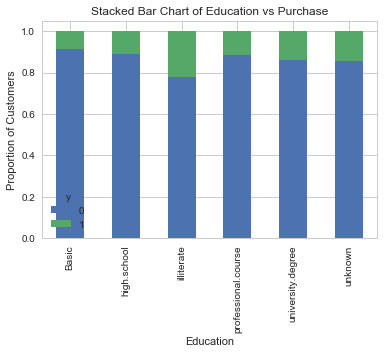

In [18]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

Text(0,0.5,'Frequency of Purchase')

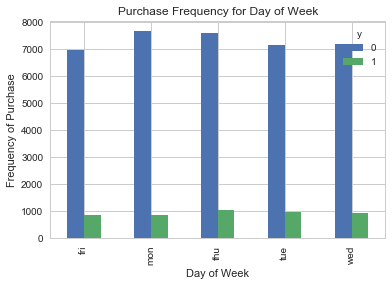

In [19]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

Day of week may not be a good predictor of the outcome.

Text(0,0.5,'Frequency of Purchase')

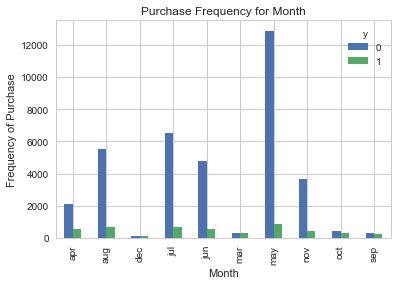

In [20]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0,0.5,'Frequency')

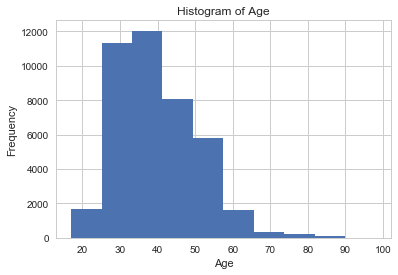

In [21]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0,0.5,'Frequency of Purchase')

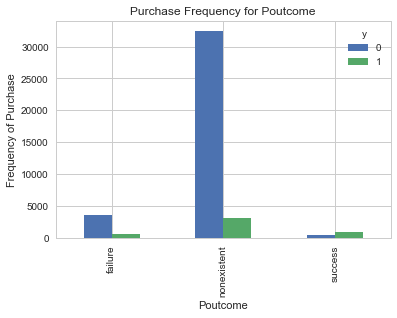

In [22]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [21]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

KeyError: 'day_of_week'

### Over-sampling using SMOTE

In [78]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

In [80]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Recursive feature elimination

In [82]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [22]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

TypeError: RFE.__init__() takes 2 positional arguments but 3 were given

The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [99]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [100]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.545891
         Iterations: 35
                                Results: Logit
Model:                   Logit                No. Iterations:       35.0000   
Dependent Variable:      y                    Pseudo R-squared:     0.212     
Date:                    2018-09-10 12:16     AIC:                  55867.1778
No. Observations:        51134                BIC:                  56044.0219
Df Model:                19                   Log-Likelihood:       -27914.   
Df Residuals:            51114                LL-Null:              -35443.   
Converged:               0.0000               Scale:                1.0000    
------------------------------------------------------------------------------
                      Coef.    Std.Err.    z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
euribor3m             -0.4634    0.0091 -50.9471 0.0000     -0.4813    -0.4456
job_blue-collar   

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The p-values for four variables are very high, therefore, we will remove them.

In [117]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [118]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555865
         Iterations 7
                           Results: Logit
Model:                Logit             No. Iterations:    7.0000    
Dependent Variable:   y                 Pseudo R-squared:  0.198     
Date:                 2018-09-10 12:38  AIC:               56879.2425
No. Observations:     51134             BIC:               57020.7178
Df Model:             15                Log-Likelihood:    -28424.   
Df Residuals:         51118             LL-Null:           -35443.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.4488   0.0074 -60.6837 0.0000 -0.4633 -0.4343
job_blue-collar      -0.2060   0.0278  -7.4032 0.0000 -0.2605 -0.1515
job_housemaid   

### Logistic Regression Model Fitting

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


### Confusion Matrix

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6124 1542]
 [2505 5170]]


In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.80      0.75      7666
          1       0.77      0.67      0.72      7675

avg / total       0.74      0.74      0.74     15341



#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

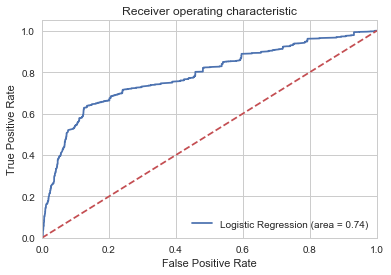

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()